# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


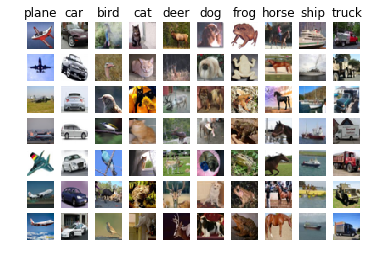

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


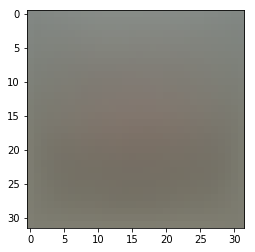

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.972620


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you


# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
print('1')
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
print('2')
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

1
numerical: 28.928080 analytic: 28.928080, relative error: 1.067758e-11
numerical: -4.152590 analytic: -4.152590, relative error: 1.021972e-10
numerical: 4.291151 analytic: 4.291151, relative error: 4.084225e-11
numerical: -1.090073 analytic: -1.090073, relative error: 1.424500e-10
numerical: 8.594289 analytic: 8.594289, relative error: 2.177070e-11
numerical: -3.516386 analytic: -3.516386, relative error: 1.113225e-10
numerical: 12.135818 analytic: 12.135818, relative error: 4.114188e-11
numerical: -23.764790 analytic: -23.764790, relative error: 1.056861e-11
numerical: -4.322776 analytic: -4.322776, relative error: 4.093794e-11
numerical: -9.729240 analytic: -9.729240, relative error: 3.691505e-11
2
numerical: 19.697968 analytic: 19.697968, relative error: 2.241912e-11
numerical: 19.602553 analytic: 19.602553, relative error: 3.790034e-12
numerical: -35.407479 analytic: -35.418666, relative error: 1.579516e-04
numerical: 0.529313 analytic: 0.529313, relative error: 2.329075e-10
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.972620e+00 computed in 0.143003s
0.003838777542114258
0.0004105567932128906
3.933906555175781e-05
(500, 10) (500, 3073)
0.0020787715911865234
0.0005202293395996094
Vectorized loss: 8.972620e+00 computed in 0.007038s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.108648s
0.002020597457885742
0.000362396240234375
4.00543212890625e-05
(500, 10) (500, 3073)
0.0019168853759765625
0.0004603862762451172
Vectorized loss and gradient: computed in 0.004955s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

0.0012519359588623047
0.0003497600555419922
2.6702880859375e-05
(200, 10) (200, 3073)
0.0015645027160644531
0.0004372596740722656
iteration 0 / 1500: loss 784.706373
0.0010442733764648438
0.0003383159637451172
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0014917850494384766
0.0004448890686035156
0.00098419189453125
0.0002605915069580078
2.6941299438476562e-05
(200, 10) (200, 3073)
0.001711130142211914
0.0004303455352783203
0.0010347366333007812
0.00030303001403808594
0.00010943412780761719
(200, 10) (200, 3073)
0.0016679763793945312
0.00042700767517089844
0.009165048599243164
0.00023674964904785156
0.00010251998901367188
(200, 10) (200, 3073)
0.0017766952514648438
0.0004725456237792969
0.0009560585021972656
0.00026988983154296875
2.7179718017578125e-05
(200, 10) (200, 3073)
0.00228118896484375
0.0006995201110839844
0.002902984619140625
0.0002796649932861328
0.00011014938354492188
(200, 10) (200, 3073)
0.0018537044525146484
0.0005180835723876953
0.0009665489196777344
0.000114440917968

0.0007431507110595703
0.0007600784301757812
0.000133514404296875
(200, 10) (200, 3073)
0.002094268798828125
0.0006444454193115234
0.00103759765625
0.0002853870391845703
0.00013303756713867188
(200, 10) (200, 3073)
0.0009975433349609375
0.0005660057067871094
0.0007731914520263672
0.000270843505859375
0.00012969970703125
(200, 10) (200, 3073)
0.010253429412841797
0.0008838176727294922
0.0013916492462158203
0.0002911090850830078
0.000133514404296875
(200, 10) (200, 3073)
0.0011456012725830078
0.0005717277526855469
0.001148223876953125
0.00028514862060546875
0.0001354217529296875
(200, 10) (200, 3073)
0.0010001659393310547
0.0005726814270019531
0.0007476806640625
0.0002808570861816406
0.0001342296600341797
(200, 10) (200, 3073)
0.0010120868682861328
0.0005753040313720703
0.0007255077362060547
0.0002701282501220703
0.0001285076141357422
(200, 10) (200, 3073)
0.001146078109741211
0.0005936622619628906
0.0007419586181640625
0.0002791881561279297
0.0001285076141357422
(200, 10) (200, 3073)
0.0

0.0024077892303466797
0.00035953521728515625
0.0001418590545654297
(200, 10) (200, 3073)
0.00109100341796875
0.0005946159362792969
0.009105920791625977
0.0002906322479248047
0.0001347064971923828
(200, 10) (200, 3073)
0.0015561580657958984
0.0005862712860107422
0.0007686614990234375
0.0002760887145996094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010166168212890625
0.0005695819854736328
0.002675771713256836
0.00027751922607421875
0.00013327598571777344
(200, 10) (200, 3073)
0.0010340213775634766
0.0005772113800048828
0.0007264614105224609
0.00028014183044433594
0.0001304149627685547
(200, 10) (200, 3073)
0.0017333030700683594
0.0005829334259033203
0.0013012886047363281
0.0002777576446533203
0.0001347064971923828
(200, 10) (200, 3073)
0.0010526180267333984
0.0005748271942138672
0.003930807113647461
0.0002777576446533203
0.0001323223114013672
(200, 10) (200, 3073)
0.001149892807006836
0.0005655288696289062
0.0007233619689941406
0.0002789497375488281
0.00012969970703125
(200, 10) (20

0.001283407211303711
0.00029659271240234375
0.00014352798461914062
(200, 10) (200, 3073)
0.002434253692626953
0.0005884170532226562
0.0007419586181640625
0.0002830028533935547
0.00013065338134765625
(200, 10) (200, 3073)
0.0010242462158203125
0.0005729198455810547
0.0007288455963134766
0.0002741813659667969
0.00012922286987304688
(200, 10) (200, 3073)
0.011318445205688477
0.0006034374237060547
0.0007338523864746094
0.0002779960632324219
0.00012969970703125
(200, 10) (200, 3073)
0.0012059211730957031
0.0005795955657958984
0.0008575916290283203
0.00029277801513671875
0.00013494491577148438
(200, 10) (200, 3073)
0.0011048316955566406
0.0005850791931152344
0.0008018016815185547
0.00028061866760253906
0.0001327991485595703
(200, 10) (200, 3073)
0.001024484634399414
0.0005660057067871094
0.0007562637329101562
0.00027823448181152344
0.00012969970703125
(200, 10) (200, 3073)
0.0011358261108398438
0.0005733966827392578
0.0007691383361816406
0.00027632713317871094
0.00013017654418945312
(200, 10

0.0011746883392333984
0.0010571479797363281
0.0011496543884277344
0.0005865097045898438
0.0001354217529296875
(200, 10) (200, 3073)
0.0011150836944580078
0.000579833984375
0.010657548904418945
0.00039386749267578125
0.0001442432403564453
(200, 10) (200, 3073)
0.0019104480743408203
0.0007166862487792969
0.003536701202392578
0.00044608116149902344
0.00016570091247558594
(200, 10) (200, 3073)
0.0015659332275390625
0.0005931854248046875
0.0007202625274658203
0.0002808570861816406
0.00012922286987304688
(200, 10) (200, 3073)
0.0011239051818847656
0.0005762577056884766
0.0008294582366943359
0.00027441978454589844
0.00013685226440429688
(200, 10) (200, 3073)
0.0010156631469726562
0.0006611347198486328
0.004946231842041016
0.00034117698669433594
0.0001347064971923828
(200, 10) (200, 3073)
0.0012683868408203125
0.0006608963012695312
0.0007753372192382812
0.0002739429473876953
0.0001277923583984375
(200, 10) (200, 3073)
0.0013129711151123047
0.0005786418914794922
0.0008385181427001953
0.00225210

0.0043201446533203125
0.0003199577331542969
2.6464462280273438e-05
(200, 10) (200, 3073)
0.0037224292755126953
0.0004742145538330078
0.00619053840637207
0.0001354217529296875
2.384185791015625e-05
(200, 10) (200, 3073)
0.004981517791748047
0.004767894744873047
0.0007472038269042969
0.0011060237884521484
5.054473876953125e-05
(200, 10) (200, 3073)
0.0025413036346435547
0.00044846534729003906
0.0007531642913818359
0.0011489391326904297
3.647804260253906e-05
(200, 10) (200, 3073)
0.0010919570922851562
0.0004172325134277344
0.00362396240234375
0.0005443096160888672
3.0994415283203125e-05
(200, 10) (200, 3073)
0.0020771026611328125
0.0004253387451171875
0.0007352828979492188
0.00029850006103515625
5.7220458984375e-05
(200, 10) (200, 3073)
0.0011563301086425781
0.0004172325134277344
0.0008697509765625
0.0002963542938232422
5.698204040527344e-05
(200, 10) (200, 3073)
0.004583597183227539
0.0005071163177490234
0.0008077621459960938
0.00011205673217773438
2.1219253540039062e-05
(200, 10) (200, 

0.003870248794555664
0.0019915103912353516
0.002225160598754883
0.0003783702850341797
3.504753112792969e-05
(200, 10) (200, 3073)
0.0022275447845458984
0.0004584789276123047
0.0013742446899414062
0.0002913475036621094
0.00010657310485839844
(200, 10) (200, 3073)
0.027455568313598633
0.00047969818115234375
0.0015020370483398438
0.00031304359436035156
0.00011801719665527344
(200, 10) (200, 3073)
0.0010075569152832031
0.00041413307189941406
0.0008747577667236328
0.0002982616424560547
0.00010752677917480469
(200, 10) (200, 3073)
0.0009739398956298828
0.0004138946533203125
0.0009744167327880859
0.0003027915954589844
6.151199340820312e-05
(200, 10) (200, 3073)
0.0010478496551513672
0.00041294097900390625
0.0008628368377685547
0.0004570484161376953
3.0040740966796875e-05
(200, 10) (200, 3073)
0.0010437965393066406
0.0004374980926513672
0.0007510185241699219
0.0003268718719482422
2.6941299438476562e-05
(200, 10) (200, 3073)
0.0010268688201904297
0.00040912628173828125
0.0008380413055419922
0.0

0.0003032684326171875
3.361701965332031e-05
(200, 10) (200, 3073)
0.0042841434478759766
0.0004563331604003906
0.0007603168487548828
0.0003020763397216797
0.00013828277587890625
(200, 10) (200, 3073)
0.00098419189453125
0.0004355907440185547
0.0007488727569580078
0.00026798248291015625
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0011091232299804688
0.0005238056182861328
0.0007276535034179688
0.0003020763397216797
5.698204040527344e-05
(200, 10) (200, 3073)
0.0010230541229248047
0.004302024841308594
0.0007336139678955078
0.0003337860107421875
2.956390380859375e-05
(200, 10) (200, 3073)
0.0010342597961425781
0.0004715919494628906
0.0008869171142578125
0.00032401084899902344
3.0040740966796875e-05
(200, 10) (200, 3073)
0.0010373592376708984
0.00041294097900390625
0.0007207393646240234
0.000331878662109375
2.8371810913085938e-05
(200, 10) (200, 3073)
0.0010347366333007812
0.0004298686981201172
0.0031442642211914062
0.0003249645233154297
2.956390380859375e-05
(200, 10) (200, 3073)
0.00102

0.0012156963348388672
0.010994434356689453
0.00011849403381347656
(200, 10) (200, 3073)
0.003635883331298828
0.0004730224609375
0.0007357597351074219
0.0003037452697753906
5.91278076171875e-05
(200, 10) (200, 3073)
0.0017826557159423828
0.0004165172576904297
0.0007786750793457031
0.0003256797790527344
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010433197021484375
0.00041103363037109375
0.000774383544921875
0.0002930164337158203
5.6743621826171875e-05
(200, 10) (200, 3073)
0.0010499954223632812
0.0005500316619873047
0.0008122920989990234
0.0002999305725097656
5.7697296142578125e-05
(200, 10) (200, 3073)
0.0011878013610839844
0.0004112720489501953
0.0007257461547851562
0.0002994537353515625
5.7220458984375e-05
(200, 10) (200, 3073)
0.002823352813720703
0.0004277229309082031
0.0007276535034179688
0.000339508056640625
2.8371810913085938e-05
(200, 10) (200, 3073)
0.001032114028930664
0.0004146099090576172
0.0007431507110595703
0.0003275871276855469
2.7418136596679688e-05
(200, 10) (200,

0.003128528594970703
0.0003643035888671875
0.0001342296600341797
(200, 10) (200, 3073)
0.0010941028594970703
0.0005803108215332031
0.0007231235504150391
0.0002796649932861328
0.00013065338134765625
(200, 10) (200, 3073)
0.0015244483947753906
0.0005881786346435547
0.0007758140563964844
0.0002791881561279297
0.0001285076141357422
(200, 10) (200, 3073)
0.0010221004486083984
0.0005753040313720703
0.0007615089416503906
0.009926080703735352
0.00015044212341308594
(200, 10) (200, 3073)
0.0012390613555908203
0.0005784034729003906
0.0007290840148925781
0.00028777122497558594
0.0001323223114013672
(200, 10) (200, 3073)
0.0010080337524414062
0.0005755424499511719
0.0015628337860107422
0.00028705596923828125
0.00013875961303710938
(200, 10) (200, 3073)
0.0010733604431152344
0.0005738735198974609
0.001359701156616211
0.00027942657470703125
0.0001327991485595703
(200, 10) (200, 3073)
0.0011172294616699219
0.0005729198455810547
0.0007927417755126953
0.0002765655517578125
0.00012946128845214844
(200, 

0.0014300346374511719
0.00040912628173828125
0.0023300647735595703
0.000392913818359375
4.00543212890625e-05
(200, 10) (200, 3073)
0.002985715866088867
0.00042057037353515625
0.0007643699645996094
0.0003228187561035156
2.765655517578125e-05
(200, 10) (200, 3073)
0.00975489616394043
0.0005295276641845703
0.0010502338409423828
0.00023627281188964844
0.00010037422180175781
(200, 10) (200, 3073)
0.0011386871337890625
0.0004074573516845703
0.0009720325469970703
0.0001125335693359375
2.1219253540039062e-05
(200, 10) (200, 3073)
0.0012431144714355469
0.0004317760467529297
0.001055002212524414
0.0002315044403076172
2.5987625122070312e-05
(200, 10) (200, 3073)
0.0011909008026123047
0.0004074573516845703
0.0015397071838378906
0.0004978179931640625
2.6941299438476562e-05
(200, 10) (200, 3073)
0.0014691352844238281
0.0004165172576904297
0.0024514198303222656
0.00033736228942871094
2.6702880859375e-05
(200, 10) (200, 3073)
0.004055023193359375
0.0004582405090332031
0.0007262229919433594
0.000370502

0.0003490447998046875
3.314018249511719e-05
(200, 10) (200, 3073)
0.01352238655090332
0.0012776851654052734
0.0007812976837158203
0.0003502368927001953
2.9325485229492188e-05
(200, 10) (200, 3073)
0.0010437965393066406
0.0005114078521728516
0.0007429122924804688
0.0003151893615722656
5.7220458984375e-05
(200, 10) (200, 3073)
0.003388643264770508
0.0004248619079589844
0.0007271766662597656
0.00038051605224609375
3.075599670410156e-05
(200, 10) (200, 3073)
0.0010378360748291016
0.000415802001953125
0.0007944107055664062
0.00032067298889160156
2.86102294921875e-05
(200, 10) (200, 3073)
0.0010402202606201172
0.0004169940948486328
0.0007367134094238281
0.000301361083984375
5.793571472167969e-05
(200, 10) (200, 3073)
0.0011034011840820312
0.0006921291351318359
0.0007669925689697266
0.00030159950256347656
0.00010776519775390625
(200, 10) (200, 3073)
0.0009734630584716797
0.0004134178161621094
0.0009706020355224609
0.0001220703125
2.5033950805664062e-05
(200, 10) (200, 3073)
0.0010967254638671

0.0007960796356201172
0.0003802776336669922
0.000133514404296875
(200, 10) (200, 3073)
0.0010683536529541016
0.0005786418914794922
0.0011172294616699219
0.0002796649932861328
0.00013303756713867188
(200, 10) (200, 3073)
0.0010101795196533203
0.0005738735198974609
0.0007998943328857422
0.0002720355987548828
0.0001308917999267578
(200, 10) (200, 3073)
0.0010466575622558594
0.0005726814270019531
0.001542806625366211
0.00029659271240234375
0.00013589859008789062
(200, 10) (200, 3073)
0.0012142658233642578
0.000579833984375
0.0017268657684326172
0.0002815723419189453
0.0001347064971923828
(200, 10) (200, 3073)
0.0011415481567382812
0.0005750656127929688
0.0007669925689697266
0.00027489662170410156
0.00013208389282226562
(200, 10) (200, 3073)
0.0010106563568115234
0.0005695819854736328
0.0011103153228759766
0.0002796649932861328
0.0001308917999267578
(200, 10) (200, 3073)
0.0010981559753417969
0.0005781650543212891
iteration 1000 / 1500: loss 5.776961
0.0009894371032714844
0.0002701282501220

0.00027561187744140625
0.0024683475494384766
(200, 10) (200, 3073)
0.0016849040985107422
0.0029027462005615234
0.012749910354614258
0.00029015541076660156
0.00013828277587890625
(200, 10) (200, 3073)
0.009486198425292969
0.0006289482116699219
0.0009098052978515625
0.0002846717834472656
0.0001323223114013672
(200, 10) (200, 3073)
0.0010089874267578125
0.0005710124969482422
0.0021452903747558594
0.002084970474243164
0.0007703304290771484
(200, 10) (200, 3073)
0.011006593704223633
0.0008006095886230469
0.003283262252807617
0.0010519027709960938
0.00040411949157714844
(200, 10) (200, 3073)
0.0021173954010009766
0.0005750656127929688
0.0007491111755371094
0.00028014183044433594
0.0001289844512939453
(200, 10) (200, 3073)
0.001314401626586914
0.0005788803100585938
0.0008120536804199219
0.003162384033203125
0.0008509159088134766
(200, 10) (200, 3073)
0.003760814666748047
0.0005977153778076172
0.0007996559143066406
0.0002715587615966797
0.00012922286987304688
(200, 10) (200, 3073)
0.0010156631

0.004792690277099609
0.0003669261932373047
0.0001323223114013672
(200, 10) (200, 3073)
0.002894163131713867
0.00060272216796875
0.0007760524749755859
0.0002818107604980469
0.0001308917999267578
(200, 10) (200, 3073)
0.0010769367218017578
0.0005717277526855469
0.0013649463653564453
0.00028014183044433594
0.00013017654418945312
(200, 10) (200, 3073)
0.009009122848510742
0.0006442070007324219
0.0009875297546386719
0.002005338668823242
0.0001800060272216797
(200, 10) (200, 3073)
0.0011959075927734375
0.0005853176116943359
0.0041959285736083984
0.0008504390716552734
0.0001361370086669922
(200, 10) (200, 3073)
0.0011146068572998047
0.0005774497985839844
0.0007708072662353516
0.00027179718017578125
0.0001304149627685547
(200, 10) (200, 3073)
0.0010218620300292969
0.0005702972412109375
0.0007200241088867188
0.0002803802490234375
0.0001285076141357422
(200, 10) (200, 3073)
0.0010342597961425781
0.0005714893341064453
0.002320528030395508
0.00028395652770996094
0.0001342296600341797
(200, 10) (20

0.00029587745666503906
3.170967102050781e-05
(200, 10) (200, 3073)
0.0026977062225341797
0.0005755424499511719
0.0008215904235839844
0.0003018379211425781
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010216236114501953
0.0005347728729248047
0.000827789306640625
0.00032830238342285156
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010197162628173828
0.0004086494445800781
0.0007288455963134766
0.00029754638671875
0.000125885009765625
(200, 10) (200, 3073)
0.01057577133178711
0.0004451274871826172
0.0007660388946533203
0.00032329559326171875
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010204315185546875
0.0004246234893798828
0.0007228851318359375
0.00038504600524902344
0.0027382373809814453
(200, 10) (200, 3073)
0.003560781478881836
0.0004303455352783203
0.0007617473602294922
0.0003211498260498047
2.9325485229492188e-05
(200, 10) (200, 3073)
0.0010488033294677734
0.0004172325134277344
0.0007143020629882812
0.0002980232238769531
5.5789947509765625e-05
(200, 10) (200, 3073)
0.0010180

0.0014755725860595703
0.002594470977783203
0.010306119918823242
0.0003037452697753906
0.0001366138458251953
(200, 10) (200, 3073)
0.0011675357818603516
0.0009014606475830078
0.004221439361572266
0.00028014183044433594
0.000133514404296875
(200, 10) (200, 3073)
0.0014553070068359375
0.0006480216979980469
0.0011119842529296875
0.00028228759765625
0.00013113021850585938
(200, 10) (200, 3073)
0.0013887882232666016
0.0005879402160644531
0.0011167526245117188
0.00028133392333984375
0.0001316070556640625
(200, 10) (200, 3073)
0.0018382072448730469
0.00093841552734375
0.001201629638671875
0.00028443336486816406
0.00013685226440429688
(200, 10) (200, 3073)
0.0014791488647460938
0.0005867481231689453
0.0014350414276123047
0.0003337860107421875
0.000141143798828125
(200, 10) (200, 3073)
0.0017390251159667969
0.0006022453308105469
0.0008425712585449219
0.0002765655517578125
0.00012826919555664062
(200, 10) (200, 3073)
0.0012249946594238281
0.0005979537963867188
0.0007543563842773438
0.000275135040

0.0020952224731445312
0.0003790855407714844
0.00013303756713867188
(200, 10) (200, 3073)
0.0026144981384277344
0.0006644725799560547
0.0009462833404541016
0.0002753734588623047
0.0001316070556640625
(200, 10) (200, 3073)
0.0010449886322021484
0.0005624294281005859
0.0007512569427490234
0.0002741813659667969
0.0001277923583984375
(200, 10) (200, 3073)
0.0010073184967041016
0.0005891323089599609
0.00808095932006836
0.0002830028533935547
0.00015044212341308594
(200, 10) (200, 3073)
0.0010755062103271484
0.0005774497985839844
0.0007295608520507812
0.0002837181091308594
0.00015163421630859375
(200, 10) (200, 3073)
0.0010395050048828125
0.0005781650543212891
0.0059626102447509766
0.001262664794921875
0.00013780593872070312
(200, 10) (200, 3073)
0.0012669563293457031
0.0006611347198486328
0.0007355213165283203
0.00028204917907714844
0.00013017654418945312
(200, 10) (200, 3073)
0.0013730525970458984
0.0005934238433837891
0.0008392333984375
0.0002675056457519531
0.00012922286987304688
(200, 10)

0.0007398128509521484
0.0024871826171875
0.00014328956604003906
(200, 10) (200, 3073)
0.0018105506896972656
0.0005962848663330078
0.0007472038269042969
0.0002796649932861328
0.00012922286987304688
(200, 10) (200, 3073)
0.0010154247283935547
0.0005834102630615234
0.00890040397644043
0.000278472900390625
0.00013303756713867188
(200, 10) (200, 3073)
0.001081228256225586
0.0006334781646728516
0.0007359981536865234
0.0002834796905517578
0.00012946128845214844
(200, 10) (200, 3073)
0.0010089874267578125
0.0005762577056884766
0.005881547927856445
0.0004038810729980469
0.0001354217529296875
(200, 10) (200, 3073)
0.0010669231414794922
0.0005848407745361328
0.0007243156433105469
0.0002803802490234375
0.0001304149627685547
(200, 10) (200, 3073)
0.001394033432006836
0.0005781650543212891
0.0007414817810058594
0.00028014183044433594
0.0001285076141357422
(200, 10) (200, 3073)
0.0012590885162353516
0.0005702972412109375
0.0007202625274658203
0.00027942657470703125
0.0001552104949951172
(200, 10) (20

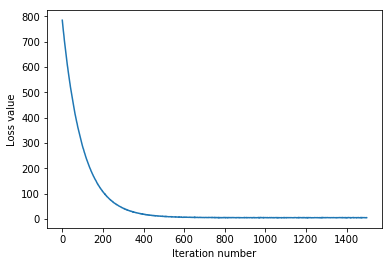

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367918
validation accuracy: 0.379000


In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
n = 4
for i in range(n):
    l_rate = learning_rates[0] + i*(learning_rates[1] - learning_rates[0])/n
    for j in range(n):
        reg = int(regularization_strengths[0] + j*(regularization_strengths[1] - regularization_strengths[0])/n)
        
        print('\n', l_rate, reg)    
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=l_rate, reg=reg,
                          num_iters=2000, verbose=True)

        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % acc_train)
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % acc_val)

        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
        
        results.update({(l_rate,reg):(acc_train, acc_val)})
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    print(lr, reg)
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


 1e-07 25000
0.012369155883789062
0.00011515617370605469
2.2411346435546875e-05
(200, 10) (200, 3073)
0.02365851402282715
0.011820793151855469
iteration 0 / 2000: loss 796.308622
0.003258228302001953
0.004642009735107422
4.291534423828125e-05
(200, 10) (200, 3073)
0.0016374588012695312
0.0004379749298095703
0.0030663013458251953
0.00016021728515625
2.384185791015625e-05
(200, 10) (200, 3073)
0.002691030502319336
0.0004341602325439453
0.0014295578002929688
0.0003094673156738281
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010616779327392578
0.0004239082336425781
0.004400968551635742
0.00031065940856933594
0.00016379356384277344
(200, 10) (200, 3073)
0.0010099411010742188
0.0004229545593261719
0.0007519721984863281
0.0004699230194091797
3.0279159545898438e-05
(200, 10) (200, 3073)
0.0010573863983154297
0.000423431396484375
0.0015015602111816406
0.0003046989440917969
0.0001087188720703125
(200, 10) (200, 3073)
0.0009846687316894531
0.00042748451232910156
0.000774383544921875
0.00030255

0.003015756607055664
0.0003554821014404297
0.0001327991485595703
(200, 10) (200, 3073)
0.001112222671508789
0.0005979537963867188
0.0007708072662353516
0.0003840923309326172
0.0001289844512939453
(200, 10) (200, 3073)
0.001033782958984375
0.0005750656127929688
0.010123014450073242
0.0004856586456298828
0.00016355514526367188
(200, 10) (200, 3073)
0.0023584365844726562
0.0006055831909179688
0.0007510185241699219
0.0002846717834472656
0.0001304149627685547
(200, 10) (200, 3073)
0.002199888229370117
0.0006113052368164062
0.0007464885711669922
0.00028514862060546875
0.00013113021850585938
(200, 10) (200, 3073)
0.0011265277862548828
0.0006206035614013672
0.0007817745208740234
0.00027179718017578125
0.00013184547424316406
(200, 10) (200, 3073)
0.00109100341796875
0.0005702972412109375
0.0042073726654052734
0.00028514862060546875
0.00013399124145507812
(200, 10) (200, 3073)
0.001157522201538086
0.0006070137023925781
0.0008289813995361328
0.0002720355987548828
0.00012826919555664062
(200, 10) 

0.00037670135498046875
0.0006651878356933594
(200, 10) (200, 3073)
0.0021500587463378906
0.0005981922149658203
0.009407281875610352
0.00028967857360839844
0.00013303756713867188
(200, 10) (200, 3073)
0.0010962486267089844
0.0005886554718017578
0.0008220672607421875
0.0002796649932861328
0.0001285076141357422
(200, 10) (200, 3073)
0.0010864734649658203
0.0005929470062255859
0.003624439239501953
0.0004458427429199219
0.00017333030700683594
(200, 10) (200, 3073)
0.0019140243530273438
0.0005688667297363281
0.0008046627044677734
0.00029087066650390625
0.00012946128845214844
(200, 10) (200, 3073)
0.001074075698852539
0.0005710124969482422
0.0008997917175292969
0.00027251243591308594
0.0001277923583984375
(200, 10) (200, 3073)
0.0011014938354492188
0.0005726814270019531
0.0008442401885986328
0.0002777576446533203
0.0001289844512939453
(200, 10) (200, 3073)
0.001012563705444336
0.0005962848663330078
0.0008068084716796875
0.00027942657470703125
0.00012969970703125
(200, 10) (200, 3073)
0.001003

0.0007367134094238281
0.0007791519165039062
0.0001468658447265625
(200, 10) (200, 3073)
0.0018990039825439453
0.0005915164947509766
0.0008161067962646484
0.00027251243591308594
0.00012922286987304688
(200, 10) (200, 3073)
0.0010073184967041016
0.0005950927734375
0.0007846355438232422
0.0002713203430175781
0.00012731552124023438
(200, 10) (200, 3073)
0.0010218620300292969
0.0005776882171630859
0.0008113384246826172
0.0002722740173339844
0.0001277923583984375
(200, 10) (200, 3073)
0.0010051727294921875
0.0005693435668945312
0.009865760803222656
0.000286102294921875
0.0001342296600341797
(200, 10) (200, 3073)
0.0010724067687988281
0.000698089599609375
0.0007388591766357422
0.00028324127197265625
0.0001308917999267578
(200, 10) (200, 3073)
0.0010991096496582031
0.000583648681640625
0.0007417201995849609
0.0002830028533935547
0.00012922286987304688
(200, 10) (200, 3073)
0.0010018348693847656
0.0005688667297363281
0.0007421970367431641
0.0003001689910888672
0.00014352798461914062
(200, 10) (

0.0007548332214355469
0.00047469139099121094
2.8371810913085938e-05
(200, 10) (200, 3073)
0.0015728473663330078
0.00041294097900390625
0.0019307136535644531
0.00029778480529785156
0.00010824203491210938
(200, 10) (200, 3073)
0.0009932518005371094
0.0004181861877441406
0.0007903575897216797
0.0002994537353515625
0.00010967254638671875
(200, 10) (200, 3073)
0.0009763240814208984
0.0004298686981201172
0.0007829666137695312
0.00030159950256347656
5.7220458984375e-05
(200, 10) (200, 3073)
0.009629964828491211
0.0005147457122802734
0.0007805824279785156
0.0003361701965332031
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010406970977783203
0.00042724609375
0.0007445812225341797
0.00031256675720214844
0.00010800361633300781
(200, 10) (200, 3073)
0.001066446304321289
0.0012004375457763672
0.002268075942993164
0.0002410411834716797
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010380744934082031
0.0004131793975830078
0.0008764266967773438
0.00043392181396484375
2.8848648071289062e-05
(200, 1

0.0015146732330322266
0.0002815723419189453
2.574920654296875e-05
(200, 10) (200, 3073)
0.0024650096893310547
0.0004572868347167969
0.0007965564727783203
0.0003333091735839844
2.7418136596679688e-05
(200, 10) (200, 3073)
0.010886669158935547
0.0004715919494628906
0.0015895366668701172
0.00031256675720214844
0.00011134147644042969
(200, 10) (200, 3073)
0.0015492439270019531
0.00043845176696777344
0.001979827880859375
0.0002396106719970703
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010530948638916016
0.0004177093505859375
0.000766754150390625
0.0003304481506347656
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0014259815216064453
0.0004069805145263672
0.0008969306945800781
0.0003235340118408203
2.7179718017578125e-05
(200, 10) (200, 3073)
0.001051187515258789
0.0004215240478515625
0.0007388591766357422
0.0003025531768798828
5.698204040527344e-05
(200, 10) (200, 3073)
0.0012362003326416016
0.0004189014434814453
0.0007796287536621094
0.0004105567932128906
2.86102294921875e-05
(200, 10

(200, 10) (200, 3073)
0.00432586669921875
0.0004994869232177734
0.0007386207580566406
0.00036072731018066406
3.0994415283203125e-05
(200, 10) (200, 3073)
0.0010523796081542969
0.00042247772216796875
0.0007255077362060547
0.0003037452697753906
5.793571472167969e-05
(200, 10) (200, 3073)
0.0015401840209960938
0.0004432201385498047
0.002276897430419922
0.00024318695068359375
2.86102294921875e-05
(200, 10) (200, 3073)
0.001041412353515625
0.0004115104675292969
0.0007350444793701172
0.0005950927734375
3.170967102050781e-05
(200, 10) (200, 3073)
0.0010547637939453125
0.00041675567626953125
0.0007534027099609375
0.0003407001495361328
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0010418891906738281
0.0004146099090576172
0.0007810592651367188
0.00029778480529785156
5.698204040527344e-05
(200, 10) (200, 3073)
0.0012159347534179688
0.0004165172576904297
0.0007526874542236328
0.0003025531768798828
5.6743621826171875e-05
(200, 10) (200, 3073)
0.001069784164428711
0.0004150867462158203
0.000731229

0.0008134841918945312
0.0030257701873779297
0.00027823448181152344
0.00013184547424316406
(200, 10) (200, 3073)
0.0010542869567871094
0.0006933212280273438
0.0007834434509277344
0.00027942657470703125
0.0001289844512939453
(200, 10) (200, 3073)
0.0010063648223876953
0.0006566047668457031
0.008325576782226562
0.0002894401550292969
0.0001323223114013672
(200, 10) (200, 3073)
0.0010960102081298828
0.0005881786346435547
0.0007348060607910156
0.00028228759765625
0.0001316070556640625
(200, 10) (200, 3073)
0.0010042190551757812
0.0005757808685302734
0.0037353038787841797
0.0002837181091308594
0.0001327991485595703
(200, 10) (200, 3073)
0.0010297298431396484
0.0005779266357421875
0.0008254051208496094
0.0002765655517578125
0.00012874603271484375
(200, 10) (200, 3073)
0.001032114028930664
0.0006692409515380859
0.0007410049438476562
0.0002808570861816406
0.00012946128845214844
(200, 10) (200, 3073)
0.00101470947265625
0.0006482601165771484
0.0007588863372802734
0.00034928321838378906
0.00012850

0.0006875991821289062
0.0030868053436279297
0.0002760887145996094
0.00013494491577148438
(200, 10) (200, 3073)
0.00106048583984375
0.0005774497985839844
0.0007956027984619141
0.00027680397033691406
0.00012826919555664062
(200, 10) (200, 3073)
0.010206460952758789
0.0006194114685058594
0.0007610321044921875
0.0002815723419189453
0.00012946128845214844
(200, 10) (200, 3073)
0.0010483264923095703
0.0005793571472167969
0.0009336471557617188
0.0002779960632324219
0.0001289844512939453
(200, 10) (200, 3073)
0.003546476364135742
0.0005826950073242188
0.0008590221405029297
0.0002753734588623047
0.0001285076141357422
(200, 10) (200, 3073)
0.0011038780212402344
0.0006492137908935547
0.0007336139678955078
0.00028395652770996094
0.00012874603271484375
(200, 10) (200, 3073)
0.0010204315185546875
0.0006034374237060547
0.0007550716400146484
0.00027751922607421875
0.00013113021850585938
(200, 10) (200, 3073)
0.0010113716125488281
0.0005979537963867188
0.0007331371307373047
0.00028014183044433594
0.000

0.0008361339569091797
0.0009098052978515625
0.0001354217529296875
(200, 10) (200, 3073)
0.003242015838623047
0.0005850791931152344
0.0007295608520507812
0.00028133392333984375
0.00012946128845214844
(200, 10) (200, 3073)
0.0010187625885009766
0.0005841255187988281
0.007801532745361328
0.0002837181091308594
0.0001323223114013672
(200, 10) (200, 3073)
0.0010693073272705078
0.0006105899810791016
0.0007472038269042969
0.00028228759765625
0.00012946128845214844
(200, 10) (200, 3073)
0.00109100341796875
0.0005719661712646484
0.0035729408264160156
0.00028133392333984375
0.00013303756713867188
(200, 10) (200, 3073)
0.0011126995086669922
0.0005755424499511719
0.0009677410125732422
0.0002715587615966797
0.0001316070556640625
(200, 10) (200, 3073)
0.0010700225830078125
0.0005750656127929688
0.0008487701416015625
0.0002739429473876953
0.00012803077697753906
(200, 10) (200, 3073)
0.0010089874267578125
0.00057220458984375
0.0007481575012207031
0.00027823448181152344
0.00016045570373535156
(200, 10) 

0.0010216236114501953
0.0012233257293701172
0.0024666786193847656
0.0003571510314941406
0.0001323223114013672
(200, 10) (200, 3073)
0.009964227676391602
0.000606536865234375
0.0008671283721923828
0.0002865791320800781
0.0001304149627685547
(200, 10) (200, 3073)
0.0010869503021240234
0.0005707740783691406
0.0007688999176025391
0.0002932548522949219
0.0001285076141357422
(200, 10) (200, 3073)
0.003952503204345703
0.000682830810546875
0.000896453857421875
0.00028705596923828125
0.00013184547424316406
(200, 10) (200, 3073)
0.0010530948638916016
0.0009381771087646484
0.0007429122924804688
0.0003616809844970703
0.00013017654418945312
(200, 10) (200, 3073)
0.0010294914245605469
0.0005955696105957031
0.0007407665252685547
0.0002827644348144531
0.00012755393981933594
(200, 10) (200, 3073)
0.001016378402709961
0.0005805492401123047
0.0008637905120849609
0.0002727508544921875
0.0001277923583984375
(200, 10) (200, 3073)
0.001035928726196289
0.0005772113800048828
0.0007715225219726562
0.00027084350

0.00029778480529785156
3.266334533691406e-05
(200, 10) (200, 3073)
0.0026025772094726562
0.0005037784576416016
0.0009458065032958984
0.0002911090850830078
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010297298431396484
0.00043010711669921875
0.0007746219635009766
0.0003345012664794922
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0010440349578857422
0.0004818439483642578
0.0007300376892089844
0.0003268718719482422
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0010421276092529297
0.0004401206970214844
0.0007357597351074219
0.00047516822814941406
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010461807250976562
0.0004200935363769531
0.008782148361206055
0.00034928321838378906
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0011534690856933594
0.0004146099090576172
0.0007672309875488281
0.00030517578125
5.745887756347656e-05
(200, 10) (200, 3073)
0.0011897087097167969
0.0004177093505859375
0.00084686279296875
0.0005130767822265625
2.384185791015625e-05
(200, 10) (200, 3073)
0.00114893

0.0010483264923095703
0.0012514591217041016
0.002205371856689453
0.000286102294921875
0.00013494491577148438
(200, 10) (200, 3073)
0.0011627674102783203
0.0005826950073242188
0.0007965564727783203
0.00027489662170410156
0.00012946128845214844
(200, 10) (200, 3073)
0.0010149478912353516
0.0005767345428466797
0.0008320808410644531
0.0002732276916503906
0.00012922286987304688
(200, 10) (200, 3073)
0.0010128021240234375
0.0005724430084228516
0.0008826255798339844
0.006545066833496094
0.00015473365783691406
(200, 10) (200, 3073)
0.010320425033569336
0.000545501708984375
0.006878852844238281
0.0001220703125
2.4557113647460938e-05
(200, 10) (200, 3073)
0.0012514591217041016
0.00042128562927246094
0.0013544559478759766
0.00011706352233886719
2.4080276489257812e-05
(200, 10) (200, 3073)
0.0016655921936035156
0.00041484832763671875
0.0022475719451904297
0.0005161762237548828
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0012791156768798828
0.00042438507080078125
0.0021708011627197266
0.00011515

0.0031807422637939453
0.0006024837493896484
0.0007441043853759766
0.0002899169921875
0.00012969970703125
(200, 10) (200, 3073)
0.0010099411010742188
0.0006437301635742188
0.0007441043853759766
0.00027251243591308594
0.0001270771026611328
(200, 10) (200, 3073)
0.001009225845336914
0.0005991458892822266
0.0007414817810058594
0.00027489662170410156
0.00012874603271484375
(200, 10) (200, 3073)
0.0010139942169189453
0.0005900859832763672
0.008317232131958008
0.0002808570861816406
0.00013256072998046875
(200, 10) (200, 3073)
0.0010802745819091797
0.0005822181701660156
0.0007379055023193359
0.00028228759765625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010037422180175781
0.0005788803100585938
0.0037627220153808594
0.0003020763397216797
0.0001327991485595703
(200, 10) (200, 3073)
0.0010683536529541016
0.0005826950073242188
0.0007457733154296875
0.0002815723419189453
0.00012946128845214844
(200, 10) (200, 3073)
0.001203775405883789
0.0006797313690185547
0.0007696151733398438
0.000277996063

0.003068685531616211
0.0003604888916015625
0.00013136863708496094
(200, 10) (200, 3073)
0.0010836124420166016
0.0005850791931152344
0.0007412433624267578
0.0002830028533935547
0.00012946128845214844
(200, 10) (200, 3073)
0.0010066032409667969
0.0005981922149658203
0.010035276412963867
0.00028395652770996094
0.00013303756713867188
(200, 10) (200, 3073)
0.0011091232299804688
0.0005834102630615234
0.0007452964782714844
0.0002758502960205078
0.00012803077697753906
(200, 10) (200, 3073)
0.0010099411010742188
0.0005841255187988281
0.003291606903076172
0.00028204917907714844
0.0001347064971923828
(200, 10) (200, 3073)
0.0010623931884765625
0.0005786418914794922
0.0007317066192626953
0.0002808570861816406
0.0001995563507080078
(200, 10) (200, 3073)
0.0010390281677246094
0.0005795955657958984
0.0008220672607421875
0.0002961158752441406
0.00013017654418945312
(200, 10) (200, 3073)
0.0010352134704589844
0.0005741119384765625
0.0007722377777099609
0.0002815723419189453
0.0001277923583984375
(200, 

0.0038084983825683594
0.00032639503479003906
2.6941299438476562e-05
(200, 10) (200, 3073)
0.0010921955108642578
0.0004787445068359375
0.008912086486816406
0.0003399848937988281
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010974407196044922
0.00043201446533203125
0.0007452964782714844
0.0003027915954589844
0.00010752677917480469
(200, 10) (200, 3073)
0.0009818077087402344
0.00041866302490234375
0.004074573516845703
0.00032711029052734375
3.0279159545898438e-05
(200, 10) (200, 3073)
0.00104522705078125
0.00041747093200683594
0.001068115234375
0.00033736228942871094
2.9087066650390625e-05
(200, 10) (200, 3073)
0.0010421276092529297
0.0004973411560058594
0.0029859542846679688
0.00033020973205566406
0.00011110305786132812
(200, 10) (200, 3073)
0.000997781753540039
0.0004181861877441406
0.0007579326629638672
0.0003249645233154297
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010275840759277344
0.000415802001953125
0.0007431507110595703
0.00034165382385253906
2.7894973754882812e-05
(200,

0.012714147567749023
0.000133514404296875
2.3603439331054688e-05
(200, 10) (200, 3073)
0.005732536315917969
0.01221466064453125
0.0012640953063964844
0.000335693359375
6.389617919921875e-05
(200, 10) (200, 3073)
0.001405477523803711
0.0006170272827148438
0.0007390975952148438
0.0003414154052734375
2.86102294921875e-05
(200, 10) (200, 3073)
0.001033782958984375
0.0004210472106933594
0.0008730888366699219
0.0004067420959472656
2.9087066650390625e-05
(200, 10) (200, 3073)
0.0015511512756347656
0.0004372596740722656
iteration 1400 / 2000: loss 5.595426
0.0009703636169433594
0.0003783702850341797
0.00010895729064941406
(200, 10) (200, 3073)
0.0018680095672607422
0.0005521774291992188
0.0017070770263671875
0.0004267692565917969
3.0994415283203125e-05
(200, 10) (200, 3073)
0.0010833740234375
0.0004227161407470703
0.0009059906005859375
0.0002968311309814453
0.00010824203491210938
(200, 10) (200, 3073)
0.0009770393371582031
0.0004737377166748047
0.0009806156158447266
0.0003306865692138672
2.884

0.004055500030517578
0.0003490447998046875
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0011301040649414062
0.00041937828063964844
0.0008587837219238281
0.00032782554626464844
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010521411895751953
0.0005278587341308594
0.0007569789886474609
0.00033164024353027344
2.7894973754882812e-05
(200, 10) (200, 3073)
0.001028299331665039
0.0004153251647949219
0.0007386207580566406
0.00999140739440918
0.00013446807861328125
(200, 10) (200, 3073)
0.0010497570037841797
0.00043129920959472656
0.0008358955383300781
0.0002949237823486328
0.000110626220703125
(200, 10) (200, 3073)
0.0009834766387939453
0.00044274330139160156
0.0009610652923583984
0.00011658668518066406
2.193450927734375e-05
(200, 10) (200, 3073)
0.003679037094116211
0.00041794776916503906
0.0007543563842773438
0.0003349781036376953
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010335445404052734
0.0005772113800048828
0.0008504390716552734
0.00030159950256347656
6.031990051269531e-05
(20

0.0007710456848144531
0.0009624958038330078
0.00012063980102539062
2.6464462280273438e-05
(200, 10) (200, 3073)
0.0018465518951416016
0.00040984153747558594
0.005242109298706055
0.0003185272216796875
6.222724914550781e-05
(200, 10) (200, 3073)
0.002001047134399414
0.0004153251647949219
0.0008752346038818359
0.00011014938354492188
2.1457672119140625e-05
(200, 10) (200, 3073)
0.008438587188720703
0.0005035400390625
0.0015308856964111328
0.003872394561767578
3.695487976074219e-05
(200, 10) (200, 3073)
0.006913661956787109
0.0005910396575927734
0.0016188621520996094
0.00026798248291015625
2.956390380859375e-05
(200, 10) (200, 3073)
0.0011107921600341797
0.00041556358337402344
0.005640745162963867
0.00013303756713867188
2.3365020751953125e-05
(200, 10) (200, 3073)
0.0025010108947753906
0.0004305839538574219
0.0007493495941162109
0.00026535987854003906
2.6702880859375e-05
(200, 10) (200, 3073)
0.0010802745819091797
0.00041365623474121094
0.002562999725341797
0.0003266334533691406
6.222724914

0.0007541179656982422
0.0009024143218994141
0.00013375282287597656
(200, 10) (200, 3073)
0.003230571746826172
0.000659942626953125
0.008615970611572266
0.00028634071350097656
0.00013446807861328125
(200, 10) (200, 3073)
0.0010635852813720703
0.0005788803100585938
0.0007524490356445312
0.0002789497375488281
0.00012969970703125
(200, 10) (200, 3073)
0.002431631088256836
0.0006320476531982422
0.001085519790649414
0.0002815723419189453
0.00013113021850585938
(200, 10) (200, 3073)
0.0010013580322265625
0.0005800724029541016
0.0007772445678710938
0.0002827644348144531
0.00013113021850585938
(200, 10) (200, 3073)
0.0014159679412841797
0.0005991458892822266
0.0007359981536865234
0.00028204917907714844
0.00013136863708496094
(200, 10) (200, 3073)
0.0010294914245605469
0.000579833984375
0.00179290771484375
0.00026798248291015625
0.00013184547424316406
(200, 10) (200, 3073)
0.0011315345764160156
0.0005800724029541016
0.0007476806640625
0.00028133392333984375
0.00013017654418945312
(200, 10) (200,

(200, 10) (200, 3073)
0.003859996795654297
0.0006172657012939453
0.0007431507110595703
0.0002918243408203125
0.0001323223114013672
(200, 10) (200, 3073)
0.0010132789611816406
0.0005784034729003906
0.0007550716400146484
0.000274658203125
0.00013136863708496094
(200, 10) (200, 3073)
0.0010569095611572266
0.0005791187286376953
0.0007507801055908203
0.00028252601623535156
0.0001285076141357422
(200, 10) (200, 3073)
0.0010099411010742188
0.0005743503570556641
0.0008099079132080078
0.00028228759765625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010018348693847656
0.00913381576538086
0.002055644989013672
0.000308990478515625
0.00013971328735351562
(200, 10) (200, 3073)
0.001110076904296875
0.0005860328674316406
0.0015153884887695312
0.00029015541076660156
0.00013327598571777344
(200, 10) (200, 3073)
0.0019354820251464844
0.0005841255187988281
0.0007364749908447266
0.0002853870391845703
0.00013017654418945312
(200, 10) (200, 3073)
0.0010051727294921875
0.0005753040313720703
0.00107097625732

0.0007555484771728516
0.0008945465087890625
0.00013303756713867188
(200, 10) (200, 3073)
0.0032320022583007812
0.0005948543548583984
0.0007283687591552734
0.00027871131896972656
0.0001316070556640625
(200, 10) (200, 3073)
0.0010404586791992188
0.0005812644958496094
0.0007863044738769531
0.0002830028533935547
0.00012826919555664062
(200, 10) (200, 3073)
0.0010306835174560547
0.0005762577056884766
0.0007662773132324219
0.0002815723419189453
0.0001285076141357422
(200, 10) (200, 3073)
0.0010662078857421875
0.0005795955657958984
0.0007367134094238281
0.00028634071350097656
0.00029349327087402344
(200, 10) (200, 3073)
0.010421991348266602
0.0008399486541748047
0.0018610954284667969
0.0003533363342285156
0.00013709068298339844
(200, 10) (200, 3073)
0.001992464065551758
0.0006175041198730469
0.0007596015930175781
0.0002913475036621094
0.0001304149627685547
(200, 10) (200, 3073)
0.0011098384857177734
0.0005774497985839844
0.0007424354553222656
0.00028514862060546875
0.00012993812561035156
(200

0.0007746219635009766
0.0008971691131591797
0.00013184547424316406
(200, 10) (200, 3073)
0.006007194519042969
0.0006325244903564453
0.0007660388946533203
0.0002894401550292969
0.00013256072998046875
(200, 10) (200, 3073)
0.0010199546813964844
0.0005776882171630859
0.001211404800415039
0.00029015541076660156
0.00013637542724609375
(200, 10) (200, 3073)
0.0011813640594482422
0.0005846023559570312
0.0007405281066894531
0.0002853870391845703
0.00012874603271484375
(200, 10) (200, 3073)
0.003751993179321289
0.0006108283996582031
0.0007615089416503906
0.0002830028533935547
0.00013017654418945312
(200, 10) (200, 3073)
0.0010864734649658203
0.0007731914520263672
0.0007827281951904297
0.00028395652770996094
0.00013256072998046875
(200, 10) (200, 3073)
0.0012710094451904297
0.0005812644958496094
0.0007562637329101562
0.0002841949462890625
0.00012969970703125
(200, 10) (200, 3073)
0.0010046958923339844
0.0008413791656494141
iteration 1900 / 2000: loss 5.681919
0.0007762908935546875
0.000281572341

0.0010180473327636719
0.0011982917785644531
0.0010564327239990234
0.0002872943878173828
0.00013208389282226562
(200, 10) (200, 3073)
0.015175580978393555
0.0006444454193115234
0.0007538795471191406
0.00028061866760253906
0.0001289844512939453
(200, 10) (200, 3073)
0.0010251998901367188
0.0006260871887207031
0.0007677078247070312
0.0002741813659667969
0.0001285076141357422
(200, 10) (200, 3073)
0.003523111343383789
0.000606536865234375
0.0007407665252685547
0.0002906322479248047
0.00013065338134765625
(200, 10) (200, 3073)
0.0010151863098144531
0.0005807876586914062
0.0007967948913574219
0.0002789497375488281
0.00012826919555664062
(200, 10) (200, 3073)
0.0009987354278564453
0.0005753040313720703
0.0008327960968017578
0.00027441978454589844
0.00012803077697753906
(200, 10) (200, 3073)
0.0010044574737548828
0.0005738735198974609
0.0008158683776855469
0.00027108192443847656
0.0001285076141357422
(200, 10) (200, 3073)
0.0010361671447753906
0.0005784034729003906
0.0007512569427490234
0.0002

0.01648879051208496
0.00038504600524902344
0.00013566017150878906
(200, 10) (200, 3073)
0.0011875629425048828
0.0005900859832763672
0.0007495880126953125
0.0042569637298583984
0.0001442432403564453
(200, 10) (200, 3073)
0.0011260509490966797
0.0005838871002197266
0.0007672309875488281
0.0002853870391845703
0.00012922286987304688
(200, 10) (200, 3073)
0.0010228157043457031
0.0005743503570556641
0.0007343292236328125
0.00028228759765625
0.00012993812561035156
(200, 10) (200, 3073)
0.0010333061218261719
0.0009138584136962891
0.0008718967437744141
0.00027441978454589844
0.00013828277587890625
(200, 10) (200, 3073)
0.0013234615325927734
0.0005741119384765625
0.0007536411285400391
0.00029277801513671875
0.0001327991485595703
(200, 10) (200, 3073)
0.0010297298431396484
0.0005812644958496094
0.0007703304290771484
0.00028228759765625
0.00012803077697753906
(200, 10) (200, 3073)
0.0010170936584472656
0.0005779266357421875
0.0007488727569580078
0.00028967857360839844
0.0001285076141357422
(200, 1

0.0007343292236328125
0.0009067058563232422
0.00013256072998046875
(200, 10) (200, 3073)
0.01356196403503418
0.0006310939788818359
0.0007593631744384766
0.0008015632629394531
0.0001361370086669922
(200, 10) (200, 3073)
0.0010559558868408203
0.0011420249938964844
0.0007688999176025391
0.0002834796905517578
0.00012993812561035156
(200, 10) (200, 3073)
0.0010099411010742188
0.0005776882171630859
0.0007672309875488281
0.00027108192443847656
0.00012874603271484375
(200, 10) (200, 3073)
0.0010139942169189453
0.0005776882171630859
0.0007555484771728516
0.00027489662170410156
0.0001285076141357422
(200, 10) (200, 3073)
0.0010685920715332031
0.0005693435668945312
0.0007817745208740234
0.0002713203430175781
0.00013065338134765625
(200, 10) (200, 3073)
0.001009225845336914
0.0006849765777587891
0.0008356571197509766
0.0002732276916503906
0.00012826919555664062
(200, 10) (200, 3073)
0.0010204315185546875
0.0005776882171630859
0.0007572174072265625
0.00028014183044433594
0.00012826919555664062
(200

0.0005705356597900391
0.002746105194091797
0.00028014183044433594
0.0001347064971923828
(200, 10) (200, 3073)
0.0013718605041503906
0.0005893707275390625
0.0007915496826171875
0.00029015541076660156
0.00012993812561035156
(200, 10) (200, 3073)
0.001270294189453125
0.0005824565887451172
0.0007636547088623047
0.0002856254577636719
0.0001277923583984375
(200, 10) (200, 3073)
0.0010771751403808594
0.0005779266357421875
0.0007650852203369141
0.0002834796905517578
0.00012946128845214844
(200, 10) (200, 3073)
0.010678529739379883
0.0005946159362792969
0.0007498264312744141
0.0002906322479248047
0.00012993812561035156
(200, 10) (200, 3073)
0.0010218620300292969
0.0005733966827392578
0.0008695125579833984
0.0002968311309814453
0.00013446807861328125
(200, 10) (200, 3073)
0.0009911060333251953
0.0006377696990966797
0.0007433891296386719
0.0002880096435546875
0.00013136863708496094
(200, 10) (200, 3073)
0.0010688304901123047
0.0005724430084228516
0.0007407665252685547
0.0002827644348144531
0.0001

0.0008592605590820312
0.00013208389282226562
(200, 10) (200, 3073)
0.0020236968994140625
0.0005998611450195312
0.0007407665252685547
0.0003695487976074219
0.00012946128845214844
(200, 10) (200, 3073)
0.001104116439819336
0.0005800724029541016
0.0007388591766357422
0.00028395652770996094
0.00012874603271484375
(200, 10) (200, 3073)
0.0010073184967041016
0.0005748271942138672
0.00941777229309082
0.00029397010803222656
0.00013709068298339844
(200, 10) (200, 3073)
0.001132965087890625
0.0007081031799316406
0.0008435249328613281
0.0002765655517578125
0.00012922286987304688
(200, 10) (200, 3073)
0.001051187515258789
0.0005729198455810547
0.0036330223083496094
0.00028705596923828125
0.00013566017150878906
(200, 10) (200, 3073)
0.0010955333709716797
0.0005834102630615234
0.0007717609405517578
0.0002799034118652344
0.0001285076141357422
(200, 10) (200, 3073)
0.0011036396026611328
0.0005650520324707031
0.0007407665252685547
0.0002796649932861328
0.00012922286987304688
(200, 10) (200, 3073)
0.001

0.001953601837158203
0.0003476142883300781
0.00013184547424316406
(200, 10) (200, 3073)
0.0017271041870117188
0.0005779266357421875
0.0008931159973144531
0.0002741813659667969
0.00013113021850585938
(200, 10) (200, 3073)
0.003923892974853516
0.0007259845733642578
0.0009806156158447266
0.00028324127197265625
0.00013303756713867188
(200, 10) (200, 3073)
0.0010395050048828125
0.0005931854248046875
0.004189729690551758
0.0003020763397216797
0.00013518333435058594
(200, 10) (200, 3073)
0.0024995803833007812
0.0005991458892822266
0.0007765293121337891
0.0002765655517578125
0.0001308917999267578
(200, 10) (200, 3073)
0.0010600090026855469
0.0006711483001708984
0.008237123489379883
0.00038743019104003906
0.0001704692840576172
(200, 10) (200, 3073)
0.0014209747314453125
0.004809379577636719
0.002838134765625
0.0003228187561035156
0.00013709068298339844
(200, 10) (200, 3073)
0.0011050701141357422
0.0005831718444824219
0.0007617473602294922
0.00027441978454589844
0.00012922286987304688
(200, 10) 

0.0010421276092529297
0.0008802413940429688
0.0001366138458251953
(200, 10) (200, 3073)
0.002299785614013672
0.0006022453308105469
0.0007684230804443359
0.00028252601623535156
0.00013017654418945312
(200, 10) (200, 3073)
0.0011053085327148438
0.0005710124969482422
0.009511470794677734
0.00028824806213378906
0.00013709068298339844
(200, 10) (200, 3073)
0.0011410713195800781
0.0005893707275390625
0.0007379055023193359
0.00028204917907714844
0.00012922286987304688
(200, 10) (200, 3073)
0.0010271072387695312
0.0005700588226318359
0.0007703304290771484
0.0002963542938232422
0.00013685226440429688
(200, 10) (200, 3073)
0.0009982585906982422
0.0005867481231689453
0.0007417201995849609
0.0002818107604980469
0.00013184547424316406
(200, 10) (200, 3073)
0.0011444091796875
0.0005817413330078125
0.0007479190826416016
0.0002734661102294922
0.0001285076141357422
(200, 10) (200, 3073)
0.0010094642639160156
0.0005817413330078125
0.0007393360137939453
0.0002810955047607422
0.00012874603271484375
(200, 

0.0007584095001220703
0.0008902549743652344
0.0001323223114013672
(200, 10) (200, 3073)
0.001802682876586914
0.0006449222564697266
0.0007483959197998047
0.00029015541076660156
0.00013017654418945312
(200, 10) (200, 3073)
0.0010082721710205078
0.0007128715515136719
0.008560657501220703
0.00029659271240234375
0.00013518333435058594
(200, 10) (200, 3073)
0.001087188720703125
0.000583648681640625
0.0007424354553222656
0.0002930164337158203
0.0001285076141357422
(200, 10) (200, 3073)
0.0010199546813964844
0.0005791187286376953
0.0008456707000732422
0.00029540061950683594
0.00013566017150878906
(200, 10) (200, 3073)
0.0010170936584472656
0.0005686283111572266
0.0007269382476806641
0.00028395652770996094
0.00013327598571777344
(200, 10) (200, 3073)
0.0011563301086425781
0.0005691051483154297
0.0007510185241699219
0.00027680397033691406
0.00013065338134765625
(200, 10) (200, 3073)
0.0010340213775634766
0.0005767345428466797
0.0007433891296386719
0.00028014183044433594
0.00020313262939453125
(2

0.0016245841979980469
0.00027823448181152344
0.00013399124145507812
(200, 10) (200, 3073)
0.0011205673217773438
0.0005888938903808594
0.00906062126159668
0.0002951622009277344
0.0001361370086669922
(200, 10) (200, 3073)
0.0011284351348876953
0.0005807876586914062
0.0007405281066894531
0.00029587745666503906
0.00012969970703125
(200, 10) (200, 3073)
0.0010216236114501953
0.0005786418914794922
0.0007576942443847656
0.00030159950256347656
0.0001342296600341797
(200, 10) (200, 3073)
0.0011265277862548828
0.0005729198455810547
0.0007460117340087891
0.00028252601623535156
0.00013065338134765625
(200, 10) (200, 3073)
0.0011725425720214844
0.0005745887756347656
0.0007843971252441406
0.0002770423889160156
0.00013065338134765625
(200, 10) (200, 3073)
0.0010173320770263672
0.0005741119384765625
0.0007634162902832031
0.0002834796905517578
0.00012874603271484375
(200, 10) (200, 3073)
0.0015914440155029297
0.0005853176116943359
0.0007534027099609375
0.0002772808074951172
0.0001285076141357422
(200, 

0.004102468490600586
0.0003616809844970703
0.0001354217529296875
(200, 10) (200, 3073)
0.0011448860168457031
0.0005772113800048828
0.0007550716400146484
0.0002791881561279297
0.00012993812561035156
(200, 10) (200, 3073)
0.001004934310913086
0.0005729198455810547
0.0007612705230712891
0.0002760887145996094
0.0001277923583984375
(200, 10) (200, 3073)
0.001064300537109375
0.0005786418914794922
0.0007789134979248047
0.0002732276916503906
0.00012826919555664062
(200, 10) (200, 3073)
0.0010113716125488281
0.0007090568542480469
0.011239290237426758
0.0002880096435546875
0.0001373291015625
(200, 10) (200, 3073)
0.0011076927185058594
0.0005800724029541016
0.0007777214050292969
0.0002734661102294922
0.0005285739898681641
(200, 10) (200, 3073)
0.0010802745819091797
0.0005857944488525391
0.0007464885711669922
0.0003056526184082031
0.00012993812561035156
(200, 10) (200, 3073)
0.0012426376342773438
0.0005838871002197266
0.0007596015930175781
0.000278472900390625
0.0001285076141357422
(200, 10) (200,

0.0014309883117675781
0.0003020763397216797
0.0001323223114013672
(200, 10) (200, 3073)
0.002640247344970703
0.0006268024444580078
0.0007593631744384766
0.0002834796905517578
0.00013184547424316406
(200, 10) (200, 3073)
0.0010023117065429688
0.0005695819854736328
0.0007355213165283203
0.0002856254577636719
0.00012826919555664062
(200, 10) (200, 3073)
0.01024174690246582
0.0006256103515625
0.001005411148071289
0.0002980232238769531
0.0001361370086669922
(200, 10) (200, 3073)
0.008810758590698242
0.0006103515625
0.0007534027099609375
0.0002856254577636719
0.0001316070556640625
(200, 10) (200, 3073)
0.001020193099975586
0.00057220458984375
0.000904083251953125
0.00027251243591308594
0.00013208389282226562
(200, 10) (200, 3073)
0.0010313987731933594
0.0005772113800048828
0.0007524490356445312
0.00028204917907714844
0.0001285076141357422
(200, 10) (200, 3073)
0.005383968353271484
0.0006253719329833984
0.0007848739624023438
0.00028896331787109375
0.00013136863708496094
(200, 10) (200, 3073)


0.0032491683959960938
0.0003604888916015625
0.0001361370086669922
(200, 10) (200, 3073)
0.0010874271392822266
0.0005862712860107422
0.0012598037719726562
0.0002856254577636719
0.00013184547424316406
(200, 10) (200, 3073)
0.009514331817626953
0.0006237030029296875
0.0007445812225341797
0.0002837181091308594
0.00012946128845214844
(200, 10) (200, 3073)
0.0011298656463623047
0.0005705356597900391
0.0008380413055419922
0.000270843505859375
0.0001289844512939453
(200, 10) (200, 3073)
0.0010089874267578125
0.003096342086791992
0.0007808208465576172
0.00028514862060546875
0.00013256072998046875
(200, 10) (200, 3073)
0.0011005401611328125
0.0005753040313720703
0.0009224414825439453
0.0002796649932861328
0.00013375282287597656
(200, 10) (200, 3073)
0.0010418891906738281
0.0005698204040527344
0.0007457733154296875
0.000274658203125
0.00012922286987304688
(200, 10) (200, 3073)
0.0010149478912353516
0.0005774497985839844
0.0012929439544677734
0.0002713203430175781
0.00012922286987304688
(200, 10) 

0.0007483959197998047
0.0009005069732666016
0.00013208389282226562
(200, 10) (200, 3073)
0.0018656253814697266
0.0005986690521240234
0.010067462921142578
0.0002815723419189453
0.00013256072998046875
(200, 10) (200, 3073)
0.0010945796966552734
0.0005731582641601562
0.0007603168487548828
0.0002789497375488281
0.00012874603271484375
(200, 10) (200, 3073)
0.0010099411010742188
0.0005786418914794922
0.0031080245971679688
0.00028395652770996094
0.0001327991485595703
(200, 10) (200, 3073)
0.0010731220245361328
0.0005805492401123047
0.0008847713470458984
0.00028252601623535156
0.00013256072998046875
(200, 10) (200, 3073)
0.001016378402709961
0.0005764961242675781
0.0007560253143310547
0.0002803802490234375
0.0001316070556640625
(200, 10) (200, 3073)
0.0010247230529785156
0.0005748271942138672
0.0007529258728027344
0.0002741813659667969
0.00012946128845214844
(200, 10) (200, 3073)
0.0014832019805908203
0.0005865097045898438
0.0007474422454833984
0.00028228759765625
0.0001289844512939453
(200, 1

(200, 10) (200, 3073)
0.0031545162200927734
0.0006265640258789062
0.0007784366607666016
0.00028204917907714844
0.00012993812561035156
(200, 10) (200, 3073)
0.0010685920715332031
0.0005700588226318359
0.0007433891296386719
0.0002765655517578125
0.0001289844512939453
(200, 10) (200, 3073)
0.0010051727294921875
0.0005736351013183594
0.0007548332214355469
0.0002739429473876953
0.00012731552124023438
(200, 10) (200, 3073)
0.0010139942169189453
0.0005757808685302734
0.009659767150878906
0.00028967857360839844
0.0001361370086669922
(200, 10) (200, 3073)
0.0011093616485595703
0.0005719661712646484
0.0007326602935791016
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.0010080337524414062
0.0005719661712646484
0.0007541179656982422
0.00031375885009765625
0.0001347064971923828
(200, 10) (200, 3073)
0.0010080337524414062
0.0005834102630615234
0.0007612705230712891
0.00028896331787109375
0.00012993812561035156
(200, 10) (200, 3073)
0.0010094642639160156
0.0005710124969482422
0.00

0.003027677536010742
0.00035381317138671875
0.00013303756713867188
(200, 10) (200, 3073)
0.0010943412780761719
0.0005879402160644531
0.0007700920104980469
0.00028061866760253906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010213851928710938
0.0005764961242675781
0.0008869171142578125
0.00027751922607421875
0.00012946128845214844
(200, 10) (200, 3073)
0.009994745254516602
0.0005984306335449219
0.0007703304290771484
0.00027108192443847656
0.0001285076141357422
(200, 10) (200, 3073)
0.0010025501251220703
0.0005717277526855469
0.0031442642211914062
0.00028586387634277344
0.00013637542724609375
(200, 10) (200, 3073)
0.0010843276977539062
0.0005788803100585938
0.0007848739624023438
0.0002739429473876953
0.0001316070556640625
(200, 10) (200, 3073)
0.001016855239868164
0.0005686283111572266
0.0007433891296386719
0.00028395652770996094
0.0001304149627685547
(200, 10) (200, 3073)
0.0010111331939697266
0.0005929470062255859
0.0007395744323730469
0.0002827644348144531
0.0001277923583984375
(20

0.0030198097229003906
0.00035834312438964844
0.0001327991485595703
(200, 10) (200, 3073)
0.0010848045349121094
0.0005888938903808594
0.009756088256835938
0.0002875328063964844
0.00013446807861328125
(200, 10) (200, 3073)
0.0010828971862792969
0.0005807876586914062
0.0008320808410644531
0.0002751350402832031
0.0001289844512939453
(200, 10) (200, 3073)
0.0010116100311279297
0.003535747528076172
0.0007426738739013672
0.0002887248992919922
0.0001342296600341797
(200, 10) (200, 3073)
0.0010249614715576172
0.0005774497985839844
0.0007503032684326172
0.00027942657470703125
0.0001308917999267578
(200, 10) (200, 3073)
0.0010101795196533203
0.0005707740783691406
0.0007464885711669922
0.0002791881561279297
0.00013065338134765625
(200, 10) (200, 3073)
0.0010037422180175781
0.0005719661712646484
0.0007522106170654297
0.0007779598236083984
0.00012993812561035156
(200, 10) (200, 3073)
0.0010538101196289062
0.0005834102630615234
0.0007543563842773438
0.0002779960632324219
0.0001277923583984375
(200, 1

0.004147052764892578
0.0003635883331298828
0.00013494491577148438
(200, 10) (200, 3073)
0.001131296157836914
0.0005848407745361328
0.0007688999176025391
0.0002770423889160156
0.00012993812561035156
(200, 10) (200, 3073)
0.0010051727294921875
0.0005862712860107422
0.0007393360137939453
0.00028395652770996094
0.00012826919555664062
(200, 10) (200, 3073)
0.0009961128234863281
0.0005776882171630859
0.0007815361022949219
0.00027370452880859375
0.0001285076141357422
(200, 10) (200, 3073)
0.0010077953338623047
0.009721040725708008
0.0008530616760253906
0.0002803802490234375
0.00013566017150878906
(200, 10) (200, 3073)
0.0010325908660888672
0.0005803108215332031
0.0007572174072265625
0.00028252601623535156
0.0001323223114013672
(200, 10) (200, 3073)
0.003754854202270508
0.0005996227264404297
0.0008924007415771484
0.0002868175506591797
0.00013113021850585938
(200, 10) (200, 3073)
0.001004934310913086
0.000579833984375
0.0007576942443847656
0.00028061866760253906
0.0001289844512939453
(200, 10) 

0.0028264522552490234
0.00028896331787109375
0.00013589859008789062
(200, 10) (200, 3073)
0.001087188720703125
0.000579833984375
0.0008323192596435547
0.00029540061950683594
0.00013303756713867188
(200, 10) (200, 3073)
0.001028299331665039
0.0005738735198974609
0.0007398128509521484
0.0003452301025390625
0.0002014636993408203
(200, 10) (200, 3073)
0.009765148162841797
0.0006167888641357422
0.0007603168487548828
0.00028443336486816406
0.0001304149627685547
(200, 10) (200, 3073)
0.0010035037994384766
0.0005681514739990234
iteration 1500 / 2000: loss 5.822011
0.0035445690155029297
0.00028586387634277344
0.00013494491577148438
(200, 10) (200, 3073)
0.0011026859283447266
0.0005829334259033203
0.0007829666137695312
0.00028395652770996094
0.0001289844512939453
(200, 10) (200, 3073)
0.0010268688201904297
0.0005764961242675781
0.0007538795471191406
0.0002834796905517578
0.00012969970703125
(200, 10) (200, 3073)
0.0010318756103515625
0.0005705356597900391
0.0008111000061035156
0.0002708435058593

0.0002803802490234375
0.0006918907165527344
(200, 10) (200, 3073)
0.0021724700927734375
0.0005967617034912109
0.0007460117340087891
0.00027632713317871094
0.00013113021850585938
(200, 10) (200, 3073)
0.0010154247283935547
0.0005803108215332031
0.0007493495941162109
0.00027751922607421875
0.0001285076141357422
(200, 10) (200, 3073)
0.001009225845336914
0.0006358623504638672
0.009159564971923828
0.0002772808074951172
0.00013375282287597656
(200, 10) (200, 3073)
0.0010745525360107422
0.0005822181701660156
0.0007853507995605469
0.00027108192443847656
0.00012946128845214844
(200, 10) (200, 3073)
0.0010142326354980469
0.0005853176116943359
0.0008742809295654297
0.0002918243408203125
0.00013399124145507812
(200, 10) (200, 3073)
0.0009932518005371094
0.0005712509155273438
0.0007693767547607422
0.0002789497375488281
0.00012946128845214844
(200, 10) (200, 3073)
0.001081228256225586
0.0005714893341064453
0.0008418560028076172
0.00027298927307128906
0.00012803077697753906
(200, 10) (200, 3073)
0.0

(200, 10) (200, 3073)
0.003150463104248047
0.0005958080291748047
0.000751495361328125
0.00030350685119628906
0.00012946128845214844
(200, 10) (200, 3073)
0.0010116100311279297
0.0005731582641601562
0.0008466243743896484
0.0003380775451660156
0.00012826919555664062
(200, 10) (200, 3073)
0.012060403823852539
0.0006051063537597656
0.0008180141448974609
0.0002841949462890625
0.0001316070556640625
(200, 10) (200, 3073)
0.0011072158813476562
0.003034830093383789
0.007957696914672852
0.00029015541076660156
0.0001347064971923828
(200, 10) (200, 3073)
0.0011823177337646484
0.0005741119384765625
0.022429466247558594
0.0002872943878173828
0.00013327598571777344
(200, 10) (200, 3073)
0.0012054443359375
0.0006172657012939453
0.01884317398071289
0.0002830028533935547
0.00013303756713867188
(200, 10) (200, 3073)
0.0010828971862792969
0.0005841255187988281
0.008458614349365234
0.0002846717834472656
0.00013303756713867188
(200, 10) (200, 3073)
0.0010879039764404297
0.000576019287109375
0.00084495544433

0.0005853176116943359
0.0016338825225830078
0.0002741813659667969
0.0001571178436279297
(200, 10) (200, 3073)
0.0011000633239746094
0.0005850791931152344
0.0007581710815429688
0.0003936290740966797
0.00013065338134765625
(200, 10) (200, 3073)
0.008696317672729492
0.0006461143493652344
0.0007653236389160156
0.0002810955047607422
0.00012826919555664062
(200, 10) (200, 3073)
0.0010225772857666016
0.0005731582641601562
0.0007936954498291016
0.0002849102020263672
0.0001304149627685547
(200, 10) (200, 3073)
0.00109100341796875
0.0006592273712158203
0.0020258426666259766
0.0002818107604980469
0.00013256072998046875
(200, 10) (200, 3073)
0.0010118484497070312
0.000576019287109375
0.0007517337799072266
0.000286102294921875
0.00012946128845214844
(200, 10) (200, 3073)
0.0011370182037353516
0.0005736351013183594
0.0008392333984375
0.00027561187744140625
0.00013065338134765625
(200, 10) (200, 3073)
0.0010106563568115234
0.0005679130554199219
0.0007650852203369141
0.0002765655517578125
0.0001857280

0.0007410049438476562
0.0008449554443359375
0.00013208389282226562
(200, 10) (200, 3073)
0.0019512176513671875
0.0005877017974853516
0.000766754150390625
0.00033783912658691406
0.00018596649169921875
(200, 10) (200, 3073)
0.00989675521850586
0.0006203651428222656
0.0007891654968261719
0.00027823448181152344
0.0001304149627685547
(200, 10) (200, 3073)
0.0010170936584472656
0.0005748271942138672
0.0008840560913085938
0.00028634071350097656
0.00012993812561035156
(200, 10) (200, 3073)
0.002491474151611328
0.0005872249603271484
0.0007674694061279297
0.00028061866760253906
0.00012969970703125
(200, 10) (200, 3073)
0.0010149478912353516
0.0005879402160644531
0.000751495361328125
0.00027441978454589844
0.00013136863708496094
(200, 10) (200, 3073)
0.0011301040649414062
0.0005841255187988281
0.0008604526519775391
0.000274658203125
0.00012803077697753906
(200, 10) (200, 3073)
0.000997781753540039
0.0005831718444824219
0.0010559558868408203
0.0002765655517578125
0.00012969970703125
(200, 10) (200

0.0031189918518066406
0.0003533363342285156
0.00013113021850585938
(200, 10) (200, 3073)
0.0011115074157714844
0.0005805492401123047
0.0007586479187011719
0.00027561187744140625
0.0001289844512939453
(200, 10) (200, 3073)
0.0010232925415039062
0.000579833984375
0.0007622241973876953
0.000278472900390625
0.0001270771026611328
(200, 10) (200, 3073)
0.0010039806365966797
0.0005707740783691406
0.0007421970367431641
0.0002932548522949219
0.00012946128845214844
(200, 10) (200, 3073)
0.0010132789611816406
0.0005762577056884766
0.0007567405700683594
0.00028514862060546875
0.00012922286987304688
(200, 10) (200, 3073)
0.010239839553833008
0.0006144046783447266
0.002198457717895508
0.00028204917907714844
0.0001354217529296875
(200, 10) (200, 3073)
0.001058816909790039
0.0005667209625244141
0.0007545948028564453
0.0002803802490234375
0.00012826919555664062
(200, 10) (200, 3073)
0.001032114028930664
0.0005693435668945312
0.0007677078247070312
0.00027751922607421875
0.00012803077697753906
(200, 10) 

0.014898061752319336
0.00037550926208496094
0.00013494491577148438
(200, 10) (200, 3073)
0.0011153221130371094
0.0005865097045898438
0.0007779598236083984
0.00027823448181152344
0.0001308917999267578
(200, 10) (200, 3073)
0.003838777542114258
0.0006034374237060547
0.0008184909820556641
0.00028228759765625
0.0001308917999267578
(200, 10) (200, 3073)
0.0010094642639160156
0.0005779266357421875
0.0007545948028564453
0.00028204917907714844
0.00014901161193847656
(200, 10) (200, 3073)
0.0010371208190917969
0.0005741119384765625
0.0007469654083251953
0.00027441978454589844
0.00013017654418945312
(200, 10) (200, 3073)
0.001010894775390625
0.0006530284881591797
0.0007498264312744141
0.0002856254577636719
0.0001342296600341797
(200, 10) (200, 3073)
0.0039215087890625
0.0006754398345947266
0.0007719993591308594
0.00027871131896972656
0.00012969970703125
(200, 10) (200, 3073)
0.0010142326354980469
0.0005750656127929688
0.0007684230804443359
0.0002849102020263672
0.0001304149627685547
(200, 10) (2

0.0010151863098144531
0.0011200904846191406
0.0010764598846435547
0.0002837181091308594
0.0001327991485595703
(200, 10) (200, 3073)
0.009616374969482422
0.0006198883056640625
0.0013399124145507812
0.00028133392333984375
0.00013446807861328125
(200, 10) (200, 3073)
0.001018524169921875
0.0005745887756347656
0.003645181655883789
0.00028014183044433594
0.00013327598571777344
(200, 10) (200, 3073)
0.0010578632354736328
0.0005784034729003906
0.0008294582366943359
0.00027871131896972656
0.00013113021850585938
(200, 10) (200, 3073)
0.0010211467742919922
0.0005764961242675781
0.0008056163787841797
0.0002703666687011719
0.0001289844512939453
(200, 10) (200, 3073)
0.001125335693359375
0.0005755424499511719
0.0007531642913818359
0.0002803802490234375
0.00012969970703125
(200, 10) (200, 3073)
0.0010213851928710938
0.0005960464477539062
0.0007472038269042969
0.0002841949462890625
0.00012969970703125
(200, 10) (200, 3073)
0.0011086463928222656
0.0005729198455810547
0.0007410049438476562
0.0002806186

0.002468585968017578
0.00036597251892089844
0.00013375282287597656
(200, 10) (200, 3073)
0.0011141300201416016
0.000614166259765625
0.0008606910705566406
0.00027632713317871094
0.00013113021850585938
(200, 10) (200, 3073)
0.001018524169921875
0.0005738735198974609
0.0007865428924560547
0.00027060508728027344
0.00012922286987304688
(200, 10) (200, 3073)
0.001111745834350586
0.0005767345428466797
0.0008296966552734375
0.0002751350402832031
0.00012993812561035156
(200, 10) (200, 3073)
0.009518146514892578
0.0006227493286132812
0.0012688636779785156
0.0002799034118652344
0.00013446807861328125
(200, 10) (200, 3073)
0.0010178089141845703
0.0005745887756347656
0.0007464885711669922
0.0002722740173339844
0.000133514404296875
(200, 10) (200, 3073)
0.001024007797241211
0.0006558895111083984
0.00075531005859375
0.0002796649932861328
0.00012969970703125
(200, 10) (200, 3073)
0.0010144710540771484
0.0005779266357421875
0.0007495880126953125
0.0002796649932861328
0.0001289844512939453
(200, 10) (20

0.001056671142578125
0.0010867118835449219
0.0026242733001708984
0.0002777576446533203
0.00013256072998046875
(200, 10) (200, 3073)
0.001047372817993164
0.0005772113800048828
0.010351181030273438
0.00028228759765625
0.00013375282287597656
(200, 10) (200, 3073)
0.0011563301086425781
0.0005800724029541016
0.0007462501525878906
0.0002815723419189453
0.00012969970703125
(200, 10) (200, 3073)
0.004011869430541992
0.0006034374237060547
0.0007946491241455078
0.00027370452880859375
0.00013065338134765625
(200, 10) (200, 3073)
0.0010178089141845703
0.0006613731384277344
0.0007457733154296875
0.0002808570861816406
0.0001289844512939453
(200, 10) (200, 3073)
0.0013167858123779297
0.0005776882171630859
0.0007390975952148438
0.0002818107604980469
0.0001289844512939453
(200, 10) (200, 3073)
0.0010628700256347656
0.0005934238433837891
0.0007812976837158203
0.0002810955047607422
0.00012946128845214844
(200, 10) (200, 3073)
0.001001119613647461
0.0005829334259033203
0.0007503032684326172
0.000360012054

0.004492759704589844
0.0003571510314941406
0.00014019012451171875
(200, 10) (200, 3073)
0.00951242446899414
0.0006005764007568359
0.0007760524749755859
0.000278472900390625
0.00013065338134765625
(200, 10) (200, 3073)
0.0010950565338134766
0.0005726814270019531
0.0007731914520263672
0.00027251243591308594
0.00012922286987304688
(200, 10) (200, 3073)
0.003871440887451172
0.0005929470062255859
0.0007603168487548828
0.0002834796905517578
0.00012946128845214844
(200, 10) (200, 3073)
0.001043081283569336
0.0005738735198974609
0.0007460117340087891
0.000278472900390625
0.00013065338134765625
(200, 10) (200, 3073)
0.0013113021850585938
0.0005753040313720703
0.0007464885711669922
0.00027823448181152344
0.00013208389282226562
(200, 10) (200, 3073)
0.0010225772857666016
0.0005819797515869141
0.0007619857788085938
0.0002715587615966797
0.00012946128845214844
(200, 10) (200, 3073)
0.001027822494506836
0.0005698204040527344
0.0007684230804443359
0.0002772808074951172
0.00013017654418945312
(200, 10

0.0010557174682617188
0.001081705093383789
0.0011718273162841797
0.0002837181091308594
0.00013327598571777344
(200, 10) (200, 3073)
0.004127979278564453
0.0006051063537597656
0.0008177757263183594
0.00028395652770996094
0.00013184547424316406
(200, 10) (200, 3073)
0.0010807514190673828
0.0005736351013183594
0.0007600784301757812
0.0002880096435546875
0.0001308917999267578
(200, 10) (200, 3073)
0.010035037994384766
0.0006382465362548828
0.0023860931396484375
0.0002827644348144531
0.00013303756713867188
(200, 10) (200, 3073)
0.0010199546813964844
0.0005848407745361328
0.0008437633514404297
0.0002765655517578125
0.00013065338134765625
(200, 10) (200, 3073)
0.001009225845336914
0.0005846023559570312
0.0008554458618164062
0.0002772808074951172
0.00012993812561035156
(200, 10) (200, 3073)
0.0011973381042480469
0.0005662441253662109
0.0007450580596923828
0.0002853870391845703
0.00012993812561035156
(200, 10) (200, 3073)
0.0010256767272949219
0.0006091594696044922
0.0007839202880859375
0.00027

0.0033409595489501953
0.0004596710205078125
0.00013446807861328125
(200, 10) (200, 3073)
0.001085519790649414
0.0006005764007568359
0.0007696151733398438
0.0002849102020263672
0.00012969970703125
(200, 10) (200, 3073)
0.0010933876037597656
0.0005884170532226562
0.0007603168487548828
0.0002875328063964844
0.00013065338134765625
(200, 10) (200, 3073)
0.0010154247283935547
0.0005862712860107422
0.009907960891723633
0.000286102294921875
0.00013375282287597656
(200, 10) (200, 3073)
0.0014128684997558594
0.0005950927734375
0.0025620460510253906
0.0002865791320800781
0.00013494491577148438
(200, 10) (200, 3073)
0.0033295154571533203
0.0005846023559570312
0.0008904933929443359
0.0002753734588623047
0.00013446807861328125
(200, 10) (200, 3073)
0.0011718273162841797
0.0005812644958496094
iteration 600 / 2000: loss 5.679278
0.00121307373046875
0.0002799034118652344
0.000133514404296875
(200, 10) (200, 3073)
0.0010232925415039062
0.0005781650543212891
0.0007817745208740234
0.0002741813659667969
0.

0.003000497817993164
0.0003597736358642578
0.00013327598571777344
(200, 10) (200, 3073)
0.0014281272888183594
0.0005898475646972656
0.0007414817810058594
0.0002918243408203125
0.00013184547424316406
(200, 10) (200, 3073)
0.019651412963867188
0.0024344921112060547
0.019175052642822266
0.0002751350402832031
0.00013780593872070312
(200, 10) (200, 3073)
0.001165628433227539
0.0006966590881347656
0.01573467254638672
0.0003752708435058594
0.0001456737518310547
(200, 10) (200, 3073)
0.0011639595031738281
0.0005888938903808594
0.000782012939453125
0.0002930164337158203
0.0001323223114013672
(200, 10) (200, 3073)
0.001016855239868164
0.0010633468627929688
0.0007710456848144531
0.00027942657470703125
0.00013375282287597656
(200, 10) (200, 3073)
0.001010894775390625
0.0005745887756347656
0.0008380413055419922
0.0002715587615966797
0.0001304149627685547
(200, 10) (200, 3073)
0.002170562744140625
0.0005862712860107422
0.0007748603820800781
0.0002815723419189453
0.0001304149627685547
(200, 10) (200,

0.0007946491241455078
0.000782012939453125
0.00013327598571777344
(200, 10) (200, 3073)
0.0019903182983398438
0.0005922317504882812
0.002724885940551758
0.0002837181091308594
0.000133514404296875
(200, 10) (200, 3073)
0.006928682327270508
0.0006213188171386719
0.000774383544921875
0.0002841949462890625
0.00013017654418945312
(200, 10) (200, 3073)
0.0011074542999267578
0.0005710124969482422
0.0015413761138916016
0.00027871131896972656
0.0001316070556640625
(200, 10) (200, 3073)
0.0010478496551513672
0.0005908012390136719
0.0008485317230224609
0.00028014183044433594
0.00013327598571777344
(200, 10) (200, 3073)
0.0010228157043457031
0.0005879402160644531
0.001135110855102539
0.0002841949462890625
0.0001380443572998047
(200, 10) (200, 3073)
0.0010876655578613281
0.0005774497985839844
0.0008394718170166016
0.00027251243591308594
0.00013017654418945312
(200, 10) (200, 3073)
0.002408266067504883
0.0005822181701660156
0.0007545948028564453
0.0002903938293457031
0.0001308917999267578
(200, 10) 

0.0006234645843505859
(200, 10) (200, 3073)
0.002315998077392578
0.0006062984466552734
0.0007748603820800781
0.0002834796905517578
0.00012993812561035156
(200, 10) (200, 3073)
0.001039743423461914
0.0005900859832763672
0.0007505416870117188
0.0002830028533935547
0.00012993812561035156
(200, 10) (200, 3073)
0.0010175704956054688
0.0005805492401123047
0.0008208751678466797
0.00027251243591308594
0.00013017654418945312
(200, 10) (200, 3073)
0.0010132789611816406
0.0005908012390136719
0.00953221321105957
0.0003001689910888672
0.0001354217529296875
(200, 10) (200, 3073)
0.0011191368103027344
0.0005829334259033203
0.0007915496826171875
0.00028395652770996094
0.00013065338134765625
(200, 10) (200, 3073)
0.0010373592376708984
0.0005731582641601562
0.002955913543701172
0.00028133392333984375
0.00013446807861328125
(200, 10) (200, 3073)
0.0010342597961425781
0.0005779266357421875
0.0007603168487548828
0.0002834796905517578
0.00013065338134765625
(200, 10) (200, 3073)
0.0010204315185546875
0.0005

(200, 10) (200, 3073)
0.0028035640716552734
0.0005886554718017578
0.0007448196411132812
0.0002849102020263672
0.00012993812561035156
(200, 10) (200, 3073)
0.0010268688201904297
0.0005776882171630859
0.0007507801055908203
0.0002834796905517578
0.00013017654418945312
(200, 10) (200, 3073)
0.0010917186737060547
0.0005702972412109375
0.0007467269897460938
0.00028014183044433594
0.00012874603271484375
(200, 10) (200, 3073)
0.0010216236114501953
0.0005888938903808594
0.008584022521972656
0.00028324127197265625
0.000133514404296875
(200, 10) (200, 3073)
0.0011348724365234375
0.0005791187286376953
0.0007469654083251953
0.0002830028533935547
0.00012946128845214844
(200, 10) (200, 3073)
0.0010211467742919922
0.0005700588226318359
0.0033359527587890625
0.0002810955047607422
0.0001327991485595703
(200, 10) (200, 3073)
0.001035451889038086
0.0005786418914794922
0.0008373260498046875
0.0002779960632324219
0.00013017654418945312
(200, 10) (200, 3073)
0.0010831356048583984
0.0005805492401123047
0.0009

0.001970529556274414
0.0005948543548583984
0.0025708675384521484
0.0002841949462890625
0.00013518333435058594
(200, 10) (200, 3073)
0.0014698505401611328
0.0007543563842773438
0.0009906291961669922
0.000293731689453125
0.000133514404296875
(200, 10) (200, 3073)
0.002985239028930664
0.0006222724914550781
0.008755207061767578
0.000377655029296875
8.58306884765625e-05
(200, 10) (200, 3073)
0.0012087821960449219
0.00041604042053222656
0.0009875297546386719
0.0003006458282470703
0.00013566017150878906
(200, 10) (200, 3073)
0.0011336803436279297
0.0029363632202148438
0.0012252330780029297
0.0002543926239013672
2.6464462280273438e-05
(200, 10) (200, 3073)
0.001135110855102539
0.0004138946533203125
0.0009555816650390625
0.000301361083984375
5.817413330078125e-05
(200, 10) (200, 3073)
0.0011780261993408203
0.000553131103515625
0.0009739398956298828
0.00029778480529785156
0.00010943412780761719
(200, 10) (200, 3073)
0.0011217594146728516
0.0004138946533203125
0.0010356903076171875
0.000296354293

0.004249095916748047
0.0003752708435058594
0.00013494491577148438
(200, 10) (200, 3073)
0.001088857650756836
0.0005822181701660156
0.0007915496826171875
0.0002880096435546875
0.00013136863708496094
(200, 10) (200, 3073)
0.010524272918701172
0.0006330013275146484
0.0009746551513671875
0.0002815723419189453
0.0001342296600341797
(200, 10) (200, 3073)
0.0010428428649902344
0.0006639957427978516
0.003568410873413086
0.00028228759765625
0.00013494491577148438
(200, 10) (200, 3073)
0.0010941028594970703
0.0006649494171142578
0.0007483959197998047
0.0002815723419189453
0.00013017654418945312
(200, 10) (200, 3073)
0.0010051727294921875
0.0005714893341064453
0.0007503032684326172
0.00028896331787109375
0.00013446807861328125
(200, 10) (200, 3073)
0.0011136531829833984
0.0005831718444824219
0.0009126663208007812
0.00027942657470703125
0.00012946128845214844
(200, 10) (200, 3073)
0.0010211467742919922
0.0007314682006835938
0.0008356571197509766
0.0002722740173339844
0.00012922286987304688
(200, 1

0.000873565673828125
0.0001354217529296875
(200, 10) (200, 3073)
0.013626813888549805
0.0007054805755615234
0.0007956027984619141
0.00028014183044433594
0.0002734661102294922
(200, 10) (200, 3073)
0.0010685920715332031
0.0005788803100585938
0.0008766651153564453
0.00027871131896972656
0.00013017654418945312
(200, 10) (200, 3073)
0.0010118484497070312
0.0005769729614257812
0.0007529258728027344
0.0002846717834472656
0.0001285076141357422
(200, 10) (200, 3073)
0.0010075569152832031
0.0005714893341064453
0.0007395744323730469
0.00028967857360839844
0.0001289844512939453
(200, 10) (200, 3073)
0.0013527870178222656
0.0005724430084228516
0.0007865428924560547
0.0002739429473876953
0.0001285076141357422
(200, 10) (200, 3073)
0.0011017322540283203
0.0005764961242675781
0.0008227825164794922
0.0002734661102294922
0.00012874603271484375
(200, 10) (200, 3073)
0.0010039806365966797
0.0005719661712646484
0.0007607936859130859
0.0002760887145996094
0.0002067089080810547
(200, 10) (200, 3073)
0.00101

0.0007932186126708984
0.0007681846618652344
0.00013113021850585938
(200, 10) (200, 3073)
0.0035114288330078125
0.0006701946258544922
0.0007588863372802734
0.0002803802490234375
0.00012993812561035156
(200, 10) (200, 3073)
0.0010256767272949219
0.0006113052368164062
0.0007491111755371094
0.00028443336486816406
0.00012969970703125
(200, 10) (200, 3073)
0.0010886192321777344
0.0005769729614257812
0.0007381439208984375
0.0002803802490234375
0.00012826919555664062
(200, 10) (200, 3073)
0.0010538101196289062
0.0007171630859375
0.009651899337768555
0.00028634071350097656
0.0001373291015625
(200, 10) (200, 3073)
0.0011267662048339844
0.000583648681640625
0.0007598400115966797
0.0002765655517578125
0.0003573894500732422
(200, 10) (200, 3073)
0.0010840892791748047
0.0005757808685302734
0.0023026466369628906
0.0002846717834472656
0.00013327598571777344
(200, 10) (200, 3073)
0.0011081695556640625
0.0005743503570556641
0.0008225440979003906
0.00028133392333984375
0.00012969970703125
(200, 10) (200,

0.002160787582397461
0.0006613731384277344
0.002171039581298828
0.00028395652770996094
0.00013208389282226562
(200, 10) (200, 3073)
0.0010652542114257812
0.0005795955657958984
0.0008587837219238281
0.00027298927307128906
0.00012969970703125
(200, 10) (200, 3073)
0.0012729167938232422
0.0005750656127929688
0.0007793903350830078
0.0002799034118652344
0.00012993812561035156
(200, 10) (200, 3073)
0.0011799335479736328
0.0005784034729003906
0.00855875015258789
0.0002899169921875
0.0001354217529296875
(200, 10) (200, 3073)
0.0011301040649414062
0.0005838871002197266
0.0008838176727294922
0.0002715587615966797
0.0001392364501953125
(200, 10) (200, 3073)
0.0010826587677001953
0.0005724430084228516
0.0013229846954345703
0.00028896331787109375
0.0001347064971923828
(200, 10) (200, 3073)
0.0016739368438720703
0.0006635189056396484
0.0007715225219726562
0.0002818107604980469
0.00013113021850585938
(200, 10) (200, 3073)
0.0009987354278564453
0.0005698204040527344
0.0007841587066650391
0.00028085708

0.000583648681640625
0.0029447078704833984
0.0002751350402832031
0.00013303756713867188
(200, 10) (200, 3073)
0.001146078109741211
0.0005784034729003906
0.0007531642913818359
0.0002799034118652344
0.0001289844512939453
(200, 10) (200, 3073)
0.0010042190551757812
0.0005738735198974609
0.0010035037994384766
0.0002741813659667969
0.0001289844512939453
(200, 10) (200, 3073)
0.010172128677368164
0.0006291866302490234
0.0007548332214355469
0.00028967857360839844
0.00013256072998046875
(200, 10) (200, 3073)
0.0011017322540283203
0.0005900859832763672
0.0007555484771728516
0.00028586387634277344
0.0001285076141357422
(200, 10) (200, 3073)
0.0016036033630371094
0.0006263256072998047
0.0007531642913818359
0.00028634071350097656
0.0001304149627685547
(200, 10) (200, 3073)
0.0010204315185546875
0.0005769729614257812
0.0007472038269042969
0.00028133392333984375
0.00012993812561035156
(200, 10) (200, 3073)
0.0011055469512939453
0.0005774497985839844
0.0009458065032958984
0.0002841949462890625
0.0001

0.004347801208496094
0.0003592967987060547
0.00013208389282226562
(200, 10) (200, 3073)
0.0010652542114257812
0.0005862712860107422
0.0007436275482177734
0.0002791881561279297
0.00012874603271484375
(200, 10) (200, 3073)
0.0010066032409667969
0.0008170604705810547
0.0007622241973876953
0.0002872943878173828
0.0001685619354248047
(200, 10) (200, 3073)
0.009690999984741211
0.0006384849548339844
0.0007669925689697266
0.00027680397033691406
0.00013017654418945312
(200, 10) (200, 3073)
0.0010766983032226562
0.0005712509155273438
0.0007750988006591797
0.0002815723419189453
0.00012946128845214844
(200, 10) (200, 3073)
0.0030324459075927734
0.0006220340728759766
0.0007569789886474609
0.0002834796905517578
0.00013136863708496094
(200, 10) (200, 3073)
0.0010046958923339844
0.0005774497985839844
0.0007867813110351562
0.0002753734588623047
0.0001285076141357422
(200, 10) (200, 3073)
0.0013327598571777344
0.0005719661712646484
0.0008447170257568359
0.00027298927307128906
0.00029850006103515625
(200

0.0007460117340087891
0.0008311271667480469
0.00013065338134765625
(200, 10) (200, 3073)
0.003389120101928711
0.0005955696105957031
0.0007572174072265625
0.00027942657470703125
0.00012922286987304688
(200, 10) (200, 3073)
0.001117706298828125
0.0005793571472167969
0.0007500648498535156
0.0002808570861816406
0.00012803077697753906
(200, 10) (200, 3073)
0.001007080078125
0.0005810260772705078
0.0007407665252685547
0.00028443336486816406
0.00012874603271484375
(200, 10) (200, 3073)
0.0010361671447753906
0.0005767345428466797
0.0007464885711669922
0.0002808570861816406
0.00012922286987304688
(200, 10) (200, 3073)
0.010166168212890625
0.0006411075592041016
0.0007872581481933594
0.00028133392333984375
0.0001354217529296875
(200, 10) (200, 3073)
0.0010445117950439453
0.000576019287109375
0.0007684230804443359
0.00032067298889160156
0.0001385211944580078
(200, 10) (200, 3073)
0.0011146068572998047
0.0005757808685302734
0.0007457733154296875
0.00028014183044433594
0.00013875961303710938
(200, 1

0.004178285598754883
0.0003571510314941406
0.0001316070556640625
(200, 10) (200, 3073)
0.0010578632354736328
0.0005772113800048828
0.0007822513580322266
0.0002791881561279297
0.00012922286987304688
(200, 10) (200, 3073)
0.0010061264038085938
0.0005755424499511719
0.0007672309875488281
0.00033593177795410156
0.0001289844512939453
(200, 10) (200, 3073)
0.0010020732879638672
0.0005743503570556641
0.0007462501525878906
0.00027251243591308594
0.0001277923583984375
(200, 10) (200, 3073)
0.001027822494506836
0.0005755424499511719
0.008241653442382812
0.0002880096435546875
0.00013494491577148438
(200, 10) (200, 3073)
0.0011072158813476562
0.0005900859832763672
0.0007600784301757812
0.00028705596923828125
0.000133514404296875
(200, 10) (200, 3073)
0.001129150390625
0.0005731582641601562
0.0007483959197998047
0.00028824806213378906
0.00013065338134765625
(200, 10) (200, 3073)
0.0010459423065185547
0.0005705356597900391
0.0007479190826416016
0.00027871131896972656
0.0001277923583984375
(200, 10) 

0.0044460296630859375
0.00035572052001953125
0.00013208389282226562
(200, 10) (200, 3073)
0.0010688304901123047
0.0005753040313720703
0.0007741451263427734
0.0002791881561279297
0.00012946128845214844
(200, 10) (200, 3073)
0.00101470947265625
0.0005753040313720703
0.0007643699645996094
0.0002777576446533203
0.00012874603271484375
(200, 10) (200, 3073)
0.009538650512695312
0.0005977153778076172
0.0007960796356201172
0.0002772808074951172
0.00013017654418945312
(200, 10) (200, 3073)
0.0010318756103515625
0.0005736351013183594
0.0007388591766357422
0.00028204917907714844
0.00012993812561035156
(200, 10) (200, 3073)
0.003444194793701172
0.0005891323089599609
0.0007894039154052734
0.000274658203125
0.0001316070556640625
(200, 10) (200, 3073)
0.0010132789611816406
0.0005762577056884766
0.0007586479187011719
0.0002753734588623047
0.00012755393981933594
(200, 10) (200, 3073)
0.0013203620910644531
0.0005724430084228516
0.0007414817810058594
0.0002827644348144531
0.00012731552124023438
(200, 10)

0.002964496612548828
0.0002720355987548828
0.00013208389282226562
(200, 10) (200, 3073)
0.001069784164428711
0.0005781650543212891
0.009396553039550781
0.00027942657470703125
0.00013303756713867188
(200, 10) (200, 3073)
0.0012216567993164062
0.0005755424499511719
0.0007460117340087891
0.00028252601623535156
0.00012969970703125
(200, 10) (200, 3073)
0.0010144710540771484
0.0005698204040527344
0.003415346145629883
0.0002777576446533203
0.0001304149627685547
(200, 10) (200, 3073)
0.0010335445404052734
0.0005774497985839844
0.0007731914520263672
0.000270843505859375
0.00013017654418945312
(200, 10) (200, 3073)
0.0010793209075927734
0.0005767345428466797
0.0008263587951660156
0.0002713203430175781
0.00013113021850585938
(200, 10) (200, 3073)
0.0010046958923339844
0.0005710124969482422
0.000789642333984375
0.0002808570861816406
0.00012969970703125
(200, 10) (200, 3073)
0.0040705204010009766
0.0005984306335449219
0.0007922649383544922
0.0002815723419189453
0.00012922286987304688
(200, 10) (20

training accuracy: 0.363592
validation accuracy: 0.379000

 1e-07 43750
0.0007719993591308594
0.00028443336486816406
0.00013375282287597656
(200, 10) (200, 3073)
0.0010259151458740234
0.0005781650543212891
iteration 0 / 2000: loss 1364.548639
0.0007805824279785156
0.0002779960632324219
0.0001289844512939453
(200, 10) (200, 3073)
0.0010132789611816406
0.0005779266357421875
0.0007803440093994141
0.00027108192443847656
0.00012803077697753906
(200, 10) (200, 3073)
0.0010123252868652344
0.0005767345428466797
0.0007584095001220703
0.00027751922607421875
0.00013017654418945312
(200, 10) (200, 3073)
0.001018524169921875
0.0005750656127929688
0.0008080005645751953
0.0002713203430175781
0.00012826919555664062
(200, 10) (200, 3073)
0.0010695457458496094
0.0006308555603027344
0.0007636547088623047
0.0002770423889160156
0.00012755393981933594
(200, 10) (200, 3073)
0.0010123252868652344
0.0005767345428466797
0.003951549530029297
0.0002815723419189453
0.00013256072998046875
(200, 10) (200, 3073)
0.00

0.0010333061218261719
0.0012087821960449219
0.002417325973510742
0.00027751922607421875
0.0001316070556640625
(200, 10) (200, 3073)
0.00967097282409668
0.0006136894226074219
0.0008103847503662109
0.00028634071350097656
0.00013136863708496094
(200, 10) (200, 3073)
0.0010089874267578125
0.0005877017974853516
0.0007662773132324219
0.00027680397033691406
0.00012803077697753906
(200, 10) (200, 3073)
0.0010046958923339844
0.0033926963806152344
0.0008361339569091797
0.0002841949462890625
0.00013184547424316406
(200, 10) (200, 3073)
0.0010097026824951172
0.0005745887756347656
0.0007436275482177734
0.0002803802490234375
0.00012922286987304688
(200, 10) (200, 3073)
0.0010447502136230469
0.000946044921875
0.0007562637329101562
0.0002830028533935547
0.0001289844512939453
(200, 10) (200, 3073)
0.001009225845336914
0.0005767345428466797
0.0007658004760742188
0.0002739429473876953
0.00012874603271484375
(200, 10) (200, 3073)
0.0010056495666503906
0.0005707740783691406
0.0007784366607666016
0.00027942

(200, 10) (200, 3073)
0.017678499221801758
0.0007171630859375
0.007906198501586914
0.00028324127197265625
0.00013399124145507812
(200, 10) (200, 3073)
0.00113677978515625
0.0005767345428466797
0.0007524490356445312
0.0004107952117919922
0.00012993812561035156
(200, 10) (200, 3073)
0.0010178089141845703
0.0005865097045898438
0.0007562637329101562
0.0002949237823486328
0.0001316070556640625
(200, 10) (200, 3073)
0.0010097026824951172
0.0005772113800048828
0.0008323192596435547
0.0002758502960205078
0.0001289844512939453
(200, 10) (200, 3073)
0.0010123252868652344
0.0005745887756347656
0.0007545948028564453
0.00028967857360839844
0.00012993812561035156
(200, 10) (200, 3073)
0.0011441707611083984
0.0005774497985839844
0.0009031295776367188
0.0002713203430175781
0.0001285076141357422
(200, 10) (200, 3073)
0.001026153564453125
0.0005800724029541016
0.0007605552673339844
0.0002796649932861328
0.0001277923583984375
(200, 10) (200, 3073)
0.0010876655578613281
0.0005698204040527344
0.00078392028

0.0010218620300292969
0.0011589527130126953
0.0034427642822265625
0.00029015541076660156
0.00013589859008789062
(200, 10) (200, 3073)
0.001079559326171875
0.0005922317504882812
0.0008184909820556641
0.00028634071350097656
0.0001308917999267578
(200, 10) (200, 3073)
0.0010113716125488281
0.0005891323089599609
0.0007448196411132812
0.0002830028533935547
0.00012803077697753906
(200, 10) (200, 3073)
0.009881019592285156
0.0006136894226074219
0.0008070468902587891
0.00028443336486816406
0.00012946128845214844
(200, 10) (200, 3073)
0.0010347366333007812
0.0005686283111572266
0.0007443428039550781
0.0002834796905517578
0.0001277923583984375
(200, 10) (200, 3073)
0.0010986328125
0.0034341812133789062
0.0007684230804443359
0.0002913475036621094
0.0001323223114013672
(200, 10) (200, 3073)
0.001012563705444336
0.0005812644958496094
0.0007536411285400391
0.0002846717834472656
0.0001285076141357422
(200, 10) (200, 3073)
0.0010023117065429688
0.0009207725524902344
0.0007491111755371094
0.00028300285

(200, 10) (200, 3073)
0.004230499267578125
0.0005948543548583984
0.0007719993591308594
0.00028014183044433594
0.00013065338134765625
(200, 10) (200, 3073)
0.0010609626770019531
0.00057220458984375
0.0007703304290771484
0.0002770423889160156
0.00012969970703125
(200, 10) (200, 3073)
0.0010051727294921875
0.0005769729614257812
0.01009511947631836
0.0002834796905517578
0.00013208389282226562
(200, 10) (200, 3073)
0.0011453628540039062
0.0005900859832763672
0.0007703304290771484
0.0002803802490234375
0.00012826919555664062
(200, 10) (200, 3073)
0.0010371208190917969
0.0005700588226318359
0.0008058547973632812
0.00029587745666503906
0.00013637542724609375
(200, 10) (200, 3073)
0.0010335445404052734
0.0005741119384765625
0.0007665157318115234
0.00028634071350097656
0.00013017654418945312
(200, 10) (200, 3073)
0.0010738372802734375
0.0005762577056884766
0.0007653236389160156
0.0002803802490234375
0.00012993812561035156
(200, 10) (200, 3073)
0.0010695457458496094
0.0005731582641601562
0.000735

0.0013356208801269531
0.0002722740173339844
2.6226043701171875e-05
(200, 10) (200, 3073)
0.0025339126586914062
0.0004642009735107422
0.0007665157318115234
0.0003414154052734375
2.8848648071289062e-05
(200, 10) (200, 3073)
0.010218381881713867
0.0004780292510986328
0.0008096694946289062
0.00033783912658691406
2.8133392333984375e-05
(200, 10) (200, 3073)
0.001039743423461914
0.00041604042053222656
0.0008718967437744141
0.0003275871276855469
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010342597961425781
0.0031290054321289062
0.0036144256591796875
0.0003364086151123047
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010941028594970703
0.00042700767517089844
0.001111745834350586
0.00036025047302246094
2.9325485229492188e-05
(200, 10) (200, 3073)
0.001043558120727539
0.0004191398620605469
0.0007884502410888672
0.00029468536376953125
5.7697296142578125e-05
(200, 10) (200, 3073)
0.0010209083557128906
0.0006127357482910156
0.0008840560913085938
0.0003204345703125
2.7179718017578125e-05
(200

0.0005757808685302734
0.0017962455749511719
0.00036978721618652344
0.0001354217529296875
(200, 10) (200, 3073)
0.0010905265808105469
0.0005867481231689453
0.0008709430694580078
0.0002892017364501953
0.0001347064971923828
(200, 10) (200, 3073)
0.0010323524475097656
0.0005869865417480469
0.0007503032684326172
0.00028204917907714844
0.00013113021850585938
(200, 10) (200, 3073)
0.0010259151458740234
0.0005879402160644531
0.0007867813110351562
0.00027561187744140625
0.00013065338134765625
(200, 10) (200, 3073)
0.0010194778442382812
0.0005867481231689453
0.009874820709228516
0.0002944469451904297
0.00013566017150878906
(200, 10) (200, 3073)
0.00109100341796875
0.0005843639373779297
0.001847982406616211
0.0008528232574462891
0.00014734268188476562
(200, 10) (200, 3073)
0.0040531158447265625
0.0005891323089599609
0.0011000633239746094
0.00028634071350097656
0.00013518333435058594
(200, 10) (200, 3073)
0.0011546611785888672
0.0005848407745361328
0.001222372055053711
0.0002818107604980469
0.0001

0.0007715225219726562
0.0008587837219238281
0.0001316070556640625
(200, 10) (200, 3073)
0.0019490718841552734
0.0010259151458740234
0.0007700920104980469
0.0002827644348144531
0.0001316070556640625
(200, 10) (200, 3073)
0.0010123252868652344
0.0005731582641601562
0.000759124755859375
0.00027942657470703125
0.0001304149627685547
(200, 10) (200, 3073)
0.0010268688201904297
0.0005774497985839844
0.0007936954498291016
0.0002751350402832031
0.00013017654418945312
(200, 10) (200, 3073)
0.009589195251464844
0.0006084442138671875
0.0010619163513183594
0.00028514862060546875
0.00013375282287597656
(200, 10) (200, 3073)
0.0010085105895996094
0.0005736351013183594
0.0007870197296142578
0.0002808570861816406
0.0001327991485595703
(200, 10) (200, 3073)
0.0031442642211914062
0.0005919933319091797
0.0007512569427490234
0.0002841949462890625
0.00012993812561035156
(200, 10) (200, 3073)
0.0011017322540283203
0.0005745887756347656
0.0007512569427490234
0.0002815723419189453
0.00012946128845214844
(200, 

0.003469705581665039
0.0003287792205810547
2.7179718017578125e-05
(200, 10) (200, 3073)
0.001094818115234375
0.00041365623474121094
0.0007927417755126953
0.0003261566162109375
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010266304016113281
0.00041604042053222656
0.0007684230804443359
0.010073661804199219
6.914138793945312e-05
(200, 10) (200, 3073)
0.0011761188507080078
0.0004341602325439453
0.0007810592651367188
0.0003287792205810547
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010290145874023438
0.0004150867462158203
0.0009753704071044922
0.00029921531677246094
0.00010967254638671875
(200, 10) (200, 3073)
0.0022313594818115234
0.0005230903625488281
0.0007767677307128906
0.00032806396484375
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010390281677246094
0.0004177093505859375
0.0009295940399169922
0.00031757354736328125
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010437965393066406
0.00041794776916503906
0.0008325576782226562
0.00032639503479003906
2.765655517578125e-05
(20

0.0006968975067138672
(200, 10) (200, 3073)
0.003736734390258789
0.0005869865417480469
0.0007588863372802734
0.000286102294921875
0.0001323223114013672
(200, 10) (200, 3073)
0.00903177261352539
0.0006082057952880859
0.0007576942443847656
0.0002899169921875
0.00013184547424316406
(200, 10) (200, 3073)
0.0010914802551269531
0.0005764961242675781
0.0007376670837402344
0.00028443336486816406
0.00012969970703125
(200, 10) (200, 3073)
0.003004312515258789
0.0006570816040039062
0.0008287429809570312
0.00027489662170410156
0.00013017654418945312
(200, 10) (200, 3073)
0.0010268688201904297
0.0005745887756347656
0.0007383823394775391
0.0002810955047607422
0.0001285076141357422
(200, 10) (200, 3073)
0.0013167858123779297
0.0005767345428466797
0.0007565021514892578
0.0002796649932861328
0.0001289844512939453
(200, 10) (200, 3073)
0.002168893814086914
0.0006017684936523438
0.00391387939453125
0.00028204917907714844
0.00013494491577148438
(200, 10) (200, 3073)
0.001196146011352539
0.0008008480072021

0.0005877017974853516
0.003065824508666992
0.0003027915954589844
0.0001354217529296875
(200, 10) (200, 3073)
0.012114763259887695
0.0006084442138671875
0.0008425712585449219
0.0002791881561279297
0.0001308917999267578
(200, 10) (200, 3073)
0.0010182857513427734
0.0005791187286376953
0.002536296844482422
0.0002815723419189453
0.0001323223114013672
(200, 10) (200, 3073)
0.0010449886322021484
0.0005772113800048828
0.0007686614990234375
0.0002818107604980469
0.0001308917999267578
(200, 10) (200, 3073)
0.0011131763458251953
0.0005745887756347656
0.0008225440979003906
0.00027298927307128906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010135173797607422
0.0005691051483154297
0.0007708072662353516
0.0002846717834472656
0.00012922286987304688
(200, 10) (200, 3073)
0.0010986328125
0.0005738735198974609
0.0008437633514404297
0.0002799034118652344
0.00013446807861328125
(200, 10) (200, 3073)
0.0010263919830322266
0.0005791187286376953
0.0007495880126953125
0.0002841949462890625
0.0001306533813

0.0007903575897216797
0.00084686279296875
0.0001323223114013672
(200, 10) (200, 3073)
0.011948108673095703
0.0006139278411865234
0.0011179447174072266
0.0002810955047607422
0.00013446807861328125
(200, 10) (200, 3073)
0.004224061965942383
0.0006248950958251953
0.002830982208251953
0.0002837181091308594
0.00013399124145507812
(200, 10) (200, 3073)
0.0010330677032470703
0.0005793571472167969
0.0007467269897460938
0.0002803802490234375
0.00013065338134765625
(200, 10) (200, 3073)
0.0014655590057373047
0.0005996227264404297
0.000797271728515625
0.00027871131896972656
0.0001316070556640625
(200, 10) (200, 3073)
0.0010137557983398438
0.0005867481231689453
0.0007758140563964844
0.0002779960632324219
0.0001327991485595703
(200, 10) (200, 3073)
0.0010437965393066406
0.0005915164947509766
0.0007729530334472656
0.0002834796905517578
0.00012969970703125
(200, 10) (200, 3073)
0.001009225845336914
0.0005850791931152344
0.0007426738739013672
0.00027179718017578125
0.00013017654418945312
(200, 10) (20

(200, 10) (200, 3073)
0.004402875900268555
0.0005946159362792969
0.0007905960083007812
0.0002925395965576172
0.00013208389282226562
(200, 10) (200, 3073)
0.0010228157043457031
0.0005793571472167969
0.0008702278137207031
0.00028514862060546875
0.0001316070556640625
(200, 10) (200, 3073)
0.0010066032409667969
0.0005705356597900391
0.0010318756103515625
0.0002810955047607422
0.00013303756713867188
(200, 10) (200, 3073)
0.0010106563568115234
0.0005810260772705078
0.009502887725830078
0.00029158592224121094
0.00013375282287597656
(200, 10) (200, 3073)
0.0024166107177734375
0.0005867481231689453
0.0007569789886474609
0.00028228759765625
0.0001308917999267578
(200, 10) (200, 3073)
0.0010285377502441406
0.0005762577056884766
0.0008618831634521484
0.0002765655517578125
0.0001480579376220703
(200, 10) (200, 3073)
0.02805471420288086
0.0006299018859863281
0.006451606750488281
0.00027680397033691406
0.00013780593872070312
(200, 10) (200, 3073)
0.007340192794799805
0.0006122589111328125
0.002455711

0.003148317337036133
0.00036144256591796875
0.00013399124145507812
(200, 10) (200, 3073)
0.0011091232299804688
0.0005850791931152344
0.0007786750793457031
0.00027823448181152344
0.00013017654418945312
(200, 10) (200, 3073)
0.0010180473327636719
0.0005710124969482422
0.0009133815765380859
0.0002841949462890625
0.00013327598571777344
(200, 10) (200, 3073)
0.0010137557983398438
0.0005769729614257812
0.0007586479187011719
0.0002777576446533203
0.0001308917999267578
(200, 10) (200, 3073)
0.010267257690429688
0.0006070137023925781
0.000759124755859375
0.00028324127197265625
0.00013184547424316406
(200, 10) (200, 3073)
0.0010981559753417969
0.000576019287109375
0.0007486343383789062
0.00028252601623535156
0.00013256072998046875
(200, 10) (200, 3073)
0.0032973289489746094
0.0006086826324462891
0.0008628368377685547
0.00036644935607910156
0.00013399124145507812
(200, 10) (200, 3073)
0.0010294914245605469
0.0005795955657958984
0.0007488727569580078
0.00029087066650390625
0.00012993812561035156
(

0.0008504390716552734
0.00013208389282226562
(200, 10) (200, 3073)
0.003461599349975586
0.0005865097045898438
0.0007805824279785156
0.0002772808074951172
0.00012993812561035156
(200, 10) (200, 3073)
0.001012563705444336
0.0005769729614257812
0.0007684230804443359
0.0002803802490234375
0.00022840499877929688
(200, 10) (200, 3073)
0.009769439697265625
0.0006010532379150391
0.0008027553558349609
0.00027871131896972656
0.00013113021850585938
(200, 10) (200, 3073)
0.0010089874267578125
0.0005750656127929688
0.0007812976837158203
0.0002808570861816406
0.0001289844512939453
(200, 10) (200, 3073)
0.003964900970458984
0.0005970001220703125
0.0007669925689697266
0.00029397010803222656
0.00013136863708496094
(200, 10) (200, 3073)
0.0010149478912353516
0.0005667209625244141
0.0007791519165039062
0.0002982616424560547
0.00012922286987304688
(200, 10) (200, 3073)
0.0013420581817626953
0.0009622573852539062
0.0007700920104980469
0.00028061866760253906
0.00013065338134765625
(200, 10) (200, 3073)
0.00

(200, 10) (200, 3073)
0.0073091983795166016
0.0005979537963867188
0.0008800029754638672
0.0002758502960205078
0.00012993812561035156
(200, 10) (200, 3073)
0.010064840316772461
0.0006022453308105469
0.000774383544921875
0.0002830028533935547
0.00012946128845214844
(200, 10) (200, 3073)
0.0010144710540771484
0.0005824565887451172
0.0008754730224609375
0.00027489662170410156
0.00012993812561035156
(200, 10) (200, 3073)
0.003414630889892578
0.0005867481231689453
0.0007526874542236328
0.0002799034118652344
0.0001399517059326172
(200, 10) (200, 3073)
0.0010120868682861328
0.0005784034729003906
0.0007467269897460938
0.00027871131896972656
0.00012874603271484375
(200, 10) (200, 3073)
0.001373291015625
0.0008797645568847656
0.000782012939453125
0.0002758502960205078
0.00012969970703125
(200, 10) (200, 3073)
0.0011005401611328125
0.0005815029144287109
0.0007612705230712891
0.0002751350402832031
0.00012922286987304688
(200, 10) (200, 3073)
0.0010476112365722656
0.0005691051483154297
0.00078773498

0.028291940689086914
0.00029206275939941406
0.0001361370086669922
(200, 10) (200, 3073)
0.014594793319702148
0.000774383544921875
0.0016167163848876953
0.00032067298889160156
6.222724914550781e-05
(200, 10) (200, 3073)
0.0010466575622558594
0.0004203319549560547
0.0010123252868652344
0.0003254413604736328
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0011134147644042969
0.00041937828063964844
0.0015094280242919922
0.0003025531768798828
0.00010991096496582031
(200, 10) (200, 3073)
0.0009818077087402344
0.0004177093505859375
0.0007636547088623047
0.00033164024353027344
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010361671447753906
0.0004146099090576172
0.0007755756378173828
0.00025272369384765625
2.6226043701171875e-05
(200, 10) (200, 3073)
0.0010843276977539062
0.00045037269592285156
0.0007865428924560547
0.0003256797790527344
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010428428649902344
0.0004162788391113281
0.0007731914520263672
0.00032448768615722656
2.765655517578125e-05
(20

0.0015442371368408203
0.0004932880401611328
0.0007958412170410156
0.0003044605255126953
0.00010895729064941406
(200, 10) (200, 3073)
0.000982522964477539
0.000415802001953125
0.000843048095703125
0.0003230571746826172
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010523796081542969
0.00041937828063964844
0.0007448196411132812
0.00033211708068847656
2.7894973754882812e-05
(200, 10) (200, 3073)
0.001280069351196289
0.0007970333099365234
0.010941505432128906
0.00030875205993652344
0.00011014938354492188
(200, 10) (200, 3073)
0.0010256767272949219
0.0004220008850097656
0.0009009838104248047
0.00032329559326171875
2.7894973754882812e-05
(200, 10) (200, 3073)
0.001046895980834961
0.00041866302490234375
0.0035452842712402344
0.0003371238708496094
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0012526512145996094
0.00041484832763671875
0.0010631084442138672
0.0003108978271484375
0.00011014938354492188
(200, 10) (200, 3073)
0.0012969970703125
0.00041866302490234375
0.0015494823455810547
0.000

0.0007526874542236328
0.0008537769317626953
0.0001308917999267578
(200, 10) (200, 3073)
0.0033195018768310547
0.0005855560302734375
0.0007512569427490234
0.0002815723419189453
0.0001308917999267578
(200, 10) (200, 3073)
0.001065969467163086
0.0005750656127929688
0.0007560253143310547
0.00027871131896972656
0.00012946128845214844
(200, 10) (200, 3073)
0.0011527538299560547
0.0005834102630615234
0.0008087158203125
0.00027632713317871094
0.0001304149627685547
(200, 10) (200, 3073)
0.009427547454833984
0.0006079673767089844
0.0008981227874755859
0.000274658203125
0.00013136863708496094
(200, 10) (200, 3073)
0.0010159015655517578
0.0005793571472167969
0.0034279823303222656
0.00028443336486816406
0.00013875961303710938
(200, 10) (200, 3073)
0.0011210441589355469
0.0005810260772705078
0.0007910728454589844
0.00028252601623535156
0.00012969970703125
(200, 10) (200, 3073)
0.0010216236114501953
0.0005707740783691406
0.0010428428649902344
0.0002741813659667969
0.00012993812561035156
(200, 10) (20

0.0007464885711669922
0.0008494853973388672
0.0001316070556640625
(200, 10) (200, 3073)
0.003379344940185547
0.0005934238433837891
0.0007836818695068359
0.0002758502960205078
0.00012993812561035156
(200, 10) (200, 3073)
0.001071929931640625
0.0005853176116943359
0.008599042892456055
0.00028395652770996094
0.00013375282287597656
(200, 10) (200, 3073)
0.0011589527130126953
0.0005784034729003906
0.0007424354553222656
0.00028252601623535156
0.0001304149627685547
(200, 10) (200, 3073)
0.001154184341430664
0.0005764961242675781
0.0037217140197753906
0.0002799034118652344
0.0001347064971923828
(200, 10) (200, 3073)
0.0010442733764648438
0.0005757808685302734
0.0009737014770507812
0.0002796649932861328
0.00013494491577148438
(200, 10) (200, 3073)
0.0010819435119628906
0.0005791187286376953
0.0007536411285400391
0.00028014183044433594
0.00012993812561035156
(200, 10) (200, 3073)
0.0010418891906738281
0.0005698204040527344
0.000965118408203125
0.0002770423889160156
0.00013113021850585938
(200, 1

0.0009191036224365234
0.00013303756713867188
(200, 10) (200, 3073)
0.003253936767578125
0.0005967617034912109
0.0007493495941162109
0.00028324127197265625
0.0001308917999267578
(200, 10) (200, 3073)
0.009112358093261719
0.0006034374237060547
0.000774383544921875
0.0002846717834472656
0.00013017654418945312
(200, 10) (200, 3073)
0.0010385513305664062
0.0005803108215332031
0.0007610321044921875
0.000274658203125
0.00012993812561035156
(200, 10) (200, 3073)
0.0032842159271240234
0.0005877017974853516
0.0007469654083251953
0.0002849102020263672
0.00013113021850585938
(200, 10) (200, 3073)
0.0010614395141601562
0.0005757808685302734
0.0007531642913818359
0.0002808570861816406
0.00012969970703125
(200, 10) (200, 3073)
0.0011818408966064453
0.0005860328674316406
0.000751495361328125
0.000278472900390625
0.00012874603271484375
(200, 10) (200, 3073)
0.0010156631469726562
0.0005729198455810547
0.0008444786071777344
0.00027298927307128906
0.00012969970703125
(200, 10) (200, 3073)
0.00100374221801

0.0008695125579833984
0.00013327598571777344
(200, 10) (200, 3073)
0.003383159637451172
0.0005853176116943359
0.008798599243164062
0.0002899169921875
0.0001361370086669922
(200, 10) (200, 3073)
0.001073598861694336
0.0005865097045898438
0.000743865966796875
0.0002803802490234375
0.00013113021850585938
(200, 10) (200, 3073)
0.0010569095611572266
0.00057220458984375
0.0030946731567382812
0.0002694129943847656
0.00013375282287597656
(200, 10) (200, 3073)
0.0010554790496826172
0.0005855560302734375
0.0007555484771728516
0.00028324127197265625
0.00013017654418945312
(200, 10) (200, 3073)
0.0011734962463378906
0.0005745887756347656
0.0007622241973876953
0.0002808570861816406
0.00013065338134765625
(200, 10) (200, 3073)
0.0010700225830078125
0.0005781650543212891
0.0007739067077636719
0.0002853870391845703
0.00012969970703125
(200, 10) (200, 3073)
0.0010514259338378906
0.0005764961242675781
0.000751495361328125
0.0002865791320800781
0.0001308917999267578
(200, 10) (200, 3073)
0.00102329254150

0.00028014183044433594
0.0007066726684570312
(200, 10) (200, 3073)
0.002239704132080078
0.0005934238433837891
0.009226083755493164
0.0002856254577636719
0.0001976490020751953
(200, 10) (200, 3073)
0.0010919570922851562
0.0005872249603271484
0.0007476806640625
0.0002868175506591797
0.0001304149627685547
(200, 10) (200, 3073)
0.00101470947265625
0.0005807876586914062
0.0012500286102294922
0.0002830028533935547
0.00013303756713867188
(200, 10) (200, 3073)
0.0016963481903076172
0.0005900859832763672
0.0007688999176025391
0.0002856254577636719
0.0001304149627685547
(200, 10) (200, 3073)
0.0010142326354980469
0.0005867481231689453
0.0007565021514892578
0.0002751350402832031
0.00012946128845214844
(200, 10) (200, 3073)
0.0010366439819335938
0.0005884170532226562
0.0007967948913574219
0.0002789497375488281
0.00012922286987304688
(200, 10) (200, 3073)
0.0010094642639160156
0.0005850791931152344
0.0007691383361816406
0.0002758502960205078
0.00012969970703125
(200, 10) (200, 3073)
0.0011379718780

0.0007481575012207031
0.0008687973022460938
0.00013256072998046875
(200, 10) (200, 3073)
0.0033559799194335938
0.0005917549133300781
0.0007789134979248047
0.0002841949462890625
0.00013256072998046875
(200, 10) (200, 3073)
0.0010149478912353516
0.0005764961242675781
0.00986480712890625
0.0002925395965576172
0.0001342296600341797
(200, 10) (200, 3073)
0.0024404525756835938
0.0005910396575927734
0.002506732940673828
0.0002837181091308594
0.00013303756713867188
(200, 10) (200, 3073)
0.0010657310485839844
0.0005812644958496094
0.0007469654083251953
0.0002856254577636719
0.00013113021850585938
(200, 10) (200, 3073)
0.001009225845336914
0.0005738735198974609
0.0007686614990234375
0.0002727508544921875
0.0001327991485595703
(200, 10) (200, 3073)
0.0010423660278320312
0.0005805492401123047
0.0007691383361816406
0.00027871131896972656
0.00012969970703125
(200, 10) (200, 3073)
0.0010073184967041016
0.0005714893341064453
0.0007886886596679688
0.0002999305725097656
0.00013017654418945312
(200, 10) 

0.013019561767578125
0.0003726482391357422
0.000133514404296875
(200, 10) (200, 3073)
0.001104593276977539
0.0005893707275390625
0.0007598400115966797
0.0006206035614013672
0.0001366138458251953
(200, 10) (200, 3073)
0.0011067390441894531
0.000583648681640625
0.0013675689697265625
0.0002818107604980469
0.0001323223114013672
(200, 10) (200, 3073)
0.0016238689422607422
0.0005753040313720703
0.0007674694061279297
0.0002956390380859375
0.00013017654418945312
(200, 10) (200, 3073)
0.002056598663330078
0.0005774497985839844
0.0010471343994140625
0.00028061866760253906
0.00013327598571777344
(200, 10) (200, 3073)
0.0010249614715576172
0.0005733966827392578
0.0007846355438232422
0.0002856254577636719
0.00013494491577148438
(200, 10) (200, 3073)
0.0011491775512695312
0.0005762577056884766
0.0007715225219726562
0.00028634071350097656
0.00013184547424316406
(200, 10) (200, 3073)
0.0010597705841064453
0.0005724430084228516
0.0007541179656982422
0.00027871131896972656
0.00012993812561035156
(200, 1

0.00321197509765625
0.00027680397033691406
0.00013256072998046875
(200, 10) (200, 3073)
0.01008462905883789
0.0006270408630371094
0.001649618148803711
0.0002837181091308594
0.00013375282287597656
(200, 10) (200, 3073)
0.0011761188507080078
0.0005884170532226562
0.0007638931274414062
0.00028443336486816406
0.0001308917999267578
(200, 10) (200, 3073)
0.0010399818420410156
0.0005891323089599609
0.0008058547973632812
0.0002760887145996094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010020732879638672
0.0006771087646484375
0.0007758140563964844
0.00027871131896972656
0.0001316070556640625
(200, 10) (200, 3073)
0.0010120868682861328
0.0005917549133300781
0.0007936954498291016
0.00028252601623535156
0.0001327991485595703
(200, 10) (200, 3073)
0.0010051727294921875
0.000583648681640625
0.0007555484771728516
0.0002799034118652344
0.00012826919555664062
(200, 10) (200, 3073)
0.0010364055633544922
0.0005855560302734375
0.0011417865753173828
0.0002713203430175781
0.0001304149627685547
(200, 10

0.004542827606201172
0.00032520294189453125
0.00013947486877441406
(200, 10) (200, 3073)
0.01102900505065918
0.0006196498870849609
0.0008752346038818359
0.0002810955047607422
0.00013065338134765625
(200, 10) (200, 3073)
0.001007080078125
0.0005888938903808594
0.0015485286712646484
0.0002808570861816406
0.00013303756713867188
(200, 10) (200, 3073)
0.0015745162963867188
0.0005757808685302734
0.0008680820465087891
0.00028133392333984375
0.00013065338134765625
(200, 10) (200, 3073)
0.0010268688201904297
0.0005807876586914062
0.0009853839874267578
0.00028252601623535156
0.00013184547424316406
(200, 10) (200, 3073)
0.0012726783752441406
0.0005776882171630859
0.0007624626159667969
0.0002779960632324219
0.00013327598571777344
(200, 10) (200, 3073)
0.001024007797241211
0.0005788803100585938
0.0009012222290039062
0.00028133392333984375
0.00013136863708496094
(200, 10) (200, 3073)
0.0010106563568115234
0.0005810260772705078
0.0007638931274414062
0.000286102294921875
0.0001347064971923828
(200, 10

0.00467371940612793
0.0006437301635742188
0.001264333724975586
0.0002753734588623047
0.00013494491577148438
(200, 10) (200, 3073)
0.0010097026824951172
0.0005800724029541016
0.0007677078247070312
0.0002720355987548828
0.00012946128845214844
(200, 10) (200, 3073)
0.0010192394256591797
0.0005710124969482422
0.0007765293121337891
0.00027871131896972656
0.0001308917999267578
(200, 10) (200, 3073)
0.0010123252868652344
0.0005738735198974609
0.023781299591064453
0.0002987384796142578
0.008356332778930664
(200, 10) (200, 3073)
0.012110710144042969
0.0006258487701416016
0.0007889270782470703
0.0002841949462890625
0.0001327991485595703
(200, 10) (200, 3073)
0.005468606948852539
0.0006105899810791016
0.0007836818695068359
0.013961315155029297
0.00014019012451171875
(200, 10) (200, 3073)
0.006474018096923828
0.0006074905395507812
0.0007617473602294922
0.0002894401550292969
0.0001316070556640625
(200, 10) (200, 3073)
0.001016855239868164
0.0005898475646972656
0.0007555484771728516
0.00027894973754

0.0007739067077636719
0.002467632293701172
0.00014090538024902344
(200, 10) (200, 3073)
0.0019898414611816406
0.0006012916564941406
0.009958982467651367
0.00028967857360839844
0.0001354217529296875
(200, 10) (200, 3073)
0.0010769367218017578
0.0005748271942138672
0.0007770061492919922
0.00029730796813964844
0.00013208389282226562
(200, 10) (200, 3073)
0.0010280609130859375
0.0005774497985839844
0.0016601085662841797
0.0002779960632324219
0.0001327991485595703
(200, 10) (200, 3073)
0.0014941692352294922
0.0007636547088623047
0.0007567405700683594
0.0003745555877685547
0.0001327991485595703
(200, 10) (200, 3073)
0.0010402202606201172
0.0005753040313720703
0.0007719993591308594
0.00027823448181152344
0.00013327598571777344
(200, 10) (200, 3073)
0.0010421276092529297
0.0005776882171630859
0.0007786750793457031
0.00027561187744140625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010187625885009766
0.0005748271942138672
0.0007548332214355469
0.00027680397033691406
0.00012874603271484375
(20

0.0025832653045654297
0.00015115737915039062
(200, 10) (200, 3073)
0.012810468673706055
0.0006320476531982422
0.0007748603820800781
0.0002772808074951172
0.00013136863708496094
(200, 10) (200, 3073)
0.0010344982147216797
0.0005776882171630859
0.0010530948638916016
0.0002830028533935547
0.00013375282287597656
(200, 10) (200, 3073)
0.0010144710540771484
0.0006761550903320312
0.0007793903350830078
0.0002777576446533203
0.00012993812561035156
(200, 10) (200, 3073)
0.0010118484497070312
0.0005755424499511719
0.000797271728515625
0.0002810955047607422
0.00013113021850585938
(200, 10) (200, 3073)
0.0011012554168701172
0.0005877017974853516
0.0007627010345458984
0.0002770423889160156
0.00012969970703125
(200, 10) (200, 3073)
0.001020669937133789
0.0005726814270019531
0.0007658004760742188
0.00028252601623535156
0.00013017654418945312
(200, 10) (200, 3073)
0.0010347366333007812
0.0006744861602783203
0.0007736682891845703
0.0002799034118652344
0.0001308917999267578
(200, 10) (200, 3073)
0.001012

0.0047986507415771484
0.0003695487976074219
0.00013399124145507812
(200, 10) (200, 3073)
0.0010404586791992188
0.0008654594421386719
0.0007534027099609375
0.00028777122497558594
0.0001316070556640625
(200, 10) (200, 3073)
0.0010492801666259766
0.0005781650543212891
0.00079345703125
0.00028705596923828125
0.00013208389282226562
(200, 10) (200, 3073)
0.0010066032409667969
0.0005726814270019531
0.010617494583129883
0.00028395652770996094
0.000133514404296875
(200, 10) (200, 3073)
0.0010864734649658203
0.0005750656127929688
0.0008630752563476562
0.00027561187744140625
0.00013184547424316406
(200, 10) (200, 3073)
0.001817464828491211
0.0005993843078613281
0.0007712841033935547
0.0002899169921875
0.00013327598571777344
(200, 10) (200, 3073)
0.0010154247283935547
0.0005733966827392578
0.0008664131164550781
0.00029015541076660156
0.00013327598571777344
(200, 10) (200, 3073)
0.0010118484497070312
0.0005741119384765625
0.0009593963623046875
0.0002930164337158203
0.00013256072998046875
(200, 10) 

0.014285087585449219
0.00031757354736328125
0.0001366138458251953
(200, 10) (200, 3073)
0.0015578269958496094
0.0005965232849121094
0.001847982406616211
0.0002796649932861328
0.00013375282287597656
(200, 10) (200, 3073)
0.001077890396118164
0.0005848407745361328
0.0007867813110351562
0.0002677440643310547
0.00012969970703125
(200, 10) (200, 3073)
0.001035928726196289
0.0005724430084228516
0.0007469654083251953
0.00028228759765625
0.00013017654418945312
(200, 10) (200, 3073)
0.0011031627655029297
0.0005719661712646484
0.00881052017211914
0.0002853870391845703
0.00013518333435058594
(200, 10) (200, 3073)
0.0010764598846435547
0.0005767345428466797
0.0007736682891845703
0.0002856254577636719
0.00013518333435058594
(200, 10) (200, 3073)
0.001035928726196289
0.0005850791931152344
0.0023546218872070312
0.00027823448181152344
0.00013375282287597656
(200, 10) (200, 3073)
0.0010194778442382812
0.0005753040313720703
0.0007734298706054688
0.0006673336029052734
0.00013303756713867188
(200, 10) (20

0.0010173320770263672
0.0028078556060791016
0.0012133121490478516
0.0002892017364501953
0.0001342296600341797
(200, 10) (200, 3073)
0.001026153564453125
0.0005774497985839844
0.0007603168487548828
0.0002758502960205078
0.00013017654418945312
(200, 10) (200, 3073)
0.0010585784912109375
0.0005748271942138672
0.009958982467651367
0.0002872943878173828
0.0001342296600341797
(200, 10) (200, 3073)
0.0010986328125
0.0005803108215332031
0.0007834434509277344
0.00027871131896972656
0.00013065338134765625
(200, 10) (200, 3073)
0.0010154247283935547
0.0005707740783691406
0.0013704299926757812
0.0002815723419189453
0.00013256072998046875
(200, 10) (200, 3073)
0.0015895366668701172
0.0005784034729003906
0.000766754150390625
0.0002810955047607422
0.0001308917999267578
(200, 10) (200, 3073)
0.0010297298431396484
0.0006930828094482422
0.0008358955383300781
0.0002777576446533203
0.00013017654418945312
(200, 10) (200, 3073)
0.0010378360748291016
0.0005738735198974609
0.0007696151733398438
0.000279426574

0.004622459411621094
0.00037670135498046875
0.00013494491577148438
(200, 10) (200, 3073)
0.0012011528015136719
0.0005896091461181641
0.009440183639526367
0.0002856254577636719
0.00013399124145507812
(200, 10) (200, 3073)
0.0010859966278076172
0.0005776882171630859
0.0007560253143310547
0.00028228759765625
0.0001308917999267578
(200, 10) (200, 3073)
0.0011293888092041016
0.0005774497985839844
0.0030624866485595703
0.0002803802490234375
0.0001327991485595703
(200, 10) (200, 3073)
0.0010237693786621094
0.0005764961242675781
0.0007920265197753906
0.0002815723419189453
0.00013113021850585938
(200, 10) (200, 3073)
0.0011644363403320312
0.0006604194641113281
0.0007901191711425781
0.00028967857360839844
0.00013709068298339844
(200, 10) (200, 3073)
0.0010447502136230469
0.0005748271942138672
0.0007636547088623047
0.0002758502960205078
0.00013065338134765625
(200, 10) (200, 3073)
0.0010378360748291016
0.0005822181701660156
0.0007548332214355469
0.0002834796905517578
0.00013971328735351562
(200, 

0.004556894302368164
0.00045013427734375
0.0001347064971923828
(200, 10) (200, 3073)
0.0010592937469482422
0.0005750656127929688
0.0008451938629150391
0.00027680397033691406
0.0001304149627685547
(200, 10) (200, 3073)
0.0010302066802978516
0.0005736351013183594
0.0007731914520263672
0.0003857612609863281
0.00013136863708496094
(200, 10) (200, 3073)
0.0010402202606201172
0.0005772113800048828
0.009568214416503906
0.00028634071350097656
0.00041413307189941406
(200, 10) (200, 3073)
0.0010826587677001953
0.0005848407745361328
0.0008425712585449219
0.0002846717834472656
0.00013113021850585938
(200, 10) (200, 3073)
0.0010137557983398438
0.000579833984375
0.0025992393493652344
0.0002796649932861328
0.0001361370086669922
(200, 10) (200, 3073)
0.0010249614715576172
0.0005781650543212891
0.0007495880126953125
0.0002834796905517578
0.00012946128845214844
(200, 10) (200, 3073)
0.0010881423950195312
0.0005676746368408203
0.0007510185241699219
0.0002791881561279297
0.00012969970703125
(200, 10) (200

0.004357576370239258
0.0003750324249267578
0.000133514404296875
(200, 10) (200, 3073)
0.0010614395141601562
0.0005867481231689453
0.009209156036376953
0.00028252601623535156
0.00013589859008789062
(200, 10) (200, 3073)
0.001310110092163086
0.0005881786346435547
0.0009195804595947266
0.00027370452880859375
0.00013065338134765625
(200, 10) (200, 3073)
0.001043558120727539
0.0005738735198974609
0.0035219192504882812
0.0002803802490234375
0.00013327598571777344
(200, 10) (200, 3073)
0.0010492801666259766
0.0005764961242675781
0.0007605552673339844
0.0002808570861816406
0.00013184547424316406
(200, 10) (200, 3073)
0.0011680126190185547
0.0005712509155273438
0.0008392333984375
0.00027561187744140625
0.000133514404296875
(200, 10) (200, 3073)
0.0010068416595458984
0.0005750656127929688
0.0007688999176025391
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.0012140274047851562
0.0005748271942138672
0.0007886886596679688
0.0002810955047607422
0.00012969970703125
(200, 10) (2

0.00013327598571777344
(200, 10) (200, 3073)
0.004299163818359375
0.0006010532379150391
0.0008323192596435547
0.0002884864807128906
0.00013256072998046875
(200, 10) (200, 3073)
0.001027822494506836
0.0005793571472167969
0.0007500648498535156
0.0002803802490234375
0.00013017654418945312
(200, 10) (200, 3073)
0.0011174678802490234
0.0005786418914794922
0.000762939453125
0.0002875328063964844
0.00012969970703125
(200, 10) (200, 3073)
0.0010352134704589844
0.0005743503570556641
0.010229825973510742
0.0002856254577636719
0.00013327598571777344
(200, 10) (200, 3073)
0.0019290447235107422
0.0005817413330078125
0.0007555484771728516
0.0002818107604980469
0.00013065338134765625
(200, 10) (200, 3073)
0.0010919570922851562
0.0005764961242675781
0.0007719993591308594
0.0002808570861816406
0.00013017654418945312
(200, 10) (200, 3073)
0.0010144710540771484
0.0005736351013183594
0.0008451938629150391
0.00028061866760253906
0.0001316070556640625
(200, 10) (200, 3073)
0.0010225772857666016
0.0005800724

(200, 10) (200, 3073)
0.004441499710083008
0.0006046295166015625
0.0010728836059570312
0.0002779960632324219
0.0001327991485595703
(200, 10) (200, 3073)
0.0010597705841064453
0.0005829334259033203
0.0007660388946533203
0.00027751922607421875
0.00013065338134765625
(200, 10) (200, 3073)
0.0012257099151611328
0.0005695819854736328
0.00860142707824707
0.00028514862060546875
0.0001327991485595703
(200, 10) (200, 3073)
0.002010822296142578
0.0005781650543212891
0.0007791519165039062
0.00028014183044433594
0.00012946128845214844
(200, 10) (200, 3073)
0.0010166168212890625
0.0005857944488525391
0.0007545948028564453
0.0002834796905517578
0.00013065338134765625
(200, 10) (200, 3073)
0.0010156631469726562
0.0005693435668945312
0.0007665157318115234
0.0002803802490234375
0.0001304149627685547
(200, 10) (200, 3073)
0.0010118484497070312
0.0005743503570556641
iteration 1300 / 2000: loss 6.002553
0.0008161067962646484
0.00026988983154296875
0.00012993812561035156
(200, 10) (200, 3073)
0.00113010406

0.0013167858123779297
0.002835988998413086
0.010443687438964844
0.00029468536376953125
0.0001347064971923828
(200, 10) (200, 3073)
0.0012047290802001953
0.0005955696105957031
0.0008063316345214844
0.0002789497375488281
0.00013065338134765625
(200, 10) (200, 3073)
0.0010180473327636719
0.0005869865417480469
0.002508401870727539
0.0002818107604980469
0.0001347064971923828
(200, 10) (200, 3073)
0.0010235309600830078
0.0005857944488525391
0.00074005126953125
0.0002827644348144531
0.00012922286987304688
(200, 10) (200, 3073)
0.0010159015655517578
0.0005848407745361328
0.0008723735809326172
0.00027871131896972656
0.0001327991485595703
(200, 10) (200, 3073)
0.0010187625885009766
0.0005784034729003906
0.0007710456848144531
0.00028228759765625
0.00012946128845214844
(200, 10) (200, 3073)
0.0011570453643798828
0.0005834102630615234
0.0007598400115966797
0.00028252601623535156
0.00012946128845214844
(200, 10) (200, 3073)
0.001010894775390625
0.00058746337890625
0.0008013248443603516
0.00027370452

0.0012407302856445312
0.002699613571166992
0.010087251663208008
0.00028252601623535156
0.0001347064971923828
(200, 10) (200, 3073)
0.00116729736328125
0.0005838871002197266
0.0008175373077392578
0.00027632713317871094
0.00012969970703125
(200, 10) (200, 3073)
0.0010166168212890625
0.0005648136138916016
0.003168821334838867
0.0002796649932861328
0.00013327598571777344
(200, 10) (200, 3073)
0.0010533332824707031
0.0005733966827392578
0.0007672309875488281
0.0002818107604980469
0.00012969970703125
(200, 10) (200, 3073)
0.001039266586303711
0.0005755424499511719
0.0009224414825439453
0.00028204917907714844
0.00013303756713867188
(200, 10) (200, 3073)
0.0012726783752441406
0.0005779266357421875
0.0007548332214355469
0.0002830028533935547
0.00012969970703125
(200, 10) (200, 3073)
0.0012688636779785156
0.0005757808685302734
0.0007755756378173828
0.0002818107604980469
0.00013017654418945312
(200, 10) (200, 3073)
0.0010294914245605469
0.000579833984375
0.0007536411285400391
0.000281333923339843

0.00465083122253418
0.0003871917724609375
0.0001347064971923828
(200, 10) (200, 3073)
0.0011668205261230469
0.0005838871002197266
0.0007541179656982422
0.00029349327087402344
0.0001316070556640625
(200, 10) (200, 3073)
0.0010159015655517578
0.0005757808685302734
0.010220050811767578
0.0002899169921875
0.00013446807861328125
(200, 10) (200, 3073)
0.0022003650665283203
0.0006175041198730469
0.0007843971252441406
0.00028514862060546875
0.0001308917999267578
(200, 10) (200, 3073)
0.0010609626770019531
0.0005853176116943359
0.0007760524749755859
0.00028395652770996094
0.00013065338134765625
(200, 10) (200, 3073)
0.0010247230529785156
0.0005712509155273438
0.0007421970367431641
0.00028061866760253906
0.00013256072998046875
(200, 10) (200, 3073)
0.0010213851928710938
0.0005748271942138672
0.0010311603546142578
0.0002777576446533203
0.0001316070556640625
(200, 10) (200, 3073)
0.0010519027709960938
0.0005791187286376953
0.0007500648498535156
0.0002765655517578125
0.00013136863708496094
(200, 10

0.0010187625885009766
0.0026807785034179688
0.0009965896606445312
0.0002887248992919922
0.00013327598571777344
(200, 10) (200, 3073)
0.0010144710540771484
0.0005717277526855469
0.0007455348968505859
0.00028014183044433594
0.00013065338134765625
(200, 10) (200, 3073)
0.0010187625885009766
0.000576019287109375
0.0008778572082519531
0.00027298927307128906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010249614715576172
0.0005755424499511719
0.0007593631744384766
0.00027871131896972656
0.00012946128845214844
(200, 10) (200, 3073)
0.012809991836547852
0.0006101131439208984
0.0007555484771728516
0.00028324127197265625
0.00013017654418945312
(200, 10) (200, 3073)
0.0010159015655517578
0.0005776882171630859
0.0007545948028564453
0.0002760887145996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0015599727630615234
0.0005860328674316406
0.0007436275482177734
0.00028228759765625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010058879852294922
0.0005712509155273438
0.0008521080017089844
0.0

0.0007445812225341797
0.002482891082763672
0.00014400482177734375
(200, 10) (200, 3073)
0.0018143653869628906
0.0005996227264404297
0.0007643699645996094
0.0002770423889160156
0.00023365020751953125
(200, 10) (200, 3073)
0.0012869834899902344
0.0005853176116943359
0.00093841552734375
0.00028252601623535156
0.00013136863708496094
(200, 10) (200, 3073)
0.009387731552124023
0.0005996227264404297
0.0007827281951904297
0.0002827644348144531
0.0001308917999267578
(200, 10) (200, 3073)
0.001008749008178711
0.0005743503570556641
0.003652334213256836
0.00029087066650390625
0.00013566017150878906
(200, 10) (200, 3073)
0.0010716915130615234
0.0005695819854736328
0.00077056884765625
0.00028514862060546875
0.0001327991485595703
(200, 10) (200, 3073)
0.0011279582977294922
0.0005726814270019531
0.0009398460388183594
0.00027298927307128906
0.0001304149627685547
(200, 10) (200, 3073)
0.0010063648223876953
0.0005741119384765625
0.0008301734924316406
0.00028777122497558594
0.0001289844512939453
(200, 10)

0.0003724098205566406
3.552436828613281e-05
(200, 10) (200, 3073)
0.004503726959228516
0.0004372596740722656
0.000762939453125
0.00011014938354492188
2.1219253540039062e-05
(200, 10) (200, 3073)
0.009716987609863281
0.00041556358337402344
0.0007491111755371094
0.0003466606140136719
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010395050048828125
0.0004153251647949219
0.0008671283721923828
0.0002961158752441406
0.00010895729064941406
(200, 10) (200, 3073)
0.003640890121459961
0.0004379749298095703
0.000751495361328125
0.00034427642822265625
2.956390380859375e-05
(200, 10) (200, 3073)
0.0010330677032470703
0.0004162788391113281
0.0008161067962646484
0.00033664703369140625
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010352134704589844
0.00047469139099121094
0.0009152889251708984
0.0003268718719482422
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010676383972167969
0.0004153251647949219
0.0007536411285400391
0.0003483295440673828
0.00015163421630859375
(200, 10) (200, 3073)
0.00104

0.0044002532958984375
0.0003612041473388672
0.0001327991485595703
(200, 10) (200, 3073)
0.009727954864501953
0.0006010532379150391
0.0007710456848144531
0.000274658203125
0.00013113021850585938
(200, 10) (200, 3073)
0.0010194778442382812
0.0005762577056884766
0.0007593631744384766
0.0002846717834472656
0.00013065338134765625
(200, 10) (200, 3073)
0.0038743019104003906
0.0005943775177001953
0.0007574558258056641
0.0003027915954589844
0.00013065338134765625
(200, 10) (200, 3073)
0.0010771751403808594
0.0005764961242675781
0.0007562637329101562
0.0002834796905517578
0.0001308917999267578
(200, 10) (200, 3073)
0.0010521411895751953
0.0005729198455810547
0.0007448196411132812
0.0002827644348144531
0.0001323223114013672
(200, 10) (200, 3073)
0.0010290145874023438
0.0005762577056884766
0.0007853507995605469
0.00028395652770996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0011067390441894531
0.0005745887756347656
0.0007584095001220703
0.00028061866760253906
0.00012969970703125
(200, 10) (

training accuracy: 0.358143
validation accuracy: 0.358000

 2e-07 31250
0.0007529258728027344
0.0002982616424560547
0.000133514404296875
(200, 10) (200, 3073)
0.0010199546813964844
0.0005872249603271484
iteration 0 / 2000: loss 979.455619
0.0007786750793457031
0.0002841949462890625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010211467742919922
0.0005893707275390625
0.00077056884765625
0.00028061866760253906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010123252868652344
0.0005900859832763672
0.0007512569427490234
0.00028228759765625
0.00012969970703125
(200, 10) (200, 3073)
0.001012563705444336
0.000583648681640625
0.0007810592651367188
0.0002796649932861328
0.0001304149627685547
(200, 10) (200, 3073)
0.0011010169982910156
0.0005810260772705078
0.0007910728454589844
0.00028252601623535156
0.00012922286987304688
(200, 10) (200, 3073)
0.0010628700256347656
0.0005843639373779297
0.0007491111755371094
0.00028061866760253906
0.00012946128845214844
(200, 10) (200, 3073)
0.0010273456573

0.005010366439819336
0.00037741661071777344
0.0001347064971923828
(200, 10) (200, 3073)
0.0014157295227050781
0.0006768703460693359
0.0009717941284179688
0.00029206275939941406
0.0001342296600341797
(200, 10) (200, 3073)
0.001413106918334961
0.0005795955657958984
0.0009682178497314453
0.00035119056701660156
0.00013136863708496094
(200, 10) (200, 3073)
0.001424551010131836
0.0005869865417480469
0.0009591579437255859
0.0002994537353515625
0.00013303756713867188
(200, 10) (200, 3073)
0.01105046272277832
0.0006132125854492188
0.0010161399841308594
0.0003070831298828125
0.00013399124145507812
(200, 10) (200, 3073)
0.0013833045959472656
0.0005981922149658203
0.0030736923217773438
0.00028824806213378906
0.00013709068298339844
(200, 10) (200, 3073)
0.0014064311981201172
0.000583648681640625
0.0010068416595458984
0.00028514862060546875
0.00013375282287597656
(200, 10) (200, 3073)
0.0013976097106933594
0.0006096363067626953
0.0009918212890625
0.00027823448181152344
0.00013494491577148438
(200, 1

0.0007839202880859375
0.0009043216705322266
0.00013136863708496094
(200, 10) (200, 3073)
0.002054929733276367
0.0006148815155029297
0.0007698535919189453
0.0002799034118652344
0.0001304149627685547
(200, 10) (200, 3073)
0.001007080078125
0.0006513595581054688
0.0007600784301757812
0.000278472900390625
0.00012803077697753906
(200, 10) (200, 3073)
0.001049041748046875
0.0005791187286376953
0.0008561611175537109
0.00027632713317871094
0.00012874603271484375
(200, 10) (200, 3073)
0.009759664535522461
0.0006029605865478516
0.0007703304290771484
0.0002772808074951172
0.00012946128845214844
(200, 10) (200, 3073)
0.001051187515258789
0.0005817413330078125
0.0007526874542236328
0.0003159046173095703
0.00019860267639160156
(200, 10) (200, 3073)
0.0033965110778808594
0.0005929470062255859
0.0008637905120849609
0.00027489662170410156
0.00012826919555664062
(200, 10) (200, 3073)
0.0013225078582763672
0.0005843639373779297
0.0008435249328613281
0.00027632713317871094
0.0001289844512939453
(200, 10) 

0.0030167102813720703
0.0003609657287597656
0.0001304149627685547
(200, 10) (200, 3073)
0.0011668205261230469
0.0005834102630615234
0.0007772445678710938
0.0002772808074951172
0.00012922286987304688
(200, 10) (200, 3073)
0.001004934310913086
0.0005702972412109375
0.000789642333984375
0.0002796649932861328
0.00018858909606933594
(200, 10) (200, 3073)
0.010090827941894531
0.0006039142608642578
0.0007548332214355469
0.00028252601623535156
0.00012874603271484375
(200, 10) (200, 3073)
0.0016977787017822266
0.0005855560302734375
0.0008344650268554688
0.00028133392333984375
0.002303600311279297
(200, 10) (200, 3073)
0.0011475086212158203
0.00058746337890625
0.0007510185241699219
0.0002925395965576172
0.0004038810729980469
(200, 10) (200, 3073)
0.0010433197021484375
0.0005869865417480469
0.0008361339569091797
0.0002701282501220703
0.00012874603271484375
(200, 10) (200, 3073)
0.0010182857513427734
0.000614166259765625
0.0007798671722412109
0.000278472900390625
0.00012993812561035156
(200, 10) (

0.0006091594696044922
0.0017621517181396484
0.00032329559326171875
0.0001347064971923828
(200, 10) (200, 3073)
0.0011439323425292969
0.00058746337890625
0.0010259151458740234
0.0002894401550292969
0.0001316070556640625
(200, 10) (200, 3073)
0.009344816207885742
0.000621795654296875
0.000820159912109375
0.00036334991455078125
0.00013017654418945312
(200, 10) (200, 3073)
0.0010292530059814453
0.0005791187286376953
0.0008952617645263672
0.0002732276916503906
0.0030269622802734375
(200, 10) (200, 3073)
0.0011086463928222656
0.0005869865417480469
0.0007736682891845703
0.0005540847778320312
0.00013113021850585938
(200, 10) (200, 3073)
0.0010333061218261719
0.0005743503570556641
0.0007700920104980469
0.00028824806213378906
0.00013113021850585938
(200, 10) (200, 3073)
0.0010085105895996094
0.0005753040313720703
0.0007627010345458984
0.0003142356872558594
0.0001308917999267578
(200, 10) (200, 3073)
0.0011782646179199219
0.0006539821624755859
0.001268148422241211
0.0002772808074951172
0.00013113

(200, 10) (200, 3073)
0.01318669319152832
0.0004420280456542969
0.004709720611572266
0.00028395652770996094
2.6941299438476562e-05
(200, 10) (200, 3073)
0.0015842914581298828
0.00041413307189941406
0.0018603801727294922
0.00010061264038085938
2.1219253540039062e-05
(200, 10) (200, 3073)
0.0018351078033447266
0.0004506111145019531
0.0027005672454833984
9.465217590332031e-05
2.6702880859375e-05
(200, 10) (200, 3073)
0.0016949176788330078
0.000415802001953125
0.002805948257446289
9.989738464355469e-05
2.7418136596679688e-05
(200, 10) (200, 3073)
0.001737833023071289
0.00042057037353515625
0.004210710525512695
8.845329284667969e-05
2.574920654296875e-05
(200, 10) (200, 3073)
0.0011219978332519531
0.00041985511779785156
0.0023441314697265625
8.606910705566406e-05
2.5272369384765625e-05
(200, 10) (200, 3073)
0.0016422271728515625
0.00040221214294433594
0.0027446746826171875
0.00010013580322265625
2.1219253540039062e-05
(200, 10) (200, 3073)
0.0016868114471435547
0.0003972053527832031
0.00216

0.00013065338134765625
(200, 10) (200, 3073)
0.0029528141021728516
0.0005905628204345703
0.0007741451263427734
0.0002810955047607422
0.00012874603271484375
(200, 10) (200, 3073)
0.0010099411010742188
0.0005731582641601562
0.0007476806640625
0.0002799034118652344
0.00012922286987304688
(200, 10) (200, 3073)
0.0010166168212890625
0.0006575584411621094
0.0007944107055664062
0.0002815723419189453
0.00012993812561035156
(200, 10) (200, 3073)
0.0010149478912353516
0.0005707740783691406
0.0008242130279541016
0.0002753734588623047
0.00012874603271484375
(200, 10) (200, 3073)
0.009618043899536133
0.0006375312805175781
0.0007436275482177734
0.0002834796905517578
0.00012946128845214844
(200, 10) (200, 3073)
0.0010166168212890625
0.0005750656127929688
0.0014255046844482422
0.00028204917907714844
0.00013208389282226562
(200, 10) (200, 3073)
0.0015730857849121094
0.0005707740783691406
0.0007505416870117188
0.00036597251892089844
0.00013017654418945312
(200, 10) (200, 3073)
0.0010280609130859375
0.00

0.00027680397033691406
0.0006315708160400391
(200, 10) (200, 3073)
0.0022940635681152344
0.000591278076171875
0.0007779598236083984
0.00028061866760253906
0.0001285076141357422
(200, 10) (200, 3073)
0.0010533332824707031
0.0005700588226318359
0.0008709430694580078
0.000270843505859375
0.00012922286987304688
(200, 10) (200, 3073)
0.001028299331665039
0.0005714893341064453
0.0007698535919189453
0.00027823448181152344
0.00012803077697753906
(200, 10) (200, 3073)
0.0010209083557128906
0.0005731582641601562
0.010178327560424805
0.0002791881561279297
0.0001323223114013672
(200, 10) (200, 3073)
0.0010724067687988281
0.0005743503570556641
0.0008802413940429688
0.000270843505859375
0.00012826919555664062
(200, 10) (200, 3073)
0.0010104179382324219
0.0006601810455322266
0.0017893314361572266
0.000278472900390625
0.0001308917999267578
(200, 10) (200, 3073)
0.0011043548583984375
0.0005714893341064453
0.0008242130279541016
0.0005793571472167969
0.00013113021850585938
(200, 10) (200, 3073)
0.0010790

0.0008594989776611328
0.000804901123046875
0.0001327991485595703
(200, 10) (200, 3073)
0.001970529556274414
0.0005867481231689453
0.0007994174957275391
0.00027680397033691406
0.00012993812561035156
(200, 10) (200, 3073)
0.0011098384857177734
0.0005776882171630859
0.0007693767547607422
0.00027370452880859375
0.00012874603271484375
(200, 10) (200, 3073)
0.0010814666748046875
0.000568389892578125
0.0008492469787597656
0.0002739429473876953
0.0002963542938232422
(200, 10) (200, 3073)
0.010003805160522461
0.0006041526794433594
0.0007905960083007812
0.00027632713317871094
0.00012946128845214844
(200, 10) (200, 3073)
0.0011475086212158203
0.0005762577056884766
0.0008616447448730469
0.0002789497375488281
0.00013327598571777344
(200, 10) (200, 3073)
0.0026106834411621094
0.0006594657897949219
0.0007467269897460938
0.0002818107604980469
0.00014019012451171875
(200, 10) (200, 3073)
0.001294851303100586
0.0005736351013183594
0.0008561611175537109
0.00028014183044433594
0.0002079010009765625
(200, 

0.0024085044860839844
8.225440979003906e-05
2.3126602172851562e-05
(200, 10) (200, 3073)
0.002489805221557617
0.0004241466522216797
0.0027048587799072266
0.00010585784912109375
2.1457672119140625e-05
(200, 10) (200, 3073)
0.01243281364440918
0.00042891502380371094
0.0021147727966308594
0.0009398460388183594
3.4809112548828125e-05
(200, 10) (200, 3073)
0.0036323070526123047
0.00041294097900390625
0.002225637435913086
0.0005135536193847656
2.86102294921875e-05
(200, 10) (200, 3073)
0.001306295394897461
0.0007257461547851562
0.0021257400512695312
0.0005164146423339844
2.86102294921875e-05
(200, 10) (200, 3073)
0.0013015270233154297
0.0007333755493164062
0.002115011215209961
0.0005190372467041016
2.5272369384765625e-05
(200, 10) (200, 3073)
0.0014104843139648438
0.00041484832763671875
0.0018775463104248047
0.0003039836883544922
0.00013780593872070312
(200, 10) (200, 3073)
0.0014908313751220703
0.0005886554718017578
0.0007693767547607422
0.0002875328063964844
0.00013256072998046875
(200, 10

0.0007507801055908203
0.000865936279296875
0.00013184547424316406
(200, 10) (200, 3073)
0.0033817291259765625
0.0005903244018554688
0.01437830924987793
0.0002827644348144531
0.0001506805419921875
(200, 10) (200, 3073)
0.0010790824890136719
0.0006620883941650391
0.0007631778717041016
0.00031375885009765625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010159015655517578
0.0006148815155029297
0.0007512569427490234
0.0003066062927246094
0.0001308917999267578
(200, 10) (200, 3073)
0.0010950565338134766
0.0005805492401123047
0.0007772445678710938
0.0002894401550292969
0.00012874603271484375
(200, 10) (200, 3073)
0.0010116100311279297
0.0005755424499511719
0.0009043216705322266
0.0002810955047607422
0.00013136863708496094
(200, 10) (200, 3073)
0.0010182857513427734
0.0005767345428466797
0.0008823871612548828
0.00028014183044433594
0.00012826919555664062
(200, 10) (200, 3073)
0.0010247230529785156
0.0006465911865234375
0.0007493495941162109
0.0002930164337158203
0.0001277923583984375
(200, 1

0.0009014606475830078
0.00081634521484375
0.00020766258239746094
(200, 10) (200, 3073)
0.0033025741577148438
0.0005853176116943359
0.0007715225219726562
0.0002777576446533203
0.0001289844512939453
(200, 10) (200, 3073)
0.0010788440704345703
0.000568389892578125
0.0008738040924072266
0.0002751350402832031
0.0001277923583984375
(200, 10) (200, 3073)
0.0010759830474853516
0.0006144046783447266
0.0008633136749267578
0.0002810955047607422
0.00012826919555664062
(200, 10) (200, 3073)
0.001125335693359375
0.0005717277526855469
0.00914311408996582
0.0002892017364501953
0.00013327598571777344
(200, 10) (200, 3073)
0.001102447509765625
0.0005824565887451172
0.00075531005859375
0.0002815723419189453
0.00013184547424316406
(200, 10) (200, 3073)
0.0010449886322021484
0.0006415843963623047
0.0022873878479003906
0.00028252601623535156
0.00013113021850585938
(200, 10) (200, 3073)
0.0010235309600830078
0.0005767345428466797
0.0010974407196044922
0.0002772808074951172
0.0001304149627685547
(200, 10) (20

0.0007500648498535156
0.0007960796356201172
0.0001316070556640625
(200, 10) (200, 3073)
0.0034575462341308594
0.0006668567657470703
0.0007677078247070312
0.0002923011779785156
0.00013375282287597656
(200, 10) (200, 3073)
0.0010800361633300781
0.0005784034729003906
0.0007994174957275391
0.00027680397033691406
0.0001289844512939453
(200, 10) (200, 3073)
0.0011093616485595703
0.0005767345428466797
0.009758234024047852
0.0003006458282470703
0.00013494491577148438
(200, 10) (200, 3073)
0.0010769367218017578
0.0006635189056396484
0.0007407665252685547
0.00029540061950683594
0.00012969970703125
(200, 10) (200, 3073)
0.0010046958923339844
0.0005736351013183594
0.003633737564086914
0.00028061866760253906
0.0001361370086669922
(200, 10) (200, 3073)
0.001077890396118164
0.0005748271942138672
0.0011560916900634766
0.00027751922607421875
0.00013136863708496094
(200, 10) (200, 3073)
0.0010547637939453125
0.0005745887756347656
0.00074005126953125
0.0003230571746826172
0.00012993812561035156
(200, 10)

0.002521991729736328
9.34600830078125e-05
2.956390380859375e-05
(200, 10) (200, 3073)
0.0036470890045166016
0.00043773651123046875
0.0021784305572509766
0.0005130767822265625
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0013687610626220703
0.00041961669921875
0.008993387222290039
0.0002880096435546875
0.00013375282287597656
(200, 10) (200, 3073)
0.00116729736328125
0.0005822181701660156
0.0007946491241455078
0.00027561187744140625
0.0001285076141357422
(200, 10) (200, 3073)
0.0012004375457763672
0.00057220458984375
0.0014331340789794922
0.00028133392333984375
0.00013208389282226562
(200, 10) (200, 3073)
0.0018298625946044922
0.0005805492401123047
0.0007719993591308594
0.00028061866760253906
0.00013256072998046875
(200, 10) (200, 3073)
0.0013263225555419922
0.0005781650543212891
0.0007593631744384766
0.0002791881561279297
0.00012874603271484375
(200, 10) (200, 3073)
0.0010013580322265625
0.0005681514739990234
0.0008661746978759766
0.0002689361572265625
0.0001285076141357422
(200, 10) 

0.004666566848754883
0.000354766845703125
0.0001316070556640625
(200, 10) (200, 3073)
0.0010602474212646484
0.0005767345428466797
0.000751495361328125
0.0002830028533935547
0.00012993812561035156
(200, 10) (200, 3073)
0.0011518001556396484
0.0005936622619628906
0.0080108642578125
0.0002856254577636719
0.0001361370086669922
(200, 10) (200, 3073)
0.0010802745819091797
0.0005829334259033203
0.0007967948913574219
0.0002815723419189453
0.00012922286987304688
(200, 10) (200, 3073)
0.001039743423461914
0.0013077259063720703
0.0014934539794921875
0.0002865791320800781
0.00013494491577148438
(200, 10) (200, 3073)
0.0010309219360351562
0.00058746337890625
0.0008554458618164062
0.00034689903259277344
0.00013399124145507812
(200, 10) (200, 3073)
0.0010361671447753906
0.0005939006805419922
0.0007712841033935547
0.00028014183044433594
0.0001277923583984375
(200, 10) (200, 3073)
0.0010139942169189453
0.000583648681640625
0.0007510185241699219
0.00028204917907714844
0.00012874603271484375
(200, 10) (2

0.0010838508605957031
0.003770112991333008
0.00013685226440429688
(200, 10) (200, 3073)
0.012452840805053711
0.0006194114685058594
0.0007884502410888672
0.00028896331787109375
0.00013184547424316406
(200, 10) (200, 3073)
0.0010313987731933594
0.0005753040313720703
0.000782012939453125
0.000823974609375
0.0001342296600341797
(200, 10) (200, 3073)
0.0023851394653320312
0.0005805492401123047
0.0008809566497802734
0.0002799034118652344
0.00013136863708496094
(200, 10) (200, 3073)
0.0010101795196533203
0.0006525516510009766
0.0007710456848144531
0.00028133392333984375
0.0001304149627685547
(200, 10) (200, 3073)
0.0010132789611816406
0.0005764961242675781
0.0007727146148681641
0.00028014183044433594
0.00013065338134765625
(200, 10) (200, 3073)
0.0010023117065429688
0.0005719661712646484
0.0009257793426513672
0.0002720355987548828
0.0001285076141357422
(200, 10) (200, 3073)
0.0010151863098144531
0.0006558895111083984
0.0007784366607666016
0.0002789497375488281
0.00012826919555664062
(200, 10)

(200, 10) (200, 3073)
0.004466056823730469
0.0005958080291748047
0.0007538795471191406
0.0002853870391845703
0.00012946128845214844
(200, 10) (200, 3073)
0.0010175704956054688
0.000568389892578125
0.0007543563842773438
0.0002727508544921875
0.0001285076141357422
(200, 10) (200, 3073)
0.001028299331665039
0.0005733966827392578
0.0007781982421875
0.00028634071350097656
0.00012993812561035156
(200, 10) (200, 3073)
0.0010216236114501953
0.0006504058837890625
0.0007588863372802734
0.0002837181091308594
0.00012803077697753906
(200, 10) (200, 3073)
0.01016998291015625
0.0006902217864990234
0.0007696151733398438
0.0002989768981933594
0.0001323223114013672
(200, 10) (200, 3073)
0.0010175704956054688
0.0005774497985839844
0.0013537406921386719
0.0002880096435546875
0.000133514404296875
(200, 10) (200, 3073)
0.0018434524536132812
0.0005824565887451172
0.0007522106170654297
0.0002830028533935547
0.00012874603271484375
(200, 10) (200, 3073)
0.0010042190551757812
0.0006425380706787109
0.000924587249

0.0044519901275634766
0.0003578662872314453
0.0001316070556640625
(200, 10) (200, 3073)
0.0010554790496826172
0.0005860328674316406
0.0008149147033691406
0.000270843505859375
0.00013065338134765625
(200, 10) (200, 3073)
0.0010173320770263672
0.0005884170532226562
0.0007791519165039062
0.0002830028533935547
0.00012803077697753906
(200, 10) (200, 3073)
0.001003265380859375
0.0005815029144287109
0.0007624626159667969
0.00028204917907714844
0.0001285076141357422
(200, 10) (200, 3073)
0.009342432022094727
0.0006279945373535156
0.0007927417755126953
0.00028014183044433594
0.00013113021850585938
(200, 10) (200, 3073)
0.0011348724365234375
0.0005753040313720703
0.0007517337799072266
0.00028204917907714844
0.0001316070556640625
(200, 10) (200, 3073)
0.0010216236114501953
0.0011677742004394531
0.0010950565338134766
0.00027823448181152344
0.00013136863708496094
(200, 10) (200, 3073)
0.0010900497436523438
0.0005788803100585938
0.0012273788452148438
0.0002765655517578125
0.00013065338134765625
(200

0.004595518112182617
0.0003554821014404297
0.00013136863708496094
(200, 10) (200, 3073)
0.0010557174682617188
0.0005786418914794922
0.01000356674194336
0.0002880096435546875
0.00013709068298339844
(200, 10) (200, 3073)
0.0011000633239746094
0.0005745887756347656
0.0007491111755371094
0.0002856254577636719
0.00013136863708496094
(200, 10) (200, 3073)
0.0010066032409667969
0.0011572837829589844
0.0015385150909423828
0.0002837181091308594
0.00021147727966308594
(200, 10) (200, 3073)
0.0010488033294677734
0.0005755424499511719
0.0008282661437988281
0.00027489662170410156
0.00013065338134765625
(200, 10) (200, 3073)
0.0010538101196289062
0.0007007122039794922
0.0007681846618652344
0.00028061866760253906
0.0001323223114013672
(200, 10) (200, 3073)
0.0010197162628173828
0.0005738735198974609
0.0007729530334472656
0.0002732276916503906
0.00012731552124023438
(200, 10) (200, 3073)
0.0011496543884277344
0.0006673336029052734
0.0007488727569580078
0.00028395652770996094
0.00012922286987304688
(20

0.0007483959197998047
0.0007834434509277344
0.00012993812561035156
(200, 10) (200, 3073)
0.0034942626953125
0.000652313232421875
0.000804901123046875
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.001004934310913086
0.0005669593811035156
0.0007882118225097656
0.0002791881561279297
0.00012803077697753906
(200, 10) (200, 3073)
0.0010097026824951172
0.0005748271942138672
0.0009441375732421875
0.00028133392333984375
0.00012946128845214844
(200, 10) (200, 3073)
0.009638547897338867
0.0006189346313476562
0.0007996559143066406
0.0002837181091308594
0.0001323223114013672
(200, 10) (200, 3073)
0.0010058879852294922
0.0005710124969482422
0.0007708072662353516
0.0002779960632324219
0.00013136863708496094
(200, 10) (200, 3073)
0.0010023117065429688
0.0005679130554199219
0.0007386207580566406
0.0002841949462890625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010852813720703125
0.0005745887756347656
0.0007686614990234375
0.0002841949462890625
0.00012969970703125
(200, 10) (2

0.003985166549682617
0.0003566741943359375
0.00013208389282226562
(200, 10) (200, 3073)
0.0010573863983154297
0.00057220458984375
0.0008053779602050781
0.00028061866760253906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010068416595458984
0.0005774497985839844
0.009918212890625
0.00028705596923828125
0.00013399124145507812
(200, 10) (200, 3073)
0.00110626220703125
0.0005996227264404297
0.0007832050323486328
0.0002837181091308594
0.0001285076141357422
(200, 10) (200, 3073)
0.0011029243469238281
0.0005717277526855469
0.0018897056579589844
0.0002818107604980469
0.0001430511474609375
(200, 10) (200, 3073)
0.001010894775390625
0.0005676746368408203
0.0007643699645996094
0.00034928321838378906
0.00013971328735351562
(200, 10) (200, 3073)
0.0010395050048828125
0.000579833984375
0.0007545948028564453
0.0002837181091308594
0.00013756752014160156
(200, 10) (200, 3073)
0.0010082721710205078
0.0006492137908935547
0.0007789134979248047
0.00027871131896972656
0.00013566017150878906
(200, 10) (200

(200, 10) (200, 3073)
0.005070686340332031
0.0006053447723388672
0.0096588134765625
0.0002868175506591797
0.00013399124145507812
(200, 10) (200, 3073)
0.0010945796966552734
0.0005774497985839844
0.0007479190826416016
0.0002810955047607422
0.00012803077697753906
(200, 10) (200, 3073)
0.0010685920715332031
0.0005776882171630859
0.0031311511993408203
0.0002853870391845703
0.00013256072998046875
(200, 10) (200, 3073)
0.0010120868682861328
0.0006544589996337891
0.000843048095703125
0.0003960132598876953
0.00013065338134765625
(200, 10) (200, 3073)
0.0011370182037353516
0.0005741119384765625
0.0007922649383544922
0.00027561187744140625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010979175567626953
0.0005774497985839844
0.0007874965667724609
0.0002777576446533203
0.00012803077697753906
(200, 10) (200, 3073)
0.0013060569763183594
0.0005731582641601562
0.0008876323699951172
0.0002770423889160156
0.00012993812561035156
(200, 10) (200, 3073)
0.0010654926300048828
0.0005698204040527344
0.00094

0.001056671142578125
0.0010883808135986328
0.002625703811645508
0.00028634071350097656
0.00021982192993164062
(200, 10) (200, 3073)
0.009471416473388672
0.0006144046783447266
0.0008144378662109375
0.0002808570861816406
0.00012969970703125
(200, 10) (200, 3073)
0.0010924339294433594
0.000576019287109375
0.0007827281951904297
0.0002751350402832031
0.00012969970703125
(200, 10) (200, 3073)
0.003278017044067383
0.0006742477416992188
0.0008208751678466797
0.0002770423889160156
0.00012969970703125
(200, 10) (200, 3073)
0.0011298656463623047
0.0005869865417480469
0.0045223236083984375
0.00028324127197265625
0.0001995563507080078
(200, 10) (200, 3073)
0.0011742115020751953
0.0006287097930908203
0.0007767677307128906
0.00036406517028808594
0.0001289844512939453
(200, 10) (200, 3073)
0.001016855239868164
0.0005857944488525391
0.0007588863372802734
0.00028061866760253906
0.0001277923583984375
(200, 10) (200, 3073)
0.0010051727294921875
0.0006361007690429688
0.0008406639099121094
0.000278711318969

0.0005733966827392578
0.0032854080200195312
0.0002739429473876953
0.00013256072998046875
(200, 10) (200, 3073)
0.0010564327239990234
0.0005753040313720703
0.0007627010345458984
0.00035643577575683594
0.00012874603271484375
(200, 10) (200, 3073)
0.0011577606201171875
0.0005757808685302734
0.0007750988006591797
0.0002703666687011719
0.0001277923583984375
(200, 10) (200, 3073)
0.0010089874267578125
0.0005750656127929688
0.0007922649383544922
0.00027441978454589844
0.00012874603271484375
(200, 10) (200, 3073)
0.01068878173828125
0.0006146430969238281
0.0008301734924316406
0.0002727508544921875
0.00012969970703125
(200, 10) (200, 3073)
0.0010187625885009766
0.0005795955657958984
0.0009672641754150391
0.0002758502960205078
0.00012803077697753906
(200, 10) (200, 3073)
0.0011081695556640625
0.0005772113800048828
0.000743865966796875
0.00027251243591308594
0.00012922286987304688
(200, 10) (200, 3073)
0.001005411148071289
0.0005726814270019531
0.0007493495941162109
0.00028061866760253906
0.00012

0.00623321533203125
0.00028777122497558594
0.0001347064971923828
(200, 10) (200, 3073)
0.02362966537475586
0.00061798095703125
0.0011682510375976562
0.0002810955047607422
0.00013375282287597656
(200, 10) (200, 3073)
0.0011382102966308594
0.0005819797515869141
0.0012059211730957031
0.0004730224609375
0.00034809112548828125
(200, 10) (200, 3073)
0.0010762214660644531
0.0005803108215332031
0.0007584095001220703
0.00028133392333984375
0.0001285076141357422
(200, 10) (200, 3073)
0.0010285377502441406
0.0005681514739990234
0.0007791519165039062
0.0002727508544921875
0.0001285076141357422
(200, 10) (200, 3073)
0.001016855239868164
0.0006628036499023438
0.0007958412170410156
0.0002720355987548828
0.00012946128845214844
(200, 10) (200, 3073)
0.0010006427764892578
0.0005688667297363281
0.000762939453125
0.00034737586975097656
0.00012731552124023438
(200, 10) (200, 3073)
0.0010297298431396484
0.0005714893341064453
0.0007891654968261719
0.00027179718017578125
0.00012826919555664062
(200, 10) (200,

0.0010633468627929688
0.0010766983032226562
0.0026559829711914062
0.0002799034118652344
0.0001327991485595703
(200, 10) (200, 3073)
0.010330677032470703
0.0006151199340820312
0.0008625984191894531
0.0002758502960205078
0.00012969970703125
(200, 10) (200, 3073)
0.0010194778442382812
0.0005786418914794922
0.0007653236389160156
0.00027561187744140625
0.00012946128845214844
(200, 10) (200, 3073)
0.003334522247314453
0.0005922317504882812
0.0008881092071533203
0.00027108192443847656
0.0001285076141357422
(200, 10) (200, 3073)
0.001028299331665039
0.000652313232421875
0.0007622241973876953
0.0002808570861816406
0.0001277923583984375
(200, 10) (200, 3073)
0.0010221004486083984
0.0005750656127929688
0.0007755756378173828
0.00028395652770996094
0.00012826919555664062
(200, 10) (200, 3073)
0.0010225772857666016
0.0006499290466308594
0.0007669925689697266
0.0002732276916503906
0.0001270771026611328
(200, 10) (200, 3073)
0.0014510154724121094
0.0005931854248046875
0.0008983612060546875
0.000347375

0.0008254051208496094
0.0007774829864501953
0.00013065338134765625
(200, 10) (200, 3073)
0.0035157203674316406
0.0005908012390136719
0.0008299350738525391
0.00027680397033691406
0.00012922286987304688
(200, 10) (200, 3073)
0.0011317729949951172
0.0005676746368408203
0.0007672309875488281
0.0002765655517578125
0.0001285076141357422
(200, 10) (200, 3073)
0.0010085105895996094
0.0005738735198974609
0.000766754150390625
0.00027680397033691406
0.00012826919555664062
(200, 10) (200, 3073)
0.0011103153228759766
0.0005917549133300781
0.009513616561889648
0.00028586387634277344
0.0001347064971923828
(200, 10) (200, 3073)
0.0010693073272705078
0.0005817413330078125
0.0007748603820800781
0.00028014183044433594
0.00013113021850585938
(200, 10) (200, 3073)
0.0010390281677246094
0.0005764961242675781
0.0007679462432861328
0.00028228759765625
0.00012969970703125
(200, 10) (200, 3073)
0.0010066032409667969
0.0006535053253173828
0.0008623600006103516
0.0002772808074951172
0.00012826919555664062
(200, 1

0.0008330345153808594
0.0007679462432861328
0.00012969970703125
(200, 10) (200, 3073)
0.003530740737915039
0.0006389617919921875
iteration 400 / 2000: loss 6.095356
0.0008466243743896484
0.0002677440643310547
0.00012803077697753906
(200, 10) (200, 3073)
0.0010149478912353516
0.0005853176116943359
0.0007789134979248047
0.00028228759765625
0.00012803077697753906
(200, 10) (200, 3073)
0.0010578632354736328
0.000568389892578125
0.009994745254516602
0.00029015541076660156
0.0001354217529296875
(200, 10) (200, 3073)
0.0018389225006103516
0.0005788803100585938
0.0007610321044921875
0.0002846717834472656
0.0001289844512939453
(200, 10) (200, 3073)
0.0010609626770019531
0.0005834102630615234
0.0007603168487548828
0.0002772808074951172
0.0001285076141357422
(200, 10) (200, 3073)
0.0010828971862792969
0.0005700588226318359
0.0008068084716796875
0.0002727508544921875
0.00012969970703125
(200, 10) (200, 3073)
0.0012717247009277344
0.0005795955657958984
0.0007891654968261719
0.0003573894500732422
0.

0.0002818107604980469
0.0006055831909179688
(200, 10) (200, 3073)
0.0036051273345947266
0.000667572021484375
0.0007531642913818359
0.00028395652770996094
0.0001285076141357422
(200, 10) (200, 3073)
0.0010223388671875
0.0005788803100585938
0.0007576942443847656
0.00028634071350097656
0.0001289844512939453
(200, 10) (200, 3073)
0.0010721683502197266
0.0005769729614257812
0.008725404739379883
0.0002880096435546875
0.0001347064971923828
(200, 10) (200, 3073)
0.001085042953491211
0.0005810260772705078
0.0007612705230712891
0.0002758502960205078
0.0001285076141357422
(200, 10) (200, 3073)
0.0011594295501708984
0.0005891323089599609
0.002070903778076172
0.0002841949462890625
0.00013327598571777344
(200, 10) (200, 3073)
0.0010001659393310547
0.0005724430084228516
0.0010402202606201172
0.0002703666687011719
0.00012969970703125
(200, 10) (200, 3073)
0.0010323524475097656
0.0006804466247558594
0.0007431507110595703
0.00028324127197265625
0.00012874603271484375
(200, 10) (200, 3073)
0.001004934310

0.00101470947265625
0.0010974407196044922
0.0025599002838134766
0.00028705596923828125
0.000133514404296875
(200, 10) (200, 3073)
0.0034322738647460938
0.0007522106170654297
0.0009140968322753906
0.00028252601623535156
0.00013017654418945312
(200, 10) (200, 3073)
0.009219646453857422
0.0006189346313476562
0.0008709430694580078
0.000274658203125
0.00012922286987304688
(200, 10) (200, 3073)
0.0010840892791748047
0.000579833984375
0.0008184909820556641
0.00028324127197265625
0.00013136863708496094
(200, 10) (200, 3073)
0.0038547515869140625
0.0006000995635986328
0.0007622241973876953
0.0002760887145996094
0.00012826919555664062
(200, 10) (200, 3073)
0.001348257064819336
0.0005800724029541016
0.0009157657623291016
0.000270843505859375
0.0001277923583984375
(200, 10) (200, 3073)
0.0010166168212890625
0.0005774497985839844
0.0007710456848144531
0.0002777576446533203
0.00012755393981933594
(200, 10) (200, 3073)
0.0010876655578613281
0.00067901611328125
0.0007693767547607422
0.0002822875976562

0.0008702278137207031
0.0009617805480957031
0.00013256072998046875
(200, 10) (200, 3073)
0.0034918785095214844
0.0005917549133300781
0.0008578300476074219
0.00027179718017578125
0.00012946128845214844
(200, 10) (200, 3073)
0.0010118484497070312
0.0008146762847900391
0.009620428085327148
0.00028634071350097656
0.00013375282287597656
(200, 10) (200, 3073)
0.0011527538299560547
0.0005826950073242188
0.0007729530334472656
0.00028228759765625
0.0001289844512939453
(200, 10) (200, 3073)
0.0010218620300292969
0.0005693435668945312
0.0034875869750976562
0.00027942657470703125
0.000133514404296875
(200, 10) (200, 3073)
0.0014030933380126953
0.0006010532379150391
0.0007467269897460938
0.00028228759765625
0.00013136863708496094
(200, 10) (200, 3073)
0.0010328292846679688
0.0005736351013183594
0.0007843971252441406
0.00027370452880859375
0.00012874603271484375
(200, 10) (200, 3073)
0.0010139942169189453
0.0006570816040039062
0.0007870197296142578
0.0002701282501220703
0.00012803077697753906
(200, 

0.004477262496948242
0.00035834312438964844
0.00013136863708496094
(200, 10) (200, 3073)
0.001054525375366211
0.0005850791931152344
0.010113000869750977
0.0002732276916503906
0.00013446807861328125
(200, 10) (200, 3073)
0.001180887222290039
0.0005822181701660156
0.0007486343383789062
0.00028061866760253906
0.00012874603271484375
(200, 10) (200, 3073)
0.00101470947265625
0.0005705356597900391
0.00333404541015625
0.0002803802490234375
0.0001323223114013672
(200, 10) (200, 3073)
0.0010251998901367188
0.0005850791931152344
0.0007717609405517578
0.0002772808074951172
0.0001304149627685547
(200, 10) (200, 3073)
0.001016378402709961
0.0005860328674316406
0.0007550716400146484
0.0002791881561279297
0.00013136863708496094
(200, 10) (200, 3073)
0.001007080078125
0.0006561279296875
0.0007512569427490234
0.0002841949462890625
0.00012993812561035156
(200, 10) (200, 3073)
0.001033782958984375
0.0005898475646972656
0.0007762908935546875
0.00028014183044433594
0.0001270771026611328
(200, 10) (200, 307

0.0005719661712646484
0.003093242645263672
0.00028324127197265625
0.0001323223114013672
(200, 10) (200, 3073)
0.0010678768157958984
0.0005764961242675781
0.0007534027099609375
0.0002942085266113281
0.0001289844512939453
(200, 10) (200, 3073)
0.0010654926300048828
0.0005724430084228516
0.0008878707885742188
0.00029015541076660156
0.00013065338134765625
(200, 10) (200, 3073)
0.0010073184967041016
0.0005726814270019531
0.0007634162902832031
0.00028896331787109375
0.00012969970703125
(200, 10) (200, 3073)
0.0010919570922851562
0.0005834102630615234
0.01108694076538086
0.0003573894500732422
0.00013518333435058594
(200, 10) (200, 3073)
0.0010831356048583984
0.0005886554718017578
0.0008873939514160156
0.0002834796905517578
0.00013065338134765625
(200, 10) (200, 3073)
0.0010464191436767578
0.0005967617034912109
0.0007569789886474609
0.00027561187744140625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010123252868652344
0.0005838871002197266
0.0012164115905761719
0.0002751350402832031
0.000128

0.0010330677032470703
0.0011684894561767578
0.0025968551635742188
0.0002810955047607422
0.00013208389282226562
(200, 10) (200, 3073)
0.0010488033294677734
0.0005869865417480469
0.0007712841033935547
0.00028204917907714844
0.00012922286987304688
(200, 10) (200, 3073)
0.0010614395141601562
0.0005857944488525391
0.0007538795471191406
0.0002849102020263672
0.00012922286987304688
(200, 10) (200, 3073)
0.0010845661163330078
0.0005774497985839844
0.01001596450805664
0.0002853870391845703
0.00013399124145507812
(200, 10) (200, 3073)
0.0011026859283447266
0.0006127357482910156
0.0007679462432861328
0.0002741813659667969
0.00012803077697753906
(200, 10) (200, 3073)
0.0010204315185546875
0.0005788803100585938
0.004706859588623047
0.00028896331787109375
0.0001361370086669922
(200, 10) (200, 3073)
0.0011494159698486328
0.0005834102630615234
0.0007765293121337891
0.00036716461181640625
0.00013399124145507812
(200, 10) (200, 3073)
0.0010526180267333984
0.0005707740783691406
0.0007746219635009766
0.00

0.0006237030029296875
(200, 10) (200, 3073)
0.003797292709350586
0.0005917549133300781
0.0007729530334472656
0.0002770423889160156
0.00012803077697753906
(200, 10) (200, 3073)
0.001008749008178711
0.0005705356597900391
0.0009109973907470703
0.00028443336486816406
0.00013208389282226562
(200, 10) (200, 3073)
0.010142326354980469
0.0006377696990966797
0.0007567405700683594
0.00028324127197265625
0.00013136863708496094
(200, 10) (200, 3073)
0.0010077953338623047
0.0005753040313720703
0.0007770061492919922
0.00028324127197265625
0.00012874603271484375
(200, 10) (200, 3073)
0.003687620162963867
0.0006074905395507812
0.0007932186126708984
0.0002753734588623047
0.00012874603271484375
(200, 10) (200, 3073)
0.0010128021240234375
0.0010342597961425781
0.0008387565612792969
0.0002777576446533203
0.00012826919555664062
(200, 10) (200, 3073)
0.0010039806365966797
0.0005757808685302734
0.0007753372192382812
0.0002772808074951172
0.00012826919555664062
(200, 10) (200, 3073)
0.0012831687927246094
0.00

0.0010120868682861328
0.001094818115234375
0.0026094913482666016
0.00027942657470703125
0.00013303756713867188
(200, 10) (200, 3073)
0.0010561943054199219
0.00058746337890625
0.008834362030029297
0.0002865791320800781
0.00013375282287597656
(200, 10) (200, 3073)
0.0010886192321777344
0.0005819797515869141
0.0007696151733398438
0.0002753734588623047
0.00012826919555664062
(200, 10) (200, 3073)
0.0010044574737548828
0.0005819797515869141
0.0007739067077636719
0.0002987384796142578
0.0001342296600341797
(200, 10) (200, 3073)
0.0011594295501708984
0.0005807876586914062
0.0007631778717041016
0.00028586387634277344
0.00012922286987304688
(200, 10) (200, 3073)
0.0010218620300292969
0.0005736351013183594
0.0007495880126953125
0.00027871131896972656
0.00012946128845214844
(200, 10) (200, 3073)
0.0010902881622314453
0.0005776882171630859
0.0007562637329101562
0.00033736228942871094
0.0001289844512939453
(200, 10) (200, 3073)
0.0010440349578857422
0.0005788803100585938
0.00078582763671875
0.00036

0.0052297115325927734
0.0006003379821777344
0.0010716915130615234
0.0003426074981689453
0.0001323223114013672
(200, 10) (200, 3073)
0.001010894775390625
0.0006632804870605469
0.0007486343383789062
0.0002808570861816406
0.00012826919555664062
(200, 10) (200, 3073)
0.001007080078125
0.0005757808685302734
0.0007572174072265625
0.0002789497375488281
0.0001289844512939453
(200, 10) (200, 3073)
0.010904073715209961
0.0006363391876220703
0.0007762908935546875
0.00028514862060546875
0.00013184547424316406
(200, 10) (200, 3073)
0.0010924339294433594
0.0005774497985839844
0.0007655620574951172
0.0002837181091308594
0.0001289844512939453
(200, 10) (200, 3073)
0.0012297630310058594
0.0005791187286376953
0.0007605552673339844
0.00036072731018066406
0.00012826919555664062
(200, 10) (200, 3073)
0.0010225772857666016
0.0005681514739990234
iteration 1200 / 2000: loss 5.437117
0.0012507438659667969
0.0002818107604980469
0.00013208389282226562
(200, 10) (200, 3073)
0.0012667179107666016
0.000573873519897

0.0011200904846191406
0.004438161849975586
0.0008571147918701172
0.0002803802490234375
0.00013256072998046875
(200, 10) (200, 3073)
0.0011339187622070312
0.010825634002685547
0.0009996891021728516
0.0002815723419189453
0.00013327598571777344
(200, 10) (200, 3073)
0.0010190010070800781
0.0005726814270019531
0.0009419918060302734
0.00027298927307128906
0.00012826919555664062
(200, 10) (200, 3073)
0.0010368824005126953
0.0005753040313720703
0.0007979869842529297
0.0003037452697753906
0.0001354217529296875
(200, 10) (200, 3073)
0.001232147216796875
0.0005805492401123047
0.0010216236114501953
0.000274658203125
0.00012993812561035156
(200, 10) (200, 3073)
0.0013399124145507812
0.0005807876586914062
0.0007560253143310547
0.00028204917907714844
0.00012922286987304688
(200, 10) (200, 3073)
0.0010974407196044922
0.0005710124969482422
0.000774383544921875
0.00028252601623535156
0.00012803077697753906
(200, 10) (200, 3073)
0.001008749008178711
0.0005753040313720703
0.0007910728454589844
0.00028061

0.006313323974609375
0.00038552284240722656
0.000133514404296875
(200, 10) (200, 3073)
0.0011570453643798828
0.0006330013275146484
0.0007445812225341797
0.00029087066650390625
0.00012946128845214844
(200, 10) (200, 3073)
0.0010077953338623047
0.0006618499755859375
0.0008940696716308594
0.0002880096435546875
0.00013136863708496094
(200, 10) (200, 3073)
0.001024007797241211
0.0005815029144287109
0.009811878204345703
0.0002884864807128906
0.00013399124145507812
(200, 10) (200, 3073)
0.0010714530944824219
0.0005774497985839844
0.0007619857788085938
0.0002796649932861328
0.00012946128845214844
(200, 10) (200, 3073)
0.0010056495666503906
0.0006501674652099609
0.0029098987579345703
0.00028514862060546875
0.00014638900756835938
(200, 10) (200, 3073)
0.0010101795196533203
0.0005762577056884766
0.0010690689086914062
0.00028777122497558594
0.00013113021850585938
(200, 10) (200, 3073)
0.0010204315185546875
0.0005745887756347656
0.0007355213165283203
0.0002932548522949219
0.0001468658447265625
(200

0.0007426738739013672
0.0025603771209716797
0.0001404285430908203
(200, 10) (200, 3073)
0.002422332763671875
0.0006089210510253906
0.0007674694061279297
0.0002856254577636719
0.0001308917999267578
(200, 10) (200, 3073)
0.010222434997558594
0.0006239414215087891
0.0011248588562011719
0.0002892017364501953
0.0001327991485595703
(200, 10) (200, 3073)
0.0011167526245117188
0.0005753040313720703
0.0014257431030273438
0.0003197193145751953
0.00013518333435058594
(200, 10) (200, 3073)
0.0018298625946044922
0.0005841255187988281
0.0007457733154296875
0.0002856254577636719
0.00013208389282226562
(200, 10) (200, 3073)
0.0011320114135742188
0.0008273124694824219
0.0007472038269042969
0.0002830028533935547
0.00013327598571777344
(200, 10) (200, 3073)
0.00101470947265625
0.0006632804870605469
0.0007562637329101562
0.0002779960632324219
0.00012826919555664062
(200, 10) (200, 3073)
0.0010042190551757812
0.0005688667297363281
0.0008594989776611328
0.0002758502960205078
0.0001277923583984375
(200, 10) 

0.002481698989868164
0.0019888877868652344
0.00022411346435546875
0.00010228157043457031
(200, 10) (200, 3073)
0.0010886192321777344
0.0004210472106933594
0.00953817367553711
0.0003261566162109375
2.7894973754882812e-05
(200, 10) (200, 3073)
0.001079559326171875
0.00041365623474121094
0.0007808208465576172
0.00033211708068847656
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010516643524169922
0.0009922981262207031
0.0020608901977539062
0.00024271011352539062
0.00010228157043457031
(200, 10) (200, 3073)
0.0010051727294921875
0.00041794776916503906
0.0007503032684326172
0.0005333423614501953
3.0040740966796875e-05
(200, 10) (200, 3073)
0.0010864734649658203
0.0004436969757080078
0.0007727146148681641
0.0003116130828857422
5.7697296142578125e-05
(200, 10) (200, 3073)
0.0012440681457519531
0.0004177093505859375
0.0010502338409423828
0.0003364086151123047
2.6702880859375e-05
(200, 10) (200, 3073)
0.0014057159423828125
0.0004258155822753906
0.0015687942504882812
0.0005080699920654297
2.431

0.00030612945556640625
3.314018249511719e-05
(200, 10) (200, 3073)
0.004169464111328125
0.00043082237243652344
0.0007512569427490234
0.0003478527069091797
2.765655517578125e-05
(200, 10) (200, 3073)
0.0011334419250488281
0.00040984153747558594
0.0007555484771728516
0.0002536773681640625
2.6464462280273438e-05
(200, 10) (200, 3073)
0.0010938644409179688
0.00041294097900390625
0.010740518569946289
0.00037550926208496094
3.123283386230469e-05
(200, 10) (200, 3073)
0.001096487045288086
0.0004553794860839844
0.0007512569427490234
0.00030541419982910156
5.8650970458984375e-05
(200, 10) (200, 3073)
0.0011334419250488281
0.00042510032653808594
0.003698110580444336
0.00037670135498046875
0.00011539459228515625
(200, 10) (200, 3073)
0.00102996826171875
0.00042057037353515625
0.001116037368774414
0.0003235340118408203
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0011188983917236328
0.00041747093200683594
0.0008809566497802734
0.0003037452697753906
5.9604644775390625e-05
(200, 10) (200, 3073)
0.

0.004472970962524414
0.0003695487976074219
0.00013637542724609375
(200, 10) (200, 3073)
0.001146078109741211
0.0006031990051269531
0.0007927417755126953
0.00028252601623535156
0.0001323223114013672
(200, 10) (200, 3073)
0.0010118484497070312
0.0006597042083740234
0.0007977485656738281
0.0004036426544189453
0.00013709068298339844
(200, 10) (200, 3073)
0.0010821819305419922
0.0005791187286376953
0.0007927417755126953
0.0002779960632324219
0.00013065338134765625
(200, 10) (200, 3073)
0.001096487045288086
0.0008139610290527344
0.0014071464538574219
0.00028133392333984375
0.00013518333435058594
(200, 10) (200, 3073)
0.001102447509765625
0.0005826950073242188
0.0009772777557373047
0.0002849102020263672
0.00013756752014160156
(200, 10) (200, 3073)
0.0010592937469482422
0.0007295608520507812
0.0008392333984375
0.0002884864807128906
0.00013375282287597656
(200, 10) (200, 3073)
0.0010213851928710938
0.0005769729614257812
0.0007791519165039062
0.00028586387634277344
0.00012946128845214844
(200, 1

0.023653030395507812
0.0006024837493896484
0.013195991516113281
0.00011420249938964844
2.2411346435546875e-05
(200, 10) (200, 3073)
0.0016009807586669922
0.0005180835723876953
0.0015211105346679688
9.679794311523438e-05
2.5510787963867188e-05
(200, 10) (200, 3073)
0.0011074542999267578
0.0005047321319580078
0.0016407966613769531
9.822845458984375e-05
2.4557113647460938e-05
(200, 10) (200, 3073)
0.0015211105346679688
0.0013229846954345703
0.001276254653930664
0.0005276203155517578
2.8848648071289062e-05
(200, 10) (200, 3073)
0.001255035400390625
0.000736236572265625
0.002701997756958008
0.00011849403381347656
2.1696090698242188e-05
(200, 10) (200, 3073)
0.0016627311706542969
0.0004150867462158203
0.002275705337524414
0.0005745887756347656
2.86102294921875e-05
(200, 10) (200, 3073)
0.001283884048461914
0.0004374980926513672
0.0022001266479492188
0.0007691383361816406
0.00017189979553222656
(200, 10) (200, 3073)
0.0016210079193115234
0.0004138946533203125
0.0021779537200927734
0.000531196

0.0010223388671875
0.0010914802551269531
0.0028748512268066406
0.000274658203125
0.00013446807861328125
(200, 10) (200, 3073)
0.0010411739349365234
0.0006103515625
0.0008764266967773438
0.0002732276916503906
0.00012922286987304688
(200, 10) (200, 3073)
0.0010199546813964844
0.0005786418914794922
0.0007436275482177734
0.00028443336486816406
0.00012993812561035156
(200, 10) (200, 3073)
0.0010123252868652344
0.0005815029144287109
0.0007655620574951172
0.00032138824462890625
0.00012946128845214844
(200, 10) (200, 3073)
0.010421276092529297
0.0006101131439208984
0.0008871555328369141
0.0002722740173339844
0.00012826919555664062
(200, 10) (200, 3073)
0.0010204315185546875
0.0005793571472167969
0.0007739067077636719
0.0002818107604980469
0.0001289844512939453
(200, 10) (200, 3073)
0.003360748291015625
0.0005972385406494141
0.0009603500366210938
0.000293731689453125
0.00013566017150878906
(200, 10) (200, 3073)
0.0010077953338623047
0.0006895065307617188
0.0007712841033935547
0.0002875328063964

training accuracy: 0.354469
validation accuracy: 0.376000

 2e-07 43750
0.0007584095001220703
0.00029587745666503906
0.0001347064971923828
(200, 10) (200, 3073)
0.0010232925415039062
0.0005776882171630859
iteration 0 / 2000: loss 1372.799000
0.0007791519165039062
0.0002789497375488281
0.00012803077697753906
(200, 10) (200, 3073)
0.0010216236114501953
0.0005784034729003906
0.0007727146148681641
0.0003261566162109375
0.0001308917999267578
(200, 10) (200, 3073)
0.0010290145874023438
0.0006647109985351562
0.0007574558258056641
0.00028514862060546875
0.00013017654418945312
(200, 10) (200, 3073)
0.001018524169921875
0.0005764961242675781
0.0007412433624267578
0.00027871131896972656
0.0001304149627685547
(200, 10) (200, 3073)
0.0011034011840820312
0.0005767345428466797
0.000743865966796875
0.00028014183044433594
0.00012946128845214844
(200, 10) (200, 3073)
0.001028299331665039
0.0005772113800048828
0.0007574558258056641
0.00028228759765625
0.00012969970703125
(200, 10) (200, 3073)
0.001031398

0.001960277557373047
0.0005903244018554688
0.0027551651000976562
0.0002808570861816406
0.0001327991485595703
(200, 10) (200, 3073)
0.0010523796081542969
0.0006594657897949219
0.011158227920532227
0.0002970695495605469
0.0001385211944580078
(200, 10) (200, 3073)
0.001210927963256836
0.0005855560302734375
0.000774383544921875
0.0002875328063964844
0.00013184547424316406
(200, 10) (200, 3073)
0.003466367721557617
0.0007028579711914062
0.0007917881011962891
0.0003223419189453125
0.00013065338134765625
(200, 10) (200, 3073)
0.0014011859893798828
0.0005803108215332031
0.0007624626159667969
0.00027441978454589844
0.0001304149627685547
(200, 10) (200, 3073)
0.0010972023010253906
0.0005769729614257812
0.0008113384246826172
0.0002732276916503906
0.00012922286987304688
(200, 10) (200, 3073)
0.001013040542602539
0.0007169246673583984
0.0008554458618164062
0.0002751350402832031
0.00012969970703125
(200, 10) (200, 3073)
0.0010175704956054688
0.0005762577056884766
0.0007648468017578125
0.000277519226

0.0015895366668701172
8.7738037109375e-05
2.384185791015625e-05
(200, 10) (200, 3073)
0.00170135498046875
0.0004210472106933594
0.0029180049896240234
0.00010943412780761719
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0017032623291015625
0.0004215240478515625
0.002640962600708008
0.00010156631469726562
2.1219253540039062e-05
(200, 10) (200, 3073)
0.0018687248229980469
0.00044345855712890625
0.0011587142944335938
0.000492095947265625
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0013370513916015625
0.0004138946533203125
0.0022742748260498047
0.00010943412780761719
2.1696090698242188e-05
(200, 10) (200, 3073)
0.0017790794372558594
0.00042319297790527344
0.0008146762847900391
0.0003414154052734375
2.765655517578125e-05
(200, 10) (200, 3073)
0.0011730194091796875
0.0004074573516845703
0.0007727146148681641
0.0003352165222167969
2.6702880859375e-05
(200, 10) (200, 3073)
0.0010323524475097656
0.00041413307189941406
0.0007655620574951172
0.0003409385681152344
2.9087066650390625e-05
(200, 1

0.0006811618804931641
0.0024378299713134766
0.0002522468566894531
5.340576171875e-05
(200, 10) (200, 3073)
0.0010662078857421875
0.0004200935363769531
0.0007398128509521484
0.0003032684326171875
0.0001087188720703125
(200, 10) (200, 3073)
0.0009741783142089844
0.00041866302490234375
0.0008640289306640625
0.0002925395965576172
0.00010776519775390625
(200, 10) (200, 3073)
0.0009725093841552734
0.00041675567626953125
0.0008454322814941406
0.0003039836883544922
5.936622619628906e-05
(200, 10) (200, 3073)
0.010660648345947266
0.0004546642303466797
0.0007808208465576172
0.0003037452697753906
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010347366333007812
0.00041556358337402344
0.0009388923645019531
0.0003056526184082031
0.00011038780212402344
(200, 10) (200, 3073)
0.0032236576080322266
0.0004134178161621094
0.0007538795471191406
0.00030493736267089844
5.793571472167969e-05
(200, 10) (200, 3073)
0.0010449886322021484
0.00042057037353515625
0.0007450580596923828
0.000335693359375
2.837181091

0.004888296127319336
0.0003876686096191406
0.0001361370086669922
(200, 10) (200, 3073)
0.0009913444519042969
0.0005784034729003906
0.010638236999511719
0.0003008842468261719
0.00013875961303710938
(200, 10) (200, 3073)
0.0013773441314697266
0.0006375312805175781
0.0008568763732910156
0.0003542900085449219
0.0001316070556640625
(200, 10) (200, 3073)
0.0010271072387695312
0.0005860328674316406
0.000762939453125
0.0003056526184082031
0.00013518333435058594
(200, 10) (200, 3073)
0.0011327266693115234
0.0005731582641601562
0.0007781982421875
0.0002913475036621094
0.00013136863708496094
(200, 10) (200, 3073)
0.0011548995971679688
0.0005824565887451172
0.0008525848388671875
0.00028204917907714844
0.00013256072998046875
(200, 10) (200, 3073)
0.0010306835174560547
0.0005822181701660156
0.0009849071502685547
0.00027561187744140625
0.00013017654418945312
(200, 10) (200, 3073)
0.001028299331665039
0.0005781650543212891
0.0007679462432861328
0.0002906322479248047
0.00012993812561035156
(200, 10) (2

0.004891872406005859
0.0003750324249267578
0.00013303756713867188
(200, 10) (200, 3073)
0.0010657310485839844
0.0005924701690673828
0.0007953643798828125
0.00028061866760253906
0.00012946128845214844
(200, 10) (200, 3073)
0.0010006427764892578
0.0005846023559570312
0.0008971691131591797
0.0002772808074951172
0.00013136863708496094
(200, 10) (200, 3073)
0.0011217594146728516
0.0005891323089599609
0.0008351802825927734
0.0002741813659667969
0.0001976490020751953
(200, 10) (200, 3073)
0.012038707733154297
0.0006530284881591797
0.0008351802825927734
0.0002875328063964844
0.0001323223114013672
(200, 10) (200, 3073)
0.0011339187622070312
0.0005776882171630859
0.0008351802825927734
0.0002760887145996094
0.0001327991485595703
(200, 10) (200, 3073)
0.0010211467742919922
0.0005776882171630859
0.0007810592651367188
0.0002849102020263672
0.00040435791015625
(200, 10) (200, 3073)
0.0010437965393066406
0.0005822181701660156
0.0007681846618652344
0.0003020763397216797
0.0001342296600341797
(200, 10) 

0.0007965564727783203
0.0024645328521728516
0.0001418590545654297
(200, 10) (200, 3073)
0.001992464065551758
0.0006072521209716797
0.0008475780487060547
0.0002810955047607422
0.0002620220184326172
(200, 10) (200, 3073)
0.009081602096557617
0.0006113052368164062
0.0007932186126708984
0.00027871131896972656
0.0001304149627685547
(200, 10) (200, 3073)
0.0010161399841308594
0.0005931854248046875
0.0007476806640625
0.00028395652770996094
0.00012969970703125
(200, 10) (200, 3073)
0.003907918930053711
0.0005998611450195312
0.0007851123809814453
0.00028252601623535156
0.00013065338134765625
(200, 10) (200, 3073)
0.0012640953063964844
0.0005850791931152344
0.0007565021514892578
0.0002834796905517578
0.00013184547424316406
(200, 10) (200, 3073)
0.0010061264038085938
0.0005745887756347656
0.0007557868957519531
0.0002796649932861328
0.0001289844512939453
(200, 10) (200, 3073)
0.0015139579772949219
0.0005991458892822266
0.0007703304290771484
0.00028133392333984375
0.00012946128845214844
(200, 10) (

0.0010085105895996094
0.002840757369995117
0.0012974739074707031
0.0002868175506591797
0.00013303756713867188
(200, 10) (200, 3073)
0.0010082721710205078
0.0005791187286376953
0.0007517337799072266
0.0002872943878173828
0.00012993812561035156
(200, 10) (200, 3073)
0.0010089874267578125
0.0005757808685302734
0.00089263916015625
0.00028324127197265625
0.00013184547424316406
(200, 10) (200, 3073)
0.0010237693786621094
0.0005807876586914062
0.0007555484771728516
0.0002803802490234375
0.0001289844512939453
(200, 10) (200, 3073)
0.0010459423065185547
0.0006067752838134766
0.009993553161621094
0.0002875328063964844
0.000133514404296875
(200, 10) (200, 3073)
0.0010645389556884766
0.0005891323089599609
0.0007588863372802734
0.0002810955047607422
0.00012969970703125
(200, 10) (200, 3073)
0.003923654556274414
0.0005939006805419922
0.0007603168487548828
0.0002815723419189453
0.00012826919555664062
(200, 10) (200, 3073)
0.001299142837524414
0.0005726814270019531
0.0008347034454345703
0.000272750854

0.0010318756103515625
0.002801656723022461
0.0013041496276855469
0.0002853870391845703
0.00013399124145507812
(200, 10) (200, 3073)
0.0016138553619384766
0.0006072521209716797
0.0011017322540283203
0.0003535747528076172
0.0001354217529296875
(200, 10) (200, 3073)
0.010192155838012695
0.0006055831909179688
0.0007560253143310547
0.0002892017364501953
0.00013065338134765625
(200, 10) (200, 3073)
0.0010213851928710938
0.0005779266357421875
0.003666400909423828
0.0002846717834472656
0.00013303756713867188
(200, 10) (200, 3073)
0.0010411739349365234
0.0005764961242675781
0.0007517337799072266
0.00027751922607421875
0.00012969970703125
(200, 10) (200, 3073)
0.0010433197021484375
0.0005753040313720703
0.0008099079132080078
0.00027489662170410156
0.00012874603271484375
(200, 10) (200, 3073)
0.0010325908660888672
0.0005774497985839844
0.0007555484771728516
0.0002827644348144531
0.00012874603271484375
(200, 10) (200, 3073)
0.0010182857513427734
0.0006520748138427734
0.0007491111755371094
0.000283

0.0007951259613037109
0.0024766921997070312
0.00014519691467285156
(200, 10) (200, 3073)
0.01233053207397461
0.0006070137023925781
0.0008230209350585938
0.0002799034118652344
0.0001323223114013672
(200, 10) (200, 3073)
0.0010356903076171875
0.0005772113800048828
0.0031256675720214844
0.0002903938293457031
0.0001347064971923828
(200, 10) (200, 3073)
0.0010936260223388672
0.0007367134094238281
0.0007927417755126953
0.0005583763122558594
0.00013518333435058594
(200, 10) (200, 3073)
0.0010411739349365234
0.0005958080291748047
0.0008273124694824219
0.0002808570861816406
0.00013208389282226562
(200, 10) (200, 3073)
0.0012965202331542969
0.0005853176116943359
0.0007774829864501953
0.0002841949462890625
0.00013303756713867188
(200, 10) (200, 3073)
0.0012352466583251953
0.0005793571472167969
0.0007779598236083984
0.00028228759765625
0.00012874603271484375
(200, 10) (200, 3073)
0.0010280609130859375
0.0009236335754394531
0.0007417201995849609
0.0002810955047607422
0.00012969970703125
(200, 10) (

(200, 10) (200, 3073)
0.004779815673828125
0.0006151199340820312
0.0007457733154296875
0.00028824806213378906
0.00013065338134765625
(200, 10) (200, 3073)
0.0010082721710205078
0.0005748271942138672
0.0008347034454345703
0.00027680397033691406
0.00013113021850585938
(200, 10) (200, 3073)
0.0039789676666259766
0.0006239414215087891
0.009679079055786133
0.0002865791320800781
0.0001327991485595703
(200, 10) (200, 3073)
0.0010673999786376953
0.0005774497985839844
0.0007579326629638672
0.00028443336486816406
0.00013065338134765625
(200, 10) (200, 3073)
0.0010762214660644531
0.0006649494171142578
0.0007901191711425781
0.0002903938293457031
0.000133514404296875
(200, 10) (200, 3073)
0.001024007797241211
0.0005824565887451172
0.0007836818695068359
0.00028228759765625
0.00012993812561035156
(200, 10) (200, 3073)
0.0010793209075927734
0.0005791187286376953
0.0008571147918701172
0.000274658203125
0.00013065338134765625
(200, 10) (200, 3073)
0.0010404586791992188
0.0005810260772705078
0.0007660388

0.004735231399536133
0.0003724098205566406
0.00013446807861328125
(200, 10) (200, 3073)
0.001039743423461914
0.0005881786346435547
0.0007493495941162109
0.00028324127197265625
0.0001316070556640625
(200, 10) (200, 3073)
0.010826349258422852
0.0006096363067626953
0.0008928775787353516
0.00029015541076660156
0.0001323223114013672
(200, 10) (200, 3073)
0.0010275840759277344
0.000576019287109375
0.0007395744323730469
0.0002923011779785156
0.0001289844512939453
(200, 10) (200, 3073)
0.0034503936767578125
0.0006277561187744141
0.0007829666137695312
0.0002799034118652344
0.00013184547424316406
(200, 10) (200, 3073)
0.0013740062713623047
0.0005893707275390625
0.0007846355438232422
0.00028443336486816406
0.0001323223114013672
(200, 10) (200, 3073)
0.0010085105895996094
0.0005972385406494141
0.0007815361022949219
0.00029015541076660156
0.00013184547424316406
(200, 10) (200, 3073)
0.0010099411010742188
0.00058746337890625
0.0008380413055419922
0.00027823448181152344
0.00012993812561035156
(200, 1

0.0010190010070800781
0.002798318862915039
0.010942935943603516
0.00028967857360839844
0.0001423358917236328
(200, 10) (200, 3073)
0.0011417865753173828
0.0005805492401123047
0.0007443428039550781
0.00036144256591796875
0.0001316070556640625
(200, 10) (200, 3073)
0.0032570362091064453
0.0006110668182373047
0.0008060932159423828
0.0002796649932861328
0.00012946128845214844
(200, 10) (200, 3073)
0.0011916160583496094
0.0005896091461181641
0.0007812976837158203
0.0002872943878173828
0.0001285076141357422
(200, 10) (200, 3073)
0.001064300537109375
0.0005900859832763672
0.0007603168487548828
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.001010894775390625
0.0005891323089599609
0.0008113384246826172
0.00027942657470703125
0.0001304149627685547
(200, 10) (200, 3073)
0.0014202594757080078
0.0005800724029541016
0.0007505416870117188
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.001013040542602539
0.0005903244018554688
0.0007710456848144531
0.000285863

0.0005817413330078125
0.0018396377563476562
0.0002892017364501953
0.00013518333435058594
(200, 10) (200, 3073)
0.0010445117950439453
0.0006122589111328125
0.0007693767547607422
0.0002846717834472656
0.0001289844512939453
(200, 10) (200, 3073)
0.024480819702148438
0.0006299018859863281
0.018439769744873047
0.00028967857360839844
0.0001380443572998047
(200, 10) (200, 3073)
0.007296562194824219
0.0006215572357177734
0.0007703304290771484
0.0002872943878173828
0.0001323223114013672
(200, 10) (200, 3073)
0.005093574523925781
0.0006077289581298828
0.0007593631744384766
0.009647846221923828
0.00013899803161621094
(200, 10) (200, 3073)
0.009548425674438477
0.0006096363067626953
0.0011625289916992188
0.0002880096435546875
0.0001342296600341797
(200, 10) (200, 3073)
0.0010344982147216797
0.0005764961242675781
0.0007472038269042969
0.0002849102020263672
0.00013184547424316406
(200, 10) (200, 3073)
0.0010228157043457031
0.0005800724029541016
0.0007605552673339844
0.0002875328063964844
0.0001332759

0.004911661148071289
0.0004382133483886719
0.0001361370086669922
(200, 10) (200, 3073)
0.009713411331176758
0.000621795654296875
0.0007767677307128906
0.0002880096435546875
0.00013303756713867188
(200, 10) (200, 3073)
0.0010123252868652344
0.0005784034729003906
0.0007500648498535156
0.0002815723419189453
0.0001316070556640625
(200, 10) (200, 3073)
0.003548145294189453
0.0005943775177001953
0.0009865760803222656
0.0002868175506591797
0.00013375282287597656
(200, 10) (200, 3073)
0.001058340072631836
0.0005855560302734375
0.0007557868957519531
0.00028133392333984375
0.00013136863708496094
(200, 10) (200, 3073)
0.0010247230529785156
0.0005753040313720703
0.0007741451263427734
0.0002810955047607422
0.00013256072998046875
(200, 10) (200, 3073)
0.001024007797241211
0.0008082389831542969
0.0007739067077636719
0.0002827644348144531
0.00012969970703125
(200, 10) (200, 3073)
0.0010690689086914062
0.000698089599609375
0.0008931159973144531
0.00028634071350097656
0.0001304149627685547
(200, 10) (20

0.0007622241973876953
0.0026400089263916016
0.00014209747314453125
(200, 10) (200, 3073)
0.0018815994262695312
0.0006031990051269531
0.0007836818695068359
0.00028824806213378906
0.00013136863708496094
(200, 10) (200, 3073)
0.001028299331665039
0.0005810260772705078
0.0008401870727539062
0.00028252601623535156
0.00013017654418945312
(200, 10) (200, 3073)
0.0010190010070800781
0.0005767345428466797
0.009885787963867188
0.00028777122497558594
0.00013518333435058594
(200, 10) (200, 3073)
0.0010669231414794922
0.0005805492401123047
0.0007822513580322266
0.0002796649932861328
0.00013113021850585938
(200, 10) (200, 3073)
0.0016756057739257812
0.0006129741668701172
0.0007908344268798828
0.00027751922607421875
0.000133514404296875
(200, 10) (200, 3073)
0.0010061264038085938
0.0005800724029541016
0.001024484634399414
0.0002779960632324219
0.0001316070556640625
(200, 10) (200, 3073)
0.0010211467742919922
0.0005826950073242188
0.0007607936859130859
0.00028324127197265625
0.00012993812561035156
(20

0.0010118484497070312
0.0030133724212646484
0.0008547306060791016
0.0002856254577636719
0.00013375282287597656
(200, 10) (200, 3073)
0.0010118484497070312
0.0005908012390136719
0.010123014450073242
0.00028967857360839844
0.00014138221740722656
(200, 10) (200, 3073)
0.0010647773742675781
0.0005838871002197266
0.0007548332214355469
0.00028634071350097656
0.0001399517059326172
(200, 10) (200, 3073)
0.0010106563568115234
0.0013225078582763672
0.001645803451538086
0.00028634071350097656
0.00013446807861328125
(200, 10) (200, 3073)
0.0010197162628173828
0.0005767345428466797
0.0011188983917236328
0.00028252601623535156
0.0001323223114013672
(200, 10) (200, 3073)
0.0010311603546142578
0.0005841255187988281
0.0007536411285400391
0.0002834796905517578
0.00012993812561035156
(200, 10) (200, 3073)
0.0010089874267578125
0.0005731582641601562
0.0007803440093994141
0.0004401206970214844
0.00012969970703125
(200, 10) (200, 3073)
0.0010266304016113281
0.0005817413330078125
0.00077056884765625
0.000278

0.0012664794921875
0.0003592967987060547
2.574920654296875e-05
(200, 10) (200, 3073)
0.0011363029479980469
0.0004067420959472656
0.0013108253479003906
0.00010251998901367188
2.0742416381835938e-05
(200, 10) (200, 3073)
0.0017323493957519531
0.00042819976806640625
0.0026922225952148438
0.00010228157043457031
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0017371177673339844
0.0004305839538574219
0.002168416976928711
0.0007669925689697266
2.8371810913085938e-05
(200, 10) (200, 3073)
0.0018935203552246094
0.0007584095001220703
0.0008475780487060547
0.00033926963806152344
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010433197021484375
0.0004916191101074219
0.0007824897766113281
0.0005691051483154297
2.9802322387695312e-05
(200, 10) (200, 3073)
0.001062631607055664
0.00041937828063964844
0.0007426738739013672
0.0003006458282470703
5.7697296142578125e-05
(200, 10) (200, 3073)
0.0010292530059814453
0.0004138946533203125
0.0008912086486816406
0.0002987384796142578
5.817413330078125e-05
(200

0.0008499622344970703
0.0043256282806396484
0.0001437664031982422
(200, 10) (200, 3073)
0.0011157989501953125
0.0005927085876464844
0.0007770061492919922
0.0002827644348144531
0.00012993812561035156
(200, 10) (200, 3073)
0.0010118484497070312
0.0005807876586914062
0.0007550716400146484
0.0002853870391845703
0.00014829635620117188
(200, 10) (200, 3073)
0.0010879039764404297
0.000579833984375
0.0007350444793701172
0.0002827644348144531
0.00013017654418945312
(200, 10) (200, 3073)
0.0010333061218261719
0.0005786418914794922
0.0007696151733398438
0.0003058910369873047
0.0001499652862548828
(200, 10) (200, 3073)
0.0010249614715576172
0.0006010532379150391
0.0008175373077392578
0.00028705596923828125
0.00013494491577148438
(200, 10) (200, 3073)
0.001743316650390625
0.0006093978881835938
0.0007734298706054688
0.0002818107604980469
0.00013184547424316406
(200, 10) (200, 3073)
0.001018524169921875
0.0005903244018554688
0.0009448528289794922
0.0002868175506591797
0.00012993812561035156
(200, 10)

0.0005788803100585938
0.0017619132995605469
0.0002856254577636719
0.00013566017150878906
(200, 10) (200, 3073)
0.0010418891906738281
0.0005812644958496094
0.0008950233459472656
0.0002827644348144531
0.0001304149627685547
(200, 10) (200, 3073)
0.009469747543334961
0.0006263256072998047
0.0007772445678710938
0.00029087066650390625
0.00013399124145507812
(200, 10) (200, 3073)
0.001007080078125
0.0005764961242675781
0.0035631656646728516
0.0002875328063964844
0.0001347064971923828
(200, 10) (200, 3073)
0.0010361671447753906
0.0005819797515869141
0.0007619857788085938
0.00028252601623535156
0.00012946128845214844
(200, 10) (200, 3073)
0.001188039779663086
0.0005886554718017578
iteration 1700 / 2000: loss 5.563880
0.0007555484771728516
0.000339508056640625
0.00014019012451171875
(200, 10) (200, 3073)
0.0010516643524169922
0.0005717277526855469
0.0007698535919189453
0.0002827644348144531
0.00016570091247558594
(200, 10) (200, 3073)
0.0012810230255126953
0.0005815029144287109
0.000873804092407

0.013537883758544922
0.0003781318664550781
0.00013709068298339844
(200, 10) (200, 3073)
0.0011339187622070312
0.0006272792816162109
0.0008757114410400391
0.0002734661102294922
0.00012993812561035156
(200, 10) (200, 3073)
0.0011239051818847656
0.0006604194641113281
0.0008738040924072266
0.0002810955047607422
0.0001323223114013672
(200, 10) (200, 3073)
0.00133514404296875
0.0005822181701660156
0.0007545948028564453
0.00028324127197265625
0.00012922286987304688
(200, 10) (200, 3073)
0.0014760494232177734
0.0006604194641113281
0.0008101463317871094
0.00027441978454589844
0.0001289844512939453
(200, 10) (200, 3073)
0.0010051727294921875
0.000576019287109375
0.0008549690246582031
0.00027561187744140625
0.00013303756713867188
(200, 10) (200, 3073)
0.001081228256225586
0.0005793571472167969
0.0007541179656982422
0.0002846717834472656
0.0001289844512939453
(200, 10) (200, 3073)
0.001047372817993164
0.0006015300750732422
0.0007431507110595703
0.0003695487976074219
0.00015163421630859375
(200, 10

0.0005767345428466797
0.01301264762878418
0.00039124488830566406
0.00013518333435058594
(200, 10) (200, 3073)
0.0011973381042480469
0.0005927085876464844
0.0008950233459472656
0.0003981590270996094
0.00014090538024902344
(200, 10) (200, 3073)
0.002861499786376953
0.0005872249603271484
0.0007605552673339844
0.0002732276916503906
0.00012922286987304688
(200, 10) (200, 3073)
0.0010750293731689453
0.0005781650543212891
0.0007655620574951172
0.0002796649932861328
0.00012946128845214844
(200, 10) (200, 3073)
0.0011675357818603516
0.0006794929504394531
0.0007524490356445312
0.0002777576446533203
0.00012874603271484375
(200, 10) (200, 3073)
0.001012563705444336
0.0005733966827392578
0.0008599758148193359
0.00027060508728027344
0.0001285076141357422
(200, 10) (200, 3073)
0.0010263919830322266
0.0006570816040039062
0.0008053779602050781
0.000270843505859375
0.00013065338134765625
(200, 10) (200, 3073)
0.0010533332824707031
0.0005698204040527344
0.0007631778717041016
0.0002758502960205078
0.00012

(200, 10) (200, 3073)
0.004670381546020508
0.0005939006805419922
0.00077056884765625
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.0010447502136230469
0.0006515979766845703
0.0007886886596679688
0.00027251243591308594
0.00012946128845214844
(200, 10) (200, 3073)
0.0011420249938964844
0.0005831718444824219
0.0007486343383789062
0.00028204917907714844
0.00012755393981933594
(200, 10) (200, 3073)
0.0010654926300048828
0.0005731582641601562
0.010400772094726562
0.00028204917907714844
0.0001323223114013672
(200, 10) (200, 3073)
0.0012552738189697266
0.0005776882171630859
0.0007791519165039062
0.00027561187744140625
0.00012803077697753906
(200, 10) (200, 3073)
0.0010128021240234375
0.0005757808685302734
0.0032007694244384766
0.0002675056457519531
0.0001404285430908203
(200, 10) (200, 3073)
0.001033782958984375
0.0006158351898193359
0.0007863044738769531
0.0002799034118652344
0.0001385211944580078
(200, 10) (200, 3073)
0.0011258125305175781
0.0005774497985839844
0.000775

0.0011026859283447266
0.0010924339294433594
0.013095617294311523
0.00027871131896972656
0.0001342296600341797
(200, 10) (200, 3073)
0.0011780261993408203
0.0005724430084228516
0.0007891654968261719
0.00027823448181152344
0.00013136863708496094
(200, 10) (200, 3073)
0.0011749267578125
0.0005717277526855469
0.0007710456848144531
0.00027751922607421875
0.0001666545867919922
(200, 10) (200, 3073)
0.0011267662048339844
0.0005726814270019531
0.0008554458618164062
0.00027561187744140625
0.00012826919555664062
(200, 10) (200, 3073)
0.0010097026824951172
0.0005691051483154297
0.00077056884765625
0.0002760887145996094
0.00012874603271484375
(200, 10) (200, 3073)
0.0010030269622802734
0.0005710124969482422
0.0007948875427246094
0.0002777576446533203
0.0001277923583984375
(200, 10) (200, 3073)
0.0010676383972167969
0.0005791187286376953
0.0007691383361816406
0.000278472900390625
0.0001289844512939453
(200, 10) (200, 3073)
0.0012068748474121094
0.0007348060607910156
0.0007498264312744141
0.00031685

0.000576019287109375
0.0032300949096679688
0.00028061866760253906
0.00013303756713867188
(200, 10) (200, 3073)
0.001043558120727539
0.0005724430084228516
0.0007345676422119141
0.0002913475036621094
0.00012755393981933594
(200, 10) (200, 3073)
0.0012059211730957031
0.0005791187286376953
0.0007686614990234375
0.00029349327087402344
0.00013113021850585938
(200, 10) (200, 3073)
0.0010159015655517578
0.0006167888641357422
0.00075531005859375
0.0002887248992919922
0.0001289844512939453
(200, 10) (200, 3073)
0.011032342910766602
0.0006082057952880859
0.0007412433624267578
0.0002856254577636719
0.00012969970703125
(200, 10) (200, 3073)
0.0010743141174316406
0.0005791187286376953
0.0014481544494628906
0.00028634071350097656
0.0001323223114013672
(200, 10) (200, 3073)
0.0016584396362304688
0.0005786418914794922
0.0007562637329101562
0.00028133392333984375
0.0001304149627685547
(200, 10) (200, 3073)
0.0011196136474609375
0.0006976127624511719
0.0007460117340087891
0.0002849102020263672
0.00012731

0.000850677490234375
0.0008306503295898438
0.00013208389282226562
(200, 10) (200, 3073)
0.0030510425567626953
0.0006167888641357422
0.0007650852203369141
0.00037026405334472656
0.00013494491577148438
(200, 10) (200, 3073)
0.0010190010070800781
0.0005769729614257812
0.0008006095886230469
0.0002741813659667969
0.00012946128845214844
(200, 10) (200, 3073)
0.001016378402709961
0.0005774497985839844
0.0008988380432128906
0.0002770423889160156
0.0001289844512939453
(200, 10) (200, 3073)
0.00988626480102539
0.0006327629089355469
0.0007648468017578125
0.0002968311309814453
0.0001327991485595703
(200, 10) (200, 3073)
0.0012047290802001953
0.000579833984375
0.0007572174072265625
0.0002853870391845703
0.00013256072998046875
(200, 10) (200, 3073)
0.00333404541015625
0.0006041526794433594
0.0007519721984863281
0.00032401084899902344
0.00021958351135253906
(200, 10) (200, 3073)
0.0011148452758789062
0.0005896091461181641
0.0007727146148681641
0.0003743171691894531
0.00013136863708496094
(200, 10) (2

0.0007679462432861328
0.0008199214935302734
0.00013303756713867188
(200, 10) (200, 3073)
0.003446340560913086
0.000675201416015625
0.0007452964782714844
0.00028443336486816406
0.00012993812561035156
(200, 10) (200, 3073)
0.0010077953338623047
0.0005800724029541016
0.000812530517578125
0.00027823448181152344
0.00012874603271484375
(200, 10) (200, 3073)
0.0011425018310546875
0.0005843639373779297
0.010320186614990234
0.00029158592224121094
0.0001342296600341797
(200, 10) (200, 3073)
0.0011489391326904297
0.0005750656127929688
0.0007650852203369141
0.0002918243408203125
0.00012993812561035156
(200, 10) (200, 3073)
0.0010285377502441406
0.0005738735198974609
0.002177000045776367
0.00028014183044433594
0.00013589859008789062
(200, 10) (200, 3073)
0.0010175704956054688
0.0005724430084228516
0.0007638931274414062
0.00028252601623535156
0.00012946128845214844
(200, 10) (200, 3073)
0.0010952949523925781
0.0005850791931152344
0.0007908344268798828
0.0002810955047607422
0.0001304149627685547
(200

0.004722118377685547
0.0003573894500732422
0.0001323223114013672
(200, 10) (200, 3073)
0.0010483264923095703
0.0005779266357421875
0.0008378028869628906
0.00027179718017578125
0.00012993812561035156
(200, 10) (200, 3073)
0.001013040542602539
0.0005714893341064453
0.0007994174957275391
0.00027370452880859375
0.00012874603271484375
(200, 10) (200, 3073)
0.010015010833740234
0.0006098747253417969
0.0007767677307128906
0.0002837181091308594
0.0001289844512939453
(200, 10) (200, 3073)
0.001054525375366211
0.0005743503570556641
0.0016434192657470703
0.0002818107604980469
0.00013399124145507812
(200, 10) (200, 3073)
0.0013344287872314453
0.0006310939788818359
0.0008046627044677734
0.0002803802490234375
0.00013303756713867188
(200, 10) (200, 3073)
0.0010094642639160156
0.0005724430084228516
0.0007781982421875
0.00028705596923828125
0.0001289844512939453
(200, 10) (200, 3073)
0.001016855239868164
0.0005748271942138672
0.0007507801055908203
0.0003180503845214844
0.00013685226440429688
(200, 10) 

0.0008170604705810547
0.0007734298706054688
0.00013113021850585938
(200, 10) (200, 3073)
0.0036516189575195312
0.0005919933319091797
0.028494596481323242
0.0002913475036621094
0.00014066696166992188
(200, 10) (200, 3073)
0.008494853973388672
0.002327442169189453
0.0009937286376953125
0.00010156631469726562
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0010864734649658203
0.0004296302795410156
0.0018339157104492188
8.7738037109375e-05
2.5272369384765625e-05
(200, 10) (200, 3073)
0.001661062240600586
0.0004203319549560547
0.0026710033416748047
0.00010132789611816406
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0018367767333984375
0.00040411949157714844
0.002744913101196289
8.606910705566406e-05
2.5272369384765625e-05
(200, 10) (200, 3073)
0.0015015602111816406
0.0004172325134277344
0.002622365951538086
0.0001010894775390625
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0017061233520507812
0.0004200935363769531
0.0027017593383789062
9.989738464355469e-05
2.574920654296875e-05
(200, 10

0.001482248306274414
0.00045561790466308594
0.0022110939025878906
0.0003960132598876953
3.0517578125e-05
(200, 10) (200, 3073)
0.009293794631958008
0.0004572868347167969
0.000759124755859375
0.0003333091735839844
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010335445404052734
0.00041365623474121094
0.0009124279022216797
0.0003612041473388672
2.9325485229492188e-05
(200, 10) (200, 3073)
0.00103759765625
0.0010197162628173828
0.0011289119720458984
0.0002980232238769531
5.8650970458984375e-05
(200, 10) (200, 3073)
0.0010657310485839844
0.000492095947265625
0.0008242130279541016
0.00033211708068847656
2.9802322387695312e-05
(200, 10) (200, 3073)
0.0010514259338378906
0.0004508495330810547
0.0007791519165039062
0.00030159950256347656
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010344982147216797
0.00041413307189941406
0.0008258819580078125
0.0003204345703125
2.6941299438476562e-05
(200, 10) (200, 3073)
0.001043081283569336
0.0006279945373535156
0.0007436275482177734
0.0003020763397216

0.0010046958923339844
0.002807140350341797
0.0012748241424560547
0.00028514862060546875
0.00013446807861328125
(200, 10) (200, 3073)
0.0010528564453125
0.0005733966827392578
0.0007905960083007812
0.0002734661102294922
0.00012922286987304688
(200, 10) (200, 3073)
0.001046895980834961
0.0005705356597900391
0.0007681846618652344
0.0002765655517578125
0.00012874603271484375
(200, 10) (200, 3073)
0.0010073184967041016
0.0005724430084228516
0.00079345703125
0.000274658203125
0.0001277923583984375
(200, 10) (200, 3073)
0.010650873184204102
0.0006165504455566406
0.0007615089416503906
0.0002770423889160156
0.00013017654418945312
(200, 10) (200, 3073)
0.0010182857513427734
0.0005741119384765625
0.0008294582366943359
0.0002741813659667969
0.00012874603271484375
(200, 10) (200, 3073)
0.0032722949981689453
0.0005924701690673828
0.0007660388946533203
0.00027060508728027344
0.0001285076141357422
(200, 10) (200, 3073)
0.0010190010070800781
0.0005774497985839844
0.0008473396301269531
0.0002725124359130

0.00102996826171875
0.002714395523071289
0.0013124942779541016
0.00028777122497558594
0.00013327598571777344
(200, 10) (200, 3073)
0.0010037422180175781
0.0005705356597900391
0.0007848739624023438
0.00028395652770996094
0.00013017654418945312
(200, 10) (200, 3073)
0.0010738372802734375
0.0005807876586914062
0.0007510185241699219
0.00028228759765625
0.00012874603271484375
(200, 10) (200, 3073)
0.010468482971191406
0.0006077289581298828
0.0008063316345214844
0.00027298927307128906
0.00012969970703125
(200, 10) (200, 3073)
0.0011146068572998047
0.0005688667297363281
0.0007650852203369141
0.0002803802490234375
0.00012969970703125
(200, 10) (200, 3073)
0.0030646324157714844
0.0005955696105957031
0.0007741451263427734
0.0002808570861816406
0.00012969970703125
(200, 10) (200, 3073)
0.0011553764343261719
0.0005667209625244141
0.0008087158203125
0.0002727508544921875
0.00012969970703125
(200, 10) (200, 3073)
0.0010077953338623047
0.0005736351013183594
0.0008683204650878906
0.0003130435943603515

0.0010149478912353516
0.0027344226837158203
0.0015041828155517578
0.0002856254577636719
0.000133514404296875
(200, 10) (200, 3073)
0.019304990768432617
0.0006449222564697266
0.03699159622192383
0.0002903938293457031
0.00013756752014160156
(200, 10) (200, 3073)
0.020867586135864258
0.0006251335144042969
0.0007791519165039062
0.0002865791320800781
0.00013446807861328125
(200, 10) (200, 3073)
0.0010266304016113281
0.00469970703125
0.012451410293579102
0.00011205673217773438
2.2411346435546875e-05
(200, 10) (200, 3073)
0.0012042522430419922
0.0004062652587890625
0.0015540122985839844
0.00020599365234375
0.0001327991485595703
(200, 10) (200, 3073)
0.0014507770538330078
0.0006654262542724609
0.002443552017211914
0.0005662441253662109
0.00021767616271972656
(200, 10) (200, 3073)
0.0016622543334960938
0.0006473064422607422
0.002370595932006836
0.0005218982696533203
3.24249267578125e-05
(200, 10) (200, 3073)
0.0013692378997802734
0.0004146099090576172
0.0021975040435791016
0.0005350112915039062

0.004642963409423828
0.0003719329833984375
0.0001323223114013672
(200, 10) (200, 3073)
0.0010306835174560547
0.0005781650543212891
0.0007882118225097656
0.0002799034118652344
0.00012922286987304688
(200, 10) (200, 3073)
0.0010166168212890625
0.0005807876586914062
0.0008537769317626953
0.0002796649932861328
0.0001308917999267578
(200, 10) (200, 3073)
0.0010862350463867188
0.0005731582641601562
0.0008180141448974609
0.0002827644348144531
0.00013184547424316406
(200, 10) (200, 3073)
0.009397506713867188
0.0006158351898193359
0.0007474422454833984
0.00028443336486816406
0.0001316070556640625
(200, 10) (200, 3073)
0.0010769367218017578
0.0005819797515869141
0.0007915496826171875
0.00027680397033691406
0.0001316070556640625
(200, 10) (200, 3073)
0.003844738006591797
0.0006096363067626953
0.0007505416870117188
0.00028395652770996094
0.0001304149627685547
(200, 10) (200, 3073)
0.0010094642639160156
0.0005750656127929688
0.0007987022399902344
0.0002827644348144531
0.00012922286987304688
(200, 1

0.0010080337524414062
0.0028047561645507812
0.0012950897216796875
0.0002830028533935547
0.00013446807861328125
(200, 10) (200, 3073)
0.0010225772857666016
0.0006537437438964844
0.009898662567138672
0.0002853870391845703
0.00013375282287597656
(200, 10) (200, 3073)
0.0010612010955810547
0.0005881786346435547
0.0008885860443115234
0.0002741813659667969
0.00012874603271484375
(200, 10) (200, 3073)
0.00391077995300293
0.0005915164947509766
0.0007522106170654297
0.00028395652770996094
0.0001304149627685547
(200, 10) (200, 3073)
0.0010104179382324219
0.0005788803100585938
0.0008063316345214844
0.0002741813659667969
0.00012922286987304688
(200, 10) (200, 3073)
0.0010373592376708984
0.0005698204040527344
0.0007588863372802734
0.00028133392333984375
0.00012922286987304688
(200, 10) (200, 3073)
0.0012996196746826172
0.000583648681640625
0.0007727146148681641
0.00028634071350097656
0.00012969970703125
(200, 10) (200, 3073)
0.001010894775390625
0.0005755424499511719
0.0007753372192382812
0.0002772

0.0010235309600830078
0.0027589797973632812
0.0012145042419433594
0.0002884864807128906
0.00013399124145507812
(200, 10) (200, 3073)
0.0010561943054199219
0.0005750656127929688
0.0007486343383789062
0.00028514862060546875
0.00012993812561035156
(200, 10) (200, 3073)
0.0010116100311279297
0.000576019287109375
iteration 1100 / 2000: loss 5.341263
0.0007767677307128906
0.00028061866760253906
0.00012922286987304688
(200, 10) (200, 3073)
0.0010225772857666016
0.0005736351013183594
0.0010848045349121094
0.00027942657470703125
0.00013065338134765625
(200, 10) (200, 3073)
0.010557413101196289
0.0006375312805175781
0.0007405281066894531
0.00028133392333984375
0.00012993812561035156
(200, 10) (200, 3073)
0.0010285377502441406
0.0005929470062255859
0.0007565021514892578
0.0002799034118652344
0.0001285076141357422
(200, 10) (200, 3073)
0.003917217254638672
0.0006003379821777344
0.00077056884765625
0.0002841949462890625
0.00012946128845214844
(200, 10) (200, 3073)
0.001031637191772461
0.00059843063

0.018507719039916992
0.011106729507446289
0.0021224021911621094
0.001850128173828125
2.4557113647460938e-05
(200, 10) (200, 3073)
0.006207704544067383
0.00041294097900390625
0.004995107650756836
0.00010156631469726562
2.1696090698242188e-05
(200, 10) (200, 3073)
0.0011234283447265625
0.0004291534423828125
0.0010142326354980469
0.0001010894775390625
2.0742416381835938e-05
(200, 10) (200, 3073)
0.0010907649993896484
0.0004239082336425781
0.002716064453125
9.703636169433594e-05
2.5510787963867188e-05
(200, 10) (200, 3073)
0.0010945796966552734
0.00041794776916503906
0.0018949508666992188
0.00010037422180175781
2.0742416381835938e-05
(200, 10) (200, 3073)
0.0016598701477050781
0.000990152359008789
0.0012085437774658203
0.000102996826171875
2.09808349609375e-05
(200, 10) (200, 3073)
0.0017158985137939453
0.0004258155822753906
0.0026259422302246094
0.00010061264038085938
2.193450927734375e-05
(200, 10) (200, 3073)
0.0016989707946777344
0.0004241466522216797
0.0011661052703857422
9.7751617431

0.0005779266357421875
0.0029900074005126953
0.00028514862060546875
0.00013828277587890625
(200, 10) (200, 3073)
0.001102447509765625
0.0005807876586914062
0.0007555484771728516
0.0002872943878173828
0.00013113021850585938
(200, 10) (200, 3073)
0.0010294914245605469
0.0005795955657958984
0.0007967948913574219
0.00031566619873046875
0.00013065338134765625
(200, 10) (200, 3073)
0.0010251998901367188
0.0006611347198486328
0.0007555484771728516
0.00028395652770996094
0.00012946128845214844
(200, 10) (200, 3073)
0.011663675308227539
0.0006122589111328125
0.001035928726196289
0.0002853870391845703
0.00013518333435058594
(200, 10) (200, 3073)
0.0013039112091064453
0.0006659030914306641
0.0007696151733398438
0.00029087066650390625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010297298431396484
0.000579833984375
0.0007574558258056641
0.0002808570861816406
0.00013136863708496094
(200, 10) (200, 3073)
0.0010876655578613281
0.0005731582641601562
0.0008575916290283203
0.0002810955047607422
0.00013

0.0009036064147949219
0.0007719993591308594
0.00013208389282226562
(200, 10) (200, 3073)
0.003437042236328125
0.0005998611450195312
0.0008747577667236328
0.0002853870391845703
0.00013375282287597656
(200, 10) (200, 3073)
0.0010251998901367188
0.0005762577056884766
0.0007827281951904297
0.000293731689453125
0.0001647472381591797
(200, 10) (200, 3073)
0.009803533554077148
0.0006232261657714844
0.0007569789886474609
0.0003387928009033203
0.00013208389282226562
(200, 10) (200, 3073)
0.0010917186737060547
0.0005853176116943359
0.003397226333618164
0.00028705596923828125
0.00013685226440429688
(200, 10) (200, 3073)
0.001100778579711914
0.0005881786346435547
0.0038340091705322266
0.00028967857360839844
0.00013971328735351562
(200, 10) (200, 3073)
0.001146078109741211
0.0006203651428222656
0.0007719993591308594
0.00028395652770996094
0.00012969970703125
(200, 10) (200, 3073)
0.0012998580932617188
0.0005850791931152344
0.0007753372192382812
0.00028133392333984375
0.00012993812561035156
(200, 10

0.0007998943328857422
0.0007784366607666016
0.00013256072998046875
(200, 10) (200, 3073)
0.0033736228942871094
0.0005972385406494141
0.0007836818695068359
0.0002865791320800781
0.00013208389282226562
(200, 10) (200, 3073)
0.0010232925415039062
0.0006771087646484375
0.008913993835449219
0.0002892017364501953
0.00013518333435058594
(200, 10) (200, 3073)
0.001079559326171875
0.0005917549133300781
0.0007464885711669922
0.00028586387634277344
0.00013065338134765625
(200, 10) (200, 3073)
0.0011463165283203125
0.0005877017974853516
0.0008373260498046875
0.0002925395965576172
0.0001633167266845703
(200, 10) (200, 3073)
0.0010044574737548828
0.0006587505340576172
0.0008039474487304688
0.0002818107604980469
0.0001327991485595703
(200, 10) (200, 3073)
0.001043558120727539
0.0005795955657958984
0.0007812976837158203
0.0002796649932861328
0.00012922286987304688
(200, 10) (200, 3073)
0.0010805130004882812
0.0005812644958496094
0.0008184909820556641
0.0002772808074951172
0.00013256072998046875
(200, 

0.03326702117919922
0.0007166862487792969
0.005694389343261719
0.0002865791320800781
0.0001342296600341797
(200, 10) (200, 3073)
0.00151824951171875
0.0005903244018554688
0.0029511451721191406
0.0002913475036621094
0.0001354217529296875
(200, 10) (200, 3073)
0.008187532424926758
0.0006306171417236328
0.0015096664428710938
0.00028514862060546875
0.00013518333435058594
(200, 10) (200, 3073)
0.0014190673828125
0.0005958080291748047
0.002652406692504883
0.0002856254577636719
0.00013446807861328125
(200, 10) (200, 3073)
0.003542184829711914
0.0005879402160644531
0.0013818740844726562
0.0002942085266113281
0.00013375282287597656
(200, 10) (200, 3073)
0.0012600421905517578
0.0005824565887451172
0.0036292076110839844
0.00029015541076660156
0.00013327598571777344
(200, 10) (200, 3073)
0.0053615570068359375
0.0006060600280761719
0.0015752315521240234
0.0002942085266113281
0.000133514404296875
(200, 10) (200, 3073)
0.0015702247619628906
0.0005879402160644531
0.0012602806091308594
0.00028347969055

0.0011339187622070312
0.0010867118835449219
0.002668142318725586
0.0002884864807128906
0.0001347064971923828
(200, 10) (200, 3073)
0.0010504722595214844
0.0005824565887451172
0.0008525848388671875
0.00027370452880859375
0.00013065338134765625
(200, 10) (200, 3073)
0.0012314319610595703
0.0005924701690673828
0.00919651985168457
0.0002911090850830078
0.0001385211944580078
(200, 10) (200, 3073)
0.0011641979217529297
0.0006062984466552734
0.000782012939453125
0.0002956390380859375
0.00013065338134765625
(200, 10) (200, 3073)
0.0011363029479980469
0.0005729198455810547
0.002593517303466797
0.0002849102020263672
0.00013518333435058594
(200, 10) (200, 3073)
0.0010554790496826172
0.0005750656127929688
0.0007884502410888672
0.0002772808074951172
0.0001308917999267578
(200, 10) (200, 3073)
0.0010669231414794922
0.0005841255187988281
0.0007503032684326172
0.0002951622009277344
0.00013256072998046875
(200, 10) (200, 3073)
0.0010142326354980469
0.0005769729614257812
0.0007846355438232422
0.00027918

0.0007975101470947266
0.0008680820465087891
0.0001308917999267578
(200, 10) (200, 3073)
0.001981019973754883
0.0006706714630126953
0.01026296615600586
0.00028705596923828125
0.0001366138458251953
(200, 10) (200, 3073)
0.0010819435119628906
0.0005753040313720703
0.0007772445678710938
0.00028634071350097656
0.00012993812561035156
(200, 10) (200, 3073)
0.0010585784912109375
0.0005762577056884766
0.0036706924438476562
0.0002894401550292969
0.0001347064971923828
(200, 10) (200, 3073)
0.0010521411895751953
0.0005924701690673828
0.0007586479187011719
0.00027489662170410156
0.00013113021850585938
(200, 10) (200, 3073)
0.0010187625885009766
0.0005865097045898438
0.0007710456848144531
0.00027680397033691406
0.00013327598571777344
(200, 10) (200, 3073)
0.0010118484497070312
0.0006799697875976562
0.001062631607055664
0.0002818107604980469
0.00013136863708496094
(200, 10) (200, 3073)
0.001123666763305664
0.0005867481231689453
0.0007557868957519531
0.0002853870391845703
0.00021314620971679688
(200, 

0.0008158683776855469
0.0007748603820800781
0.00013208389282226562
(200, 10) (200, 3073)
0.0022361278533935547
0.0006010532379150391
0.0007939338684082031
0.0002944469451904297
0.00013208389282226562
(200, 10) (200, 3073)
0.0010116100311279297
0.0005803108215332031
0.0007529258728027344
0.0032835006713867188
0.0002040863037109375
(200, 10) (200, 3073)
0.0011706352233886719
0.0005898475646972656
0.0007760524749755859
0.0002818107604980469
0.0001316070556640625
(200, 10) (200, 3073)
0.0010232925415039062
0.0005719661712646484
0.00942540168762207
0.0003368854522705078
0.00014257431030273438
(200, 10) (200, 3073)
0.0018422603607177734
0.0006635189056396484
0.0011429786682128906
0.0002827644348144531
0.00013756752014160156
(200, 10) (200, 3073)
0.0011472702026367188
0.0005862712860107422
0.0007920265197753906
0.0003502368927001953
0.0001327991485595703
(200, 10) (200, 3073)
0.00119781494140625
0.0005574226379394531
0.0008413791656494141
0.00029277801513671875
0.00013637542724609375
(200, 10

0.004755735397338867
0.0003743171691894531
0.00013446807861328125
(200, 10) (200, 3073)
0.0014069080352783203
0.0005891323089599609
0.0011718273162841797
0.0002818107604980469
0.00013518333435058594
(200, 10) (200, 3073)
0.0013501644134521484
0.0006077289581298828
0.0009586811065673828
0.0002791881561279297
0.00013065338134765625
(200, 10) (200, 3073)
0.0013763904571533203
0.0008206367492675781
0.012422561645507812
0.0002884864807128906
0.0001361370086669922
(200, 10) (200, 3073)
0.001455545425415039
0.000888824462890625
0.0009908676147460938
0.00028777122497558594
0.00013446807861328125
(200, 10) (200, 3073)
0.0016536712646484375
0.0005917549133300781
0.0010912418365478516
0.00029587745666503906
0.00013637542724609375
(200, 10) (200, 3073)
0.001420736312866211
0.0005834102630615234
0.0009851455688476562
0.00045752525329589844
4.696846008300781e-05
(200, 10) (200, 3073)
0.0011534690856933594
0.00041794776916503906
0.0009942054748535156
0.00030159950256347656
5.936622619628906e-05
(200,

0.0007619857788085938
0.0007781982421875
0.0001323223114013672
(200, 10) (200, 3073)
0.0021245479583740234
0.0005919933319091797
0.0007772445678710938
0.000286102294921875
0.00013017654418945312
(200, 10) (200, 3073)
0.0010194778442382812
0.0005741119384765625
0.0007798671722412109
0.0003590583801269531
0.00012803077697753906
(200, 10) (200, 3073)
0.0010311603546142578
0.0005784034729003906
0.009455680847167969
0.00028514862060546875
0.00013327598571777344
(200, 10) (200, 3073)
0.0011906623840332031
0.00057220458984375
0.0007529258728027344
0.0002818107604980469
0.00013017654418945312
(200, 10) (200, 3073)
0.0010228157043457031
0.0005908012390136719
0.00713038444519043
0.0002906322479248047
0.0001404285430908203
(200, 10) (200, 3073)
0.0011610984802246094
0.0005881786346435547
0.0007870197296142578
0.0006725788116455078
0.0001316070556640625
(200, 10) (200, 3073)
0.0012674331665039062
0.0005896091461181641
0.000885009765625
0.0002856254577636719
0.00013208389282226562
(200, 10) (200, 3

0.0032253265380859375
0.0003533363342285156
0.0001316070556640625
(200, 10) (200, 3073)
0.001087188720703125
0.0005822181701660156
0.0007483959197998047
0.00036525726318359375
0.0001571178436279297
(200, 10) (200, 3073)
0.0010211467742919922
0.0005800724029541016
0.0007834434509277344
0.00028014183044433594
0.0001289844512939453
(200, 10) (200, 3073)
0.0012445449829101562
0.0005748271942138672
0.0007941722869873047
0.00027060508728027344
0.00012826919555664062
(200, 10) (200, 3073)
0.011249065399169922
0.0006327629089355469
0.0007810592651367188
0.000293731689453125
0.00013256072998046875
(200, 10) (200, 3073)
0.0010180473327636719
0.0008602142333984375
0.0009286403656005859
0.00041604042053222656
0.00013709068298339844
(200, 10) (200, 3073)
0.0010349750518798828
0.0006635189056396484
0.0007832050323486328
0.0002741813659667969
0.00012993812561035156
(200, 10) (200, 3073)
0.0010118484497070312
0.0005788803100585938
0.0007936954498291016
0.0002739429473876953
0.00012874603271484375
(200

(200, 10) (200, 3073)
0.0031845569610595703
0.0005905628204345703
0.0007562637329101562
0.0003032684326171875
0.00012993812561035156
(200, 10) (200, 3073)
0.0010111331939697266
0.0005786418914794922
0.0007503032684326172
0.0003597736358642578
0.0001289844512939453
(200, 10) (200, 3073)
0.0010344982147216797
0.0005974769592285156
0.012060165405273438
0.000286102294921875
0.00013446807861328125
(200, 10) (200, 3073)
0.0010976791381835938
0.0005841255187988281
0.0008022785186767578
0.0002777576446533203
0.0001304149627685547
(200, 10) (200, 3073)
0.0012629032135009766
0.0006020069122314453
0.0007641315460205078
0.00027871131896972656
0.0001430511474609375
(200, 10) (200, 3073)
0.0010182857513427734
0.000583648681640625
0.0008459091186523438
0.0002732276916503906
0.0001366138458251953
(200, 10) (200, 3073)
0.0010237693786621094
0.0005755424499511719
0.0008025169372558594
0.0002720355987548828
0.00012731552124023438
(200, 10) (200, 3073)
0.0010373592376708984
0.0005795955657958984
0.0007576

0.0017724037170410156
0.0006527900695800781
0.01118159294128418
0.00039887428283691406
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0015456676483154297
0.00041604042053222656
0.0009267330169677734
0.00032901763916015625
2.8371810913085938e-05
(200, 10) (200, 3073)
0.0010395050048828125
0.0004177093505859375
0.0030062198638916016
0.00031304359436035156
0.00011301040649414062
(200, 10) (200, 3073)
0.0011334419250488281
0.0004169940948486328
0.000766754150390625
0.00030517578125
0.00010776519775390625
(200, 10) (200, 3073)
0.0009646415710449219
0.00043010711669921875
0.0007491111755371094
0.00033092498779296875
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010371208190917969
0.0004298686981201172
0.0007545948028564453
0.00042939186096191406
3.0040740966796875e-05
(200, 10) (200, 3073)
0.0010571479797363281
0.0004172325134277344
0.0007643699645996094
0.0003027915954589844
5.841255187988281e-05
(200, 10) (200, 3073)
0.0011286735534667969
0.0004127025604248047
0.0007524490356445312
0.0003

0.004559993743896484
0.0003597736358642578
0.00013208389282226562
(200, 10) (200, 3073)
0.0011649131774902344
0.0005843639373779297
0.0007710456848144531
0.0002810955047607422
0.00012922286987304688
(200, 10) (200, 3073)
0.001005411148071289
0.0005855560302734375
0.0007450580596923828
0.0002856254577636719
0.00012993812561035156
(200, 10) (200, 3073)
0.0010981559753417969
0.0006411075592041016
0.009000778198242188
0.0002880096435546875
0.00013375282287597656
(200, 10) (200, 3073)
0.0010974407196044922
0.000576019287109375
0.0007779598236083984
0.000278472900390625
0.00012969970703125
(200, 10) (200, 3073)
0.003755331039428711
0.0005922317504882812
0.0007991790771484375
0.0002741813659667969
0.00013184547424316406
(200, 10) (200, 3073)
0.0010154247283935547
0.0005767345428466797
0.0009729862213134766
0.000263214111328125
0.00015854835510253906
(200, 10) (200, 3073)
0.0011756420135498047
0.000576019287109375
0.000743865966796875
0.0002799034118652344
0.00012826919555664062
(200, 10) (200

0.00386810302734375
0.000370025634765625
0.0001327991485595703
(200, 10) (200, 3073)
0.0012197494506835938
0.0006506443023681641
0.010039567947387695
0.0002872943878173828
0.00013494491577148438
(200, 10) (200, 3073)
0.0010776519775390625
0.0006668567657470703
0.0007758140563964844
0.00028252601623535156
0.00014972686767578125
(200, 10) (200, 3073)
0.0010144710540771484
0.0005803108215332031
0.003129243850708008
0.00028228759765625
0.0001327991485595703
(200, 10) (200, 3073)
0.0010142326354980469
0.0005738735198974609
0.0008199214935302734
0.00027370452880859375
0.00013017654418945312
(200, 10) (200, 3073)
0.0011107921600341797
0.0005724430084228516
iteration 400 / 2000: loss 5.287495
0.0007817745208740234
0.00028133392333984375
0.00013017654418945312
(200, 10) (200, 3073)
0.001018524169921875
0.0005791187286376953
0.0007693767547607422
0.00046539306640625
0.0001347064971923828
(200, 10) (200, 3073)
0.0010523796081542969
0.0005910396575927734
0.0007843971252441406
0.0003345012664794922

0.003976583480834961
0.00036454200744628906
0.00013303756713867188
(200, 10) (200, 3073)
0.001065969467163086
0.0006690025329589844
0.0007753372192382812
0.0002803802490234375
0.00012969970703125
(200, 10) (200, 3073)
0.0010309219360351562
0.0005762577056884766
0.0007433891296386719
0.0002818107604980469
0.0001285076141357422
(200, 10) (200, 3073)
0.0012209415435791016
0.0005800724029541016
0.0007510185241699219
0.0002841949462890625
0.00012946128845214844
(200, 10) (200, 3073)
0.001033782958984375
0.0006818771362304688
0.009035825729370117
0.00030875205993652344
0.00013494491577148438
(200, 10) (200, 3073)
0.001840829849243164
0.0005810260772705078
0.0010366439819335938
0.0002753734588623047
0.0001323223114013672
(200, 10) (200, 3073)
0.0015845298767089844
0.0006003379821777344
0.0008099079132080078
0.0002789497375488281
0.00012874603271484375
(200, 10) (200, 3073)
0.0010585784912109375
0.0005757808685302734
0.0007822513580322266
0.00027298927307128906
0.0001277923583984375
(200, 10) 

0.0008618831634521484
0.0007395744323730469
0.0001323223114013672
(200, 10) (200, 3073)
0.0033712387084960938
0.0005953311920166016
0.0008339881896972656
0.0002722740173339844
0.00012946128845214844
(200, 10) (200, 3073)
0.0010151863098144531
0.0005743503570556641
0.0007674694061279297
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.0010209083557128906
0.0005743503570556641
0.008677244186401367
0.0002913475036621094
0.0001347064971923828
(200, 10) (200, 3073)
0.0018854141235351562
0.0005841255187988281
0.0007503032684326172
0.00035953521728515625
0.0001342296600341797
(200, 10) (200, 3073)
0.0011920928955078125
0.0005774497985839844
0.0008051395416259766
0.00027489662170410156
0.0001518726348876953
(200, 10) (200, 3073)
0.001033782958984375
0.0005767345428466797
0.0008168220520019531
0.0002999305725097656
0.00012874603271484375
(200, 10) (200, 3073)
0.0010530948638916016
0.0005707740783691406
0.0007793903350830078
0.0002791881561279297
0.0001285076141357422
(200, 10

0.0002751350402832031
0.0006296634674072266
(200, 10) (200, 3073)
0.0036907196044921875
0.0006704330444335938
0.0008258819580078125
0.00027441978454589844
0.0001316070556640625
(200, 10) (200, 3073)
0.0010271072387695312
0.0005781650543212891
0.000850677490234375
0.000377655029296875
0.00013709068298339844
(200, 10) (200, 3073)
0.009629011154174805
0.0006210803985595703
0.0008344650268554688
0.00028014183044433594
0.00013113021850585938
(200, 10) (200, 3073)
0.0011165142059326172
0.0005774497985839844
0.0011241436004638672
0.00037479400634765625
0.00013375282287597656
(200, 10) (200, 3073)
0.0027923583984375
0.0006632804870605469
0.0007555484771728516
0.0003082752227783203
0.00013017654418945312
(200, 10) (200, 3073)
0.0012009143829345703
0.0006041526794433594
0.0007908344268798828
0.00028014183044433594
0.00012803077697753906
(200, 10) (200, 3073)
0.0010840892791748047
0.0005731582641601562
0.0007646083831787109
0.0002815723419189453
0.0001277923583984375
(200, 10) (200, 3073)
0.00105

0.004096031188964844
0.0003535747528076172
2.6464462280273438e-05
(200, 10) (200, 3073)
0.0011227130889892578
0.00041365623474121094
0.0008380413055419922
0.0003256797790527344
2.765655517578125e-05
(200, 10) (200, 3073)
0.010831594467163086
0.0004520416259765625
0.0008084774017333984
0.00030684471130371094
5.8650970458984375e-05
(200, 10) (200, 3073)
0.001092672348022461
0.0004203319549560547
0.0034987926483154297
0.0003154277801513672
6.103515625e-05
(200, 10) (200, 3073)
0.0011153221130371094
0.00041866302490234375
0.0007741451263427734
0.0003056526184082031
5.698204040527344e-05
(200, 10) (200, 3073)
0.0010805130004882812
0.00045228004455566406
0.0008881092071533203
0.0003046989440917969
5.841255187988281e-05
(200, 10) (200, 3073)
0.001066446304321289
0.00042724609375
0.0007841587066650391
0.00030231475830078125
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010390281677246094
0.0004334449768066406
0.003504514694213867
0.0003123283386230469
6.127357482910156e-05
(200, 10) (200, 307

0.0009493827819824219
0.0025413036346435547
0.00014400482177734375
(200, 10) (200, 3073)
0.0021228790283203125
0.0006039142608642578
0.0007498264312744141
0.0002887248992919922
0.00013136863708496094
(200, 10) (200, 3073)
0.0010263919830322266
0.0005772113800048828
0.0007729530334472656
0.0002834796905517578
0.0001304149627685547
(200, 10) (200, 3073)
0.001104116439819336
0.0006597042083740234
0.0007770061492919922
0.0004184246063232422
0.00013113021850585938
(200, 10) (200, 3073)
0.001024007797241211
0.0005793571472167969
0.010361194610595703
0.0002872943878173828
0.00013709068298339844
(200, 10) (200, 3073)
0.0010840892791748047
0.0005819797515869141
0.0009083747863769531
0.00027370452880859375
0.0001347064971923828
(200, 10) (200, 3073)
0.004361391067504883
0.0006008148193359375
0.0007932186126708984
0.0003643035888671875
0.00013327598571777344
(200, 10) (200, 3073)
0.0010292530059814453
0.0006000995635986328
0.0008461475372314453
0.0002803802490234375
0.00013113021850585938
(200, 1

0.0023207664489746094
0.0003790855407714844
0.00013375282287597656
(200, 10) (200, 3073)
0.0010023117065429688
0.0005714893341064453
0.0007827281951904297
0.0002777576446533203
0.00013136863708496094
(200, 10) (200, 3073)
0.001074075698852539
0.0005774497985839844
0.0007617473602294922
0.0002808570861816406
0.00012993812561035156
(200, 10) (200, 3073)
0.009626626968383789
0.0007429122924804688
0.0007524490356445312
0.0002894401550292969
0.00013327598571777344
(200, 10) (200, 3073)
0.0010187625885009766
0.0005772113800048828
0.0007798671722412109
0.00037169456481933594
0.00013327598571777344
(200, 10) (200, 3073)
0.002900838851928711
0.0005965232849121094
0.0008716583251953125
0.0002722740173339844
0.0001342296600341797
(200, 10) (200, 3073)
0.0010325908660888672
0.0005736351013183594
0.0007512569427490234
0.00028228759765625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010576248168945312
0.0005772113800048828
0.0008664131164550781
0.00027632713317871094
0.00012969970703125
(200, 10)

0.013868570327758789
0.000385284423828125
0.0001361370086669922
(200, 10) (200, 3073)
0.001125335693359375
0.0007181167602539062
0.0007610321044921875
0.00028777122497558594
0.00013113021850585938
(200, 10) (200, 3073)
0.0011157989501953125
0.0005953311920166016
0.0032186508178710938
0.00036215782165527344
0.00013375282287597656
(200, 10) (200, 3073)
0.0010678768157958984
0.0005829334259033203
0.0007684230804443359
0.00028705596923828125
0.0001308917999267578
(200, 10) (200, 3073)
0.001168966293334961
0.0005819797515869141
iteration 1000 / 2000: loss 5.850508
0.0007767677307128906
0.000286102294921875
0.00013017654418945312
(200, 10) (200, 3073)
0.0010766983032226562
0.0005772113800048828
0.0007493495941162109
0.0002911090850830078
0.00012969970703125
(200, 10) (200, 3073)
0.0010251998901367188
0.0006618499755859375
0.0008051395416259766
0.0002739429473876953
0.00013113021850585938
(200, 10) (200, 3073)
0.0010166168212890625
0.000583648681640625
0.0007784366607666016
0.0002853870391845

0.01416635513305664
0.00037860870361328125
0.0002009868621826172
(200, 10) (200, 3073)
0.0010929107666015625
0.0005888938903808594
0.0007495880126953125
0.00028133392333984375
0.00013113021850585938
(200, 10) (200, 3073)
0.0010197162628173828
0.0005762577056884766
0.003021717071533203
0.00029587745666503906
0.000133514404296875
(200, 10) (200, 3073)
0.0010142326354980469
0.0005779266357421875
0.0007650852203369141
0.00028705596923828125
0.00013017654418945312
(200, 10) (200, 3073)
0.001104116439819336
0.0005772113800048828
0.0008323192596435547
0.00030541419982910156
0.00013256072998046875
(200, 10) (200, 3073)
0.001085042953491211
0.0005767345428466797
0.0009112358093261719
0.0002715587615966797
0.00013303756713867188
(200, 10) (200, 3073)
0.0012853145599365234
0.0005841255187988281
0.0007798671722412109
0.00028204917907714844
0.00012993812561035156
(200, 10) (200, 3073)
0.0011103153228759766
0.0006134510040283203
0.000751495361328125
0.0002827644348144531
0.00013017654418945312
(200,

0.015269279479980469
0.0003781318664550781
0.0001354217529296875
(200, 10) (200, 3073)
0.0011420249938964844
0.0005893707275390625
0.0007569789886474609
0.0003025531768798828
0.00013208389282226562
(200, 10) (200, 3073)
0.0010416507720947266
0.0005879402160644531
0.0007476806640625
0.00028204917907714844
0.00021147727966308594
(200, 10) (200, 3073)
0.0010178089141845703
0.0005855560302734375
0.0007658004760742188
0.00030803680419921875
0.00012946128845214844
(200, 10) (200, 3073)
0.001012563705444336
0.0005960464477539062
0.0008730888366699219
0.00028228759765625
0.00013208389282226562
(200, 10) (200, 3073)
0.0012521743774414062
0.0005774497985839844
0.000774383544921875
0.0002818107604980469
0.00013208389282226562
(200, 10) (200, 3073)
0.0011281967163085938
0.0006077289581298828
0.0007839202880859375
0.0002834796905517578
0.00012922286987304688
(200, 10) (200, 3073)
0.001033782958984375
0.0005791187286376953
0.0007576942443847656
0.00036144256591796875
0.00013303756713867188
(200, 10)

0.004018068313598633
0.0007522106170654297
0.0003330707550048828
2.86102294921875e-05
(200, 10) (200, 3073)
0.0010390281677246094
0.0004177093505859375
0.0007712841033935547
0.00033354759216308594
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010406970977783203
0.0004661083221435547
0.01078939437866211
0.0003104209899902344
0.0001125335693359375
(200, 10) (200, 3073)
0.0010044574737548828
0.0005021095275878906
0.0007822513580322266
0.00032639503479003906
2.86102294921875e-05
(200, 10) (200, 3073)
0.001142740249633789
0.00041484832763671875
0.0026853084564208984
0.0003349781036376953
2.9325485229492188e-05
(200, 10) (200, 3073)
0.001043558120727539
0.0004162788391113281
0.0007827281951904297
0.00030541419982910156
5.8650970458984375e-05
(200, 10) (200, 3073)
0.0010449886322021484
0.0006361007690429688
0.0007634162902832031
0.0003287792205810547
2.765655517578125e-05
(200, 10) (200, 3073)
0.001049041748046875
0.00042891502380371094
0.0007455348968505859
0.00032830238342285156
2.7894973

0.0005705356597900391
0.0034139156341552734
0.0002739429473876953
0.0001327991485595703
(200, 10) (200, 3073)
0.001211404800415039
0.0005817413330078125
0.010328531265258789
0.0002872943878173828
0.00013184547424316406
(200, 10) (200, 3073)
0.0011072158813476562
0.0006124973297119141
0.0007596015930175781
0.0002772808074951172
0.00012874603271484375
(200, 10) (200, 3073)
0.0010199546813964844
0.0005769729614257812
0.0028808116912841797
0.0002770423889160156
0.00013256072998046875
(200, 10) (200, 3073)
0.0010311603546142578
0.0006055831909179688
0.0007872581481933594
0.00028204917907714844
0.00012874603271484375
(200, 10) (200, 3073)
0.0010273456573486328
0.000568389892578125
0.0007989406585693359
0.00027489662170410156
0.0001289844512939453
(200, 10) (200, 3073)
0.0010063648223876953
0.0005860328674316406
0.0008203983306884766
0.00026679039001464844
0.00012993812561035156
(200, 10) (200, 3073)
0.0013287067413330078
0.0005776882171630859
0.0007538795471191406
0.0002772808074951172
0.000

0.0007638931274414062
0.0007832050323486328
0.00012993812561035156
(200, 10) (200, 3073)
0.0038421154022216797
0.0005977153778076172
0.010557889938354492
0.00028252601623535156
0.00013327598571777344
(200, 10) (200, 3073)
0.0010941028594970703
0.0005779266357421875
0.0007627010345458984
0.00027942657470703125
0.00012826919555664062
(200, 10) (200, 3073)
0.0010387897491455078
0.0005817413330078125
0.003102540969848633
0.0002799034118652344
0.0001316070556640625
(200, 10) (200, 3073)
0.0012176036834716797
0.0005631446838378906
0.0007483959197998047
0.0002837181091308594
0.0001289844512939453
(200, 10) (200, 3073)
0.0011894702911376953
0.0005826950073242188
0.0007734298706054688
0.0002856254577636719
0.00013208389282226562
(200, 10) (200, 3073)
0.0010035037994384766
0.0006089210510253906
0.0008380413055419922
0.0002720355987548828
0.0001285076141357422
(200, 10) (200, 3073)
0.0013265609741210938
0.0005731582641601562
0.0007538795471191406
0.00029206275939941406
0.00013065338134765625
(200

0.0012214183807373047
0.001085042953491211
0.0028481483459472656
0.0002741813659667969
0.00013208389282226562
(200, 10) (200, 3073)
0.001065969467163086
0.0006051063537597656
0.0007519721984863281
0.0002734661102294922
0.0001289844512939453
(200, 10) (200, 3073)
0.0010287761688232422
0.0005772113800048828
0.0009133815765380859
0.00027942657470703125
0.0001304149627685547
(200, 10) (200, 3073)
0.0011212825775146484
0.0005693435668945312
0.010386943817138672
0.00028133392333984375
0.00015544891357421875
(200, 10) (200, 3073)
0.001161813735961914
0.0005757808685302734
0.0008387565612792969
0.000274658203125
0.0001285076141357422
(200, 10) (200, 3073)
0.0010170936584472656
0.0005943775177001953
0.0028259754180908203
0.0003056526184082031
0.00013113021850585938
(200, 10) (200, 3073)
0.0010211467742919922
0.0005714893341064453
0.00077056884765625
0.0002830028533935547
0.00012826919555664062
(200, 10) (200, 3073)
0.0011782646179199219
0.0005857944488525391
0.0007555484771728516
0.000270605087

0.0009813308715820312
0.00020503997802734375
2.3365020751953125e-05
(200, 10) (200, 3073)
0.0010929107666015625
0.0003974437713623047
0.0018639564514160156
9.989738464355469e-05
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0018305778503417969
0.0004055500030517578
0.002184629440307617
0.0005817413330078125
2.6702880859375e-05
(200, 10) (200, 3073)
0.0014722347259521484
0.00040793418884277344
0.002146005630493164
0.00010848045349121094
2.193450927734375e-05
(200, 10) (200, 3073)
0.0018360614776611328
0.000423431396484375
0.0026865005493164062
0.00010204315185546875
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0018477439880371094
0.0008726119995117188
0.002734661102294922
0.00034046173095703125
0.00010466575622558594
(200, 10) (200, 3073)
0.0012335777282714844
0.0009911060333251953
0.0020918846130371094
0.0005130767822265625
2.5272369384765625e-05
(200, 10) (200, 3073)
0.0013594627380371094
0.00041365623474121094
0.0007865428924560547
0.00028824806213378906
0.00013208389282226562
(20

0.0010113716125488281
0.0029599666595458984
0.0010728836059570312
0.000286102294921875
0.00013327598571777344
(200, 10) (200, 3073)
0.0010259151458740234
0.0005772113800048828
0.0007989406585693359
0.0002727508544921875
0.00012946128845214844
(200, 10) (200, 3073)
0.0010323524475097656
0.0005731582641601562
0.00881814956665039
0.0002932548522949219
0.00013518333435058594
(200, 10) (200, 3073)
0.0015153884887695312
0.000598907470703125
0.0009768009185791016
0.00035834312438964844
2.6226043701171875e-05
(200, 10) (200, 3073)
0.001146554946899414
0.0004107952117919922
0.0007739067077636719
0.0003101825714111328
5.888938903808594e-05
(200, 10) (200, 3073)
0.0010540485382080078
0.0004150867462158203
0.0007653236389160156
0.0003414154052734375
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010318756103515625
0.0004444122314453125
0.0007452964782714844
0.0003027915954589844
5.793571472167969e-05
(200, 10) (200, 3073)
0.0010251998901367188
0.0004127025604248047
0.0008270740509033203
0.00030326

0.0006623268127441406
0.012642383575439453
0.0003337860107421875
3.075599670410156e-05
(200, 10) (200, 3073)
0.0011012554168701172
0.0004253387451171875
0.00075531005859375
0.00033283233642578125
2.86102294921875e-05
(200, 10) (200, 3073)
0.0010266304016113281
0.0004448890686035156
0.0034019947052001953
0.00028514862060546875
0.0001087188720703125
(200, 10) (200, 3073)
0.0009789466857910156
0.0004928112030029297
0.0007462501525878906
0.00033855438232421875
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010325908660888672
0.000560760498046875
0.0007596015930175781
0.0003113746643066406
5.888938903808594e-05
(200, 10) (200, 3073)
0.001028299331665039
0.0004169940948486328
0.0007550716400146484
0.0003275871276855469
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010440349578857422
0.00042057037353515625
0.0007581710815429688
0.0003261566162109375
2.765655517578125e-05
(200, 10) (200, 3073)
0.0011219978332519531
0.0004191398620605469
0.0007679462432861328
0.0003292560577392578
2.76565551

0.0003082752227783203
3.2901763916015625e-05
(200, 10) (200, 3073)
0.0038771629333496094
0.0004436969757080078
0.0007777214050292969
0.0003459453582763672
2.9325485229492188e-05
(200, 10) (200, 3073)
0.0010581016540527344
0.0004999637603759766
0.0007600784301757812
0.0003428459167480469
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010347366333007812
0.00041866302490234375
0.0007917881011962891
0.00032806396484375
2.8848648071289062e-05
(200, 10) (200, 3073)
0.0010502338409423828
0.0005121231079101562
0.0007863044738769531
0.0003275871276855469
2.8133392333984375e-05
(200, 10) (200, 3073)
0.01083683967590332
0.0004563331604003906
0.0016841888427734375
0.00030422210693359375
5.9604644775390625e-05
(200, 10) (200, 3073)
0.0010402202606201172
0.00041866302490234375
0.0009052753448486328
0.0003273487091064453
2.8371810913085938e-05
(200, 10) (200, 3073)
0.001027822494506836
0.0004203319549560547
0.0008156299591064453
0.0003402233123779297
2.8848648071289062e-05
(200, 10) (200, 3073)
0.00

training accuracy: 0.339327
validation accuracy: 0.344000

 3e-07 37500
0.0007569789886474609
0.0003371238708496094
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010547637939453125
0.0004150867462158203
iteration 0 / 2000: loss 1181.101887
0.0007450580596923828
0.00032901763916015625
2.8371810913085938e-05
(200, 10) (200, 3073)
0.0010693073272705078
0.0004138946533203125
0.0007669925689697266
0.0002987384796142578
5.698204040527344e-05
(200, 10) (200, 3073)
0.0010442733764648438
0.00043010711669921875
0.0007555484771728516
0.0003197193145751953
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0010428428649902344
0.0004143714904785156
0.0007643699645996094
0.0003037452697753906
0.00010824203491210938
(200, 10) (200, 3073)
0.0009701251983642578
0.0004203319549560547
0.0007574558258056641
0.0003209114074707031
2.765655517578125e-05
(200, 10) (200, 3073)
0.0010433197021484375
0.0004165172576904297
0.0007829666137695312
0.0003025531768798828
5.745887756347656e-05
(200, 10) (200, 3073)
0.001

0.003203868865966797
0.00035834312438964844
0.00013208389282226562
(200, 10) (200, 3073)
0.0010843276977539062
0.0006148815155029297
0.0007565021514892578
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.0010073184967041016
0.0005745887756347656
0.0007598400115966797
0.0002796649932861328
0.00012826919555664062
(200, 10) (200, 3073)
0.001039266586303711
0.0006544589996337891
0.0007541179656982422
0.0003082752227783203
0.0001289844512939453
(200, 10) (200, 3073)
0.0010094642639160156
0.0005738735198974609
0.011065006256103516
0.0002803802490234375
0.00014162063598632812
(200, 10) (200, 3073)
0.0010819435119628906
0.0005795955657958984
iteration 100 / 2000: loss 18.598496
0.0008544921875
0.000286102294921875
0.00012922286987304688
(200, 10) (200, 3073)
0.0018284320831298828
0.000598907470703125
0.0008046627044677734
0.0002796649932861328
0.00013065338134765625
(200, 10) (200, 3073)
0.0010104179382324219
0.0006515979766845703
0.0007848739624023438
0.000274658203125
0.

(200, 10) (200, 3073)
0.003077268600463867
0.0005941390991210938
0.0007622241973876953
0.00028133392333984375
0.00012874603271484375
(200, 10) (200, 3073)
0.0010175704956054688
0.0006506443023681641
0.0007584095001220703
0.0002799034118652344
0.00012826919555664062
(200, 10) (200, 3073)
0.0010333061218261719
0.0005738735198974609
0.0007708072662353516
0.0002830028533935547
0.00012755393981933594
(200, 10) (200, 3073)
0.0011053085327148438
0.0007748603820800781
0.009067773818969727
0.0002865791320800781
0.0001327991485595703
(200, 10) (200, 3073)
0.0010669231414794922
0.0005757808685302734
0.0007908344268798828
0.0002765655517578125
0.00012874603271484375
(200, 10) (200, 3073)
0.0017170906066894531
0.0005986690521240234
0.0007910728454589844
0.0002701282501220703
0.00012826919555664062
(200, 10) (200, 3073)
0.001085042953491211
0.0005769729614257812
0.0007688999176025391
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.0010073184967041016
0.0005738735198974609
0.000

0.0007603168487548828
0.0007874965667724609
0.0001308917999267578
(200, 10) (200, 3073)
0.0019032955169677734
0.0005903244018554688
0.0007481575012207031
0.0002810955047607422
0.00012969970703125
(200, 10) (200, 3073)
0.0010132789611816406
0.0005774497985839844
0.0007696151733398438
0.017168283462524414
0.00014352798461914062
(200, 10) (200, 3073)
0.009639978408813477
0.0006201267242431641
0.0007672309875488281
0.006895303726196289
0.00014019012451171875
(200, 10) (200, 3073)
0.014869213104248047
0.0006663799285888672
0.0009751319885253906
0.0002865791320800781
0.00013375282287597656
(200, 10) (200, 3073)
0.0013914108276367188
0.0005881786346435547
0.0011203289031982422
0.0002799034118652344
0.00013518333435058594
(200, 10) (200, 3073)
0.0014824867248535156
0.0005824565887451172
0.000989675521850586
0.00028443336486816406
0.00013208389282226562
(200, 10) (200, 3073)
0.0013935565948486328
0.0005755424499511719
0.0009748935699462891
0.00031065940856933594
0.00013208389282226562
(200, 10)

0.00030303001403808594
3.337860107421875e-05
(200, 10) (200, 3073)
0.004297018051147461
0.0004367828369140625
0.009543895721435547
0.00034165382385253906
3.075599670410156e-05
(200, 10) (200, 3073)
0.0010747909545898438
0.0004239082336425781
0.0007562637329101562
0.0003082752227783203
0.00010967254638671875
(200, 10) (200, 3073)
0.0009777545928955078
0.0004177093505859375
0.0007803440093994141
0.0031614303588867188
4.506111145019531e-05
(200, 10) (200, 3073)
0.0011262893676757812
0.00042176246643066406
0.0007991790771484375
0.0003020763397216797
5.841255187988281e-05
(200, 10) (200, 3073)
0.0010633468627929688
0.00041794776916503906
0.0007746219635009766
0.000255584716796875
2.6226043701171875e-05
(200, 10) (200, 3073)
0.0010836124420166016
0.00041103363037109375
0.0007412433624267578
0.00029969215393066406
7.414817810058594e-05
(200, 10) (200, 3073)
0.0010662078857421875
0.0007271766662597656
0.0007750988006591797
0.0003139972686767578
5.7220458984375e-05
(200, 10) (200, 3073)
0.00103

0.0028076171875
0.010586261749267578
0.0002834796905517578
0.000141143798828125
(200, 10) (200, 3073)
0.0010898113250732422
0.0005757808685302734
0.0007414817810058594
0.00030231475830078125
0.0001373291015625
(200, 10) (200, 3073)
0.003918647766113281
0.000598907470703125
0.0007581710815429688
0.0002815723419189453
0.00012874603271484375
(200, 10) (200, 3073)
0.0010111331939697266
0.0005850791931152344
0.0007741451263427734
0.0002770423889160156
0.00012993812561035156
(200, 10) (200, 3073)
0.001008749008178711
0.0005822181701660156
0.0007715225219726562
0.00027942657470703125
0.0001285076141357422
(200, 10) (200, 3073)
0.0010101795196533203
0.0005900859832763672
0.0010991096496582031
0.00027370452880859375
0.00012922286987304688
(200, 10) (200, 3073)
0.001055002212524414
0.0005781650543212891
0.0008084774017333984
0.0002703666687011719
0.00012969970703125
(200, 10) (200, 3073)
0.0010673999786376953
0.0005750656127929688
0.0007390975952148438
0.00027871131896972656
0.000128746032714843

0.00028061866760253906
0.002232789993286133
(200, 10) (200, 3073)
0.002269744873046875
0.0006022453308105469
0.0007512569427490234
0.0002906322479248047
0.00012993812561035156
(200, 10) (200, 3073)
0.0010361671447753906
0.0005688667297363281
0.0007679462432861328
0.0002906322479248047
0.00012946128845214844
(200, 10) (200, 3073)
0.001035451889038086
0.0007302761077880859
0.010120630264282227
0.0002834796905517578
0.0001323223114013672
(200, 10) (200, 3073)
0.0010631084442138672
0.0006086826324462891
0.0008606910705566406
0.00035500526428222656
0.00013327598571777344
(200, 10) (200, 3073)
0.0010743141174316406
0.0007615089416503906
0.0007503032684326172
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.0011227130889892578
0.0005779266357421875
0.000797271728515625
0.0002760887145996094
0.00012826919555664062
(200, 10) (200, 3073)
0.0010046958923339844
0.0005698204040527344
0.0008714199066162109
0.0002741813659667969
0.0001285076141357422
(200, 10) (200, 3073)
0.00101

0.016594886779785156
0.0006310939788818359
0.011506080627441406
0.00029778480529785156
0.00013566017150878906
(200, 10) (200, 3073)
0.003809690475463867
0.0004513263702392578
0.0012416839599609375
0.0001010894775390625
2.1219253540039062e-05
(200, 10) (200, 3073)
0.003518819808959961
0.00046181678771972656
0.001047372817993164
0.0001010894775390625
2.1219253540039062e-05
(200, 10) (200, 3073)
0.0010650157928466797
0.00041747093200683594
0.00102996826171875
0.00010085105895996094
2.0265579223632812e-05
(200, 10) (200, 3073)
0.0010883808135986328
0.0004227161407470703
0.0010945796966552734
9.989738464355469e-05
2.5272369384765625e-05
(200, 10) (200, 3073)
0.00113677978515625
0.0004520416259765625
0.0029554367065429688
9.584426879882812e-05
2.574920654296875e-05
(200, 10) (200, 3073)
0.00110626220703125
0.00042247772216796875
0.0010752677917480469
8.845329284667969e-05
2.47955322265625e-05
(200, 10) (200, 3073)
0.0010600090026855469
0.0004124641418457031
0.0011909008026123047
0.0002110004

0.0023653507232666016
0.0003733634948730469
0.000133514404296875
(200, 10) (200, 3073)
0.0010685920715332031
0.0006630420684814453
0.0007750988006591797
0.0002758502960205078
0.00012969970703125
(200, 10) (200, 3073)
0.0010418891906738281
0.0005726814270019531
0.0008025169372558594
0.00027370452880859375
0.0001289844512939453
(200, 10) (200, 3073)
0.0010921955108642578
0.0005767345428466797
0.0007805824279785156
0.00034618377685546875
0.00015115737915039062
(200, 10) (200, 3073)
0.011034488677978516
0.0006034374237060547
0.0007612705230712891
0.00027823448181152344
0.00012946128845214844
(200, 10) (200, 3073)
0.0011463165283203125
0.0005772113800048828
0.0007669925689697266
0.00027942657470703125
0.00013303756713867188
(200, 10) (200, 3073)
0.0010187625885009766
0.0005717277526855469
0.0007739067077636719
0.00028204917907714844
0.00012874603271484375
(200, 10) (200, 3073)
0.0010457038879394531
0.0006499290466308594
0.0007715225219726562
0.0002772808074951172
0.0001277923583984375
(200,

0.0046198368072509766
0.0003719329833984375
0.00013375282287597656
(200, 10) (200, 3073)
0.0011603832244873047
0.0005967617034912109
0.010831117630004883
0.00028514862060546875
0.0001347064971923828
(200, 10) (200, 3073)
0.0015423297882080078
0.0005788803100585938
0.0008864402770996094
0.0002760887145996094
0.0001442432403564453
(200, 10) (200, 3073)
0.0013170242309570312
0.0006070137023925781
0.0007555484771728516
0.0002808570861816406
0.00012993812561035156
(200, 10) (200, 3073)
0.0010113716125488281
0.000576019287109375
0.00087738037109375
0.00028705596923828125
0.00013017654418945312
(200, 10) (200, 3073)
0.0010135173797607422
0.00057220458984375
0.0007472038269042969
0.0002808570861816406
0.00014901161193847656
(200, 10) (200, 3073)
0.0010106563568115234
0.0005741119384765625
0.0008349418640136719
0.0002872943878173828
0.00013136863708496094
(200, 10) (200, 3073)
0.001016855239868164
0.0006577968597412109
0.0007507801055908203
0.0002989768981933594
0.00012946128845214844
(200, 10)

0.0007922649383544922
0.002433300018310547
0.000141143798828125
(200, 10) (200, 3073)
0.002027750015258789
0.0006105899810791016
0.0008804798126220703
0.00028228759765625
0.00013113021850585938
(200, 10) (200, 3073)
0.009777069091796875
0.0006058216094970703
0.0009570121765136719
0.00027251243591308594
0.0001304149627685547
(200, 10) (200, 3073)
0.0010628700256347656
0.0005731582641601562
0.0008046627044677734
0.00030875205993652344
0.0001285076141357422
(200, 10) (200, 3073)
0.0029888153076171875
0.00058746337890625
0.0007827281951904297
0.0002834796905517578
0.00013017654418945312
(200, 10) (200, 3073)
0.0010051727294921875
0.0005970001220703125
0.0007596015930175781
0.0002818107604980469
0.00013136863708496094
(200, 10) (200, 3073)
0.001007080078125
0.0005750656127929688
0.0007605552673339844
0.00027942657470703125
0.00013065338134765625
(200, 10) (200, 3073)
0.0010347366333007812
0.0007159709930419922
0.0008051395416259766
0.0002722740173339844
0.0001285076141357422
(200, 10) (200,

0.0045108795166015625
0.000370025634765625
0.00013303756713867188
(200, 10) (200, 3073)
0.001135110855102539
0.0005776882171630859
0.0007596015930175781
0.00031185150146484375
0.00012946128845214844
(200, 10) (200, 3073)
0.0010068416595458984
0.0005764961242675781
0.0007565021514892578
0.00028061866760253906
0.0001285076141357422
(200, 10) (200, 3073)
0.001092672348022461
0.0005948543548583984
0.0007574558258056641
0.0002803802490234375
0.0001289844512939453
(200, 10) (200, 3073)
0.0010120868682861328
0.0006296634674072266
0.009504318237304688
0.0002810955047607422
0.0001323223114013672
(200, 10) (200, 3073)
0.0010585784912109375
0.0005805492401123047
0.0007822513580322266
0.0002789497375488281
0.00013208389282226562
(200, 10) (200, 3073)
0.0010919570922851562
0.0006577968597412109
0.0025675296783447266
0.0002925395965576172
0.00013184547424316406
(200, 10) (200, 3073)
0.001112222671508789
0.0006060600280761719
0.0007503032684326172
0.00028824806213378906
0.00012946128845214844
(200, 1

0.0010161399841308594
0.0027091503143310547
0.0012595653533935547
0.0003612041473388672
0.00013256072998046875
(200, 10) (200, 3073)
0.0010826587677001953
0.0005805492401123047
0.0007572174072265625
0.00030684471130371094
0.00012969970703125
(200, 10) (200, 3073)
0.0010063648223876953
0.0007650852203369141
0.009250879287719727
0.00028252601623535156
0.0001323223114013672
(200, 10) (200, 3073)
0.0011467933654785156
0.0006067752838134766
0.00084686279296875
0.0002849102020263672
0.00013113021850585938
(200, 10) (200, 3073)
0.0011749267578125
0.0005915164947509766
0.0030362606048583984
0.0002837181091308594
0.00013303756713867188
(200, 10) (200, 3073)
0.0010268688201904297
0.0006039142608642578
0.0007948875427246094
0.00027751922607421875
0.0001289844512939453
(200, 10) (200, 3073)
0.0010721683502197266
0.0005705356597900391
0.0007870197296142578
0.00028252601623535156
0.00012922286987304688
(200, 10) (200, 3073)
0.0010099411010742188
0.0005757808685302734
0.0011746883392333984
0.00028109

0.0005900859832763672
0.0017628669738769531
0.000286102294921875
0.000133514404296875
(200, 10) (200, 3073)
0.0011417865753173828
0.0005834102630615234
0.009190797805786133
0.00027942657470703125
0.00013113021850585938
(200, 10) (200, 3073)
0.0010662078857421875
0.0005877017974853516
0.00077056884765625
0.00028252601623535156
0.00012826919555664062
(200, 10) (200, 3073)
0.0010852813720703125
0.0006105899810791016
0.001825094223022461
0.00027751922607421875
0.00013208389282226562
(200, 10) (200, 3073)
0.0011742115020751953
0.0005733966827392578
0.0009479522705078125
0.0002732276916503906
0.00016188621520996094
(200, 10) (200, 3073)
0.0010786056518554688
0.0005822181701660156
0.0008449554443359375
0.0002758502960205078
0.0001442432403564453
(200, 10) (200, 3073)
0.0010228157043457031
0.0005774497985839844
0.0007555484771728516
0.00026988983154296875
0.00013637542724609375
(200, 10) (200, 3073)
0.0012698173522949219
0.000576019287109375
0.0007650852203369141
0.0002989768981933594
0.000129

0.0010085105895996094
0.002859830856323242
0.0012030601501464844
0.0002837181091308594
0.00013184547424316406
(200, 10) (200, 3073)
0.00102996826171875
0.0006580352783203125
0.0007565021514892578
0.0002815723419189453
0.0001285076141357422
(200, 10) (200, 3073)
0.0011053085327148438
0.0005674362182617188
0.0007653236389160156
0.0003600120544433594
0.00012826919555664062
(200, 10) (200, 3073)
0.001047372817993164
0.0005686283111572266
0.0007581710815429688
0.00028133392333984375
0.0001850128173828125
(200, 10) (200, 3073)
0.010255098342895508
0.0006928443908691406
0.0010521411895751953
0.00028014183044433594
0.00013113021850585938
(200, 10) (200, 3073)
0.0010142326354980469
0.0005731582641601562
0.0010976791381835938
0.00028133392333984375
0.00013208389282226562
(200, 10) (200, 3073)
0.001050710678100586
0.0005781650543212891
0.0007588863372802734
0.00028061866760253906
0.0001289844512939453
(200, 10) (200, 3073)
0.0010428428649902344
0.0005700588226318359
0.0036988258361816406
0.000300

0.004667520523071289
0.0006124973297119141
0.0008578300476074219
0.00027942657470703125
0.0001308917999267578
(200, 10) (200, 3073)
0.0010991096496582031
0.0005998611450195312
0.0007696151733398438
0.000286102294921875
0.00012922286987304688
(200, 10) (200, 3073)
0.001010894775390625
0.0006535053253173828
0.009159564971923828
0.0002880096435546875
0.00013589859008789062
(200, 10) (200, 3073)
0.001976490020751953
0.0005877017974853516
0.0007774829864501953
0.00028777122497558594
0.00013017654418945312
(200, 10) (200, 3073)
0.0013637542724609375
0.00058746337890625
0.0007758140563964844
0.0003077983856201172
0.00012874603271484375
(200, 10) (200, 3073)
0.001032114028930664
0.0005819797515869141
0.0007762908935546875
0.0002751350402832031
0.0001308917999267578
(200, 10) (200, 3073)
0.0010225772857666016
0.000579833984375
0.0008070468902587891
0.0002894401550292969
0.0001308917999267578
(200, 10) (200, 3073)
0.0011398792266845703
0.0006241798400878906
0.0007784366607666016
0.00028395652770

0.0005698204040527344
0.0018038749694824219
0.000293731689453125
0.00013399124145507812
(200, 10) (200, 3073)
0.0010380744934082031
0.0005772113800048828
0.0007944107055664062
0.0002913475036621094
0.00012922286987304688
(200, 10) (200, 3073)
0.009846210479736328
0.0006043910980224609
0.0007977485656738281
0.000270843505859375
0.00012874603271484375
(200, 10) (200, 3073)
0.00101470947265625
0.0005733966827392578
0.0008037090301513672
0.00027632713317871094
0.00012922286987304688
(200, 10) (200, 3073)
0.004393339157104492
0.0006785392761230469
0.0008111000061035156
0.00027680397033691406
0.0001304149627685547
(200, 10) (200, 3073)
0.001081705093383789
0.0005824565887451172
0.0007736682891845703
0.0002765655517578125
0.0001289844512939453
(200, 10) (200, 3073)
0.0010418891906738281
0.000568389892578125
0.0007560253143310547
0.0002949237823486328
0.00013113021850585938
(200, 10) (200, 3073)
0.0012993812561035156
0.0005810260772705078
0.0007827281951904297
0.0002779960632324219
0.000129699

0.004558563232421875
0.0003719329833984375
0.000133514404296875
(200, 10) (200, 3073)
0.00990605354309082
0.0006029605865478516
0.0007605552673339844
0.00028395652770996094
0.00013065338134765625
(200, 10) (200, 3073)
0.0010156631469726562
0.0005946159362792969
0.0013213157653808594
0.0002875328063964844
0.0001327991485595703
(200, 10) (200, 3073)
0.001650094985961914
0.0005955696105957031
0.0007891654968261719
0.0002732276916503906
0.00012874603271484375
(200, 10) (200, 3073)
0.0010118484497070312
0.0005869865417480469
0.0008387565612792969
0.0002760887145996094
0.00013136863708496094
(200, 10) (200, 3073)
0.0010972023010253906
0.0005898475646972656
0.0007755756378173828
0.00028133392333984375
0.0001323223114013672
(200, 10) (200, 3073)
0.0010063648223876953
0.0007202625274658203
0.0011188983917236328
0.00029587745666503906
0.0001323223114013672
(200, 10) (200, 3073)
0.0010497570037841797
0.0005793571472167969
0.0008320808410644531
0.0002734661102294922
0.00012993812561035156
(200, 10

(200, 10) (200, 3073)
0.004723310470581055
0.00061798095703125
0.0007793903350830078
0.0002894401550292969
0.0001304149627685547
(200, 10) (200, 3073)
0.0010077953338623047
0.0005738735198974609
0.0012929439544677734
0.00028061866760253906
0.00013184547424316406
(200, 10) (200, 3073)
0.0010328292846679688
0.0006401538848876953
0.010081291198730469
0.0002846717834472656
0.00014591217041015625
(200, 10) (200, 3073)
0.0018842220306396484
0.0005807876586914062
0.0007805824279785156
0.00027561187744140625
0.00012922286987304688
(200, 10) (200, 3073)
0.0011706352233886719
0.0005803108215332031
0.0007891654968261719
0.0002732276916503906
0.0001289844512939453
(200, 10) (200, 3073)
0.001043558120727539
0.00058746337890625
0.0009074211120605469
0.0002779960632324219
0.0001308917999267578
(200, 10) (200, 3073)
0.0010149478912353516
0.0005733966827392578
0.0007803440093994141
0.000278472900390625
0.00012969970703125
(200, 10) (200, 3073)
0.0010247230529785156
0.0005762577056884766
0.0008053779602

0.0006611347198486328
0.003374814987182617
0.0002856254577636719
0.00013518333435058594
(200, 10) (200, 3073)
0.009940862655639648
0.0006186962127685547
0.0008080005645751953
0.00028514862060546875
0.0001327991485595703
(200, 10) (200, 3073)
0.0010190010070800781
0.0005764961242675781
0.001485586166381836
0.0002799034118652344
0.00013184547424316406
(200, 10) (200, 3073)
0.0018887519836425781
0.0005786418914794922
0.0007612705230712891
0.0002818107604980469
0.00012993812561035156
(200, 10) (200, 3073)
0.001008749008178711
0.0005748271942138672
0.0009098052978515625
0.00028228759765625
0.00013136863708496094
(200, 10) (200, 3073)
0.0010387897491455078
0.0005841255187988281
0.0007996559143066406
0.0002853870391845703
0.0001289844512939453
(200, 10) (200, 3073)
0.0010178089141845703
0.0006055831909179688
0.0007863044738769531
0.0002818107604980469
0.00012993812561035156
(200, 10) (200, 3073)
0.0010433197021484375
0.0005691051483154297
0.0008425712585449219
0.0002741813659667969
0.00012874

(200, 10) (200, 3073)
0.013715028762817383
0.0006387233734130859
0.0007719993591308594
0.00029087066650390625
0.00013256072998046875
(200, 10) (200, 3073)
0.0010390281677246094
0.000579833984375
0.0008268356323242188
0.0002765655517578125
0.00012969970703125
(200, 10) (200, 3073)
0.0034875869750976562
0.0005869865417480469
iteration 1800 / 2000: loss 5.763302
0.0007951259613037109
0.0002772808074951172
0.00012922286987304688
(200, 10) (200, 3073)
0.0010197162628173828
0.0005764961242675781
0.0007679462432861328
0.0002713203430175781
0.0001289844512939453
(200, 10) (200, 3073)
0.00102996826171875
0.0005977153778076172
0.0008287429809570312
0.00028324127197265625
0.00013113021850585938
(200, 10) (200, 3073)
0.0010175704956054688
0.0005769729614257812
0.0007696151733398438
0.00028443336486816406
0.00012826919555664062
(200, 10) (200, 3073)
0.0010914802551269531
0.0005698204040527344
0.0007863044738769531
0.0002734661102294922
0.00012922286987304688
(200, 10) (200, 3073)
0.0010414123535156

0.0060918331146240234
0.0021500587463378906
0.0007710456848144531
0.0002887248992919922
0.00013113021850585938
(200, 10) (200, 3073)
0.0010204315185546875
0.0005753040313720703
0.0007686614990234375
0.00027561187744140625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010433197021484375
0.000579833984375
0.0007739067077636719
0.0002772808074951172
0.00012946128845214844
(200, 10) (200, 3073)
0.001077413558959961
0.0005733966827392578
0.01071619987487793
0.00029778480529785156
0.0001404285430908203
(200, 10) (200, 3073)
0.0011224746704101562
0.0005831718444824219
0.0007660388946533203
0.0002818107604980469
0.0001289844512939453
(200, 10) (200, 3073)
0.0010328292846679688
0.0005736351013183594
0.002641916275024414
0.0002942085266113281
0.0001342296600341797
(200, 10) (200, 3073)
0.0010349750518798828
0.0005741119384765625
0.0009958744049072266
0.00029277801513671875
0.00014662742614746094
(200, 10) (200, 3073)
0.0011074542999267578
0.0005846023559570312
0.0007958412170410156
0.000274896

0.0043354034423828125
0.0003676414489746094
0.00013589859008789062
(200, 10) (200, 3073)
0.0010907649993896484
0.0005941390991210938
0.0007534027099609375
0.0002834796905517578
0.00013017654418945312
(200, 10) (200, 3073)
0.0012555122375488281
0.0005841255187988281
0.0007727146148681641
0.00028204917907714844
0.0001285076141357422
(200, 10) (200, 3073)
0.010675907135009766
0.00063323974609375
0.0008785724639892578
0.0002903938293457031
0.00013184547424316406
(200, 10) (200, 3073)
0.0010840892791748047
0.0005824565887451172
0.0007507801055908203
0.00029158592224121094
0.00012946128845214844
(200, 10) (200, 3073)
0.003365755081176758
0.0006034374237060547
0.0007495880126953125
0.0002830028533935547
0.00013256072998046875
(200, 10) (200, 3073)
0.0010025501251220703
0.0006153583526611328
0.0007867813110351562
0.0002846717834472656
0.00013065338134765625
(200, 10) (200, 3073)
0.0011835098266601562
0.0005872249603271484
0.000766754150390625
0.00027871131896972656
0.00012969970703125
(200, 10

0.0007841587066650391
0.0007915496826171875
0.00013017654418945312
(200, 10) (200, 3073)
0.0019783973693847656
0.0006213188171386719
0.00887918472290039
0.0002944469451904297
0.00014543533325195312
(200, 10) (200, 3073)
0.001878976821899414
0.0005831718444824219
0.0007684230804443359
0.00027942657470703125
0.0001308917999267578
(200, 10) (200, 3073)
0.0010223388671875
0.0005731582641601562
0.0007631778717041016
0.0002999305725097656
0.00012946128845214844
(200, 10) (200, 3073)
0.0010170936584472656
0.0005757808685302734
0.000804901123046875
0.0002727508544921875
0.00012874603271484375
(200, 10) (200, 3073)
0.0010039806365966797
0.0005753040313720703
0.0008258819580078125
0.0002818107604980469
0.00013375282287597656
(200, 10) (200, 3073)
0.001271963119506836
0.0005972385406494141
0.0009210109710693359
0.00030612945556640625
0.00013017654418945312
(200, 10) (200, 3073)
0.0012688636779785156
0.0005784034729003906
0.0007512569427490234
0.0002772808074951172
0.0001277923583984375
(200, 10) 

0.0029349327087402344
0.00035500526428222656
0.00013256072998046875
(200, 10) (200, 3073)
0.0013985633850097656
0.00058746337890625
0.000759124755859375
0.0002753734588623047
0.00012993812561035156
(200, 10) (200, 3073)
0.0010151863098144531
0.0005757808685302734
0.0007677078247070312
0.0002815723419189453
0.0001285076141357422
(200, 10) (200, 3073)
0.0010051727294921875
0.0005712509155273438
0.0008013248443603516
0.0002720355987548828
0.00012826919555664062
(200, 10) (200, 3073)
0.0010597705841064453
0.000576019287109375
0.009445428848266602
0.00028705596923828125
0.00013566017150878906
(200, 10) (200, 3073)
0.0010704994201660156
0.0005884170532226562
0.0007688999176025391
0.00028777122497558594
0.00013303756713867188
(200, 10) (200, 3073)
0.0010943412780761719
0.0005800724029541016
0.002315521240234375
0.0002841949462890625
0.000133514404296875
(200, 10) (200, 3073)
0.0010061264038085938
0.0005769729614257812
0.0008461475372314453
0.0002751350402832031
0.00012922286987304688
(200, 10

(200, 10) (200, 3073)
0.004347324371337891
0.0005903244018554688
0.00077056884765625
0.0002796649932861328
0.0001285076141357422
(200, 10) (200, 3073)
0.0010077953338623047
0.0005748271942138672
0.0007660388946533203
0.00028395652770996094
0.0001316070556640625
(200, 10) (200, 3073)
0.003353118896484375
0.0006103515625
0.008496522903442383
0.00028705596923828125
0.00013494491577148438
(200, 10) (200, 3073)
0.0011012554168701172
0.0005741119384765625
0.0007839202880859375
0.00028204917907714844
0.00012969970703125
(200, 10) (200, 3073)
0.0016913414001464844
0.0006158351898193359
0.001018524169921875
0.0002841949462890625
0.0001442432403564453
(200, 10) (200, 3073)
0.0010266304016113281
0.0005753040313720703
0.0008571147918701172
0.00027680397033691406
0.00013899803161621094
(200, 10) (200, 3073)
0.0010180473327636719
0.0005772113800048828
0.0007472038269042969
0.00027871131896972656
0.00017023086547851562
(200, 10) (200, 3073)
0.0010132789611816406
0.0005762577056884766
0.00095772743225

0.0005853176116943359
0.002960681915283203
0.0002720355987548828
0.00014853477478027344
(200, 10) (200, 3073)
0.0010700225830078125
0.0005829334259033203
0.0007638931274414062
0.0002741813659667969
0.00012803077697753906
(200, 10) (200, 3073)
0.0010731220245361328
0.0005729198455810547
0.009576559066772461
0.000286102294921875
0.00013446807861328125
(200, 10) (200, 3073)
0.0010693073272705078
0.000579833984375
0.0007748603820800781
0.0002703666687011719
0.0001289844512939453
(200, 10) (200, 3073)
0.0010221004486083984
0.0005793571472167969
0.003525257110595703
0.00029754638671875
0.00013375282287597656
(200, 10) (200, 3073)
0.0010094642639160156
0.0005738735198974609
0.0007779598236083984
0.0002949237823486328
0.0001277923583984375
(200, 10) (200, 3073)
0.0010211467742919922
0.0005793571472167969
0.0007469654083251953
0.00029397010803222656
0.00013136863708496094
(200, 10) (200, 3073)
0.0010547637939453125
0.0005793571472167969
0.0010962486267089844
0.0002846717834472656
0.000130891799

0.004402875900268555
0.00036072731018066406
0.00013184547424316406
(200, 10) (200, 3073)
0.0010695457458496094
0.0005970001220703125
iteration 400 / 2000: loss 5.570820
0.0007803440093994141
0.00027060508728027344
0.00012874603271484375
(200, 10) (200, 3073)
0.001020669937133789
0.000576019287109375
0.009343862533569336
0.00028777122497558594
0.00013327598571777344
(200, 10) (200, 3073)
0.0011408329010009766
0.0005824565887451172
0.0008819103240966797
0.0002751350402832031
0.0001304149627685547
(200, 10) (200, 3073)
0.0010178089141845703
0.0005831718444824219
0.002218484878540039
0.0002872943878173828
0.0001323223114013672
(200, 10) (200, 3073)
0.0010187625885009766
0.0005791187286376953
0.0007662773132324219
0.00028252601623535156
0.0001289844512939453
(200, 10) (200, 3073)
0.0011069774627685547
0.00057220458984375
0.0007712841033935547
0.00027251243591308594
0.00012969970703125
(200, 10) (200, 3073)
0.001100301742553711
0.0005736351013183594
0.0007874965667724609
0.000279903411865234

0.0010159015655517578
0.0010988712310791016
0.0012290477752685547
0.00034546852111816406
0.0001323223114013672
(200, 10) (200, 3073)
0.010396957397460938
0.0006504058837890625
0.0007526874542236328
0.00028252601623535156
0.00013113021850585938
(200, 10) (200, 3073)
0.001088857650756836
0.0005803108215332031
0.0014498233795166016
0.0002849102020263672
0.000133514404296875
(200, 10) (200, 3073)
0.002089977264404297
0.0005879402160644531
0.0007605552673339844
0.0002815723419189453
0.0001289844512939453
(200, 10) (200, 3073)
0.001001119613647461
0.0005688667297363281
0.0007846355438232422
0.0003361701965332031
0.00012874603271484375
(200, 10) (200, 3073)
0.0011038780212402344
0.0005743503570556641
0.0009229183197021484
0.0002799034118652344
0.0001304149627685547
(200, 10) (200, 3073)
0.0010311603546142578
0.0005950927734375
iteration 500 / 2000: loss 5.784249
0.0007538795471191406
0.00027370452880859375
0.00012922286987304688
(200, 10) (200, 3073)
0.001013040542602539
0.0005817413330078125

0.01297307014465332
0.00037360191345214844
0.00014925003051757812
(200, 10) (200, 3073)
0.0010750293731689453
0.0005910396575927734
0.0007598400115966797
0.00028252601623535156
0.0001308917999267578
(200, 10) (200, 3073)
0.0010042190551757812
0.0006930828094482422
0.0007658004760742188
0.00029587745666503906
0.00013446807861328125
(200, 10) (200, 3073)
0.001012563705444336
0.0005769729614257812
0.0007748603820800781
0.0002818107604980469
0.00012946128845214844
(200, 10) (200, 3073)
0.0011067390441894531
0.0005717277526855469
0.0008802413940429688
0.00028228759765625
0.0001327991485595703
(200, 10) (200, 3073)
0.001348733901977539
0.0005769729614257812
0.0009033679962158203
0.0002696514129638672
0.00013184547424316406
(200, 10) (200, 3073)
0.0010352134704589844
0.0005936622619628906
0.0007851123809814453
0.00027871131896972656
0.00012874603271484375
(200, 10) (200, 3073)
0.0010094642639160156
0.0005905628204345703
0.0008263587951660156
0.0002827644348144531
0.00013113021850585938
(200, 

0.002608776092529297
0.0001010894775390625
2.2411346435546875e-05
(200, 10) (200, 3073)
0.0027399063110351562
0.000423431396484375
0.0008180141448974609
0.0003025531768798828
6.008148193359375e-05
(200, 10) (200, 3073)
0.001068115234375
0.0004134178161621094
0.0008490085601806641
0.00032591819763183594
2.8371810913085938e-05
(200, 10) (200, 3073)
0.001028299331665039
0.00041413307189941406
0.0007793903350830078
0.00033092498779296875
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010695457458496094
0.0004124641418457031
0.010583639144897461
0.00032067298889160156
0.00011587142944335938
(200, 10) (200, 3073)
0.001528024673461914
0.0004279613494873047
0.0009477138519287109
0.00034236907958984375
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010271072387695312
0.0004143714904785156
0.0007722377777099609
0.00035881996154785156
2.6226043701171875e-05
(200, 10) (200, 3073)
0.0011034011840820312
0.0004088878631591797
0.000980377197265625
0.0003414154052734375
2.6941299438476562e-05
(200, 1

0.0005755424499511719
0.0029795169830322266
0.00027942657470703125
0.00013518333435058594
(200, 10) (200, 3073)
0.0011417865753173828
0.0005843639373779297
0.011372089385986328
0.0002982616424560547
0.00013709068298339844
(200, 10) (200, 3073)
0.0015463829040527344
0.0008513927459716797
0.0007810592651367188
0.000274658203125
0.00012993812561035156
(200, 10) (200, 3073)
0.0010056495666503906
0.0008633136749267578
0.0007646083831787109
0.0002713203430175781
0.00013017654418945312
(200, 10) (200, 3073)
0.0010228157043457031
0.0005815029144287109
0.00079345703125
0.0002720355987548828
0.0001277923583984375
(200, 10) (200, 3073)
0.0010106563568115234
0.0005731582641601562
0.0007920265197753906
0.0002751350402832031
0.00012803077697753906
(200, 10) (200, 3073)
0.0010437965393066406
0.0005822181701660156
0.0007941722869873047
0.0002779960632324219
0.0001316070556640625
(200, 10) (200, 3073)
0.0010137557983398438
0.0006959438323974609
0.0007688999176025391
0.0002827644348144531
0.000129222869

0.0010247230529785156
0.0010859966278076172
0.002412557601928711
0.00028634071350097656
0.0001354217529296875
(200, 10) (200, 3073)
0.0011372566223144531
0.0006124973297119141
0.0009024143218994141
0.0003046989440917969
0.00013709068298339844
(200, 10) (200, 3073)
0.00101470947265625
0.0006856918334960938
0.0007750988006591797
0.00029754638671875
0.00013017654418945312
(200, 10) (200, 3073)
0.0010364055633544922
0.0005731582641601562
0.002418041229248047
0.0002846717834472656
0.00013375282287597656
(200, 10) (200, 3073)
0.0010027885437011719
0.0005733966827392578
0.0007805824279785156
0.00028324127197265625
0.0001285076141357422
(200, 10) (200, 3073)
0.0011260509490966797
0.0005838871002197266
0.0007889270782470703
0.0002827644348144531
0.00012922286987304688
(200, 10) (200, 3073)
0.0010113716125488281
0.0005817413330078125
0.0007605552673339844
0.0002791881561279297
0.00012826919555664062
(200, 10) (200, 3073)
0.0010921955108642578
0.0005779266357421875
0.0007450580596923828
0.0002741

0.000774383544921875
0.0007808208465576172
0.00013113021850585938
(200, 10) (200, 3073)
0.003589153289794922
0.0005917549133300781
0.010234594345092773
0.0002880096435546875
0.0001354217529296875
(200, 10) (200, 3073)
0.0011129379272460938
0.0005865097045898438
0.0008039474487304688
0.0002830028533935547
0.00013065338134765625
(200, 10) (200, 3073)
0.0010204315185546875
0.0013082027435302734
0.0014328956604003906
0.00027942657470703125
0.0001323223114013672
(200, 10) (200, 3073)
0.0010516643524169922
0.0005772113800048828
0.0007617473602294922
0.00028061866760253906
0.0001308917999267578
(200, 10) (200, 3073)
0.0010936260223388672
0.0005726814270019531
0.0007719993591308594
0.00027441978454589844
0.00013113021850585938
(200, 10) (200, 3073)
0.001046895980834961
0.000568389892578125
0.0007722377777099609
0.0002753734588623047
0.00012874603271484375
(200, 10) (200, 3073)
0.0010159015655517578
0.0008084774017333984
0.0007510185241699219
0.0002779960632324219
0.00012922286987304688
(200, 1

0.00037097930908203125
3.457069396972656e-05
(200, 10) (200, 3073)
0.004155158996582031
0.0004296302795410156
0.0007777214050292969
0.0003147125244140625
5.936622619628906e-05
(200, 10) (200, 3073)
0.0012063980102539062
0.0005035400390625
0.001069784164428711
0.00010347366333007812
2.1457672119140625e-05
(200, 10) (200, 3073)
0.0010766983032226562
0.0004210472106933594
0.002166748046875
0.00010180473327636719
2.1219253540039062e-05
(200, 10) (200, 3073)
0.00193023681640625
0.00043702125549316406
0.0013811588287353516
0.00010013580322265625
2.4557113647460938e-05
(200, 10) (200, 3073)
0.0016622543334960938
0.00040984153747558594
0.002220630645751953
0.000675201416015625
3.1948089599609375e-05
(200, 10) (200, 3073)
0.0013260841369628906
0.0004220008850097656
0.001978158950805664
0.00048279762268066406
0.00014209747314453125
(200, 10) (200, 3073)
0.001132965087890625
0.0005879402160644531
0.0007331371307373047
0.00029921531677246094
0.0005023479461669922
(200, 10) (200, 3073)
0.0010502338

0.002970457077026367
0.0003521442413330078
0.00013303756713867188
(200, 10) (200, 3073)
0.0012867450714111328
0.0005877017974853516
0.0007781982421875
0.00028228759765625
0.00012993812561035156
(200, 10) (200, 3073)
0.01026153564453125
0.0006070137023925781
0.0008738040924072266
0.0002758502960205078
0.00012946128845214844
(200, 10) (200, 3073)
0.001081705093383789
0.00057220458984375
0.0008189678192138672
0.0002779960632324219
0.0001289844512939453
(200, 10) (200, 3073)
0.003289461135864258
0.000591278076171875
0.0007748603820800781
0.00027632713317871094
0.00012993812561035156
(200, 10) (200, 3073)
0.0011243820190429688
0.000579833984375
0.0008552074432373047
0.0002732276916503906
0.0001316070556640625
(200, 10) (200, 3073)
0.0010042190551757812
0.0005712509155273438
0.0007452964782714844
0.0002887248992919922
0.0001308917999267578
(200, 10) (200, 3073)
0.0010073184967041016
0.0005776882171630859
0.0007650852203369141
0.0002770423889160156
0.00014853477478027344
(200, 10) (200, 3073)

0.0007383823394775391
0.0008399486541748047
0.0001316070556640625
(200, 10) (200, 3073)
0.0018999576568603516
0.00060272216796875
0.010722637176513672
0.00028252601623535156
0.00013494491577148438
(200, 10) (200, 3073)
0.0010645389556884766
0.0006320476531982422
0.0007529258728027344
0.0002758502960205078
0.0001289844512939453
(200, 10) (200, 3073)
0.0032727718353271484
0.0006113052368164062
0.0007472038269042969
0.0002887248992919922
0.00014138221740722656
(200, 10) (200, 3073)
0.001123189926147461
0.0005862712860107422
0.0007710456848144531
0.0002758502960205078
0.0001571178436279297
(200, 10) (200, 3073)
0.0011036396026611328
0.0005726814270019531
0.0008111000061035156
0.00028395652770996094
0.0005393028259277344
(200, 10) (200, 3073)
0.001049041748046875
0.0005822181701660156
0.0010347366333007812
0.0002803802490234375
0.00013065338134765625
(200, 10) (200, 3073)
0.0010287761688232422
0.0005774497985839844
0.0007812976837158203
0.0003707408905029297
0.00013184547424316406
(200, 10)

0.004038810729980469
0.0003533363342285156
0.00013113021850585938
(200, 10) (200, 3073)
0.0010683536529541016
0.0005822181701660156
0.0007946491241455078
0.0002760887145996094
0.0001289844512939453
(200, 10) (200, 3073)
0.0010080337524414062
0.0005731582641601562
0.0007901191711425781
0.00027632713317871094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010242462158203125
0.0005924701690673828
0.0007975101470947266
0.0002758502960205078
0.00012874603271484375
(200, 10) (200, 3073)
0.0010135173797607422
0.0005743503570556641
0.012121915817260742
0.00028443336486816406
0.0001361370086669922
(200, 10) (200, 3073)
0.001321554183959961
0.0005829334259033203
0.0008165836334228516
0.0002944469451904297
0.00013566017150878906
(200, 10) (200, 3073)
0.0010073184967041016
0.0005762577056884766
0.0008339881896972656
0.00031447410583496094
0.00013017654418945312
(200, 10) (200, 3073)
0.0011334419250488281
0.0005795955657958984
0.0009508132934570312
0.0002741813659667969
0.00013113021850585938
(200

0.0010635852813720703
0.00453495979309082
0.0007832050323486328
0.0003027915954589844
0.000133514404296875
(200, 10) (200, 3073)
0.0010335445404052734
0.0005786418914794922
0.0007822513580322266
0.00029349327087402344
0.00013113021850585938
(200, 10) (200, 3073)
0.001024007797241211
0.0005757808685302734
0.0007665157318115234
0.00031948089599609375
0.0002467632293701172
(200, 10) (200, 3073)
0.001028299331665039
0.000579833984375
0.0008594989776611328
0.0002779960632324219
0.0001316070556640625
(200, 10) (200, 3073)
0.006901741027832031
0.0006458759307861328
0.0007724761962890625
0.000438690185546875
0.00013136863708496094
(200, 10) (200, 3073)
0.0010349750518798828
0.0005776882171630859
0.0007932186126708984
0.0002796649932861328
0.00012946128845214844
(200, 10) (200, 3073)
0.0010459423065185547
0.0005950927734375
0.0007500648498535156
0.0002841949462890625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010225772857666016
0.0006589889526367188
0.0007545948028564453
0.0002830028533935

0.00480198860168457
0.0003745555877685547
0.000133514404296875
(200, 10) (200, 3073)
0.010195732116699219
0.0006034374237060547
0.0007789134979248047
0.0002887248992919922
0.00013256072998046875
(200, 10) (200, 3073)
0.0010731220245361328
0.0005779266357421875
0.0007684230804443359
0.0002808570861816406
0.0001289844512939453
(200, 10) (200, 3073)
0.0036954879760742188
0.000621795654296875
0.0007908344268798828
0.0003809928894042969
0.0001494884490966797
(200, 10) (200, 3073)
0.0010461807250976562
0.0005979537963867188
0.0007431507110595703
0.0002799034118652344
0.0001304149627685547
(200, 10) (200, 3073)
0.0010132789611816406
0.0005791187286376953
0.0010199546813964844
0.00028061866760253906
0.00013589859008789062
(200, 10) (200, 3073)
0.0010306835174560547
0.0006458759307861328
0.000957489013671875
0.0002720355987548828
0.00013017654418945312
(200, 10) (200, 3073)
0.0010004043579101562
0.0005745887756347656
0.0007727146148681641
0.0002810955047607422
0.00012874603271484375
(200, 10) (

0.0007598400115966797
0.0024666786193847656
0.00014090538024902344
(200, 10) (200, 3073)
0.0022268295288085938
0.0006194114685058594
0.0007517337799072266
0.00029754638671875
0.00013184547424316406
(200, 10) (200, 3073)
0.0010149478912353516
0.0005807876586914062
0.0007524490356445312
0.0002827644348144531
0.00012946128845214844
(200, 10) (200, 3073)
0.001012563705444336
0.0005803108215332031
0.010271072387695312
0.0002913475036621094
0.0001342296600341797
(200, 10) (200, 3073)
0.002274036407470703
0.0006039142608642578
0.0007405281066894531
0.0002853870391845703
0.00013208389282226562
(200, 10) (200, 3073)
0.001110076904296875
0.0005922317504882812
0.0007767677307128906
0.0002803802490234375
0.00013256072998046875
(200, 10) (200, 3073)
0.0010075569152832031
0.0006113052368164062
0.0007457733154296875
0.0002830028533935547
0.00012874603271484375
(200, 10) (200, 3073)
0.0010154247283935547
0.0005838871002197266
0.0007801055908203125
0.00028133392333984375
0.00013065338134765625
(200, 10

0.0025627613067626953
(200, 10) (200, 3073)
0.002401590347290039
0.0006043910980224609
0.0007491111755371094
0.0002880096435546875
0.0001327991485595703
(200, 10) (200, 3073)
0.0010175704956054688
0.0005757808685302734
0.010492563247680664
0.0002887248992919922
0.0001354217529296875
(200, 10) (200, 3073)
0.0010828971862792969
0.0005955696105957031
0.0007343292236328125
0.0002841949462890625
0.00013017654418945312
(200, 10) (200, 3073)
0.001611471176147461
0.0006058216094970703
0.0008900165557861328
0.00028634071350097656
0.00013256072998046875
(200, 10) (200, 3073)
0.0010445117950439453
0.0005819797515869141
0.0007956027984619141
0.0002791881561279297
0.0001304149627685547
(200, 10) (200, 3073)
0.0010297298431396484
0.003582000732421875
0.0030794143676757812
0.0003676414489746094
0.00013518333435058594
(200, 10) (200, 3073)
0.011505126953125
0.0006084442138671875
0.011705636978149414
0.00028586387634277344
0.00013399124145507812
(200, 10) (200, 3073)
0.002067089080810547
0.000589847564

0.0005800724029541016
0.0017249584197998047
0.00027298927307128906
0.00013303756713867188
(200, 10) (200, 3073)
0.001422882080078125
0.0007121562957763672
0.008903980255126953
0.00032901763916015625
0.00013494491577148438
(200, 10) (200, 3073)
0.00107574462890625
0.0005807876586914062
0.0007891654968261719
0.00027680397033691406
0.00012969970703125
(200, 10) (200, 3073)
0.0010149478912353516
0.0006966590881347656
0.0007686614990234375
0.00029206275939941406
0.00013518333435058594
(200, 10) (200, 3073)
0.0010404586791992188
0.0005745887756347656
0.000804901123046875
0.000278472900390625
0.00012874603271484375
(200, 10) (200, 3073)
0.0010607242584228516
0.0005736351013183594
0.0008530616760253906
0.0002734661102294922
0.00012922286987304688
(200, 10) (200, 3073)
0.001270294189453125
0.0005779266357421875
0.001117706298828125
0.0002703666687011719
0.0001316070556640625
(200, 10) (200, 3073)
0.0010361671447753906
0.0005788803100585938
0.0007841587066650391
0.0002758502960205078
0.000127792

0.0010590553283691406
0.0011363029479980469
0.012082576751708984
0.0002837181091308594
0.00013327598571777344
(200, 10) (200, 3073)
0.0011434555053710938
0.0005981922149658203
0.0007679462432861328
0.00028014183044433594
0.00012922286987304688
(200, 10) (200, 3073)
0.0010538101196289062
0.0005795955657958984
0.0029354095458984375
0.0002808570861816406
0.00013399124145507812
(200, 10) (200, 3073)
0.0010535717010498047
0.0005779266357421875
0.0007803440093994141
0.00027441978454589844
0.00013065338134765625
(200, 10) (200, 3073)
0.0010154247283935547
0.0005762577056884766
0.0007579326629638672
0.00027251243591308594
0.00012826919555664062
(200, 10) (200, 3073)
0.0010149478912353516
0.00070953369140625
0.00092315673828125
0.00027680397033691406
0.00012922286987304688
(200, 10) (200, 3073)
0.0010313987731933594
0.0005741119384765625
0.0008771419525146484
0.00027298927307128906
0.00012874603271484375
(200, 10) (200, 3073)
0.0010178089141845703
0.0005719661712646484
0.0007607936859130859
0.0

0.00079345703125
0.0007750988006591797
0.0001308917999267578
(200, 10) (200, 3073)
0.0019741058349609375
0.00058746337890625
0.0010056495666503906
0.0002841949462890625
0.00013256072998046875
(200, 10) (200, 3073)
0.0010385513305664062
0.0005688667297363281
0.0007505416870117188
0.00028705596923828125
0.00012946128845214844
(200, 10) (200, 3073)
0.001020669937133789
0.0005743503570556641
0.0007491111755371094
0.0002722740173339844
0.00012803077697753906
(200, 10) (200, 3073)
0.0010175704956054688
0.0006296634674072266
0.0007846355438232422
0.0002760887145996094
0.00013017654418945312
(200, 10) (200, 3073)
0.010881662368774414
0.0005998611450195312
0.0007555484771728516
0.0002892017364501953
0.000133514404296875
(200, 10) (200, 3073)
0.0010390281677246094
0.0005733966827392578
0.003719329833984375
0.0002961158752441406
0.00013303756713867188
(200, 10) (200, 3073)
0.0010876655578613281
0.0005838871002197266
0.0007507801055908203
0.0002865791320800781
0.00012874603271484375
(200, 10) (200

training accuracy: 0.335204
validation accuracy: 0.325000

 4e-07 25000
0.0008916854858398438
0.0002906322479248047
0.00013327598571777344
(200, 10) (200, 3073)
0.0010111331939697266
0.0005714893341064453
iteration 0 / 2000: loss 779.283466
0.0007777214050292969
0.00027680397033691406
0.0001289844512939453
(200, 10) (200, 3073)
0.001035451889038086
0.0005795955657958984
0.0008709430694580078
0.00028133392333984375
0.00013113021850585938
(200, 10) (200, 3073)
0.0010311603546142578
0.008206844329833984
0.0007889270782470703
0.00030231475830078125
0.00013327598571777344
(200, 10) (200, 3073)
0.0010159015655517578
0.000576019287109375
0.0007684230804443359
0.0002911090850830078
0.00012922286987304688
(200, 10) (200, 3073)
0.0011260509490966797
0.0005869865417480469
0.0008978843688964844
0.0002720355987548828
0.00012755393981933594
(200, 10) (200, 3073)
0.0027997493743896484
0.0005958080291748047
0.0011591911315917969
0.0002887248992919922
0.0001308917999267578
(200, 10) (200, 3073)
0.00121

0.0007350444793701172
0.0007786750793457031
0.00013017654418945312
(200, 10) (200, 3073)
0.003623485565185547
0.0005962848663330078
0.00888371467590332
0.00028324127197265625
0.00013303756713867188
(200, 10) (200, 3073)
0.0011034011840820312
0.0006852149963378906
0.0007944107055664062
0.0002770423889160156
0.0001289844512939453
(200, 10) (200, 3073)
0.001070261001586914
0.0005736351013183594
0.002988100051879883
0.0002980232238769531
0.00013256072998046875
(200, 10) (200, 3073)
0.0010251998901367188
0.0005769729614257812
0.0007889270782470703
0.00029015541076660156
0.00012874603271484375
(200, 10) (200, 3073)
0.0010104179382324219
0.0005781650543212891
0.000751495361328125
0.00031757354736328125
0.00013256072998046875
(200, 10) (200, 3073)
0.0010766983032226562
0.0006411075592041016
0.0007340908050537109
0.0002894401550292969
0.0001277923583984375
(200, 10) (200, 3073)
0.0012733936309814453
0.0005738735198974609
0.0007812976837158203
0.0002903938293457031
0.0001285076141357422
(200, 10

0.00400233268737793
0.0003571510314941406
0.00013136863708496094
(200, 10) (200, 3073)
0.0010924339294433594
0.0005774497985839844
0.0007612705230712891
0.0002803802490234375
0.00012946128845214844
(200, 10) (200, 3073)
0.0010986328125
0.0005710124969482422
0.0008111000061035156
0.00027060508728027344
0.0001285076141357422
(200, 10) (200, 3073)
0.0010173320770263672
0.0006198883056640625
0.0009438991546630859
0.0002815723419189453
0.00013208389282226562
(200, 10) (200, 3073)
0.0010521411895751953
0.0005784034729003906
0.010007143020629883
0.0002791881561279297
0.00013327598571777344
(200, 10) (200, 3073)
0.0011227130889892578
0.0005843639373779297
0.003832101821899414
0.00028014183044433594
0.00013589859008789062
(200, 10) (200, 3073)
0.0015985965728759766
0.0005948543548583984
0.0007617473602294922
0.00027823448181152344
0.00012946128845214844
(200, 10) (200, 3073)
0.0010044574737548828
0.0005731582641601562
0.0007741451263427734
0.00027251243591308594
0.0001289844512939453
(200, 10) 

(200, 10) (200, 3073)
0.004679203033447266
0.0005857944488525391
0.0007455348968505859
0.00027251243591308594
0.00012874603271484375
(200, 10) (200, 3073)
0.001004934310913086
0.0005738735198974609
0.0007748603820800781
0.0003647804260253906
0.00012993812561035156
(200, 10) (200, 3073)
0.001107931137084961
0.0005848407745361328
0.009879350662231445
0.00028252601623535156
0.00013303756713867188
(200, 10) (200, 3073)
0.0011115074157714844
0.000583648681640625
0.0008108615875244141
0.00027441978454589844
0.00012922286987304688
(200, 10) (200, 3073)
0.0010080337524414062
0.0005831718444824219
0.0032646656036376953
0.00027561187744140625
0.00013065338134765625
(200, 10) (200, 3073)
0.0010290145874023438
0.0005786418914794922
0.0007612705230712891
0.0002734661102294922
0.00012803077697753906
(200, 10) (200, 3073)
0.0010960102081298828
0.0005681514739990234
0.0009112358093261719
0.00026869773864746094
0.00012731552124023438
(200, 10) (200, 3073)
0.001001119613647461
0.0006496906280517578
0.00

0.0010678768157958984
0.00107574462890625
0.002702951431274414
0.0002760887145996094
0.0001323223114013672
(200, 10) (200, 3073)
0.0011506080627441406
0.0005693435668945312
0.0007615089416503906
0.00033354759216308594
0.00013017654418945312
(200, 10) (200, 3073)
0.0010058879852294922
0.0005738735198974609
0.00932621955871582
0.0002770423889160156
0.00013113021850585938
(200, 10) (200, 3073)
0.0010836124420166016
0.0005981922149658203
0.0007557868957519531
0.0002803802490234375
0.00018286705017089844
(200, 10) (200, 3073)
0.0010187625885009766
0.0005693435668945312
0.0032486915588378906
0.0002884864807128906
0.0001323223114013672
(200, 10) (200, 3073)
0.0010459423065185547
0.0005738735198974609
0.0007772445678710938
0.0002853870391845703
0.0001392364501953125
(200, 10) (200, 3073)
0.0010340213775634766
0.0005767345428466797
0.0008792877197265625
0.0003001689910888672
0.00013208389282226562
(200, 10) (200, 3073)
0.0010614395141601562
0.0005714893341064453
0.0007839202880859375
0.00029015

0.0007646083831787109
0.0007760524749755859
0.00013017654418945312
(200, 10) (200, 3073)
0.0035555362701416016
0.0006022453308105469
0.009220361709594727
0.0002803802490234375
0.00013327598571777344
(200, 10) (200, 3073)
0.0010676383972167969
0.0005877017974853516
0.001077413558959961
0.0002796649932861328
0.0001304149627685547
(200, 10) (200, 3073)
0.0011086463928222656
0.0006015300750732422
0.0028488636016845703
0.0002777576446533203
0.0001316070556640625
(200, 10) (200, 3073)
0.001020193099975586
0.0005733966827392578
0.0007760524749755859
0.00027680397033691406
0.00012922286987304688
(200, 10) (200, 3073)
0.0010590553283691406
0.0005698204040527344
0.0007839202880859375
0.0002720355987548828
0.00013065338134765625
(200, 10) (200, 3073)
0.0010137557983398438
0.0006520748138427734
0.0007874965667724609
0.00027060508728027344
0.00012803077697753906
(200, 10) (200, 3073)
0.0012412071228027344
0.0005714893341064453
0.0008347034454345703
0.00027108192443847656
0.0001277923583984375
(200,

0.0007827281951904297
0.0008397102355957031
0.00012946128845214844
(200, 10) (200, 3073)
0.0019311904907226562
0.0005900859832763672
0.007356166839599609
0.0002968311309814453
0.00013518333435058594
(200, 10) (200, 3073)
0.0012049674987792969
0.0005857944488525391
0.0008237361907958984
0.0002734661102294922
0.00012922286987304688
(200, 10) (200, 3073)
0.0010428428649902344
0.0005745887756347656
0.0008087158203125
0.0002779960632324219
0.0001289844512939453
(200, 10) (200, 3073)
0.010502338409423828
0.0005948543548583984
0.0007855892181396484
0.00027298927307128906
0.00012946128845214844
(200, 10) (200, 3073)
0.001065969467163086
0.0005767345428466797
0.0007436275482177734
0.0002830028533935547
0.00013113021850585938
(200, 10) (200, 3073)
0.0030090808868408203
0.0005891323089599609
0.000751495361328125
0.00028014183044433594
0.00013875961303710938
(200, 10) (200, 3073)
0.0010106563568115234
0.0005779266357421875
0.0008952617645263672
0.0002741813659667969
0.00014829635620117188
(200, 10

(200, 10) (200, 3073)
0.0030426979064941406
0.0005970001220703125
0.0007574558258056641
0.0002827644348144531
0.00012874603271484375
(200, 10) (200, 3073)
0.0010075569152832031
0.0005750656127929688
0.0007517337799072266
0.0002770423889160156
0.00012731552124023438
(200, 10) (200, 3073)
0.001001596450805664
0.0005724430084228516
0.0007948875427246094
0.0002741813659667969
0.00012922286987304688
(200, 10) (200, 3073)
0.0010194778442382812
0.0005753040313720703
0.010431289672851562
0.0002913475036621094
0.0001316070556640625
(200, 10) (200, 3073)
0.0010821819305419922
0.0005769729614257812
0.0007669925689697266
0.0002951622009277344
0.00012969970703125
(200, 10) (200, 3073)
0.003978252410888672
0.0005922317504882812
0.0007524490356445312
0.00028824806213378906
0.00015211105346679688
(200, 10) (200, 3073)
0.0010273456573486328
0.0005733966827392578
0.0008404254913330078
0.0002753734588623047
0.0001285076141357422
(200, 10) (200, 3073)
0.0010390281677246094
0.0005702972412109375
0.00072789

0.0002791881561279297
0.0006153583526611328
(200, 10) (200, 3073)
0.0037162303924560547
0.0006799697875976562
0.0007393360137939453
0.00028228759765625
0.00012946128845214844
(200, 10) (200, 3073)
0.001008749008178711
0.0005712509155273438
0.000766754150390625
0.0003383159637451172
0.00013017654418945312
(200, 10) (200, 3073)
0.0010073184967041016
0.0005948543548583984
0.009168148040771484
0.0002853870391845703
0.00013399124145507812
(200, 10) (200, 3073)
0.0011444091796875
0.0005898475646972656
0.0007781982421875
0.00033354759216308594
0.0001289844512939453
(200, 10) (200, 3073)
0.0010089874267578125
0.0006034374237060547
0.003698110580444336
0.0002799034118652344
0.00013184547424316406
(200, 10) (200, 3073)
0.0010559558868408203
0.0005736351013183594
0.000865936279296875
0.0002713203430175781
0.00012874603271484375
(200, 10) (200, 3073)
0.0010399818420410156
0.0005788803100585938
0.0007479190826416016
0.0002808570861816406
0.0001285076141357422
(200, 10) (200, 3073)
0.001034259796142

0.0007610321044921875
0.0007798671722412109
0.00013136863708496094
(200, 10) (200, 3073)
0.0032243728637695312
0.0006153583526611328
0.0007805824279785156
0.0002880096435546875
0.0001347064971923828
(200, 10) (200, 3073)
0.0010309219360351562
0.0005748271942138672
0.0007634162902832031
0.0002772808074951172
0.00012969970703125
(200, 10) (200, 3073)
0.00102996826171875
0.0005772113800048828
0.0007734298706054688
0.0002899169921875
0.00013494491577148438
(200, 10) (200, 3073)
0.0010838508605957031
0.0005733966827392578
0.000774383544921875
0.00028204917907714844
0.003070831298828125
(200, 10) (200, 3073)
0.0011293888092041016
0.0005888938903808594
0.0007672309875488281
0.0002808570861816406
0.00013303756713867188
(200, 10) (200, 3073)
0.0010309219360351562
0.0005779266357421875
iteration 800 / 2000: loss 5.456397
0.0007557868957519531
0.0002796649932861328
0.00014019012451171875
(200, 10) (200, 3073)
0.0010330677032470703
0.0005679130554199219
0.0010597705841064453
0.0002903938293457031


0.003793954849243164
0.00036406517028808594
0.00013375282287597656
(200, 10) (200, 3073)
0.0011143684387207031
0.0005741119384765625
0.0011625289916992188
0.0002846717834472656
0.0001327991485595703
(200, 10) (200, 3073)
0.0010123252868652344
0.010357141494750977
0.0007770061492919922
0.0002968311309814453
0.00013256072998046875
(200, 10) (200, 3073)
0.0010085105895996094
0.0006814002990722656
0.0008497238159179688
0.00027298927307128906
0.0001289844512939453
(200, 10) (200, 3073)
0.00397181510925293
0.0006167888641357422
0.0008351802825927734
0.0002796649932861328
0.0001316070556640625
(200, 10) (200, 3073)
0.001024007797241211
0.000579833984375
0.0007843971252441406
0.0002827644348144531
0.00013184547424316406
(200, 10) (200, 3073)
0.0010199546813964844
0.0005726814270019531
0.0010981559753417969
0.000278472900390625
0.00013303756713867188
(200, 10) (200, 3073)
0.0011105537414550781
0.0005824565887451172
0.000774383544921875
0.00028395652770996094
0.00012993812561035156
(200, 10) (20

0.004618644714355469
0.00037407875061035156
0.009525537490844727
(200, 10) (200, 3073)
0.0012607574462890625
0.0005950927734375
0.0007777214050292969
0.0002865791320800781
0.0001316070556640625
(200, 10) (200, 3073)
0.001077890396118164
0.0006875991821289062
0.004416227340698242
0.000286102294921875
0.00013756752014160156
(200, 10) (200, 3073)
0.0010907649993896484
0.000583648681640625
0.0007700920104980469
0.0002849102020263672
0.00012993812561035156
(200, 10) (200, 3073)
0.001013040542602539
0.000576019287109375
0.0008325576782226562
0.0002753734588623047
0.00012993812561035156
(200, 10) (200, 3073)
0.0010445117950439453
0.0008678436279296875
0.0009984970092773438
0.00026988983154296875
0.0001323223114013672
(200, 10) (200, 3073)
0.0010199546813964844
0.0005764961242675781
0.0008745193481445312
0.00028061866760253906
0.00013184547424316406
(200, 10) (200, 3073)
0.0010149478912353516
0.0005891323089599609
0.0007765293121337891
0.00028586387634277344
0.00012946128845214844
(200, 10) (2

0.00012993812561035156
(200, 10) (200, 3073)
0.007040262222290039
0.0006189346313476562
0.0007669925689697266
0.000286102294921875
0.00013303756713867188
(200, 10) (200, 3073)
0.0010173320770263672
0.0005857944488525391
0.00080108642578125
0.00027942657470703125
0.0001304149627685547
(200, 10) (200, 3073)
0.0010018348693847656
0.0005698204040527344
0.010540485382080078
0.00028967857360839844
0.00014448165893554688
(200, 10) (200, 3073)
0.0012476444244384766
0.0005805492401123047
0.0008928775787353516
0.0003075599670410156
0.0001304149627685547
(200, 10) (200, 3073)
0.001302480697631836
0.0005893707275390625
0.0008592605590820312
0.0002827644348144531
0.0001316070556640625
(200, 10) (200, 3073)
0.0010237693786621094
0.0005710124969482422
0.0007913112640380859
0.000278472900390625
0.00012946128845214844
(200, 10) (200, 3073)
0.0010089874267578125
0.0005776882171630859
0.000774383544921875
0.0002732276916503906
0.00012946128845214844
(200, 10) (200, 3073)
0.0010144710540771484
0.000579595

0.0010449886322021484
0.0010769367218017578
0.0025475025177001953
0.0002834796905517578
0.00013303756713867188
(200, 10) (200, 3073)
0.0010745525360107422
0.0005769729614257812
0.0007801055908203125
0.00027871131896972656
0.0001289844512939453
(200, 10) (200, 3073)
0.0010313987731933594
0.0005788803100585938
0.0007505416870117188
0.0002789497375488281
0.00012874603271484375
(200, 10) (200, 3073)
0.0011124610900878906
0.0005893707275390625
0.008330583572387695
0.0002903938293457031
0.00013589859008789062
(200, 10) (200, 3073)
0.0010886192321777344
0.0005822181701660156
0.0007584095001220703
0.0002849102020263672
0.00013256072998046875
(200, 10) (200, 3073)
0.001024007797241211
0.00060272216796875
0.0029883384704589844
0.0002856254577636719
0.00013399124145507812
(200, 10) (200, 3073)
0.0010492801666259766
0.0005769729614257812
0.0007450580596923828
0.0002830028533935547
0.00012922286987304688
(200, 10) (200, 3073)
0.001008749008178711
0.0005762577056884766
0.0007784366607666016
0.000278

0.0010809898376464844
0.001079559326171875
0.002882719039916992
0.0002808570861816406
0.00013256072998046875
(200, 10) (200, 3073)
0.001051187515258789
0.0005762577056884766
0.0007369518280029297
0.0002856254577636719
0.00012969970703125
(200, 10) (200, 3073)
0.0010123252868652344
0.0005753040313720703
0.0008361339569091797
0.00028061866760253906
0.0001289844512939453
(200, 10) (200, 3073)
0.009371757507324219
0.0006172657012939453
0.0007925033569335938
0.00028824806213378906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010395050048828125
0.0005736351013183594
0.0007748603820800781
0.0002734661102294922
0.002834320068359375
(200, 10) (200, 3073)
0.0011277198791503906
0.0005881786346435547
0.0008440017700195312
0.00027823448181152344
0.00012969970703125
(200, 10) (200, 3073)
0.001009225845336914
0.0005731582641601562
0.000751495361328125
0.0002799034118652344
0.00012803077697753906
(200, 10) (200, 3073)
0.0010061264038085938
0.0005733966827392578
0.0007679462432861328
0.0002794265747

0.0005733966827392578
0.0033273696899414062
0.00028395652770996094
0.00013303756713867188
(200, 10) (200, 3073)
0.0010557174682617188
0.000576019287109375
0.000751495361328125
0.0002720355987548828
0.00012874603271484375
(200, 10) (200, 3073)
0.001020193099975586
0.0006291866302490234
0.00913095474243164
0.0002880096435546875
0.00013375282287597656
(200, 10) (200, 3073)
0.001070261001586914
0.0005786418914794922
0.0008068084716796875
0.00027060508728027344
0.0001304149627685547
(200, 10) (200, 3073)
0.003819704055786133
0.0006189346313476562
0.0007545948028564453
0.0002894401550292969
0.0001304149627685547
(200, 10) (200, 3073)
0.0010352134704589844
0.000568389892578125
0.0007879734039306641
0.00028395652770996094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010442733764648438
0.0005726814270019531
0.0007534027099609375
0.0002815723419189453
0.0001304149627685547
(200, 10) (200, 3073)
0.0012867450714111328
0.0005831718444824219
0.0008931159973144531
0.00027060508728027344
0.00012850

0.0010521411895751953
0.0010862350463867188
0.0012776851654052734
0.0002727508544921875
0.00013256072998046875
(200, 10) (200, 3073)
0.010272026062011719
0.0006146430969238281
0.0007338523864746094
0.0002837181091308594
0.00012993812561035156
(200, 10) (200, 3073)
0.0011072158813476562
0.0005888938903808594
0.0013997554779052734
0.0002834796905517578
0.0001342296600341797
(200, 10) (200, 3073)
0.001562356948852539
0.0005843639373779297
0.000774383544921875
0.0002865791320800781
0.00013017654418945312
(200, 10) (200, 3073)
0.001027822494506836
0.0005769729614257812
0.0007469654083251953
0.000278472900390625
0.00013065338134765625
(200, 10) (200, 3073)
0.0010404586791992188
0.0006628036499023438
0.0007357597351074219
0.0002815723419189453
0.0001289844512939453
(200, 10) (200, 3073)
0.0010542869567871094
0.0007002353668212891
0.0009517669677734375
0.0002777576446533203
0.0001308917999267578
(200, 10) (200, 3073)
0.0010941028594970703
0.0005803108215332031
0.0007338523864746094
0.000283718

0.00433802604675293
0.0003864765167236328
0.0001354217529296875
(200, 10) (200, 3073)
0.001085042953491211
0.0005803108215332031
0.0007822513580322266
0.0002949237823486328
0.00013017654418945312
(200, 10) (200, 3073)
0.0010716915130615234
0.000583648681640625
0.0007336139678955078
0.0003027915954589844
0.0001304149627685547
(200, 10) (200, 3073)
0.001016855239868164
0.0005791187286376953
0.0008227825164794922
0.0003685951232910156
0.00013017654418945312
(200, 10) (200, 3073)
0.0011172294616699219
0.0005784034729003906
0.009444713592529297
0.0002899169921875
0.00020551681518554688
(200, 10) (200, 3073)
0.0010941028594970703
0.0005779266357421875
0.000751495361328125
0.00028586387634277344
0.00013375282287597656
(200, 10) (200, 3073)
0.0015795230865478516
0.0006070137023925781
0.000985860824584961
0.0002872943878173828
0.0001327991485595703
(200, 10) (200, 3073)
0.0010194778442382812
0.0005764961242675781
0.0007455348968505859
0.00028252601623535156
0.0001304149627685547
(200, 10) (200,

0.0007388591766357422
0.0007843971252441406
0.00013113021850585938
(200, 10) (200, 3073)
0.003102540969848633
0.0006148815155029297
0.0007481575012207031
0.00029087066650390625
0.00013303756713867188
(200, 10) (200, 3073)
0.001013040542602539
0.0005786418914794922
0.0007562637329101562
0.00028014183044433594
0.0001304149627685547
(200, 10) (200, 3073)
0.010428905487060547
0.0006425380706787109
0.0007708072662353516
0.00029158592224121094
0.00013256072998046875
(200, 10) (200, 3073)
0.0010104179382324219
0.0005865097045898438
0.0007555484771728516
0.0002803802490234375
0.0001308917999267578
(200, 10) (200, 3073)
0.0016896724700927734
0.0006072521209716797
iteration 1600 / 2000: loss 5.708629
0.00075531005859375
0.00028777122497558594
0.00013065338134765625
(200, 10) (200, 3073)
0.0010242462158203125
0.0005800724029541016
0.0007739067077636719
0.0002830028533935547
0.0001323223114013672
(200, 10) (200, 3073)
0.0010402202606201172
0.0005755424499511719
0.0007746219635009766
0.000278949737

0.01727914810180664
0.0003788471221923828
0.00013399124145507812
(200, 10) (200, 3073)
0.003034353256225586
0.0005865097045898438
0.011283397674560547
0.00029397010803222656
0.00013947486877441406
(200, 10) (200, 3073)
0.0025911331176757812
0.0006072521209716797
0.003904104232788086
0.00028824806213378906
0.0001354217529296875
(200, 10) (200, 3073)
0.0016562938690185547
0.0005857944488525391
0.002548694610595703
0.0002872943878173828
0.0001347064971923828
(200, 10) (200, 3073)
0.0035817623138427734
0.0008685588836669922
0.002081155776977539
0.00028777122497558594
0.00013780593872070312
(200, 10) (200, 3073)
0.003331422805786133
0.0005946159362792969
0.0024101734161376953
0.0002911090850830078
0.0001385211944580078
(200, 10) (200, 3073)
0.0020084381103515625
0.0005872249603271484
0.0007777214050292969
0.00028514862060546875
0.00013113021850585938
(200, 10) (200, 3073)
0.0010173320770263672
0.0005776882171630859
0.0007691383361816406
0.00028204917907714844
0.00013017654418945312
(200, 10

(200, 10) (200, 3073)
0.004198789596557617
0.00990152359008789
0.0007505416870117188
0.0002987384796142578
0.00013446807861328125
(200, 10) (200, 3073)
0.0010166168212890625
0.0006794929504394531
0.0009248256683349609
0.0002841949462890625
0.00013303756713867188
(200, 10) (200, 3073)
0.005893707275390625
0.0006275177001953125
0.0007450580596923828
0.0002827644348144531
0.00013327598571777344
(200, 10) (200, 3073)
0.0010395050048828125
0.0005769729614257812
0.000759124755859375
0.0002791881561279297
0.00012993812561035156
(200, 10) (200, 3073)
0.001043081283569336
0.0005705356597900391
0.0007660388946533203
0.00028061866760253906
0.0001308917999267578
(200, 10) (200, 3073)
0.0012929439544677734
0.0005779266357421875
0.0007605552673339844
0.0002827644348144531
0.00012993812561035156
(200, 10) (200, 3073)
0.0011715888977050781
0.0005819797515869141
0.0007531642913818359
0.00028133392333984375
0.00012946128845214844
(200, 10) (200, 3073)
0.0010738372802734375
0.0005748271942138672
0.000775

0.0010161399841308594
0.0010957717895507812
0.0008971691131591797
0.0003066062927246094
0.0001404285430908203
(200, 10) (200, 3073)
0.000997781753540039
0.0005853176116943359
0.0007379055023193359
0.0002837181091308594
0.00013017654418945312
(200, 10) (200, 3073)
0.004094123840332031
0.000598907470703125
0.0007622241973876953
0.00028777122497558594
0.00013303756713867188
(200, 10) (200, 3073)
0.0010156631469726562
0.0005776882171630859
0.0007560253143310547
0.0004239082336425781
0.00013136863708496094
(200, 10) (200, 3073)
0.0010235309600830078
0.0005745887756347656
0.001027822494506836
0.0002734661102294922
0.00012969970703125
(200, 10) (200, 3073)
0.0010364055633544922
0.0005834102630615234
0.0008766651153564453
0.0002918243408203125
0.00013208389282226562
(200, 10) (200, 3073)
0.0010063648223876953
0.00057220458984375
0.0007815361022949219
0.0002849102020263672
0.00012946128845214844
(200, 10) (200, 3073)
0.0010781288146972656
0.0005714893341064453
0.0009067058563232422
0.0002727508

0.0010159015655517578
0.0010952949523925781
0.002636432647705078
0.00029206275939941406
0.00013685226440429688
(200, 10) (200, 3073)
0.0010623931884765625
0.0005931854248046875
0.0008549690246582031
0.0002791881561279297
0.00013184547424316406
(200, 10) (200, 3073)
0.0010166168212890625
0.0005877017974853516
0.0007374286651611328
0.00028204917907714844
0.00012993812561035156
(200, 10) (200, 3073)
0.01073765754699707
0.0006372928619384766
0.0007491111755371094
0.00029468536376953125
0.00013399124145507812
(200, 10) (200, 3073)
0.0010612010955810547
0.0005786418914794922
0.0007476806640625
0.00029349327087402344
0.0030901432037353516
(200, 10) (200, 3073)
0.0011186599731445312
0.0005908012390136719
0.0007562637329101562
0.00028705596923828125
0.0001308917999267578
(200, 10) (200, 3073)
0.0010254383087158203
0.0005793571472167969
0.0007376670837402344
0.00028705596923828125
0.0001323223114013672
(200, 10) (200, 3073)
0.0010912418365478516
0.0005800724029541016
0.0007617473602294922
0.0002

0.004631519317626953
0.0017478466033935547
0.0016551017761230469
(200, 10) (200, 3073)
0.0012657642364501953
0.0004169940948486328
0.0007452964782714844
0.00030350685119628906
0.00010991096496582031
(200, 10) (200, 3073)
0.000989675521850586
0.0004181861877441406
0.0007951259613037109
0.00029540061950683594
0.00010609626770019531
(200, 10) (200, 3073)
0.0009753704071044922
0.009645700454711914
0.0008389949798583984
0.0003330707550048828
2.8133392333984375e-05
(200, 10) (200, 3073)
0.0010366439819335938
0.0004298686981201172
0.0007758140563964844
0.00029659271240234375
0.0001087188720703125
(200, 10) (200, 3073)
0.0009806156158447266
0.0005016326904296875
0.0021126270294189453
0.00032520294189453125
2.9325485229492188e-05
(200, 10) (200, 3073)
0.001056671142578125
0.00041747093200683594
0.0007686614990234375
0.00032782554626464844
2.7179718017578125e-05
(200, 10) (200, 3073)
0.0010523796081542969
0.00041675567626953125
0.0007357597351074219
0.00029850006103515625
5.7697296142578125e-05


0.0010104179382324219
0.0010962486267089844
0.002888202667236328
0.00030040740966796875
0.000133514404296875
(200, 10) (200, 3073)
0.0042040348052978516
0.0006387233734130859
0.008913993835449219
0.0002906322479248047
0.00013518333435058594
(200, 10) (200, 3073)
0.0010745525360107422
0.000579833984375
0.0007386207580566406
0.0003693103790283203
0.0001308917999267578
(200, 10) (200, 3073)
0.0037508010864257812
0.0006091594696044922
0.0007612705230712891
0.0002830028533935547
0.0001304149627685547
(200, 10) (200, 3073)
0.0011031627655029297
0.0005908012390136719
0.0007541179656982422
0.00028514862060546875
0.00013017654418945312
(200, 10) (200, 3073)
0.0010340213775634766
0.0005767345428466797
0.0008790493011474609
0.0002713203430175781
0.00012969970703125
(200, 10) (200, 3073)
0.001009225845336914
0.0005843639373779297
0.0007555484771728516
0.00028395652770996094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010118484497070312
0.0006005764007568359
0.0007786750793457031
0.000287055969

0.0010228157043457031
0.0010862350463867188
0.0025787353515625
0.0002803802490234375
0.0001327991485595703
(200, 10) (200, 3073)
0.0011487007141113281
0.0006473064422607422
0.007934093475341797
0.0003070831298828125
0.0001366138458251953
(200, 10) (200, 3073)
0.0014770030975341797
0.0005731582641601562
0.0009613037109375
0.0002651214599609375
2.574920654296875e-05
(200, 10) (200, 3073)
0.0011529922485351562
0.0005359649658203125
0.0015037059783935547
0.0006232261657714844
2.6226043701171875e-05
(200, 10) (200, 3073)
0.0011324882507324219
0.0004074573516845703
0.0016264915466308594
0.00028061866760253906
0.00013184547424316406
(200, 10) (200, 3073)
0.0011675357818603516
0.0005753040313720703
0.0008449554443359375
0.0002963542938232422
0.00012993812561035156
(200, 10) (200, 3073)
0.0010442733764648438
0.0005779266357421875
0.001018524169921875
0.0002808570861816406
0.00013113021850585938
(200, 10) (200, 3073)
0.0010318756103515625
0.0005807876586914062
0.0007445812225341797
0.00028347969

0.0005729198455810547
0.00996708869934082
0.0002911090850830078
0.0001342296600341797
(200, 10) (200, 3073)
0.0015463829040527344
0.0006198883056640625
0.000827789306640625
0.00027298927307128906
0.00013017654418945312
(200, 10) (200, 3073)
0.0010142326354980469
0.0006146430969238281
0.0007805824279785156
0.0002837181091308594
0.00021123886108398438
(200, 10) (200, 3073)
0.001054525375366211
0.0005724430084228516
0.000782012939453125
0.00028014183044433594
0.00013184547424316406
(200, 10) (200, 3073)
0.0010190010070800781
0.0005745887756347656
0.0008642673492431641
0.0002734661102294922
0.0001277923583984375
(200, 10) (200, 3073)
0.0010292530059814453
0.0005710124969482422
0.0008065700531005859
0.0003018379211425781
0.0001308917999267578
(200, 10) (200, 3073)
0.0011565685272216797
0.0005757808685302734
0.0007603168487548828
0.0002827644348144531
0.0001308917999267578
(200, 10) (200, 3073)
0.0010085105895996094
0.0005738735198974609
0.0007603168487548828
0.000278472900390625
0.000128984

0.0005822181701660156
0.0019369125366210938
0.0002837181091308594
0.0001327991485595703
(200, 10) (200, 3073)
0.0010499954223632812
0.0006048679351806641
0.0007441043853759766
0.00028705596923828125
0.00012969970703125
(200, 10) (200, 3073)
0.0011851787567138672
0.0005784034729003906
0.0008876323699951172
0.0002753734588623047
0.0001277923583984375
(200, 10) (200, 3073)
0.0010013580322265625
0.0006244182586669922
0.009195089340209961
0.0002837181091308594
0.00013375282287597656
(200, 10) (200, 3073)
0.0012750625610351562
0.0005724430084228516
0.0008170604705810547
0.0002741813659667969
0.0001289844512939453
(200, 10) (200, 3073)
0.0010094642639160156
0.0005939006805419922
0.0008490085601806641
0.00027370452880859375
0.00012922286987304688
(200, 10) (200, 3073)
0.0012853145599365234
0.000579833984375
0.0007374286651611328
0.00027823448181152344
0.00012922286987304688
(200, 10) (200, 3073)
0.0010247230529785156
0.0005693435668945312
0.0007662773132324219
0.0002779960632324219
0.000129222

0.0048830509185791016
0.0003695487976074219
0.00013256072998046875
(200, 10) (200, 3073)
0.0010743141174316406
0.0005788803100585938
0.0007419586181640625
0.00028395652770996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0010058879852294922
0.0005793571472167969
0.00983428955078125
0.0002856254577636719
0.0001323223114013672
(200, 10) (200, 3073)
0.001155853271484375
0.0005743503570556641
0.0008006095886230469
0.00027298927307128906
0.0001285076141357422
(200, 10) (200, 3073)
0.0017521381378173828
0.0005979537963867188
0.0008182525634765625
0.0002911090850830078
0.00013113021850585938
(200, 10) (200, 3073)
0.0011379718780517578
0.0005793571472167969
0.0008289813995361328
0.00027942657470703125
0.0001323223114013672
(200, 10) (200, 3073)
0.0010232925415039062
0.0005772113800048828
0.0007319450378417969
0.0002980232238769531
0.00012922286987304688
(200, 10) (200, 3073)
0.0010111331939697266
0.0005750656127929688
0.0007493495941162109
0.0003008842468261719
0.0001285076141357422
(200, 

0.0010209083557128906
0.002853870391845703
0.0013990402221679688
0.0002841949462890625
0.0001327991485595703
(200, 10) (200, 3073)
0.0010786056518554688
0.000583648681640625
0.000774383544921875
0.0002810955047607422
0.00012922286987304688
(200, 10) (200, 3073)
0.0010085105895996094
0.0006043910980224609
0.0007469654083251953
0.0002796649932861328
0.00012755393981933594
(200, 10) (200, 3073)
0.0010023117065429688
0.0005829334259033203
0.0007584095001220703
0.00028705596923828125
0.00012969970703125
(200, 10) (200, 3073)
0.0010433197021484375
0.0006570816040039062
0.011075973510742188
0.00028014183044433594
0.00013303756713867188
(200, 10) (200, 3073)
0.0011081695556640625
0.0006546974182128906
0.0007770061492919922
0.0002732276916503906
0.00012755393981933594
(200, 10) (200, 3073)
0.0010223388671875
0.000576019287109375
0.0008258819580078125
0.00027489662170410156
0.00012922286987304688
(200, 10) (200, 3073)
0.0011179447174072266
0.0006062984466552734
0.0007519721984863281
0.0002770423

0.0010974407196044922
0.0027437210083007812
0.0013165473937988281
0.0002837181091308594
0.00013327598571777344
(200, 10) (200, 3073)
0.001129150390625
0.0005741119384765625
0.0007507801055908203
0.00028252601623535156
0.00013017654418945312
(200, 10) (200, 3073)
0.0011267662048339844
0.0005700588226318359
0.0008299350738525391
0.00027370452880859375
0.00012922286987304688
(200, 10) (200, 3073)
0.0010383129119873047
0.0006084442138671875
0.009934663772583008
0.0002899169921875
0.00013303756713867188
(200, 10) (200, 3073)
0.001268148422241211
0.0005822181701660156
0.0007541179656982422
0.0002779960632324219
0.00012731552124023438
(200, 10) (200, 3073)
0.0012369155883789062
0.0005788803100585938
0.0008618831634521484
0.00033974647521972656
0.00018215179443359375
(200, 10) (200, 3073)
0.0010385513305664062
0.0005784034729003906
0.0007929801940917969
0.0002758502960205078
0.0001277923583984375
(200, 10) (200, 3073)
0.001028299331665039
0.0005750656127929688
0.027484655380249023
0.0002887248

0.0007500648498535156
0.0023932456970214844
0.00015044212341308594
(200, 10) (200, 3073)
0.0021636486053466797
0.0006020069122314453
0.0008568763732910156
0.0002799034118652344
0.00012969970703125
(200, 10) (200, 3073)
0.009183406829833984
0.0006072521209716797
0.0007808208465576172
0.0002834796905517578
0.00012922286987304688
(200, 10) (200, 3073)
0.0010192394256591797
0.0005779266357421875
0.0014655590057373047
0.00030493736267089844
0.00013303756713867188
(200, 10) (200, 3073)
0.001626729965209961
0.0005936622619628906
0.0007529258728027344
0.00028395652770996094
0.00012993812561035156
(200, 10) (200, 3073)
0.0010075569152832031
0.0005815029144287109
0.0008714199066162109
0.00027060508728027344
0.0001316070556640625
(200, 10) (200, 3073)
0.0010170936584472656
0.0006077289581298828
0.0007398128509521484
0.0002799034118652344
0.00012755393981933594
(200, 10) (200, 3073)
0.001008749008178711
0.0005848407745361328
0.0010831356048583984
0.0002815723419189453
0.0001316070556640625
(200, 1

0.0010113716125488281
0.0027244091033935547
0.01204681396484375
0.0002894401550292969
0.000133514404296875
(200, 10) (200, 3073)
0.0012159347534179688
0.0005869865417480469
0.0007841587066650391
0.0002770423889160156
0.00012874603271484375
(200, 10) (200, 3073)
0.0010063648223876953
0.0005695819854736328
0.0009222030639648438
0.0003509521484375
0.0001316070556640625
(200, 10) (200, 3073)
0.0010018348693847656
0.0005838871002197266
0.0007417201995849609
0.00028586387634277344
0.00012922286987304688
(200, 10) (200, 3073)
0.0010094642639160156
0.0005831718444824219
0.0008475780487060547
0.0002703666687011719
0.0001285076141357422
(200, 10) (200, 3073)
0.0010025501251220703
0.0005872249603271484
0.0007364749908447266
0.0003058910369873047
0.0001289844512939453
(200, 10) (200, 3073)
0.0010635852813720703
0.0005872249603271484
0.000797271728515625
0.0002827644348144531
0.0001285076141357422
(200, 10) (200, 3073)
0.0010118484497070312
0.0005910396575927734
0.0007951259613037109
0.000279188156

0.0007395744323730469
0.002445697784423828
0.00014066696166992188
(200, 10) (200, 3073)
0.0021772384643554688
0.0006861686706542969
0.0007655620574951172
0.0002887248992919922
0.0001304149627685547
(200, 10) (200, 3073)
0.0010144710540771484
0.0005896091461181641
0.0007417201995849609
0.00028395652770996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0010902881622314453
0.0005803108215332031
0.010689735412597656
0.0002892017364501953
0.000133514404296875
(200, 10) (200, 3073)
0.0013041496276855469
0.0005810260772705078
0.0007352828979492188
0.0002925395965576172
0.00012946128845214844
(200, 10) (200, 3073)
0.001007080078125
0.0005769729614257812
0.0031249523162841797
0.0002791881561279297
0.0001342296600341797
(200, 10) (200, 3073)
0.001016378402709961
0.0005950927734375
0.0007467269897460938
0.00028395652770996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0011363029479980469
0.0006148815155029297
0.0007562637329101562
0.00028443336486816406
0.0001285076141357422
(200, 10) (200

0.01452016830444336
0.0006504058837890625
0.012650012969970703
0.00027561187744140625
0.00013685226440429688
(200, 10) (200, 3073)
0.007498025894165039
0.0005900859832763672
0.009828805923461914
0.00028705596923828125
0.0001404285430908203
(200, 10) (200, 3073)
0.00113677978515625
0.0005869865417480469
0.0007545948028564453
0.0002951622009277344
0.0001304149627685547
(200, 10) (200, 3073)
0.0010123252868652344
0.0005724430084228516
0.0007522106170654297
0.0003788471221923828
0.00012969970703125
(200, 10) (200, 3073)
0.001012563705444336
0.0005931854248046875
0.0007460117340087891
0.00028777122497558594
0.00012874603271484375
(200, 10) (200, 3073)
0.0010900497436523438
0.0005815029144287109
0.0007412433624267578
0.00031375885009765625
0.00012874603271484375
(200, 10) (200, 3073)
0.0010249614715576172
0.0005736351013183594
0.0008776187896728516
0.0003345012664794922
0.00012826919555664062
(200, 10) (200, 3073)
0.0010151863098144531
0.0005733966827392578
0.0007359981536865234
0.0003421306

0.0047893524169921875
0.0003802776336669922
0.00013399124145507812
(200, 10) (200, 3073)
0.009582281112670898
0.0006017684936523438
0.0007305145263671875
0.00028514862060546875
0.00013136863708496094
(200, 10) (200, 3073)
0.0010204315185546875
0.0005972385406494141
0.0015254020690917969
0.00028014183044433594
0.0001327991485595703
(200, 10) (200, 3073)
0.0014369487762451172
0.0006473064422607422
0.0007567405700683594
0.00029540061950683594
0.0001289844512939453
(200, 10) (200, 3073)
0.0010221004486083984
0.0005726814270019531
0.0007467269897460938
0.00028634071350097656
0.00013065338134765625
(200, 10) (200, 3073)
0.0010254383087158203
0.0005745887756347656
0.0007836818695068359
0.0002872943878173828
0.00013184547424316406
(200, 10) (200, 3073)
0.0010132789611816406
0.0006537437438964844
0.001005411148071289
0.0002703666687011719
0.00012826919555664062
(200, 10) (200, 3073)
0.0010399818420410156
0.0005905628204345703
0.0007486343383789062
0.0002722740173339844
0.0001277923583984375
(20

0.0008275508880615234
0.00240325927734375
0.00013899803161621094
(200, 10) (200, 3073)
0.0021572113037109375
0.0005974769592285156
0.0007522106170654297
0.0002810955047607422
0.00013017654418945312
(200, 10) (200, 3073)
0.001008749008178711
0.0005757808685302734
0.0007741451263427734
0.0002779960632324219
0.00012993812561035156
(200, 10) (200, 3073)
0.0010044574737548828
0.0006437301635742188
0.009134054183959961
0.00033593177795410156
0.0001354217529296875
(200, 10) (200, 3073)
0.0021827220916748047
0.0006480216979980469
0.0007414817810058594
0.00029206275939941406
0.00019979476928710938
(200, 10) (200, 3073)
0.0010297298431396484
0.0005886554718017578
0.0007512569427490234
0.00036978721618652344
0.00013184547424316406
(200, 10) (200, 3073)
0.001116037368774414
0.0005915164947509766
0.0007774829864501953
0.00028133392333984375
0.0001285076141357422
(200, 10) (200, 3073)
0.0010173320770263672
0.0005857944488525391
0.0008661746978759766
0.0002689361572265625
0.0001285076141357422
(200, 

0.0005729198455810547
0.010976791381835938
0.0002830028533935547
0.0001342296600341797
(200, 10) (200, 3073)
0.0010974407196044922
0.0005779266357421875
0.0008068084716796875
0.00027561187744140625
0.00012922286987304688
(200, 10) (200, 3073)
0.0010118484497070312
0.0005767345428466797
0.0031015872955322266
0.00029349327087402344
0.00013208389282226562
(200, 10) (200, 3073)
0.0010449886322021484
0.00057220458984375
0.0007643699645996094
0.0002732276916503906
0.00012969970703125
(200, 10) (200, 3073)
0.0010957717895507812
0.0005772113800048828
0.0007984638214111328
0.0002713203430175781
0.0001277923583984375
(200, 10) (200, 3073)
0.001020193099975586
0.0005748271942138672
0.0007388591766357422
0.00028395652770996094
0.00012803077697753906
(200, 10) (200, 3073)
0.0012743473052978516
0.0005769729614257812
0.0007991790771484375
0.0002791881561279297
0.00012993812561035156
(200, 10) (200, 3073)
0.0010154247283935547
0.0005784034729003906
iteration 1300 / 2000: loss 5.618748
0.00084328651428

0.002744913101196289
0.001172780990600586
0.0002865791320800781
0.0001323223114013672
(200, 10) (200, 3073)
0.0012235641479492188
0.0005745887756347656
0.0007481575012207031
0.0002830028533935547
0.00012922286987304688
(200, 10) (200, 3073)
0.001026153564453125
0.000576019287109375
0.0007357597351074219
0.0002846717834472656
0.0001289844512939453
(200, 10) (200, 3073)
0.001016378402709961
0.0005755424499511719
0.0009224414825439453
0.0002772808074951172
0.0001385211944580078
(200, 10) (200, 3073)
0.008725404739379883
0.0006308555603027344
0.0007517337799072266
0.0002846717834472656
0.0001285076141357422
(200, 10) (200, 3073)
0.0011112689971923828
0.0005803108215332031
0.0007426738739013672
0.00034308433532714844
0.0001285076141357422
(200, 10) (200, 3073)
0.0031747817993164062
0.0007495880126953125
0.0007479190826416016
0.00028634071350097656
0.0001316070556640625
(200, 10) (200, 3073)
0.0010199546813964844
0.0005774497985839844
0.0008318424224853516
0.0002684593200683594
0.00012731552

0.0008027553558349609
0.00246429443359375
0.00014281272888183594
(200, 10) (200, 3073)
0.0019693374633789062
0.0005977153778076172
0.0007867813110351562
0.00027751922607421875
0.0001308917999267578
(200, 10) (200, 3073)
0.0010120868682861328
0.0005764961242675781
0.0007519721984863281
0.0003600120544433594
0.00012969970703125
(200, 10) (200, 3073)
0.010259628295898438
0.0006060600280761719
0.0007984638214111328
0.00028133392333984375
0.00012993812561035156
(200, 10) (200, 3073)
0.001018524169921875
0.0005745887756347656
0.001276254653930664
0.0002818107604980469
0.00013136863708496094
(200, 10) (200, 3073)
0.002168893814086914
0.0006530284881591797
0.0007829666137695312
0.0003097057342529297
0.00013184547424316406
(200, 10) (200, 3073)
0.0013260841369628906
0.0005815029144287109
0.0007917881011962891
0.00027871131896972656
0.00012874603271484375
(200, 10) (200, 3073)
0.0010073184967041016
0.0005712509155273438
0.0007638931274414062
0.00027823448181152344
0.00012826919555664062
(200, 10

0.0024178028106689453
0.00037217140197753906
0.0001327991485595703
(200, 10) (200, 3073)
0.001176595687866211
0.000576019287109375
0.0007817745208740234
0.0002765655517578125
0.00012969970703125
(200, 10) (200, 3073)
0.0010075569152832031
0.0005774497985839844
0.0007615089416503906
0.0002808570861816406
0.0001304149627685547
(200, 10) (200, 3073)
0.00409388542175293
0.0006256103515625
0.010214567184448242
0.0002849102020263672
0.0001323223114013672
(200, 10) (200, 3073)
0.0019102096557617188
0.0005822181701660156
0.00074005126953125
0.0002865791320800781
0.00013113021850585938
(200, 10) (200, 3073)
0.0011126995086669922
0.0006432533264160156
0.0007698535919189453
0.00027179718017578125
0.00013184547424316406
(200, 10) (200, 3073)
0.0012905597686767578
0.0005745887756347656
0.0007686614990234375
0.00027298927307128906
0.00012803077697753906
(200, 10) (200, 3073)
0.00101470947265625
0.0005748271942138672
0.0007674694061279297
0.00027823448181152344
0.00012755393981933594
(200, 10) (200, 

0.0010204315185546875
0.0027420520782470703
0.0013566017150878906
0.00028395652770996094
0.00013256072998046875
(200, 10) (200, 3073)
0.0010235309600830078
0.0005741119384765625
0.0007486343383789062
0.0002808570861816406
0.00012874603271484375
(200, 10) (200, 3073)
0.0010063648223876953
0.0005741119384765625
0.009734869003295898
0.00028777122497558594
0.00013256072998046875
(200, 10) (200, 3073)
0.0023920536041259766
0.0006570816040039062
0.0007741451263427734
0.00028395652770996094
0.00014019012451171875
(200, 10) (200, 3073)
0.0010945796966552734
0.0005800724029541016
0.0007526874542236328
0.0003533363342285156
0.0001404285430908203
(200, 10) (200, 3073)
0.0011327266693115234
0.0005762577056884766
0.0007433891296386719
0.0002753734588623047
0.00013494491577148438
(200, 10) (200, 3073)
0.0010118484497070312
0.000576019287109375
0.0008368492126464844
0.0002663135528564453
0.00013685226440429688
(200, 10) (200, 3073)
0.0010213851928710938
0.0005726814270019531
0.0008032321929931641
0.0

(200, 10) (200, 3073)
0.004586935043334961
0.0006048679351806641
0.0008285045623779297
0.0002892017364501953
0.00013184547424316406
(200, 10) (200, 3073)
0.00920414924621582
0.0005950927734375
0.0007789134979248047
0.0002701282501220703
0.00012969970703125
(200, 10) (200, 3073)
0.001123189926147461
0.0005695819854736328
0.0008196830749511719
0.0002827644348144531
0.0001289844512939453
(200, 10) (200, 3073)
0.0028405189514160156
0.0007462501525878906
0.0007452964782714844
0.00028204917907714844
0.0001285076141357422
(200, 10) (200, 3073)
0.0010242462158203125
0.0006132125854492188
0.0007870197296142578
0.00027489662170410156
0.00012826919555664062
(200, 10) (200, 3073)
0.0010569095611572266
0.0005910396575927734
0.0007348060607910156
0.0002701282501220703
0.00012803077697753906
(200, 10) (200, 3073)
0.0010142326354980469
0.0005745887756347656
0.0007839202880859375
0.0002760887145996094
0.00012946128845214844
(200, 10) (200, 3073)
0.0010039806365966797
0.0005936622619628906
0.00074601173

(200, 10) (200, 3073)
0.004709959030151367
0.0006039142608642578
0.0007722377777099609
0.00036215782165527344
0.0001316070556640625
(200, 10) (200, 3073)
0.001039266586303711
0.0005710124969482422
0.0008804798126220703
0.0002815723419189453
0.00013065338134765625
(200, 10) (200, 3073)
0.0010752677917480469
0.0005786418914794922
0.0007565021514892578
0.0002815723419189453
0.0001285076141357422
(200, 10) (200, 3073)
0.0010008811950683594
0.0005714893341064453
0.01009988784790039
0.0002875328063964844
0.000133514404296875
(200, 10) (200, 3073)
0.0020568370819091797
0.0005786418914794922
0.0007367134094238281
0.00028061866760253906
0.0001308917999267578
(200, 10) (200, 3073)
0.0011181831359863281
0.0006403923034667969
0.0007381439208984375
0.0002715587615966797
0.00012755393981933594
(200, 10) (200, 3073)
0.0013194084167480469
0.0005786418914794922
0.0007712841033935547
0.00036406517028808594
0.00012826919555664062
(200, 10) (200, 3073)
0.0010230541229248047
0.0005755424499511719
0.0007398

0.0008938312530517578
0.002393960952758789
0.00013780593872070312
(200, 10) (200, 3073)
0.002169370651245117
0.0006237030029296875
0.0008800029754638672
0.0002739429473876953
0.00013113021850585938
(200, 10) (200, 3073)
0.0010221004486083984
0.0005764961242675781
0.0007326602935791016
0.00028443336486816406
0.0001285076141357422
(200, 10) (200, 3073)
0.0011668205261230469
0.0005965232849121094
0.009110450744628906
0.0002865791320800781
0.00013327598571777344
(200, 10) (200, 3073)
0.0017426013946533203
0.0005774497985839844
0.0008764266967773438
0.00027441978454589844
0.00012922286987304688
(200, 10) (200, 3073)
0.0011119842529296875
0.000576019287109375
0.0007522106170654297
0.000339508056640625
0.00013303756713867188
(200, 10) (200, 3073)
0.0010371208190917969
0.0006628036499023438
0.0007600784301757812
0.0002779960632324219
0.0001285076141357422
(200, 10) (200, 3073)
0.0010104179382324219
0.0005738735198974609
0.0007479190826416016
0.0002715587615966797
0.00012755393981933594
(200, 1

training accuracy: 0.348020
validation accuracy: 0.352000

 4e-07 37500
0.0007948875427246094
0.0003192424774169922
0.00013399124145507812
(200, 10) (200, 3073)
0.0010225772857666016
0.0005719661712646484
iteration 0 / 2000: loss 1173.566618
0.0007445812225341797
0.0002777576446533203
0.00012803077697753906
(200, 10) (200, 3073)
0.0011096000671386719
0.0005719661712646484
0.0007507801055908203
0.00028014183044433594
0.0001277923583984375
(200, 10) (200, 3073)
0.0010859966278076172
0.0005733966827392578
0.0007605552673339844
0.00027871131896972656
0.0002090930938720703
(200, 10) (200, 3073)
0.0010535717010498047
0.0005762577056884766
0.0007317066192626953
0.0002830028533935547
0.00012803077697753906
(200, 10) (200, 3073)
0.0010173320770263672
0.0005762577056884766
0.0008482933044433594
0.0002951622009277344
0.0001285076141357422
(200, 10) (200, 3073)
0.0010225772857666016
0.0005733966827392578
0.00075531005859375
0.0002779960632324219
0.00012731552124023438
(200, 10) (200, 3073)
0.00101

0.0007507801055908203
0.0024089813232421875
0.00014281272888183594
(200, 10) (200, 3073)
0.002132892608642578
0.0005972385406494141
0.0007565021514892578
0.000286102294921875
0.00012993812561035156
(200, 10) (200, 3073)
0.0010013580322265625
0.0005948543548583984
0.0009641647338867188
0.00028777122497558594
0.0001323223114013672
(200, 10) (200, 3073)
0.008650779724121094
0.0006036758422851562
0.0007505416870117188
0.00028395652770996094
0.00012922286987304688
(200, 10) (200, 3073)
0.0010137557983398438
0.0006074905395507812
0.0007781982421875
0.0003666877746582031
0.00013113021850585938
(200, 10) (200, 3073)
0.001712799072265625
0.0005943775177001953
0.0008492469787597656
0.0002682209014892578
0.00013184547424316406
(200, 10) (200, 3073)
0.0010941028594970703
0.0005803108215332031
0.0007550716400146484
0.0002815723419189453
0.00012826919555664062
(200, 10) (200, 3073)
0.0010197162628173828
0.0005779266357421875
0.0007901191711425781
0.000278472900390625
0.0001289844512939453
(200, 10) 

0.0002791881561279297
0.0022628307342529297
(200, 10) (200, 3073)
0.011488914489746094
0.0006091594696044922
0.0008256435394287109
0.00027680397033691406
0.0001304149627685547
(200, 10) (200, 3073)
0.0010869503021240234
0.0006036758422851562
0.003177642822265625
0.0003485679626464844
0.00013303756713867188
(200, 10) (200, 3073)
0.0011463165283203125
0.0005805492401123047
0.0007545948028564453
0.0002846717834472656
0.00012946128845214844
(200, 10) (200, 3073)
0.0010097026824951172
0.0005729198455810547
0.0007412433624267578
0.0002779960632324219
0.00012874603271484375
(200, 10) (200, 3073)
0.001142263412475586
0.0005776882171630859
0.0007450580596923828
0.0002799034118652344
0.00012803077697753906
(200, 10) (200, 3073)
0.001201629638671875
0.0005736351013183594
0.0008769035339355469
0.00026988983154296875
0.0001823902130126953
(200, 10) (200, 3073)
0.0010099411010742188
0.0005695819854736328
0.0008921623229980469
0.00029969215393066406
0.00013113021850585938
(200, 10) (200, 3073)
0.0010

0.0010023117065429688
0.0027866363525390625
0.0012443065643310547
0.00028705596923828125
0.00013327598571777344
(200, 10) (200, 3073)
0.001032114028930664
0.0005788803100585938
0.0007710456848144531
0.00027680397033691406
0.00012993812561035156
(200, 10) (200, 3073)
0.0010802745819091797
0.0005853176116943359
0.00889134407043457
0.00027942657470703125
0.00013303756713867188
(200, 10) (200, 3073)
0.001177072525024414
0.0005733966827392578
0.0007579326629638672
0.0002739429473876953
0.0001285076141357422
(200, 10) (200, 3073)
0.0010194778442382812
0.0005972385406494141
0.0028123855590820312
0.0002837181091308594
0.0001327991485595703
(200, 10) (200, 3073)
0.0010404586791992188
0.0005788803100585938
0.0008645057678222656
0.00026917457580566406
0.00012874603271484375
(200, 10) (200, 3073)
0.001008749008178711
0.0005915164947509766
0.0007512569427490234
0.0002758502960205078
0.00012826919555664062
(200, 10) (200, 3073)
0.0010089874267578125
0.0005900859832763672
0.0007994174957275391
0.0003

0.03319215774536133
0.00856161117553711
0.012197256088256836
0.00029206275939941406
0.00013685226440429688
(200, 10) (200, 3073)
0.0011680126190185547
0.0123443603515625
0.0009927749633789062
0.00028824806213378906
0.0001342296600341797
(200, 10) (200, 3073)
0.001428842544555664
0.0006794929504394531
0.001317739486694336
0.0006587505340576172
0.0002155303955078125
(200, 10) (200, 3073)
0.0017349720001220703
0.0006732940673828125
0.0021736621856689453
0.0006480216979980469
0.00021457672119140625
(200, 10) (200, 3073)
0.0016601085662841797
0.0006558895111083984
0.0014667510986328125
0.0006546974182128906
0.00021386146545410156
(200, 10) (200, 3073)
0.0016493797302246094
0.0006558895111083984
0.002187967300415039
0.0006518363952636719
0.0002129077911376953
(200, 10) (200, 3073)
0.0016100406646728516
0.0006525516510009766
0.0021729469299316406
0.0007598400115966797
3.0994415283203125e-05
(200, 10) (200, 3073)
0.0015435218811035156
0.0009818077087402344
0.002338409423828125
9.41753387451171

0.0008866786956787109
0.0008528232574462891
0.0002772808074951172
(200, 10) (200, 3073)
0.0027456283569335938
0.0006208419799804688
0.0007491111755371094
0.0002827644348144531
0.00013136863708496094
(200, 10) (200, 3073)
0.0010335445404052734
0.011003732681274414
0.0007545948028564453
0.0005512237548828125
0.00013685226440429688
(200, 10) (200, 3073)
0.0010640621185302734
0.0005867481231689453
0.004794120788574219
0.000354766845703125
0.00013875961303710938
(200, 10) (200, 3073)
0.0011777877807617188
0.0005941390991210938
0.0009176731109619141
0.00027561187744140625
0.0001323223114013672
(200, 10) (200, 3073)
0.0011005401611328125
0.0005829334259033203
0.0007696151733398438
0.00028443336486816406
0.00013375282287597656
(200, 10) (200, 3073)
0.0010242462158203125
0.0005786418914794922
0.0008168220520019531
0.00037789344787597656
0.00020122528076171875
(200, 10) (200, 3073)
0.003906726837158203
0.0005984306335449219
0.0007619857788085938
0.0003745555877685547
0.000133514404296875
(200, 1

0.0005788803100585938
0.003058910369873047
0.00028061866760253906
0.0001380443572998047
(200, 10) (200, 3073)
0.010700702667236328
0.0006246566772460938
0.000759124755859375
0.00029158592224121094
0.000133514404296875
(200, 10) (200, 3073)
0.0011448860168457031
0.0005829334259033203
0.006484270095825195
0.00029087066650390625
0.00013828277587890625
(200, 10) (200, 3073)
0.0011882781982421875
0.0005831718444824219
0.0009212493896484375
0.000278472900390625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010673999786376953
0.0005705356597900391
0.0007860660552978516
0.0002849102020263672
0.0001289844512939453
(200, 10) (200, 3073)
0.0014162063598632812
0.0005879402160644531
0.0007472038269042969
0.00028824806213378906
0.00012993812561035156
(200, 10) (200, 3073)
0.0010268688201904297
0.0005819797515869141
0.0007879734039306641
0.0002753734588623047
0.00012922286987304688
(200, 10) (200, 3073)
0.0010209083557128906
0.0006024837493896484
0.0008630752563476562
0.00028395652770996094
0.000130

0.001005411148071289
0.0011212825775146484
0.011548995971679688
0.0002875328063964844
0.00013589859008789062
(200, 10) (200, 3073)
0.0010905265808105469
0.0005779266357421875
0.0007812976837158203
0.0002765655517578125
0.00012946128845214844
(200, 10) (200, 3073)
0.0010156631469726562
0.0006284713745117188
0.0008928775787353516
0.0002911090850830078
0.00013375282287597656
(200, 10) (200, 3073)
0.00099945068359375
0.0005807876586914062
0.0007631778717041016
0.00027871131896972656
0.00012874603271484375
(200, 10) (200, 3073)
0.001010894775390625
0.0005707740783691406
0.0008752346038818359
0.00028014183044433594
0.00013065338134765625
(200, 10) (200, 3073)
0.0010004043579101562
0.0005896091461181641
0.00112152099609375
0.00028061866760253906
0.00012969970703125
(200, 10) (200, 3073)
0.0011816024780273438
0.0005822181701660156
0.0007488727569580078
0.000278472900390625
0.00012874603271484375
(200, 10) (200, 3073)
0.0010864734649658203
0.0005629062652587891
0.0007956027984619141
0.000277042

0.0005724430084228516
0.0015611648559570312
0.0002741813659667969
0.00013327598571777344
(200, 10) (200, 3073)
0.0013349056243896484
0.0005841255187988281
0.0008256435394287109
0.0002779960632324219
0.0001277923583984375
(200, 10) (200, 3073)
0.001010894775390625
0.0005977153778076172
0.0007493495941162109
0.0002791881561279297
0.00012755393981933594
(200, 10) (200, 3073)
0.0009984970092773438
0.0005724430084228516
0.0008730888366699219
0.0002827644348144531
0.00013113021850585938
(200, 10) (200, 3073)
0.0010056495666503906
0.0006284713745117188
0.0009343624114990234
0.0003418922424316406
0.00013184547424316406
(200, 10) (200, 3073)
0.008831501007080078
0.0006449222564697266
0.0009226799011230469
0.0002856254577636719
0.0001327991485595703
(200, 10) (200, 3073)
0.0010020732879638672
0.0005738735198974609
0.0009100437164306641
0.0003783702850341797
0.00013136863708496094
(200, 10) (200, 3073)
0.0010378360748291016
0.0005776882171630859
0.0007483959197998047
0.0002875328063964844
0.00012

0.003013134002685547
0.0003554821014404297
0.0001316070556640625
(200, 10) (200, 3073)
0.0011162757873535156
0.0005822181701660156
0.0007469654083251953
0.00027871131896972656
0.00012922286987304688
(200, 10) (200, 3073)
0.0010056495666503906
0.0005788803100585938
0.0007481575012207031
0.00028133392333984375
0.00012874603271484375
(200, 10) (200, 3073)
0.001003265380859375
0.0006468296051025391
0.003947019577026367
0.0002987384796142578
0.00013256072998046875
(200, 10) (200, 3073)
0.006891012191772461
0.0006265640258789062
0.0008206367492675781
0.0002837181091308594
0.00013184547424316406
(200, 10) (200, 3073)
0.0010623931884765625
0.0005877017974853516
0.0015120506286621094
0.0002982616424560547
0.0001366138458251953
(200, 10) (200, 3073)
0.001791238784790039
0.0005781650543212891
0.0007340908050537109
0.00028133392333984375
0.00013899803161621094
(200, 10) (200, 3073)
0.001016378402709961
0.0005724430084228516
0.0008604526519775391
0.0002961158752441406
0.00013399124145507812
(200, 1

0.0007843971252441406
0.0007734298706054688
0.00013184547424316406
(200, 10) (200, 3073)
0.0018634796142578125
0.0006024837493896484
0.0007750988006591797
0.0002837181091308594
0.00013017654418945312
(200, 10) (200, 3073)
0.0012807846069335938
0.0005931854248046875
0.010771512985229492
0.00028967857360839844
0.00014066696166992188
(200, 10) (200, 3073)
0.0010976791381835938
0.0005843639373779297
0.0007596015930175781
0.0012288093566894531
0.0001990795135498047
(200, 10) (200, 3073)
0.002797842025756836
0.0005898475646972656
0.0008060932159423828
0.00029277801513671875
0.0001304149627685547
(200, 10) (200, 3073)
0.0010023117065429688
0.0005748271942138672
0.0007884502410888672
0.00028324127197265625
0.00013327598571777344
(200, 10) (200, 3073)
0.0011856555938720703
0.0005776882171630859
0.0007596015930175781
0.00030422210693359375
0.00021338462829589844
(200, 10) (200, 3073)
0.0010633468627929688
0.0005693435668945312
0.0007569789886474609
0.00027298927307128906
0.00012874603271484375
(

0.014049053192138672
0.0003771781921386719
0.00013494491577148438
(200, 10) (200, 3073)
0.0011391639709472656
0.0005834102630615234
0.0008139610290527344
0.000335693359375
0.00014019012451171875
(200, 10) (200, 3073)
0.017852306365966797
0.0006282329559326172
0.02060842514038086
0.0002913475036621094
0.00013709068298339844
(200, 10) (200, 3073)
0.007284879684448242
0.0006191730499267578
0.0007662773132324219
0.0002899169921875
0.00013136863708496094
(200, 10) (200, 3073)
0.011429786682128906
0.0006170272827148438
0.0007703304290771484
0.0003135204315185547
0.0066449642181396484
(200, 10) (200, 3073)
0.0012662410736083984
0.0004177093505859375
0.0012137889862060547
0.00010895729064941406
2.1219253540039062e-05
(200, 10) (200, 3073)
0.001088857650756836
0.0004177093505859375
0.0019383430480957031
0.0004601478576660156
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0013003349304199219
0.0006272792816162109
0.002146005630493164
0.0005311965942382812
2.7894973754882812e-05
(200, 10) (200, 3

0.0002865791320800781
0.0006453990936279297
(200, 10) (200, 3073)
0.004057645797729492
0.0005965232849121094
0.0007505416870117188
0.0002944469451904297
0.00012946128845214844
(200, 10) (200, 3073)
0.0010132789611816406
0.0005784034729003906
0.0009045600891113281
0.00028896331787109375
0.00012969970703125
(200, 10) (200, 3073)
0.0010073184967041016
0.0005745887756347656
0.0007469654083251953
0.00029397010803222656
0.00012826919555664062
(200, 10) (200, 3073)
0.0010631084442138672
0.0005731582641601562
0.010000228881835938
0.0002918243408203125
0.000133514404296875
(200, 10) (200, 3073)
0.0018095970153808594
0.0005812644958496094
0.0010440349578857422
0.0002727508544921875
0.00012946128845214844
(200, 10) (200, 3073)
0.001165628433227539
0.0005843639373779297
0.0007426738739013672
0.00028061866760253906
0.00012969970703125
(200, 10) (200, 3073)
0.0010037422180175781
0.0005834102630615234
0.0007843971252441406
0.0002830028533935547
0.0001289844512939453
(200, 10) (200, 3073)
0.0010032653

0.0007469654083251953
0.0007891654968261719
0.00016260147094726562
(200, 10) (200, 3073)
0.0036504268646240234
0.0006134510040283203
0.0007545948028564453
0.00028204917907714844
0.00012969970703125
(200, 10) (200, 3073)
0.0010149478912353516
0.0005838871002197266
0.000896453857421875
0.0004203319549560547
0.000133514404296875
(200, 10) (200, 3073)
0.010091543197631836
0.0006310939788818359
0.0008847713470458984
0.00028634071350097656
0.000141143798828125
(200, 10) (200, 3073)
0.0010900497436523438
0.0005779266357421875
0.0008502006530761719
0.00028634071350097656
0.00013017654418945312
(200, 10) (200, 3073)
0.001432657241821289
0.0005879402160644531
0.0007810592651367188
0.0002772808074951172
0.00013184547424316406
(200, 10) (200, 3073)
0.0010137557983398438
0.0005776882171630859
0.0007658004760742188
0.0002741813659667969
0.00012826919555664062
(200, 10) (200, 3073)
0.001071929931640625
0.0005698204040527344
0.0007643699645996094
0.00027108192443847656
0.00012755393981933594
(200, 10)

0.00101470947265625
0.0010883808135986328
0.0027513504028320312
0.0002818107604980469
0.00013136863708496094
(200, 10) (200, 3073)
0.001050710678100586
0.0005795955657958984
0.0007381439208984375
0.0002849102020263672
0.00023412704467773438
(200, 10) (200, 3073)
0.010423660278320312
0.0006198883056640625
0.0009799003601074219
0.0002796649932861328
0.00013065338134765625
(200, 10) (200, 3073)
0.0010218620300292969
0.0006334781646728516
0.0014252662658691406
0.0002799034118652344
0.00013065338134765625
(200, 10) (200, 3073)
0.0018494129180908203
0.0005829334259033203
0.0007410049438476562
0.00028252601623535156
0.0001289844512939453
(200, 10) (200, 3073)
0.0010063648223876953
0.0005757808685302734
0.0010194778442382812
0.0002849102020263672
0.00013303756713867188
(200, 10) (200, 3073)
0.000997304916381836
0.0005757808685302734
0.000759124755859375
0.00028443336486816406
0.00012874603271484375
(200, 10) (200, 3073)
0.001154184341430664
0.0005793571472167969
0.0007328987121582031
0.0002858

0.011696577072143555
0.00029540061950683594
0.00013589859008789062
(200, 10) (200, 3073)
0.009580135345458984
0.0006089210510253906
0.006619930267333984
0.0002880096435546875
0.0001361370086669922
(200, 10) (200, 3073)
0.006365537643432617
0.0006411075592041016
0.0009763240814208984
0.0002815723419189453
0.00013184547424316406
(200, 10) (200, 3073)
0.0011785030364990234
0.0005831718444824219
0.0007627010345458984
0.0002779960632324219
0.00012755393981933594
(200, 10) (200, 3073)
0.0012021064758300781
0.0005753040313720703
0.0007545948028564453
0.00028133392333984375
0.00012922286987304688
(200, 10) (200, 3073)
0.0010223388671875
0.0005691051483154297
0.0007526874542236328
0.0002799034118652344
0.00013113021850585938
(200, 10) (200, 3073)
0.001026153564453125
0.0005774497985839844
0.0007486343383789062
0.00028133392333984375
0.00012874603271484375
(200, 10) (200, 3073)
0.0010211467742919922
0.0005741119384765625
0.0008697509765625
0.0002701282501220703
0.00012826919555664062
(200, 10) (

0.0010116100311279297
0.0010919570922851562
0.0029125213623046875
0.0002815723419189453
0.0001316070556640625
(200, 10) (200, 3073)
0.0010516643524169922
0.0005834102630615234
0.0008020401000976562
0.00027942657470703125
0.0001289844512939453
(200, 10) (200, 3073)
0.010532617568969727
0.0007228851318359375
0.0010967254638671875
0.00032448768615722656
0.0001366138458251953
(200, 10) (200, 3073)
0.0011134147644042969
0.0006511211395263672
0.0009372234344482422
0.00027823448181152344
0.0001323223114013672
(200, 10) (200, 3073)
0.001012563705444336
0.0005731582641601562
0.0007975101470947266
0.0002727508544921875
0.0001285076141357422
(200, 10) (200, 3073)
0.0010113716125488281
0.0005729198455810547
0.0007894039154052734
0.00027179718017578125
0.00012826919555664062
(200, 10) (200, 3073)
0.0010080337524414062
0.0005810260772705078
iteration 1400 / 2000: loss 5.842695
0.0011985301971435547
0.00028252601623535156
0.00013136863708496094
(200, 10) (200, 3073)
0.0010628700256347656
0.0006346702

0.004616737365722656
0.00036215782165527344
0.00013184547424316406
(200, 10) (200, 3073)
0.001127004623413086
0.0006303787231445312
0.0008685588836669922
0.00027871131896972656
0.00013709068298339844
(200, 10) (200, 3073)
0.009415626525878906
0.0006213188171386719
0.0009090900421142578
0.00027823448181152344
0.0001308917999267578
(200, 10) (200, 3073)
0.001129150390625
0.0006313323974609375
0.0028107166290283203
0.0002853870391845703
0.0001342296600341797
(200, 10) (200, 3073)
0.0010941028594970703
0.0005865097045898438
0.0007636547088623047
0.0002818107604980469
0.00012969970703125
(200, 10) (200, 3073)
0.0010302066802978516
0.0005731582641601562
0.0007476806640625
0.00028133392333984375
0.00013399124145507812
(200, 10) (200, 3073)
0.0010242462158203125
0.0005705356597900391
0.0008335113525390625
0.00026917457580566406
0.00012874603271484375
(200, 10) (200, 3073)
0.001050710678100586
0.0007364749908447266
0.0007543563842773438
0.00027823448181152344
0.00012874603271484375
(200, 10) (2

0.0005767345428466797
0.0032491683959960938
0.0002772808074951172
0.00013327598571777344
(200, 10) (200, 3073)
0.0010423660278320312
0.0005755424499511719
0.0007548332214355469
0.00028252601623535156
0.00012826919555664062
(200, 10) (200, 3073)
0.0009996891021728516
0.0005691051483154297
0.0007412433624267578
0.0002808570861816406
0.00012826919555664062
(200, 10) (200, 3073)
0.0010037422180175781
0.0005743503570556641
0.0011861324310302734
0.00028252601623535156
0.00013327598571777344
(200, 10) (200, 3073)
0.009631156921386719
0.0006184577941894531
0.0007507801055908203
0.0002827644348144531
0.00012946128845214844
(200, 10) (200, 3073)
0.0011587142944335938
0.0005791187286376953
0.0007953643798828125
0.0002887248992919922
0.00012969970703125
(200, 10) (200, 3073)
0.003396272659301758
0.0005967617034912109
0.0007617473602294922
0.00028228759765625
0.0001304149627685547
(200, 10) (200, 3073)
0.0010073184967041016
0.000576019287109375
0.0007500648498535156
0.00028228759765625
0.0001292228

0.0003020763397216797
3.266334533691406e-05
(200, 10) (200, 3073)
0.0041751861572265625
0.0004291534423828125
0.0008327960968017578
0.00029587745666503906
0.00010752677917480469
(200, 10) (200, 3073)
0.0010709762573242188
0.0004208087921142578
0.0007593631744384766
0.0003418922424316406
2.6226043701171875e-05
(200, 10) (200, 3073)
0.010105133056640625
0.0004673004150390625
0.0007565021514892578
0.0003361701965332031
2.7418136596679688e-05
(200, 10) (200, 3073)
0.0010628700256347656
0.0004200935363769531
0.0007750988006591797
0.00031495094299316406
5.888938903808594e-05
(200, 10) (200, 3073)
0.003339052200317383
0.00042629241943359375
0.0008111000061035156
0.00030303001403808594
5.91278076171875e-05
(200, 10) (200, 3073)
0.001031637191772461
0.00048041343688964844
0.0008451938629150391
0.0003185272216796875
2.7894973754882812e-05
(200, 10) (200, 3073)
0.0010266304016113281
0.0004162788391113281
0.0007474422454833984
0.0003025531768798828
0.00011754035949707031
(200, 10) (200, 3073)
0.00

0.0011029243469238281
0.001087188720703125
0.0028650760650634766
0.0002796649932861328
0.0001316070556640625
(200, 10) (200, 3073)
0.0013058185577392578
0.0006494522094726562
0.0009267330169677734
0.0002815723419189453
0.00013113021850585938
(200, 10) (200, 3073)
0.010515213012695312
0.0006132125854492188
0.0008561611175537109
0.0002760887145996094
0.00012993812561035156
(200, 10) (200, 3073)
0.0011513233184814453
0.0005795955657958984
0.0037310123443603516
0.00028061866760253906
0.0001316070556640625
(200, 10) (200, 3073)
0.0011157989501953125
0.0005710124969482422
0.0008213520050048828
0.0002720355987548828
0.0001285076141357422
(200, 10) (200, 3073)
0.0010044574737548828
0.0005788803100585938
0.0007793903350830078
0.0002760887145996094
0.00020766258239746094
(200, 10) (200, 3073)
0.0011224746704101562
0.0005819797515869141
0.0008802413940429688
0.0003483295440673828
0.000133514404296875
(200, 10) (200, 3073)
0.0010409355163574219
0.0005700588226318359
0.003715038299560547
0.00028753

0.0007762908935546875
0.0009102821350097656
0.00013375282287597656
(200, 10) (200, 3073)
0.0036325454711914062
0.0005967617034912109
0.0007903575897216797
0.0002810955047607422
0.00012969970703125
(200, 10) (200, 3073)
0.0010073184967041016
0.0006539821624755859
0.0007636547088623047
0.00027942657470703125
0.00012874603271484375
(200, 10) (200, 3073)
0.001004934310913086
0.0005729198455810547
0.0007791519165039062
0.0002830028533935547
0.00012946128845214844
(200, 10) (200, 3073)
0.0011065006256103516
0.0006721019744873047
0.010010957717895508
0.0002884864807128906
0.00013637542724609375
(200, 10) (200, 3073)
0.001088857650756836
0.0006575584411621094
0.0007588863372802734
0.0002849102020263672
0.0001316070556640625
(200, 10) (200, 3073)
0.0010437965393066406
0.0005748271942138672
0.0030813217163085938
0.00028443336486816406
0.0001342296600341797
(200, 10) (200, 3073)
0.0010139942169189453
0.0005774497985839844
0.0007691383361816406
0.0002818107604980469
0.00012874603271484375
(200, 10

0.001355886459350586
0.0010981559753417969
0.002864837646484375
0.0002810955047607422
0.00013256072998046875
(200, 10) (200, 3073)
0.0013813972473144531
0.000598907470703125
0.0007426738739013672
0.0002779960632324219
0.0001285076141357422
(200, 10) (200, 3073)
0.001009225845336914
0.0005710124969482422
0.0008008480072021484
0.00034809112548828125
0.00012683868408203125
(200, 10) (200, 3073)
0.0010061264038085938
0.0006287097930908203
0.01047658920288086
0.0002872943878173828
0.00013399124145507812
(200, 10) (200, 3073)
0.001134634017944336
0.0005791187286376953
0.0007574558258056641
0.00028443336486816406
0.00012969970703125
(200, 10) (200, 3073)
0.00107574462890625
0.0005731582641601562
0.002613544464111328
0.00028395652770996094
0.00013375282287597656
(200, 10) (200, 3073)
0.000997304916381836
0.0005769729614257812
0.0008380413055419922
0.00027298927307128906
0.00012874603271484375
(200, 10) (200, 3073)
0.0010581016540527344
0.0005767345428466797
0.0007529258728027344
0.000280380249

0.0005748271942138672
0.0031948089599609375
0.0002770423889160156
0.00013256072998046875
(200, 10) (200, 3073)
0.001203298568725586
0.0005915164947509766
0.018036603927612305
0.0002911090850830078
0.0001342296600341797
(200, 10) (200, 3073)
0.0011737346649169922
0.007850170135498047
0.010729074478149414
0.00028705596923828125
0.00013589859008789062
(200, 10) (200, 3073)
0.0011341571807861328
0.0005831718444824219
0.0012547969818115234
0.00028133392333984375
0.0001323223114013672
(200, 10) (200, 3073)
0.0010883808135986328
0.0005731582641601562
0.0007567405700683594
0.00028133392333984375
0.00012946128845214844
(200, 10) (200, 3073)
0.0010075569152832031
0.0005767345428466797
0.003838062286376953
0.00028395652770996094
0.00019788742065429688
(200, 10) (200, 3073)
0.0011417865753173828
0.0006184577941894531
0.0007832050323486328
0.0002772808074951172
0.0001304149627685547
(200, 10) (200, 3073)
0.0010879039764404297
0.0006463527679443359
0.0009305477142333984
0.0002808570861816406
0.00012

0.0010347366333007812
0.0011036396026611328
0.0029540061950683594
0.0002808570861816406
0.00013136863708496094
(200, 10) (200, 3073)
0.0010488033294677734
0.0005764961242675781
0.012102842330932617
0.0002810955047607422
0.00013375282287597656
(200, 10) (200, 3073)
0.0011129379272460938
0.0005846023559570312
0.0016405582427978516
0.00028133392333984375
0.0001327991485595703
(200, 10) (200, 3073)
0.001111745834350586
0.0005855560302734375
0.0007684230804443359
0.00028252601623535156
0.00012826919555664062
(200, 10) (200, 3073)
0.0010097026824951172
0.0005719661712646484
0.0007441043853759766
0.0002830028533935547
0.00012755393981933594
(200, 10) (200, 3073)
0.0010023117065429688
0.0005784034729003906
0.0007417201995849609
0.00029015541076660156
0.00012946128845214844
(200, 10) (200, 3073)
0.0010030269622802734
0.0005779266357421875
0.0008280277252197266
0.00028133392333984375
0.00012874603271484375
(200, 10) (200, 3073)
0.001024007797241211
0.0006477832794189453
0.0007529258728027344
0.0

0.00101470947265625
0.0010819435119628906
0.0028192996978759766
0.0002803802490234375
0.00013256072998046875
(200, 10) (200, 3073)
0.001085042953491211
0.0005850791931152344
0.010846138000488281
0.00028133392333984375
0.00013303756713867188
(200, 10) (200, 3073)
0.001360177993774414
0.0005817413330078125
0.0008604526519775391
0.0002720355987548828
0.00012874603271484375
(200, 10) (200, 3073)
0.0012712478637695312
0.0005753040313720703
0.0007975101470947266
0.00028777122497558594
0.00013136863708496094
(200, 10) (200, 3073)
0.0010044574737548828
0.0005750656127929688
0.0007410049438476562
0.00028228759765625
0.0001285076141357422
(200, 10) (200, 3073)
0.0010428428649902344
0.0005729198455810547
0.0007407665252685547
0.0002799034118652344
0.0001277923583984375
(200, 10) (200, 3073)
0.0010788440704345703
0.0005695819854736328
0.00382232666015625
0.0002970695495605469
0.0002052783966064453
(200, 10) (200, 3073)
0.0012781620025634766
0.0005769729614257812
0.0007648468017578125
0.00027751922

0.004160165786743164
0.0003993511199951172
0.0001316070556640625
(200, 10) (200, 3073)
0.010188579559326172
0.0006110668182373047
0.0007593631744384766
0.0002830028533935547
0.00013017654418945312
(200, 10) (200, 3073)
0.0010814666748046875
0.0005736351013183594
0.0009474754333496094
0.00029277801513671875
0.00013256072998046875
(200, 10) (200, 3073)
0.0023584365844726562
0.0005896091461181641
0.0008440017700195312
0.0003421306610107422
0.00013113021850585938
(200, 10) (200, 3073)
0.0010640621185302734
0.0005784034729003906
0.0009520053863525391
0.00028514862060546875
0.00013256072998046875
(200, 10) (200, 3073)
0.001013040542602539
0.0005769729614257812
0.0007624626159667969
0.00028204917907714844
0.0001316070556640625
(200, 10) (200, 3073)
0.0010952949523925781
0.0005800724029541016
0.0007853507995605469
0.0002772808074951172
0.0001289844512939453
(200, 10) (200, 3073)
0.0010879039764404297
0.0005693435668945312
0.0007874965667724609
0.0002758502960205078
0.00012874603271484375
(200,

(200, 10) (200, 3073)
0.004709959030151367
0.0006008148193359375
0.0037992000579833984
0.00028586387634277344
0.00013875961303710938
(200, 10) (200, 3073)
0.0010819435119628906
0.0005795955657958984
0.0007677078247070312
0.0003457069396972656
0.00012922286987304688
(200, 10) (200, 3073)
0.0010154247283935547
0.0006542205810546875
0.009798526763916016
0.0002827644348144531
0.00013208389282226562
(200, 10) (200, 3073)
0.0010535717010498047
0.0005776882171630859
0.000804901123046875
0.00027680397033691406
0.00012993812561035156
(200, 10) (200, 3073)
0.0010018348693847656
0.0006554126739501953
0.0018639564514160156
0.0002810955047607422
0.00013065338134765625
(200, 10) (200, 3073)
0.0010311603546142578
0.000583648681640625
0.0007998943328857422
0.00035500526428222656
0.0001285076141357422
(200, 10) (200, 3073)
0.0010178089141845703
0.0005793571472167969
0.0007469654083251953
0.0002808570861816406
0.00012731552124023438
(200, 10) (200, 3073)
0.0010068416595458984
0.0005834102630615234
0.000

0.004770994186401367
0.0003578662872314453
0.0001392364501953125
(200, 10) (200, 3073)
0.0010461807250976562
0.0005733966827392578
0.0007424354553222656
0.00028133392333984375
0.0001285076141357422
(200, 10) (200, 3073)
0.0011060237884521484
0.0005731582641601562
0.0007374286651611328
0.00033926963806152344
0.00013875961303710938
(200, 10) (200, 3073)
0.0010120868682861328
0.0005710124969482422
0.010119438171386719
0.00028133392333984375
0.00013303756713867188
(200, 10) (200, 3073)
0.0010867118835449219
0.0005817413330078125
0.00078582763671875
0.0002758502960205078
0.0001289844512939453
(200, 10) (200, 3073)
0.0032775402069091797
0.0006136894226074219
0.0007526874542236328
0.00027680397033691406
0.00013113021850585938
(200, 10) (200, 3073)
0.0010232925415039062
0.0005738735198974609
0.0007588863372802734
0.00028061866760253906
0.00012683868408203125
(200, 10) (200, 3073)
0.0010218620300292969
0.0005736351013183594
0.0007474422454833984
0.00028061866760253906
0.00012755393981933594
(20

0.014465093612670898
0.00036716461181640625
0.0001323223114013672
(200, 10) (200, 3073)
0.001062631607055664
0.0005781650543212891
0.0007696151733398438
0.0002799034118652344
0.00018405914306640625
(200, 10) (200, 3073)
0.0010046958923339844
0.0006592273712158203
0.0025415420532226562
0.0002772808074951172
0.0001316070556640625
(200, 10) (200, 3073)
0.0010137557983398438
0.0005886554718017578
0.00074005126953125
0.00027942657470703125
0.00012803077697753906
(200, 10) (200, 3073)
0.0010077953338623047
0.0005862712860107422
0.0007836818695068359
0.0002791881561279297
0.00012874603271484375
(200, 10) (200, 3073)
0.0010881423950195312
0.0005869865417480469
0.0008890628814697266
0.00035643577575683594
0.00013375282287597656
(200, 10) (200, 3073)
0.001051187515258789
0.0005788803100585938
0.0008416175842285156
0.00027489662170410156
0.00012922286987304688
(200, 10) (200, 3073)
0.0010139942169189453
0.0005877017974853516
0.0007662773132324219
0.00027680397033691406
0.0001277923583984375
(200,

0.004137516021728516
0.0007572174072265625
0.0008742809295654297
0.00027370452880859375
0.00012993812561035156
(200, 10) (200, 3073)
0.0010199546813964844
0.0005755424499511719
0.0007643699645996094
0.0002753734588623047
0.00012826919555664062
(200, 10) (200, 3073)
0.0010170936584472656
0.0005664825439453125
0.0007619857788085938
0.0002751350402832031
0.00013017654418945312
(200, 10) (200, 3073)
0.0010595321655273438
0.0005724430084228516
0.010105133056640625
0.00028443336486816406
0.00013208389282226562
(200, 10) (200, 3073)
0.001058340072631836
0.0005757808685302734
0.0007576942443847656
0.0002815723419189453
0.00018310546875
(200, 10) (200, 3073)
0.0010035037994384766
0.0006487369537353516
0.0028312206268310547
0.00027871131896972656
0.0001418590545654297
(200, 10) (200, 3073)
0.0010437965393066406
0.0005786418914794922
0.0007491111755371094
0.00029206275939941406
0.00012826919555664062
(200, 10) (200, 3073)
0.0011289119720458984
0.000576019287109375
0.0007917881011962891
0.00028276

0.004175901412963867
0.0003666877746582031
0.0001316070556640625
(200, 10) (200, 3073)
0.0011248588562011719
0.0005714893341064453
0.0007615089416503906
0.0002868175506591797
0.0001289844512939453
(200, 10) (200, 3073)
0.0010423660278320312
0.0005776882171630859
0.01103973388671875
0.0002849102020263672
0.0001323223114013672
(200, 10) (200, 3073)
0.0012578964233398438
0.0005950927734375
0.0007936954498291016
0.00035691261291503906
0.00013065338134765625
(200, 10) (200, 3073)
0.003385305404663086
0.0005922317504882812
0.0008771419525146484
0.0002732276916503906
0.00012969970703125
(200, 10) (200, 3073)
0.0010077953338623047
0.0005707740783691406
0.0010173320770263672
0.00027370452880859375
0.000133514404296875
(200, 10) (200, 3073)
0.001194000244140625
0.0005757808685302734
0.0007736682891845703
0.0002810955047607422
0.00012826919555664062
(200, 10) (200, 3073)
0.0012023448944091797
0.0005779266357421875
0.0007560253143310547
0.00027751922607421875
0.00012826919555664062
(200, 10) (200,

0.0010292530059814453
0.0011487007141113281
0.002907276153564453
0.0002808570861816406
0.00013184547424316406
(200, 10) (200, 3073)
0.001062631607055664
0.0005717277526855469
0.0008311271667480469
0.00026726722717285156
0.00012803077697753906
(200, 10) (200, 3073)
0.0010111331939697266
0.0005812644958496094
0.0009012222290039062
0.0002732276916503906
0.00012803077697753906
(200, 10) (200, 3073)
0.0010068416595458984
0.0005829334259033203
0.0008361339569091797
0.0002779960632324219
0.00012826919555664062
(200, 10) (200, 3073)
0.010993719100952148
0.000606536865234375
0.0007734298706054688
0.00028252601623535156
0.00012993812561035156
(200, 10) (200, 3073)
0.0010063648223876953
0.0006253719329833984
0.0007681846618652344
0.00035262107849121094
0.00012803077697753906
(200, 10) (200, 3073)
0.003436565399169922
0.0005879402160644531
0.000751495361328125
0.00028252601623535156
0.0001285076141357422
(200, 10) (200, 3073)
0.0010123252868652344
0.00057220458984375
0.0007381439208984375
0.000277

0.004170417785644531
0.0003573894500732422
0.00013828277587890625
(200, 10) (200, 3073)
0.0010418891906738281
0.0006487369537353516
iteration 900 / 2000: loss 5.948637
0.0007443428039550781
0.00028967857360839844
0.0001289844512939453
(200, 10) (200, 3073)
0.0010082721710205078
0.0005724430084228516
0.0007801055908203125
0.00027871131896972656
0.00013685226440429688
(200, 10) (200, 3073)
0.001088857650756836
0.0005779266357421875
0.0007750988006591797
0.00036787986755371094
0.00013113021850585938
(200, 10) (200, 3073)
0.010191917419433594
0.0006685256958007812
0.0007581710815429688
0.00028204917907714844
0.00012803077697753906
(200, 10) (200, 3073)
0.0010056495666503906
0.0006308555603027344
0.00310516357421875
0.00028824806213378906
0.0001342296600341797
(200, 10) (200, 3073)
0.0010442733764648438
0.0005750656127929688
0.0008447170257568359
0.0002753734588623047
0.00013017654418945312
(200, 10) (200, 3073)
0.001077890396118164
0.0005731582641601562
0.0007429122924804688
0.000284194946

0.0010268688201904297
0.0010828971862792969
0.002903461456298828
0.00035262107849121094
0.00013589859008789062
(200, 10) (200, 3073)
0.0011126995086669922
0.0005717277526855469
0.0007450580596923828
0.00027298927307128906
0.00019550323486328125
(200, 10) (200, 3073)
0.010286808013916016
0.0005931854248046875
0.0007922649383544922
0.0002772808074951172
0.00012803077697753906
(200, 10) (200, 3073)
0.0010135173797607422
0.0005767345428466797
0.0007958412170410156
0.00035452842712402344
0.0002071857452392578
(200, 10) (200, 3073)
0.002908468246459961
0.0005965232849121094
0.0007426738739013672
0.00028014183044433594
0.00012803077697753906
(200, 10) (200, 3073)
0.0010416507720947266
0.0006661415100097656
0.0007593631744384766
0.0002727508544921875
0.00012731552124023438
(200, 10) (200, 3073)
0.0010058879852294922
0.0005910396575927734
0.0007441043853759766
0.0002834796905517578
0.0001270771026611328
(200, 10) (200, 3073)
0.0013701915740966797
0.0005908012390136719
0.0008561611175537109
0.00

0.004827737808227539
0.0004322528839111328
0.0001316070556640625
(200, 10) (200, 3073)
0.0010461807250976562
0.0005729198455810547
0.0007772445678710938
0.0002770423889160156
0.00012803077697753906
(200, 10) (200, 3073)
0.0010213851928710938
0.0005757808685302734
0.0007603168487548828
0.0002830028533935547
0.0001285076141357422
(200, 10) (200, 3073)
0.0010266304016113281
0.0005743503570556641
0.0007338523864746094
0.0002803802490234375
0.0001285076141357422
(200, 10) (200, 3073)
0.0010416507720947266
0.0005767345428466797
0.010760784149169922
0.0002884864807128906
0.00014328956604003906
(200, 10) (200, 3073)
0.0016825199127197266
0.0005822181701660156
0.0008289813995361328
0.0002765655517578125
0.00020956993103027344
(200, 10) (200, 3073)
0.0010251998901367188
0.0006005764007568359
0.0008580684661865234
0.00026869773864746094
0.0001277923583984375
(200, 10) (200, 3073)
0.0010187625885009766
0.0005736351013183594
0.0007808208465576172
0.00028061866760253906
0.00012946128845214844
(200, 

0.0007491111755371094
0.000782012939453125
0.00012993812561035156
(200, 10) (200, 3073)
0.0038144588470458984
0.0006043910980224609
0.0007832050323486328
0.00028133392333984375
0.00012922286987304688
(200, 10) (200, 3073)
0.0010061264038085938
0.0005838871002197266
0.0007812976837158203
0.0003635883331298828
0.00018215179443359375
(200, 10) (200, 3073)
0.0011141300201416016
0.00067901611328125
0.010158300399780273
0.0002932548522949219
0.0001342296600341797
(200, 10) (200, 3073)
0.0012841224670410156
0.0005791187286376953
0.0009355545043945312
0.00028133392333984375
0.00013136863708496094
(200, 10) (200, 3073)
0.0011260509490966797
0.0005846023559570312
0.0008604526519775391
0.00027370452880859375
0.00013113021850585938
(200, 10) (200, 3073)
0.0010099411010742188
0.0005750656127929688
0.0007872581481933594
0.00027942657470703125
0.00012946128845214844
(200, 10) (200, 3073)
0.001012563705444336
0.0005981922149658203
0.0007662773132324219
0.00027441978454589844
0.0001277923583984375
(200

0.0007748603820800781
0.0007762908935546875
0.0001304149627685547
(200, 10) (200, 3073)
0.0035238265991210938
0.0005979537963867188
0.0007653236389160156
0.0002779960632324219
0.00012993812561035156
(200, 10) (200, 3073)
0.0010814666748046875
0.0005695819854736328
0.0007812976837158203
0.0004341602325439453
0.00012946128845214844
(200, 10) (200, 3073)
0.009982109069824219
0.0006155967712402344
0.0007739067077636719
0.0002846717834472656
0.00012969970703125
(200, 10) (200, 3073)
0.0010557174682617188
0.00063323974609375
0.002627134323120117
0.00029397010803222656
0.00013494491577148438
(200, 10) (200, 3073)
0.0010199546813964844
0.0005714893341064453
0.0008080005645751953
0.00028967857360839844
0.0001327991485595703
(200, 10) (200, 3073)
0.001096487045288086
0.0005726814270019531
0.0007653236389160156
0.00028634071350097656
0.0001277923583984375
(200, 10) (200, 3073)
0.0010123252868652344
0.0005736351013183594
0.0008153915405273438
0.00035953521728515625
0.00013113021850585938
(200, 10)

0.00474858283996582
0.00036144256591796875
0.00013184547424316406
(200, 10) (200, 3073)
0.0010576248168945312
0.0006318092346191406
0.009882926940917969
0.00035119056701660156
0.00013375282287597656
(200, 10) (200, 3073)
0.0010561943054199219
0.0005981922149658203
0.0007460117340087891
0.0002815723419189453
0.00012969970703125
(200, 10) (200, 3073)
0.001031637191772461
0.0005903244018554688
0.0024292469024658203
0.0002875328063964844
0.00013399124145507812
(200, 10) (200, 3073)
0.0010063648223876953
0.0005950927734375
0.0007665157318115234
0.00035953521728515625
0.00013136863708496094
(200, 10) (200, 3073)
0.0010731220245361328
0.0005724430084228516
0.0008134841918945312
0.0005538463592529297
0.00013756752014160156
(200, 10) (200, 3073)
0.0010333061218261719
0.0005764961242675781
0.0008187294006347656
0.00027942657470703125
0.0001289844512939453
(200, 10) (200, 3073)
0.0037317276000976562
0.0006115436553955078
0.0007755756378173828
0.0003008842468261719
0.00013303756713867188
(200, 10)

0.001068115234375
0.0011372566223144531
0.00289154052734375
0.00028204917907714844
0.00013208389282226562
(200, 10) (200, 3073)
0.0010445117950439453
0.0005919933319091797
0.0007748603820800781
0.00028061866760253906
0.00012803077697753906
(200, 10) (200, 3073)
0.0010161399841308594
0.0005755424499511719
0.0007691383361816406
0.00027489662170410156
0.00012826919555664062
(200, 10) (200, 3073)
0.00103759765625
0.0005719661712646484
0.0008938312530517578
0.0002815723419189453
0.0001308917999267578
(200, 10) (200, 3073)
0.0010976791381835938
0.0007193088531494141
0.009580373764038086
0.00028586387634277344
0.0001323223114013672
(200, 10) (200, 3073)
0.0017571449279785156
0.0005793571472167969
0.0007658004760742188
0.0003540515899658203
0.00013017654418945312
(200, 10) (200, 3073)
0.0010225772857666016
0.0005967617034912109
0.0008852481842041016
0.00027370452880859375
0.00012826919555664062
(200, 10) (200, 3073)
0.0010094642639160156
0.0005753040313720703
0.0008313655853271484
0.0002727508

0.001001119613647461
0.0011577606201171875
0.0026688575744628906
0.0002808570861816406
0.00013208389282226562
(200, 10) (200, 3073)
0.0010685920715332031
0.0005733966827392578
0.0007750988006591797
0.0002765655517578125
0.00012969970703125
(200, 10) (200, 3073)
0.0010175704956054688
0.0005800724029541016
0.0007536411285400391
0.00027871131896972656
0.0001456737518310547
(200, 10) (200, 3073)
0.0010366439819335938
0.0005743503570556641
0.0008454322814941406
0.0002875328063964844
0.00013017654418945312
(200, 10) (200, 3073)
0.009565591812133789
0.0005941390991210938
0.0008344650268554688
0.00027489662170410156
0.00012803077697753906
(200, 10) (200, 3073)
0.0010881423950195312
0.0005724430084228516
0.0007810592651367188
0.00035762786865234375
0.0001308917999267578
(200, 10) (200, 3073)
0.0031054019927978516
0.0006074905395507812
0.0007679462432861328
0.00029659271240234375
0.00012874603271484375
(200, 10) (200, 3073)
0.0010335445404052734
0.0005657672882080078
0.000850677490234375
0.00027

0.0007615089416503906
0.0007779598236083984
0.00013136863708496094
(200, 10) (200, 3073)
0.003838062286376953
0.0005726814270019531
0.0007567405700683594
0.0002791881561279297
0.0001285076141357422
(200, 10) (200, 3073)
0.0010082721710205078
0.0005695819854736328
0.0007579326629638672
0.0002770423889160156
0.0001285076141357422
(200, 10) (200, 3073)
0.0010988712310791016
0.0006508827209472656
0.0008056163787841797
0.00027370452880859375
0.00012826919555664062
(200, 10) (200, 3073)
0.01064157485961914
0.0006153583526611328
0.010699272155761719
0.0002865791320800781
0.0001361370086669922
(200, 10) (200, 3073)
0.009159326553344727
0.0006341934204101562
0.0008227825164794922
0.00028324127197265625
0.0001347064971923828
(200, 10) (200, 3073)
0.016922473907470703
0.0006756782531738281
0.0008883476257324219
0.0002911090850830078
0.0001506805419921875
(200, 10) (200, 3073)
0.0010137557983398438
0.0005793571472167969
0.0007882118225097656
0.0002853870391845703
0.00012969970703125
(200, 10) (200

0.004739999771118164
0.00043511390686035156
0.0001304149627685547
(200, 10) (200, 3073)
0.0010390281677246094
0.0006513595581054688
0.0008246898651123047
0.0002770423889160156
0.00012922286987304688
(200, 10) (200, 3073)
0.00938868522644043
0.0006775856018066406
0.0007770061492919922
0.0002753734588623047
0.00012803077697753906
(200, 10) (200, 3073)
0.00101470947265625
0.0006344318389892578
0.0013468265533447266
0.0002791881561279297
0.00013136863708496094
(200, 10) (200, 3073)
0.001619100570678711
0.0005769729614257812
0.0007779598236083984
0.0002713203430175781
0.00012922286987304688
(200, 10) (200, 3073)
0.001020193099975586
0.0006506443023681641
0.0007343292236328125
0.0002810955047607422
0.0001308917999267578
(200, 10) (200, 3073)
0.0010232925415039062
0.0005753040313720703
0.0007772445678710938
0.0002880096435546875
0.00012946128845214844
(200, 10) (200, 3073)
0.0011036396026611328
0.0006682872772216797
iteration 1700 / 2000: loss 5.961510
0.0009009838104248047
0.0002794265747070

0.0010280609130859375
0.0011742115020751953
0.0030362606048583984
0.00027751922607421875
0.00013184547424316406
(200, 10) (200, 3073)
0.0010330677032470703
0.00057220458984375
0.0007839202880859375
0.00026917457580566406
0.00012874603271484375
(200, 10) (200, 3073)
0.0013363361358642578
0.0005855560302734375
0.0008087158203125
0.0002713203430175781
0.00012755393981933594
(200, 10) (200, 3073)
0.01379847526550293
0.0006175041198730469
0.0007960796356201172
0.00028824806213378906
0.00013184547424316406
(200, 10) (200, 3073)
0.0035576820373535156
0.0006642341613769531
0.0007746219635009766
0.0002942085266113281
0.00012922286987304688
(200, 10) (200, 3073)
0.0010042190551757812
0.0005743503570556641
0.0007641315460205078
0.00029659271240234375
0.00012969970703125
(200, 10) (200, 3073)
0.0011022090911865234
0.0005922317504882812
0.0007560253143310547
0.00029015541076660156
0.00012826919555664062
(200, 10) (200, 3073)
0.001077890396118164
0.000576019287109375
0.0007886886596679688
0.00036263

0.00074005126953125
0.0008616447448730469
0.00012969970703125
(200, 10) (200, 3073)
0.0035610198974609375
0.0005888938903808594
0.0008959770202636719
0.0002791881561279297
0.00020122528076171875
(200, 10) (200, 3073)
0.010332107543945312
0.0006237030029296875
0.0007469654083251953
0.00036907196044921875
0.0001304149627685547
(200, 10) (200, 3073)
0.0013048648834228516
0.0005922317504882812
0.0008656978607177734
0.0002810955047607422
0.00012993812561035156
(200, 10) (200, 3073)
0.002731800079345703
0.0006003379821777344
0.0007648468017578125
0.0002791881561279297
0.00012946128845214844
(200, 10) (200, 3073)
0.0010139942169189453
0.0005717277526855469
0.0007796287536621094
0.00027298927307128906
0.0002110004425048828
(200, 10) (200, 3073)
0.0010190010070800781
0.000576019287109375
0.0007581710815429688
0.0002932548522949219
0.00012826919555664062
(200, 10) (200, 3073)
0.0013265609741210938
0.0005764961242675781
0.0007786750793457031
0.0002722740173339844
0.0001277923583984375
(200, 10) (

0.008550643920898438
0.00028324127197265625
0.0001323223114013672
(200, 10) (200, 3073)
0.006793975830078125
0.0006105899810791016
0.0007855892181396484
0.0002791881561279297
0.0001308917999267578
(200, 10) (200, 3073)
0.001077413558959961
0.0005724430084228516
0.0008802413940429688
0.00026988983154296875
0.00018167495727539062
(200, 10) (200, 3073)
0.0010290145874023438
0.0005784034729003906
0.009559392929077148
0.00028705596923828125
0.00013303756713867188
(200, 10) (200, 3073)
0.001888275146484375
0.0006108283996582031
0.00107574462890625
0.00042510032653808594
0.00013637542724609375
(200, 10) (200, 3073)
0.0010230541229248047
0.0006728172302246094
0.0007543563842773438
0.0002853870391845703
0.00013208389282226562
(200, 10) (200, 3073)
0.0010099411010742188
0.0005919933319091797
0.0007796287536621094
0.0002777576446533203
0.0001270771026611328
(200, 10) (200, 3073)
0.0010027885437011719
0.0005877017974853516
0.0007538795471191406
0.00028228759765625
0.0001285076141357422
(200, 10) (

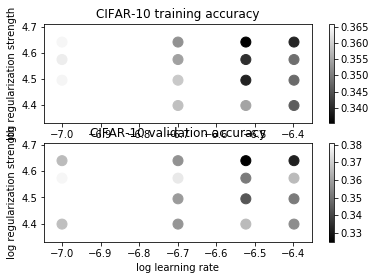

In [22]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [23]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.359000


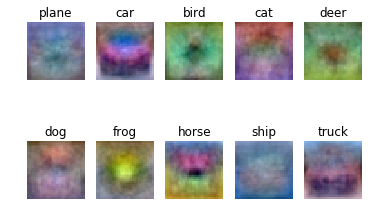

In [24]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*